In [1]:
!pip install -q torchinfo

In [2]:
!nvidia-smi

Thu May  2 07:05:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import lib

In [3]:
# run 11111111
import os
import tarfile
import scipy.io
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchinfo import summary

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(0)
torch.manual_seed(0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
os.chdir("/content/drive/MyDrive/3_XuLyAnh_Flowers")
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1tU35xhAZwBdemxnc1j9Q3JzeU3wbyFMK/3_XuLyAnh_Flowers'

In [6]:
IMG_SIZE      = 224
BATCH_SIZE    = 4
RANDOM_SEED   = 42

## Data

In [7]:
DATA_PATH = os.getcwd()
PATH = os.getcwd() + "/jpg/"

In [8]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]


df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH + '/102flowers.tgz'))

# load file label:  label (1 -> 102) == -1 ==>  (0 -> 101)
df['Category'] = scipy.io.loadmat(DATA_PATH + '/imagelabels.mat')['labels'][0] - 1
df['Category'] = df['Category'].astype(str)

In [9]:
top_15_categories = ['48', '76', '42', '72', '89', '73', '81', '95', '88', '77', '37', '39', '83', '96', '74']

In [10]:
# Lọc DataFrame ban đầu
df_15 = df[df['Category'].isin(top_15_categories)]

In [11]:
train_files, test_files, train_labels, test_labels = \
    train_test_split(
        df_15['Id'],
        df_15['Category'],
        test_size = 0.2,
        random_state = 42,
        stratify = df_15['Category']
)
train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels
train_files.shape, test_files.shape

((1436, 2), (360, 2))

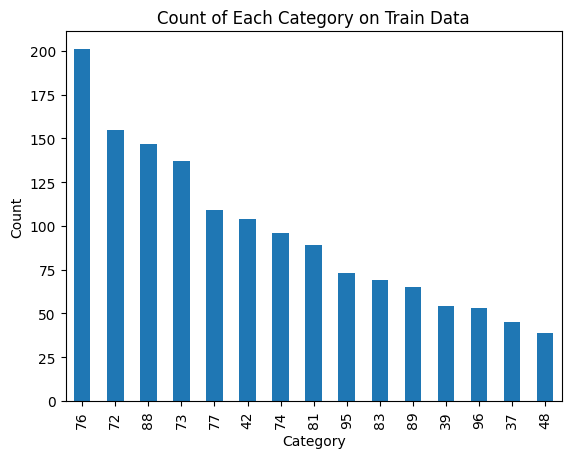

In [12]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
train_files['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category on Train Data')
plt.show()

### Data augmentation

In [13]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 50,
    shear_range = 0.2,
    zoom_range = [0.75, 1.25],
    brightness_range = [0.5, 1.5],
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
    seed = RANDOM_SEED
)

Found 1436 validated image filenames belonging to 15 classes.
Found 360 validated image filenames belonging to 15 classes.


In [15]:
train_generator.samples

1436

Ví dụ về hình ảnh từ train_generator


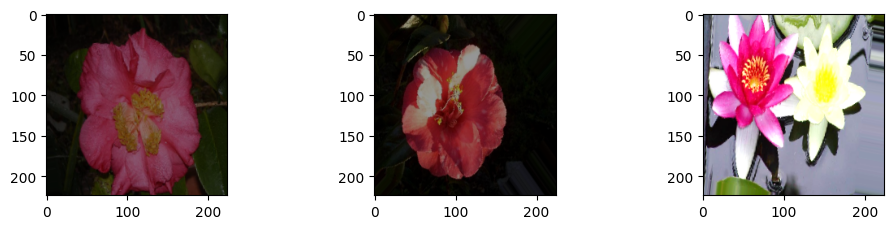

In [16]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x, y = train_generator.next()
print('Ví dụ về hình ảnh từ train_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 3):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

Ví dụ về hình ảnh từ test_generator


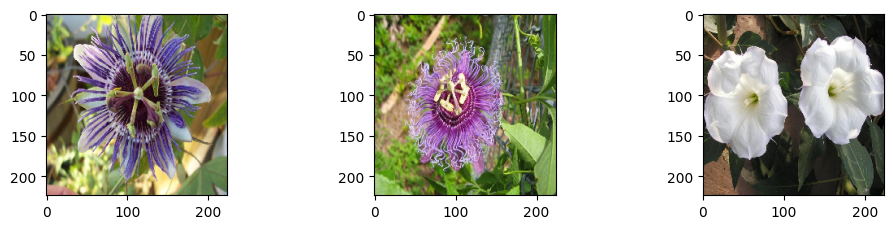

In [17]:
x, y = test_generator.next()
print('Ví dụ về hình ảnh từ test_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 3):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

## ViT Model

### Step 4: Create Patch Embedding Layer

In [88]:
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)
# NUM_OF_PATCHES = 27*27

#the image width and image height should be divisible by patch size. This is a check to see that.

assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")

In [89]:
conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

torch.Size([4, 224, 224, 3])
torch.Size([4, 3, 224, 224])


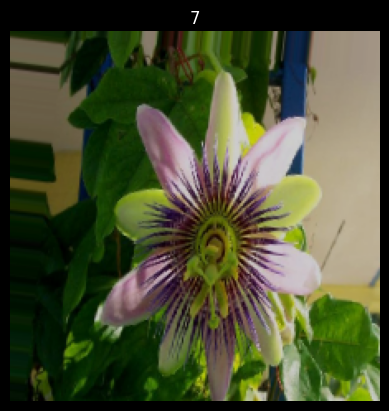

In [90]:
random_images, random_labels = next(iter(train_generator))
random_images = torch.from_numpy(random_images)
print(random_images.shape)
random_images = random_images.permute((0, 3, 1, 2))
print(random_images.shape)
random_image = random_images[0]

# Create a new figure
fig = plt.figure(1)

# # Chuyển random_image thành tensor
# random_image_tensor = torch.from_numpy(random_image)

# Display the random image
plt.imshow(random_image.permute((1, 2, 0)))

# Disable the axis for better visualization
plt.axis(False)

# Set the title of the image
plt.title(np.argmax(random_labels[0]), color="white")

# Set the background color of the figure as black
fig.set_facecolor(color="black")

### Stem block in GoogLenet

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StemBlock(nn.Module):
    def __init__(self):
        super(StemBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=768, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        return x


# random_images, random_labels = next(iter(train_generator))
# random_images = torch.from_numpy(random_images)
# print(random_images.shape)
# random_images = random_images.permute((0, 3, 1, 2))
# print(random_images.shape)
# Sử dụng StemBlock
# input_tensor = torch.randn(1, 3, 224, 224)  # Example input tensor with shape (batch_size, channels, height, width)
stem_block = StemBlock()
output_tensor = stem_block(random_images)
print(output_tensor.shape)  # In ra kích thước tensor đầu ra

torch.Size([4, 768, 27, 27])


In [92]:
# Pass the image through the convolution layer
print(random_image.shape)
image_through_conv = conv_layer(random_image.unsqueeze(0))
print(f'Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]')

# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten

torch.Size([3, 224, 224])
Shape of embeddings through the conv layer -> [1, 768, 14, 14] <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]
Shape of embeddings through the flatten layer -> [1, 196, 768] <- [batch_size, num_of_patches, embedding_dims]


In [93]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [94]:
position = get_positional_embeddings(14**2 + 1, 768)
print(position.shape)

torch.Size([197, 768])


In [95]:
# class_token_embeddings = nn.Parameter(torch.rand((1, 1,EMBEDDING_DIMS), requires_grad  = True))
# print(f'Shape of class_token_embeddings --> {list(class_token_embeddings.shape)} <-- [batch_size, 1, emdedding_dims]')

# embedded_image_with_class_token_embeddings = torch.cat((class_token_embeddings, embedded_image), dim = 1)
# print(f'\nShape of image embeddings with class_token_embeddings --> {list(embedded_image_with_class_token_embeddings.shape)} <-- [batch_size, num_of_patches+1, embeddiing_dims]')

# position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES+1, EMBEDDING_DIMS ), requires_grad = True ))
# print(f'\nShape of position_embeddings --> {list(position_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

# final_embeddings = embedded_image_with_class_token_embeddings + position_embeddings
# print(f'\nShape of final_embeddings --> {list(final_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

Put the PatchEmbedddingLayer Together

In [96]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        # self.cnn_layer = StemBlock()
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.register_buffer('position_embeddings', get_positional_embeddings(14 ** 2 + 1, EMBEDDING_DIMS), persistent=False)
        # self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        # print(x.shape)
        # print(self.cnn_layer(x).shape, self.conv_layer(x).shape)
        # print(self.cnn_layer(x).permute((0, 2, 3, 1)).shape, self.conv_layer(x).permute((0, 2, 3, 1)).shape)
        # print(self.flatten_layer(self.cnn_layer(x).permute((0, 2, 3, 1))).shape, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1))).shape)
        # print(self.class_token_embeddings.shape)

        # print(torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1).shape)
        # print(self.position_embeddings.repeat(x.shape[0], 1, 1).shape)

        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings.repeat(x.shape[0], 1, 1)
        # print(output.shape)
        return output

In [97]:
patch_embedding_layer = PatchEmbeddingLayer(in_channels=IMAGE_CHANNELS, patch_size=PATCH_SIZE, embedding_dim=IMAGE_CHANNELS * PATCH_SIZE ** 2)
print(random_images.shape)
patch_embeddings = patch_embedding_layer(random_images)
print(patch_embeddings.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4, 197, 768])


In [98]:
summary(model=patch_embedding_layer,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
PatchEmbeddingLayer (PatchEmbeddingLayer)     [4, 3, 224, 224]     [4, 197, 768]        3,072                True
├─Conv2d (conv_layer)                         [4, 3, 224, 224]     [4, 768, 14, 14]     590,592              True
├─Flatten (flatten_layer)                     [4, 14, 14, 768]     [4, 196, 768]        --                   --
Total params: 593,664
Trainable params: 593,664
Non-trainable params: 0
Total mult-adds (M): 463.02
Input size (MB): 2.41
Forward/backward pass size (MB): 4.82
Params size (MB): 2.36
Estimated Total Size (MB): 9.59

### Step 5. Creating the Multi-Head Self Attention (MSA) Block.

In [99]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = 768, # Hidden Size D in the ViT Paper Table 1
               num_heads = 12,  # Heads in the ViT Paper Table 1
               attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

In [100]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dims = EMBEDDING_DIMS,
                                                             num_heads = 12
                                                             )
print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from MSA Block => {list(multihead_self_attention_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

Shape of the input Patch Embeddings => [4, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from MSA Block => [4, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


In [101]:
summary(model=multihead_self_attention_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiHeadSelfAttentionBlock (MultiHeadSelfAttentionBlock)    [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                                      [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (multiheadattention)                    --                   [1, 197, 768]        2,362,368            True
Total params: 2,363,904
Trainable params: 2,363,904
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 1.21
Params size (MB): 0.01
Estimated Total Size (MB): 1.82

### Step 6. Creating the Machine Learning Perceptron (MLP) Block

In [102]:
class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

In [103]:
mlp_block = MachineLearningPerceptronBlock(embedding_dims = EMBEDDING_DIMS,
                                           mlp_size = 3072,
                                           mlp_dropout = 0.1)

summary(model=mlp_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MachineLearningPerceptronBlock (MachineLearningPerceptronBlock)   [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                                           [1, 197, 768]        [1, 197, 768]        1,536                True
├─Sequential (mlp)                                                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Linear (0)                                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
│    └─GELU (1)                                                   [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Dropout (2)                                                [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Linear (3)                                            

### Step 7. Putting together the Transformer Block

In [104]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims = 768,
               mlp_dropout=0.1,
               attn_dropout=0.0,
               mlp_size = 3072,
               num_heads = 12,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x

In [105]:
transformer_block = TransformerBlock(embedding_dims = EMBEDDING_DIMS,
                                     mlp_dropout = 0.1,
                                     attn_dropout=0.0,
                                     mlp_size = 3072,
                                     num_heads = 12)

print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from Transformer Block => {list(transformer_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

Shape of the input Patch Embeddings => [4, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from Transformer Block => [4, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


In [106]:
summary(model=transformer_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerBlock (TransformerBlock)                [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multiheadattention)     --                   [1, 197, 768]        2,362,368            True
├─MachineLearningPerceptronBlock (mlp_block)       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Step 8. Creating the ViT Model

In [107]:
class ViT(nn.Module):
  def __init__(self, img_size = 224,
               in_channels = 3,
               patch_size = 16,
               embedding_dims = 768,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 12,
               num_classes = 15):
    super().__init__()

    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                     patch_size=patch_size,
                                                     embedding_dim = embedding_dims)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))

  def forward(self, x):
    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

In [108]:
vit = ViT()
summary(model=vit,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [4, 3, 224, 224]     [4, 15]              --                   True
├─PatchEmbeddingLayer (patch_embedding_layer)                [4, 3, 224, 224]     [4, 197, 768]        3,072                True
│    └─Conv2d (conv_layer)                                   [4, 3, 224, 224]     [4, 768, 14, 14]     590,592              True
│    └─Flatten (flatten_layer)                               [4, 14, 14, 768]     [4, 196, 768]        --                   --
├─Sequential (transformer_encoder)                           [4, 197, 768]        [4, 197, 768]        --                   True
│    └─TransformerBlock (0)                                  [4, 197, 768]        [4, 197, 768]        --                   True
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [4, 197, 768]        [4, 197, 768

## Training

In [109]:
# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
# 250/10=25  => n_patches = 25, size_sub_image = 3*10*10 => hidden_d = 1024 => n_heads=16, out_d = 15
# 250/25=10 => n_patches = 10, size_sub_image = 3*25*25 => hidden_d = 1024 => n_heads=16, out_d = 15
model = ViT().to(device)


Using device:  cuda (Tesla T4)


In [110]:
N_EPOCHS = 20
LR = 0.005

In [ ]:
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss().to(device)
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    total_batches = len(train_generator)
    print(total_batches)
    processed_batches = 0
    # change here
    for batch in tqdm(train_generator, desc=f"Epoch {epoch + 1} in training", leave=False, dynamic_ncols=True):
        x, y = batch
        x = torch.tensor(x, dtype=torch.float32).to(device).permute(0, 3, 1, 2)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        # print(y)
        # Sử dụng argmax để lấy chỉ số của giá trị lớn nhất trong mỗi hàng
        y = torch.argmax(y, dim=1)
        # print(y)
        # print("\nx.shape", x.shape)
        # x, y = x.to(device), y.to(device)
        y_hat = model(x)
        # print(y_hat)
        # print(y)
        loss = criterion(y_hat, y)
        print(loss)
        train_loss += loss.detach().cpu().item() / len(train_generator)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        processed_batches += 1
        if processed_batches>total_batches:
          break

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Training:   0%|          | 0/20 [00:00<?, ?it/s]

359



Epoch 1 in training:   0%|          | 1/359 [00:00<01:00,  5.88it/s]

tensor(2.2770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   1%|          | 3/359 [00:00<01:05,  5.42it/s]

tensor(1.8618, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   1%|▏         | 5/359 [00:00<01:01,  5.77it/s]

tensor(2.7007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1218, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   2%|▏         | 6/359 [00:01<01:03,  5.52it/s]

tensor(2.4448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7393, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   2%|▏         | 8/359 [00:01<01:03,  5.51it/s]

tensor(1.3423, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2431, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   3%|▎         | 10/359 [00:01<01:05,  5.36it/s]

tensor(2.4131, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   3%|▎         | 11/359 [00:02<01:10,  4.94it/s]

tensor(2.6397, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3992, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   4%|▎         | 13/359 [00:02<01:08,  5.03it/s]

tensor(2.3392, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1421, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   4%|▍         | 15/359 [00:02<01:05,  5.25it/s]

tensor(2.1649, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3649, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   5%|▍         | 17/359 [00:03<01:05,  5.25it/s]

tensor(2.7679, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1346, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   5%|▌         | 19/359 [00:03<01:04,  5.29it/s]

tensor(2.0913, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0931, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   6%|▌         | 21/359 [00:04<01:10,  4.82it/s]

tensor(2.1899, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   6%|▌         | 22/359 [00:04<01:13,  4.58it/s]

tensor(2.6164, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   6%|▋         | 23/359 [00:04<01:14,  4.50it/s]

tensor(2.1224, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7255, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   7%|▋         | 25/359 [00:04<01:09,  4.82it/s]

tensor(2.4806, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   8%|▊         | 27/359 [00:05<01:09,  4.79it/s]

tensor(2.0030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6718, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   8%|▊         | 29/359 [00:05<01:05,  5.07it/s]

tensor(2.7376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   8%|▊         | 30/359 [00:05<01:06,  4.96it/s]

tensor(2.3195, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3654, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   9%|▉         | 32/359 [00:06<01:04,  5.07it/s]

tensor(3.0359, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0668, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   9%|▉         | 34/359 [00:06<01:00,  5.33it/s]

tensor(2.5243, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  10%|█         | 36/359 [00:07<01:00,  5.36it/s]

tensor(2.0666, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5116, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  11%|█         | 38/359 [00:07<01:00,  5.33it/s]

tensor(2.4998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0693, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  11%|█▏        | 41/359 [00:07<00:57,  5.56it/s]

tensor(2.1276, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  12%|█▏        | 43/359 [00:08<00:54,  5.79it/s]

tensor(3.2317, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  13%|█▎        | 45/359 [00:08<00:54,  5.80it/s]

tensor(1.7080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  13%|█▎        | 47/359 [00:08<00:53,  5.83it/s]

tensor(2.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4178, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  14%|█▎        | 49/359 [00:09<00:53,  5.79it/s]

tensor(1.8702, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  14%|█▍        | 51/359 [00:09<00:52,  5.86it/s]

tensor(2.1257, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4403, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  15%|█▍        | 53/359 [00:09<00:52,  5.85it/s]

tensor(1.7165, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  15%|█▌        | 55/359 [00:10<00:51,  5.88it/s]

tensor(2.4852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  16%|█▌        | 57/359 [00:10<00:51,  5.92it/s]

tensor(1.7869, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  16%|█▋        | 59/359 [00:10<00:51,  5.86it/s]

tensor(3.1027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7798, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  17%|█▋        | 61/359 [00:11<00:50,  5.85it/s]

tensor(2.4944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1374, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  18%|█▊        | 63/359 [00:11<00:50,  5.87it/s]

tensor(2.5572, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  18%|█▊        | 65/359 [00:12<00:50,  5.85it/s]

tensor(1.5975, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  19%|█▊        | 67/359 [00:12<00:49,  5.94it/s]

tensor(2.4600, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0527, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  19%|█▉        | 69/359 [00:12<00:49,  5.86it/s]

tensor(2.2201, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  20%|█▉        | 71/359 [00:13<00:49,  5.84it/s]

tensor(2.3086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9324, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  20%|██        | 73/359 [00:13<00:48,  5.84it/s]

tensor(2.1900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0864, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  21%|██        | 75/359 [00:13<00:48,  5.86it/s]

tensor(2.4760, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1119, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  21%|██▏       | 77/359 [00:14<00:48,  5.84it/s]

tensor(2.5823, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  22%|██▏       | 79/359 [00:14<00:47,  5.86it/s]

tensor(2.2542, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9905, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  23%|██▎       | 81/359 [00:14<00:47,  5.89it/s]

tensor(2.4353, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2636, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  23%|██▎       | 83/359 [00:15<00:47,  5.86it/s]

tensor(1.9839, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8824, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  24%|██▎       | 85/359 [00:15<00:46,  5.87it/s]

tensor(2.3569, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0544, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  24%|██▍       | 87/359 [00:15<00:46,  5.86it/s]

tensor(2.3187, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1741, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  25%|██▍       | 89/359 [00:16<00:46,  5.84it/s]

tensor(1.7125, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  25%|██▌       | 91/359 [00:16<00:45,  5.85it/s]

tensor(2.5614, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  26%|██▌       | 93/359 [00:16<00:45,  5.86it/s]

tensor(2.3037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7352, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  26%|██▋       | 95/359 [00:17<00:44,  5.88it/s]

tensor(1.8127, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  27%|██▋       | 97/359 [00:17<00:44,  5.85it/s]

tensor(2.3692, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5124, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  28%|██▊       | 99/359 [00:17<00:44,  5.85it/s]

tensor(1.1798, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3183, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  28%|██▊       | 100/359 [00:18<00:48,  5.39it/s]

tensor(2.8775, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7838, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  28%|██▊       | 102/359 [00:18<00:48,  5.30it/s]

tensor(3.0805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6264, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  29%|██▉       | 104/359 [00:18<00:48,  5.31it/s]

tensor(1.0988, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  30%|██▉       | 106/359 [00:19<00:48,  5.27it/s]

tensor(2.0236, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2054, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  30%|███       | 108/359 [00:19<00:47,  5.32it/s]

tensor(2.4920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1689, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  31%|███       | 110/359 [00:19<00:47,  5.29it/s]

tensor(2.3183, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6900, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  31%|███       | 112/359 [00:20<00:46,  5.31it/s]

tensor(2.6506, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9634, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  32%|███▏      | 114/359 [00:20<00:47,  5.18it/s]

tensor(1.7024, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  32%|███▏      | 115/359 [00:20<00:48,  5.04it/s]

tensor(2.3659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  32%|███▏      | 116/359 [00:21<00:48,  4.98it/s]

tensor(3.1149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  33%|███▎      | 117/359 [00:21<00:50,  4.82it/s]

tensor(1.6070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  33%|███▎      | 120/359 [00:21<00:43,  5.52it/s]

tensor(1.4107, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  34%|███▍      | 122/359 [00:22<00:41,  5.67it/s]

tensor(1.8243, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  35%|███▍      | 124/359 [00:22<00:40,  5.75it/s]

tensor(2.2713, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1829, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  35%|███▌      | 126/359 [00:22<00:39,  5.87it/s]

tensor(2.2634, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  36%|███▌      | 128/359 [00:23<00:39,  5.91it/s]

tensor(2.1693, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  36%|███▌      | 130/359 [00:23<00:38,  5.93it/s]

tensor(1.7174, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9429, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  37%|███▋      | 132/359 [00:23<00:38,  5.93it/s]

tensor(1.9207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2688, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  37%|███▋      | 134/359 [00:24<00:37,  5.99it/s]

tensor(1.3453, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2931, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  38%|███▊      | 136/359 [00:24<00:37,  5.93it/s]

tensor(3.0730, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5254, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  38%|███▊      | 138/359 [00:24<00:37,  5.94it/s]

tensor(2.6146, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  39%|███▉      | 140/359 [00:25<00:36,  5.97it/s]

tensor(1.5583, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5595, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  40%|███▉      | 142/359 [00:25<00:36,  5.94it/s]

tensor(2.2744, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7523, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  40%|████      | 144/359 [00:25<00:35,  5.99it/s]

tensor(2.9397, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0425, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  41%|████      | 146/359 [00:26<00:35,  5.94it/s]

tensor(2.3772, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7457, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  41%|████      | 148/359 [00:26<00:35,  6.00it/s]

tensor(2.0468, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  42%|████▏     | 150/359 [00:26<00:35,  5.96it/s]

tensor(1.8321, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3904, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  42%|████▏     | 152/359 [00:27<00:34,  5.99it/s]

tensor(2.3498, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3858, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  43%|████▎     | 154/359 [00:27<00:34,  5.98it/s]

tensor(2.5494, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  43%|████▎     | 156/359 [00:27<00:33,  6.02it/s]

tensor(2.1425, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9506, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  44%|████▍     | 158/359 [00:28<00:33,  5.96it/s]

tensor(1.5008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4612, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  45%|████▍     | 160/359 [00:28<00:33,  6.02it/s]

tensor(2.1060, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4517, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  45%|████▌     | 162/359 [00:28<00:32,  5.98it/s]

tensor(2.5906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  46%|████▌     | 164/359 [00:29<00:32,  5.98it/s]

tensor(2.1400, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  46%|████▌     | 166/359 [00:29<00:32,  5.97it/s]

tensor(2.6905, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  47%|████▋     | 168/359 [00:29<00:32,  5.92it/s]

tensor(2.1978, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7030, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  47%|████▋     | 170/359 [00:30<00:31,  5.95it/s]

tensor(3.0214, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7548, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  48%|████▊     | 172/359 [00:30<00:30,  6.04it/s]

tensor(2.7245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5779, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  48%|████▊     | 174/359 [00:30<00:30,  6.01it/s]

tensor(1.3681, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6744, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  49%|████▉     | 176/359 [00:31<00:30,  5.99it/s]

tensor(1.3317, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8491, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  49%|████▉     | 177/359 [00:31<00:30,  6.05it/s]

tensor(1.5160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  50%|████▉     | 179/359 [00:31<00:32,  5.60it/s]

tensor(2.5598, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  50%|█████     | 181/359 [00:32<00:33,  5.31it/s]

tensor(2.3886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  51%|█████     | 183/359 [00:32<00:33,  5.29it/s]

tensor(2.9378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  51%|█████▏    | 184/359 [00:32<00:33,  5.15it/s]

tensor(1.6404, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  52%|█████▏    | 186/359 [00:33<00:34,  5.08it/s]

tensor(2.5602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  52%|█████▏    | 187/359 [00:33<00:35,  4.80it/s]

tensor(2.4354, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8863, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  53%|█████▎    | 189/359 [00:33<00:33,  5.09it/s]

tensor(2.1345, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3544, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  53%|█████▎    | 191/359 [00:34<00:32,  5.20it/s]

tensor(2.6734, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3543, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  54%|█████▍    | 193/359 [00:34<00:31,  5.27it/s]

tensor(2.1792, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  54%|█████▍    | 195/359 [00:34<00:31,  5.20it/s]

tensor(2.2662, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3033, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  55%|█████▌    | 198/359 [00:35<00:28,  5.70it/s]

tensor(2.2865, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  56%|█████▌    | 200/359 [00:35<00:27,  5.87it/s]

tensor(2.3811, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  56%|█████▋    | 202/359 [00:36<00:26,  5.90it/s]

tensor(2.3413, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9071, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  57%|█████▋    | 204/359 [00:36<00:26,  5.95it/s]

tensor(2.1161, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3407, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  57%|█████▋    | 206/359 [00:36<00:25,  6.08it/s]

tensor(1.9786, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0058, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  58%|█████▊    | 208/359 [00:37<00:24,  6.04it/s]

tensor(2.1911, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2019, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  58%|█████▊    | 210/359 [00:37<00:24,  6.01it/s]

tensor(2.9784, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7301, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  59%|█████▉    | 212/359 [00:37<00:24,  6.08it/s]

tensor(2.1375, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4590, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  60%|█████▉    | 214/359 [00:38<00:23,  6.11it/s]

tensor(2.7170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  60%|██████    | 216/359 [00:38<00:23,  6.11it/s]

tensor(1.7162, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  61%|██████    | 218/359 [00:38<00:23,  6.09it/s]

tensor(1.8880, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  61%|██████▏   | 220/359 [00:39<00:22,  6.09it/s]

tensor(2.5549, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  62%|██████▏   | 222/359 [00:39<00:22,  6.10it/s]

tensor(2.8213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1397, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  62%|██████▏   | 224/359 [00:39<00:21,  6.14it/s]

tensor(2.1623, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  63%|██████▎   | 226/359 [00:40<00:21,  6.13it/s]

tensor(2.2129, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3297, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  64%|██████▎   | 228/359 [00:40<00:21,  6.17it/s]

tensor(2.3666, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9660, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  64%|██████▍   | 230/359 [00:40<00:20,  6.14it/s]

tensor(2.5311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2412, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  65%|██████▍   | 232/359 [00:41<00:20,  6.17it/s]

tensor(2.9673, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  65%|██████▌   | 234/359 [00:41<00:20,  6.15it/s]

tensor(2.5969, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  66%|██████▌   | 236/359 [00:41<00:20,  6.08it/s]

tensor(2.4499, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2743, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  66%|██████▋   | 238/359 [00:42<00:19,  6.06it/s]

tensor(2.1740, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4681, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  67%|██████▋   | 240/359 [00:42<00:19,  6.14it/s]

tensor(1.8331, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0983, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  67%|██████▋   | 242/359 [00:42<00:19,  6.13it/s]

tensor(2.0766, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0742, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  68%|██████▊   | 244/359 [00:42<00:18,  6.14it/s]

tensor(1.7677, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  69%|██████▊   | 246/359 [00:43<00:18,  6.13it/s]

tensor(2.2976, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  69%|██████▉   | 248/359 [00:43<00:18,  6.09it/s]

tensor(1.5010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9975, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  70%|██████▉   | 250/359 [00:43<00:17,  6.10it/s]

tensor(1.5694, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1269, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  70%|███████   | 252/359 [00:44<00:17,  6.12it/s]

tensor(2.1768, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9902, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  71%|███████   | 254/359 [00:44<00:17,  6.11it/s]

tensor(1.8001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7665, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  71%|███████▏  | 256/359 [00:44<00:16,  6.15it/s]

tensor(2.8696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3983, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  72%|███████▏  | 257/359 [00:45<00:16,  6.12it/s]

tensor(1.8257, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  72%|███████▏  | 259/359 [00:45<00:18,  5.49it/s]

tensor(2.3874, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0735, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  73%|███████▎  | 261/359 [00:45<00:18,  5.34it/s]

tensor(2.0807, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3091, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  73%|███████▎  | 263/359 [00:46<00:17,  5.35it/s]

tensor(2.4527, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7415, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  74%|███████▍  | 265/359 [00:46<00:18,  5.18it/s]

tensor(1.5752, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  74%|███████▍  | 267/359 [00:47<00:17,  5.21it/s]

tensor(2.0238, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4161, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  75%|███████▍  | 269/359 [00:47<00:17,  5.22it/s]

tensor(3.2210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0179, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  75%|███████▌  | 271/359 [00:47<00:17,  5.12it/s]

tensor(1.9796, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9352, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  76%|███████▌  | 273/359 [00:48<00:18,  4.78it/s]

tensor(1.4824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3200, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  77%|███████▋  | 275/359 [00:48<00:17,  4.83it/s]


tensor(1.3538, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7644, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1 in training:  77%|███████▋  | 278/359 [00:49<00:14,  5.59it/s]

tensor(2.9415, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0589, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  78%|███████▊  | 280/359 [00:49<00:13,  5.84it/s]

tensor(2.4901, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2008, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  79%|███████▊  | 282/359 [00:49<00:13,  5.89it/s]

tensor(2.7050, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4139, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  79%|███████▉  | 284/359 [00:50<00:12,  6.03it/s]

tensor(2.2198, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3049, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  80%|███████▉  | 286/359 [00:50<00:11,  6.08it/s]

tensor(2.4276, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0877, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  80%|████████  | 288/359 [00:50<00:11,  6.08it/s]

tensor(2.2284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  81%|████████  | 290/359 [00:51<00:11,  6.11it/s]

tensor(2.3361, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9503, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  81%|████████▏ | 292/359 [00:51<00:11,  6.07it/s]

tensor(1.8267, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2914, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  82%|████████▏ | 294/359 [00:51<00:10,  6.11it/s]

tensor(1.7993, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  82%|████████▏ | 296/359 [00:52<00:10,  6.15it/s]

tensor(1.9914, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4101, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  83%|████████▎ | 298/359 [00:52<00:09,  6.11it/s]

tensor(2.8847, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2144, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  84%|████████▎ | 300/359 [00:52<00:09,  6.17it/s]

tensor(1.7777, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  84%|████████▍ | 302/359 [00:53<00:09,  6.16it/s]

tensor(2.5072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9085, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  85%|████████▍ | 304/359 [00:53<00:08,  6.19it/s]

tensor(2.0921, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3467, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  85%|████████▌ | 306/359 [00:53<00:08,  6.02it/s]

tensor(2.3623, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  86%|████████▌ | 307/359 [00:53<00:09,  5.69it/s]

tensor(2.9351, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  86%|████████▌ | 308/359 [00:54<00:10,  5.08it/s]

tensor(1.6472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  86%|████████▌ | 309/359 [00:54<00:10,  4.67it/s]

tensor(2.0983, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  86%|████████▋ | 310/359 [00:54<00:12,  3.95it/s]

tensor(2.0946, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  87%|████████▋ | 312/359 [00:55<00:10,  4.67it/s]

tensor(1.6221, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  87%|████████▋ | 314/359 [00:55<00:08,  5.35it/s]

tensor(2.9783, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5158, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  88%|████████▊ | 316/359 [00:55<00:07,  5.77it/s]

tensor(2.1448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  89%|████████▊ | 318/359 [00:56<00:06,  5.93it/s]

tensor(1.8240, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  89%|████████▉ | 320/359 [00:56<00:06,  6.08it/s]

tensor(1.7807, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1622, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  90%|████████▉ | 322/359 [00:56<00:06,  6.01it/s]

tensor(2.2438, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3969, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  90%|█████████ | 324/359 [00:57<00:05,  6.16it/s]

tensor(2.1292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8455, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  91%|█████████ | 325/359 [00:57<00:05,  6.16it/s]


tensor(3.1753, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.9696, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 1 in training:  91%|█████████▏| 328/359 [00:57<00:05,  6.02it/s]

tensor(1.6004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  92%|█████████▏| 329/359 [00:58<00:05,  5.20it/s]

tensor(1.6414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  92%|█████████▏| 330/359 [00:58<00:06,  4.44it/s]

tensor(1.7572, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  92%|█████████▏| 331/359 [00:58<00:07,  3.96it/s]

tensor(2.1157, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6590, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  93%|█████████▎| 333/359 [00:59<00:05,  4.52it/s]

tensor(2.7245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  93%|█████████▎| 335/359 [00:59<00:05,  4.76it/s]

tensor(1.7297, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  94%|█████████▍| 337/359 [00:59<00:04,  4.94it/s]

tensor(2.5757, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  94%|█████████▍| 338/359 [01:00<00:04,  4.39it/s]

tensor(1.7006, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  94%|█████████▍| 339/359 [01:00<00:05,  3.65it/s]

tensor(2.9076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  95%|█████████▍| 340/359 [01:00<00:05,  3.52it/s]

tensor(2.5251, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  95%|█████████▍| 341/359 [01:01<00:06,  2.58it/s]

tensor(2.1921, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  95%|█████████▌| 342/359 [01:01<00:06,  2.45it/s]

tensor(1.5030, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  96%|█████████▌| 343/359 [01:02<00:07,  2.27it/s]

tensor(2.1894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  96%|█████████▌| 344/359 [01:02<00:06,  2.47it/s]

tensor(2.1324, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  96%|█████████▌| 345/359 [01:03<00:05,  2.50it/s]

tensor(2.8038, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  96%|█████████▋| 346/359 [01:03<00:04,  2.65it/s]

tensor(2.1430, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  97%|█████████▋| 347/359 [01:03<00:04,  2.82it/s]

tensor(1.4845, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  97%|█████████▋| 348/359 [01:04<00:03,  2.81it/s]

tensor(1.9364, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  97%|█████████▋| 349/359 [01:04<00:03,  2.71it/s]

tensor(1.8494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  97%|█████████▋| 350/359 [01:04<00:03,  2.79it/s]

tensor(1.9914, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  98%|█████████▊| 351/359 [01:05<00:02,  3.00it/s]

tensor(1.9615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  98%|█████████▊| 352/359 [01:05<00:02,  2.97it/s]

tensor(1.5988, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  98%|█████████▊| 353/359 [01:05<00:01,  3.19it/s]

tensor(1.9973, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  99%|█████████▊| 354/359 [01:05<00:01,  3.40it/s]

tensor(2.1021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  99%|█████████▉| 355/359 [01:06<00:01,  3.64it/s]

tensor(3.4233, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  99%|█████████▉| 356/359 [01:06<00:00,  3.32it/s]

tensor(2.2947, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  99%|█████████▉| 357/359 [01:06<00:00,  3.42it/s]

tensor(2.1013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training: 100%|█████████▉| 358/359 [01:07<00:00,  3.32it/s]

tensor(2.5733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training: 100%|██████████| 359/359 [01:07<00:00,  3.06it/s]

tensor(3.0917, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:   5%|▌         | 1/20 [01:08<21:32, 68.02s/it]

tensor(2.0603, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 1/20 loss: 2.23
359



Epoch 2 in training:   0%|          | 1/359 [00:00<01:41,  3.52it/s]

tensor(1.7128, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   1%|          | 2/359 [00:00<01:31,  3.91it/s]

tensor(2.1672, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   1%|          | 3/359 [00:00<01:39,  3.56it/s]

tensor(2.7316, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   1%|          | 4/359 [00:01<01:44,  3.39it/s]

tensor(2.1497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   1%|▏         | 5/359 [00:01<02:15,  2.61it/s]

tensor(1.3574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   2%|▏         | 6/359 [00:02<02:18,  2.54it/s]

tensor(1.7895, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   2%|▏         | 7/359 [00:02<02:14,  2.62it/s]

tensor(2.4021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   2%|▏         | 8/359 [00:02<01:59,  2.93it/s]

tensor(2.5787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   3%|▎         | 9/359 [00:02<01:50,  3.16it/s]

tensor(2.1439, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   3%|▎         | 10/359 [00:03<01:47,  3.25it/s]

tensor(1.8893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   3%|▎         | 11/359 [00:03<01:37,  3.57it/s]

tensor(1.8144, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   3%|▎         | 12/359 [00:03<01:33,  3.69it/s]

tensor(1.8906, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   4%|▎         | 13/359 [00:04<01:35,  3.62it/s]

tensor(2.6237, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   4%|▍         | 14/359 [00:04<01:40,  3.43it/s]

tensor(1.7951, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   4%|▍         | 15/359 [00:04<01:39,  3.45it/s]

tensor(2.8713, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   4%|▍         | 16/359 [00:05<01:50,  3.11it/s]

tensor(2.9815, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   5%|▍         | 17/359 [00:05<02:09,  2.64it/s]

tensor(2.3856, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   5%|▌         | 18/359 [00:06<02:33,  2.23it/s]

tensor(1.3485, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   5%|▌         | 19/359 [00:06<02:24,  2.35it/s]

tensor(2.6558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   6%|▌         | 20/359 [00:06<02:03,  2.74it/s]

tensor(2.6367, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   6%|▌         | 22/359 [00:07<01:33,  3.62it/s]

tensor(2.4301, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0880, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   7%|▋         | 24/359 [00:07<01:16,  4.35it/s]

tensor(2.4143, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0820, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 2 in training:   7%|▋         | 25/359 [00:07<01:14,  4.47it/s]


tensor(1.9434, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   8%|▊         | 27/359 [00:08<01:08,  4.88it/s]

tensor(2.8526, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   8%|▊         | 29/359 [00:08<01:06,  4.97it/s]

tensor(2.6462, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   9%|▉         | 32/359 [00:09<01:00,  5.43it/s]

tensor(3.3727, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5857, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   9%|▉         | 34/359 [00:09<00:56,  5.77it/s]

tensor(2.2151, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  10%|█         | 36/359 [00:09<00:54,  5.89it/s]

tensor(1.9788, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  11%|█         | 38/359 [00:10<00:54,  5.89it/s]

tensor(2.4927, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6260, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  11%|█         | 40/359 [00:10<00:52,  6.08it/s]

tensor(2.4312, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1355, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  12%|█▏        | 42/359 [00:10<00:52,  6.09it/s]

tensor(1.9950, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1902, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  12%|█▏        | 44/359 [00:10<00:51,  6.10it/s]

tensor(1.8896, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  13%|█▎        | 46/359 [00:11<00:50,  6.14it/s]

tensor(2.2683, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  13%|█▎        | 48/359 [00:11<00:50,  6.15it/s]

tensor(2.0023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5087, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  14%|█▍        | 50/359 [00:11<00:50,  6.15it/s]

tensor(1.9944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5977, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  14%|█▍        | 52/359 [00:12<00:50,  6.13it/s]

tensor(2.0323, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8152, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  15%|█▌        | 54/359 [00:12<00:50,  6.07it/s]

tensor(1.7647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0325, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  16%|█▌        | 56/359 [00:12<00:50,  6.00it/s]

tensor(2.7415, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  16%|█▌        | 58/359 [00:13<00:49,  6.03it/s]

tensor(1.7645, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  17%|█▋        | 60/359 [00:13<00:49,  6.07it/s]

tensor(2.3550, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  17%|█▋        | 62/359 [00:13<00:48,  6.09it/s]

tensor(2.6514, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  18%|█▊        | 64/359 [00:14<00:48,  6.13it/s]

tensor(1.7619, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7549, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  18%|█▊        | 66/359 [00:14<00:47,  6.15it/s]

tensor(2.5795, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  19%|█▉        | 68/359 [00:14<00:47,  6.15it/s]

tensor(2.0150, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4754, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  19%|█▉        | 70/359 [00:15<00:47,  6.14it/s]

tensor(2.6577, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5729, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  20%|██        | 72/359 [00:15<00:47,  6.06it/s]

tensor(2.3033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  21%|██        | 74/359 [00:15<00:46,  6.09it/s]

tensor(2.4885, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0754, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  21%|██        | 76/359 [00:16<00:46,  6.08it/s]

tensor(1.7589, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  22%|██▏       | 78/359 [00:16<00:46,  6.10it/s]

tensor(2.4825, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4839, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  22%|██▏       | 80/359 [00:16<00:46,  6.03it/s]

tensor(2.3764, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0960, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  23%|██▎       | 82/359 [00:17<00:44,  6.16it/s]

tensor(2.0878, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8400, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  23%|██▎       | 84/359 [00:17<00:44,  6.15it/s]

tensor(2.6178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9673, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  24%|██▍       | 86/359 [00:17<00:44,  6.11it/s]

tensor(1.1635, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1771, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  25%|██▍       | 88/359 [00:18<00:44,  6.07it/s]

tensor(2.4538, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  25%|██▌       | 90/359 [00:18<00:44,  6.09it/s]

tensor(2.0908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1260, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  26%|██▌       | 92/359 [00:18<00:44,  5.93it/s]

tensor(2.2621, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9138, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  26%|██▌       | 93/359 [00:19<00:47,  5.58it/s]

tensor(2.8409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  26%|██▌       | 94/359 [00:19<00:49,  5.32it/s]

tensor(1.8831, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4173, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  27%|██▋       | 96/359 [00:19<00:51,  5.14it/s]

tensor(1.6917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  27%|██▋       | 97/359 [00:19<00:52,  5.00it/s]

tensor(2.4960, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  27%|██▋       | 98/359 [00:20<00:54,  4.80it/s]

tensor(1.5863, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7386, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  28%|██▊       | 100/359 [00:20<00:51,  5.02it/s]

tensor(2.3923, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  28%|██▊       | 102/359 [00:20<00:49,  5.17it/s]

tensor(3.3109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7279, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  29%|██▉       | 104/359 [00:21<00:48,  5.22it/s]

tensor(2.0880, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1918, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  30%|██▉       | 106/359 [00:21<00:48,  5.22it/s]

tensor(2.2873, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  30%|███       | 108/359 [00:22<00:51,  4.91it/s]

tensor(1.6618, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  30%|███       | 109/359 [00:22<00:51,  4.84it/s]

tensor(2.2465, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9657, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  31%|███       | 111/359 [00:22<00:50,  4.91it/s]

tensor(2.0492, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7595, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  32%|███▏      | 114/359 [00:23<00:43,  5.58it/s]

tensor(1.7705, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4949, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  32%|███▏      | 116/359 [00:23<00:42,  5.77it/s]

tensor(2.2293, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3747, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  33%|███▎      | 118/359 [00:23<00:41,  5.87it/s]

tensor(2.3551, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  33%|███▎      | 120/359 [00:24<00:40,  5.87it/s]

tensor(2.4659, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  34%|███▍      | 122/359 [00:24<00:39,  5.99it/s]

tensor(3.0529, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  35%|███▍      | 124/359 [00:24<00:39,  5.96it/s]

tensor(2.8220, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  35%|███▌      | 126/359 [00:25<00:39,  5.88it/s]

tensor(2.0215, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3478, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  36%|███▌      | 128/359 [00:25<00:38,  5.95it/s]

tensor(2.0415, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  36%|███▌      | 130/359 [00:25<00:38,  6.01it/s]

tensor(1.9036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0407, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  37%|███▋      | 132/359 [00:26<00:38,  5.92it/s]

tensor(2.8491, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6521, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  37%|███▋      | 134/359 [00:26<00:37,  5.95it/s]

tensor(2.0246, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1529, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  38%|███▊      | 136/359 [00:26<00:37,  6.00it/s]

tensor(2.1432, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9711, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  38%|███▊      | 138/359 [00:27<00:37,  5.96it/s]

tensor(2.0417, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0401, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  39%|███▉      | 140/359 [00:27<00:36,  5.99it/s]

tensor(2.7634, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2433, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  40%|███▉      | 142/359 [00:27<00:36,  5.99it/s]

tensor(2.2626, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5906, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  40%|████      | 144/359 [00:28<00:36,  5.96it/s]

tensor(2.0312, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4014, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  41%|████      | 146/359 [00:28<00:35,  5.94it/s]

tensor(2.9333, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  41%|████      | 148/359 [00:28<00:35,  5.97it/s]

tensor(1.3030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6766, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  42%|████▏     | 150/359 [00:29<00:35,  5.95it/s]

tensor(2.8080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0688, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  42%|████▏     | 152/359 [00:29<00:34,  6.00it/s]

tensor(2.3937, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2750, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  43%|████▎     | 154/359 [00:29<00:34,  6.00it/s]

tensor(2.0157, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6262, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  43%|████▎     | 156/359 [00:30<00:34,  5.94it/s]

tensor(2.4838, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4555, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  44%|████▍     | 158/359 [00:30<00:33,  6.01it/s]

tensor(1.2751, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9087, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  45%|████▍     | 160/359 [00:30<00:33,  5.98it/s]

tensor(1.6278, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7333, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  45%|████▌     | 162/359 [00:31<00:32,  5.97it/s]

tensor(2.4013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  46%|████▌     | 164/359 [00:31<00:32,  5.96it/s]

tensor(2.3595, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  46%|████▌     | 166/359 [00:31<00:32,  6.00it/s]

tensor(2.1322, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9973, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  47%|████▋     | 168/359 [00:32<00:32,  5.96it/s]

tensor(2.5079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  47%|████▋     | 170/359 [00:32<00:31,  6.00it/s]

tensor(1.4123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3415, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  48%|████▊     | 171/359 [00:32<00:31,  5.97it/s]

tensor(2.0962, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  48%|████▊     | 173/359 [00:33<00:33,  5.48it/s]

tensor(1.8187, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2365, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  49%|████▊     | 175/359 [00:33<00:35,  5.12it/s]

tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  49%|████▉     | 176/359 [00:33<00:36,  5.01it/s]

tensor(1.6982, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  50%|████▉     | 178/359 [00:34<00:37,  4.85it/s]

tensor(3.0760, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5412, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  50%|█████     | 180/359 [00:34<00:36,  4.93it/s]

tensor(1.8729, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  50%|█████     | 181/359 [00:34<00:37,  4.73it/s]

tensor(2.0999, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8531, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  51%|█████     | 183/359 [00:35<00:35,  4.92it/s]

tensor(2.6816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5993, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  52%|█████▏    | 185/359 [00:35<00:34,  5.05it/s]

tensor(2.6690, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5989, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  52%|█████▏    | 187/359 [00:35<00:33,  5.15it/s]

tensor(3.0905, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  52%|█████▏    | 188/359 [00:36<00:34,  4.96it/s]

tensor(2.5838, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  53%|█████▎    | 189/359 [00:36<00:34,  4.95it/s]

tensor(2.3580, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  53%|█████▎    | 191/359 [00:36<00:31,  5.29it/s]

tensor(2.3266, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7862, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  54%|█████▍    | 193/359 [00:37<00:29,  5.69it/s]

tensor(1.5974, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  54%|█████▍    | 195/359 [00:37<00:27,  5.88it/s]

tensor(2.4716, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7674, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  55%|█████▍    | 197/359 [00:37<00:27,  5.88it/s]

tensor(2.3061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  55%|█████▌    | 199/359 [00:38<00:26,  5.95it/s]

tensor(2.7673, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  56%|█████▌    | 201/359 [00:38<00:26,  5.98it/s]

tensor(2.1833, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7431, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  57%|█████▋    | 203/359 [00:38<00:26,  5.99it/s]

tensor(1.8401, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  57%|█████▋    | 205/359 [00:39<00:25,  6.01it/s]

tensor(2.1467, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7481, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  58%|█████▊    | 207/359 [00:39<00:25,  6.05it/s]

tensor(1.8596, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  58%|█████▊    | 209/359 [00:39<00:25,  5.99it/s]

tensor(2.0202, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8805, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  59%|█████▉    | 211/359 [00:40<00:24,  6.05it/s]

tensor(3.0634, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  59%|█████▉    | 213/359 [00:40<00:24,  6.01it/s]

tensor(2.6628, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1066, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  60%|█████▉    | 215/359 [00:40<00:24,  5.92it/s]

tensor(2.2316, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7078, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  60%|██████    | 217/359 [00:41<00:23,  6.06it/s]

tensor(1.7297, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3880, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  61%|██████    | 219/359 [00:41<00:23,  6.02it/s]

tensor(2.6469, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7753, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  62%|██████▏   | 221/359 [00:41<00:22,  6.03it/s]

tensor(1.9907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4858, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  62%|██████▏   | 223/359 [00:42<00:22,  6.10it/s]

tensor(2.8364, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  63%|██████▎   | 225/359 [00:42<00:22,  6.08it/s]

tensor(1.1172, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  63%|██████▎   | 227/359 [00:42<00:21,  6.04it/s]

tensor(2.7229, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8801, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  64%|██████▍   | 229/359 [00:43<00:21,  6.07it/s]

tensor(2.5614, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  64%|██████▍   | 231/359 [00:43<00:21,  6.03it/s]

tensor(2.8122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  65%|██████▍   | 233/359 [00:43<00:20,  6.02it/s]

tensor(2.2576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  65%|██████▌   | 235/359 [00:44<00:20,  6.02it/s]

tensor(2.2423, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6998, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  66%|██████▌   | 237/359 [00:44<00:20,  6.00it/s]

tensor(2.1618, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4470, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  67%|██████▋   | 239/359 [00:44<00:19,  6.06it/s]

tensor(2.0716, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8723, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  67%|██████▋   | 241/359 [00:45<00:19,  6.11it/s]

tensor(2.0363, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  68%|██████▊   | 243/359 [00:45<00:18,  6.12it/s]

tensor(1.3380, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0847, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  68%|██████▊   | 245/359 [00:45<00:18,  6.06it/s]

tensor(2.6570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  69%|██████▊   | 246/359 [00:45<00:18,  6.05it/s]

tensor(1.7071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7395, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  69%|██████▉   | 249/359 [00:46<00:18,  6.00it/s]

tensor(3.0589, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4344, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  70%|██████▉   | 250/359 [00:46<00:18,  6.01it/s]

tensor(2.6632, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  70%|███████   | 252/359 [00:46<00:19,  5.56it/s]

tensor(1.2332, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  70%|███████   | 253/359 [00:47<00:19,  5.36it/s]

tensor(2.8253, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5404, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  71%|███████   | 255/359 [00:47<00:19,  5.27it/s]

tensor(2.9157, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4118, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  72%|███████▏  | 257/359 [00:47<00:19,  5.14it/s]

tensor(1.3011, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  72%|███████▏  | 258/359 [00:48<00:20,  5.04it/s]

tensor(1.8984, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  72%|███████▏  | 259/359 [00:48<00:20,  4.96it/s]

tensor(3.0351, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8887, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  73%|███████▎  | 261/359 [00:48<00:19,  5.05it/s]

tensor(2.3013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8207, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  73%|███████▎  | 263/359 [00:49<00:19,  5.00it/s]

tensor(2.4140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9365, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  74%|███████▍  | 265/359 [00:49<00:19,  4.83it/s]

tensor(2.9979, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  74%|███████▍  | 267/359 [00:49<00:18,  4.97it/s]

tensor(1.8419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0208, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  75%|███████▌  | 270/359 [00:50<00:16,  5.35it/s]

tensor(1.6855, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9599, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  76%|███████▌  | 272/359 [00:50<00:15,  5.73it/s]

tensor(3.0940, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  76%|███████▋  | 274/359 [00:51<00:14,  5.88it/s]

tensor(2.7201, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8327, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  77%|███████▋  | 276/359 [00:51<00:13,  5.94it/s]

tensor(3.0079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  77%|███████▋  | 278/359 [00:51<00:13,  6.06it/s]

tensor(2.1145, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8535, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  78%|███████▊  | 280/359 [00:52<00:13,  6.05it/s]

tensor(2.7236, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0413, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  79%|███████▊  | 282/359 [00:52<00:13,  5.91it/s]

tensor(3.4545, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7965, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  79%|███████▉  | 284/359 [00:52<00:12,  5.99it/s]

tensor(2.4930, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  80%|███████▉  | 286/359 [00:53<00:12,  6.05it/s]

tensor(2.0170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6158, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  80%|████████  | 288/359 [00:53<00:11,  6.08it/s]

tensor(1.8072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0990, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  81%|████████  | 290/359 [00:53<00:11,  6.13it/s]

tensor(2.7517, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0116, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  81%|████████▏ | 292/359 [00:54<00:10,  6.16it/s]

tensor(1.4809, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  82%|████████▏ | 294/359 [00:54<00:10,  6.12it/s]

tensor(1.8123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  82%|████████▏ | 296/359 [00:54<00:10,  6.15it/s]

tensor(2.0822, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8197, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  83%|████████▎ | 298/359 [00:55<00:10,  6.07it/s]

tensor(1.7440, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9451, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  83%|████████▎ | 299/359 [00:55<00:09,  6.10it/s]

tensor(2.4608, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8614, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  84%|████████▍ | 302/359 [00:55<00:09,  6.04it/s]

tensor(2.3829, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0816, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  85%|████████▍ | 304/359 [00:56<00:09,  6.10it/s]

tensor(1.8320, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  85%|████████▌ | 306/359 [00:56<00:08,  5.98it/s]

tensor(1.9731, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  86%|████████▌ | 308/359 [00:56<00:08,  6.06it/s]

tensor(1.9361, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  86%|████████▋ | 310/359 [00:57<00:08,  6.11it/s]

tensor(1.9105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3587, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  87%|████████▋ | 312/359 [00:57<00:07,  6.12it/s]

tensor(1.6622, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1462, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  87%|████████▋ | 314/359 [00:57<00:07,  6.13it/s]

tensor(2.2465, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7459, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  88%|████████▊ | 316/359 [00:58<00:07,  6.14it/s]

tensor(1.0750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3972, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  89%|████████▊ | 318/359 [00:58<00:06,  6.01it/s]

tensor(1.8301, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4702, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  89%|████████▉ | 320/359 [00:58<00:06,  6.13it/s]

tensor(2.1775, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9798, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  90%|████████▉ | 322/359 [00:59<00:06,  6.15it/s]

tensor(1.5915, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  90%|█████████ | 324/359 [00:59<00:05,  6.11it/s]

tensor(2.8831, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8826, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  91%|█████████ | 326/359 [00:59<00:05,  6.16it/s]

tensor(1.6136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0433, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  91%|█████████▏| 328/359 [01:00<00:05,  6.14it/s]

tensor(3.2891, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5739, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  92%|█████████▏| 330/359 [01:00<00:04,  6.15it/s]

tensor(2.4234, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1265, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  92%|█████████▏| 331/359 [01:00<00:04,  5.60it/s]

tensor(2.2140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9903, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  93%|█████████▎| 333/359 [01:00<00:04,  5.45it/s]

tensor(1.8892, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  93%|█████████▎| 335/359 [01:01<00:04,  5.39it/s]

tensor(1.8196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  94%|█████████▎| 336/359 [01:01<00:04,  5.11it/s]

tensor(2.0237, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1503, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  94%|█████████▍| 338/359 [01:01<00:04,  5.25it/s]

tensor(1.7863, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  94%|█████████▍| 339/359 [01:02<00:03,  5.00it/s]

tensor(1.1747, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  95%|█████████▍| 340/359 [01:02<00:03,  4.95it/s]

tensor(1.5778, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  95%|█████████▌| 342/359 [01:02<00:03,  4.94it/s]

tensor(1.9783, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4244, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  96%|█████████▌| 344/359 [01:03<00:02,  5.14it/s]

tensor(2.4055, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3655, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  96%|█████████▋| 346/359 [01:03<00:02,  5.24it/s]

tensor(2.0630, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  97%|█████████▋| 348/359 [01:03<00:02,  5.09it/s]

tensor(1.5237, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  97%|█████████▋| 349/359 [01:04<00:02,  4.95it/s]

tensor(1.4147, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7704, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  98%|█████████▊| 352/359 [01:04<00:01,  5.57it/s]

tensor(2.2134, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  99%|█████████▊| 354/359 [01:04<00:00,  5.71it/s]

tensor(2.4650, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3950, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  99%|█████████▉| 356/359 [01:05<00:00,  5.81it/s]

tensor(3.1617, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training: 100%|█████████▉| 358/359 [01:05<00:00,  5.99it/s]

tensor(2.6202, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6912, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  10%|█         | 2/20 [02:14<20:03, 66.84s/it]

tensor(2.1289, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6553, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 2/20 loss: 2.21
359



Epoch 3 in training:   1%|          | 2/359 [00:00<00:58,  6.12it/s]

tensor(2.3767, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4906, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   1%|          | 4/359 [00:00<00:58,  6.09it/s]

tensor(2.4930, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5092, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   2%|▏         | 6/359 [00:00<00:57,  6.14it/s]

tensor(1.9232, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8036, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   2%|▏         | 8/359 [00:01<00:57,  6.13it/s]

tensor(2.2282, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1456, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   3%|▎         | 10/359 [00:01<00:57,  6.12it/s]

tensor(2.8789, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7706, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   3%|▎         | 11/359 [00:01<00:57,  6.05it/s]

tensor(2.1507, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6890, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   4%|▍         | 14/359 [00:02<00:57,  6.00it/s]

tensor(1.8071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1576, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   4%|▍         | 16/359 [00:02<00:56,  6.04it/s]

tensor(2.4574, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3297, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   5%|▌         | 18/359 [00:02<00:56,  6.07it/s]

tensor(1.9680, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3560, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   6%|▌         | 20/359 [00:03<00:55,  6.13it/s]

tensor(2.9461, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5904, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   6%|▌         | 22/359 [00:03<00:54,  6.16it/s]

tensor(2.2380, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9696, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   7%|▋         | 24/359 [00:03<00:54,  6.17it/s]

tensor(2.5922, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7442, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   7%|▋         | 26/359 [00:04<00:54,  6.16it/s]

tensor(1.8668, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   8%|▊         | 28/359 [00:04<00:54,  6.12it/s]

tensor(1.6226, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3939, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   8%|▊         | 30/359 [00:04<00:54,  6.03it/s]

tensor(3.1158, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6725, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   9%|▉         | 32/359 [00:05<00:54,  6.04it/s]

tensor(2.9874, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3486, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   9%|▉         | 34/359 [00:05<00:53,  6.10it/s]

tensor(2.0852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  10%|█         | 36/359 [00:05<00:53,  6.05it/s]

tensor(1.9843, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8790, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  11%|█         | 38/359 [00:06<00:53,  6.04it/s]

tensor(2.7745, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2194, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  11%|█         | 40/359 [00:06<00:52,  6.11it/s]

tensor(1.8560, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4065, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  12%|█▏        | 42/359 [00:06<00:51,  6.14it/s]

tensor(1.9930, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3511, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  12%|█▏        | 44/359 [00:07<00:51,  6.13it/s]

tensor(0.6094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8812, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  13%|█▎        | 46/359 [00:07<00:50,  6.16it/s]

tensor(2.2964, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0139, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  13%|█▎        | 48/359 [00:07<00:51,  6.10it/s]

tensor(3.0127, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1746, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  14%|█▍        | 50/359 [00:08<00:51,  6.05it/s]

tensor(2.0403, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  14%|█▍        | 51/359 [00:08<00:51,  5.95it/s]

tensor(1.7344, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  14%|█▍        | 52/359 [00:08<00:54,  5.62it/s]

tensor(2.9270, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8315, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  15%|█▌        | 54/359 [00:08<00:57,  5.35it/s]

tensor(2.4847, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  15%|█▌        | 55/359 [00:09<00:58,  5.17it/s]

tensor(2.2452, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  16%|█▌        | 57/359 [00:09<00:59,  5.08it/s]

tensor(2.2327, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5175, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  16%|█▋        | 59/359 [00:09<00:58,  5.09it/s]

tensor(3.3772, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  17%|█▋        | 60/359 [00:10<00:59,  5.00it/s]

tensor(2.0627, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6073, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  17%|█▋        | 62/359 [00:10<00:56,  5.26it/s]

tensor(2.4064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  18%|█▊        | 64/359 [00:10<00:56,  5.20it/s]

tensor(1.8755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  18%|█▊        | 65/359 [00:11<01:02,  4.70it/s]

tensor(2.2390, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2229, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  19%|█▊        | 67/359 [00:11<00:58,  4.97it/s]

tensor(2.0184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2466, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 3 in training:  19%|█▉        | 68/359 [00:11<00:59,  4.89it/s]


tensor(2.3755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  19%|█▉        | 70/359 [00:12<00:58,  4.96it/s]


tensor(2.3207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7610, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 3 in training:  20%|██        | 73/359 [00:12<00:50,  5.66it/s]

tensor(2.4502, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4064, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  21%|██        | 75/359 [00:13<00:48,  5.89it/s]

tensor(2.5291, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  21%|██▏       | 77/359 [00:13<00:47,  5.90it/s]

tensor(1.8029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  22%|██▏       | 79/359 [00:13<00:46,  6.04it/s]

tensor(1.9686, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8419, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  23%|██▎       | 81/359 [00:13<00:45,  6.13it/s]

tensor(1.8433, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2222, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  23%|██▎       | 82/359 [00:14<00:45,  6.11it/s]

tensor(1.6320, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4442, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  24%|██▎       | 85/359 [00:14<00:45,  6.08it/s]

tensor(1.7073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  24%|██▍       | 87/359 [00:14<00:44,  6.13it/s]

tensor(2.9382, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  25%|██▍       | 89/359 [00:15<00:44,  6.05it/s]

tensor(1.9355, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  25%|██▌       | 91/359 [00:15<00:44,  6.06it/s]

tensor(2.3267, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5717, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  26%|██▌       | 93/359 [00:15<00:43,  6.08it/s]

tensor(1.8944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4432, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  26%|██▋       | 95/359 [00:16<00:43,  6.06it/s]

tensor(3.3315, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7867, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  27%|██▋       | 97/359 [00:16<00:42,  6.10it/s]

tensor(2.3940, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  28%|██▊       | 99/359 [00:16<00:42,  6.17it/s]

tensor(2.2339, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2169, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  28%|██▊       | 101/359 [00:17<00:42,  6.05it/s]

tensor(2.0846, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  29%|██▊       | 103/359 [00:17<00:42,  6.06it/s]

tensor(2.4665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  29%|██▉       | 105/359 [00:17<00:41,  6.13it/s]

tensor(1.7599, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1043, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  30%|██▉       | 107/359 [00:18<00:41,  6.14it/s]

tensor(1.4655, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0625, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  30%|███       | 109/359 [00:18<00:40,  6.10it/s]

tensor(2.8185, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4542, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  31%|███       | 111/359 [00:18<00:40,  6.13it/s]

tensor(2.3825, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  31%|███▏      | 113/359 [00:19<00:40,  6.14it/s]

tensor(2.5843, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8956, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  32%|███▏      | 115/359 [00:19<00:39,  6.15it/s]

tensor(2.6448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0461, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  33%|███▎      | 117/359 [00:19<00:39,  6.17it/s]

tensor(2.5906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  33%|███▎      | 119/359 [00:20<00:39,  6.04it/s]

tensor(1.2518, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2170, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  34%|███▎      | 121/359 [00:20<00:39,  6.06it/s]

tensor(2.0329, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7653, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  34%|███▍      | 123/359 [00:20<00:38,  6.11it/s]

tensor(2.0098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  35%|███▍      | 125/359 [00:21<00:37,  6.17it/s]

tensor(2.2871, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1144, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  35%|███▌      | 127/359 [00:21<00:37,  6.14it/s]

tensor(2.6593, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1888, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  36%|███▌      | 129/359 [00:21<00:37,  6.17it/s]

tensor(2.2494, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1467, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  36%|███▋      | 131/359 [00:22<00:36,  6.19it/s]

tensor(2.3772, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  37%|███▋      | 132/359 [00:22<00:37,  6.00it/s]

tensor(1.5927, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  37%|███▋      | 133/359 [00:22<00:40,  5.59it/s]

tensor(2.1512, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  38%|███▊      | 135/359 [00:23<00:44,  5.01it/s]

tensor(2.8805, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  38%|███▊      | 136/359 [00:23<00:45,  4.92it/s]

tensor(2.3477, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  38%|███▊      | 137/359 [00:23<00:45,  4.85it/s]

tensor(1.8824, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  38%|███▊      | 138/359 [00:23<00:46,  4.78it/s]

tensor(2.3425, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  39%|███▊      | 139/359 [00:23<00:45,  4.79it/s]

tensor(2.4542, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2966, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  39%|███▉      | 141/359 [00:24<00:43,  4.98it/s]

tensor(2.1387, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  40%|███▉      | 142/359 [00:24<00:45,  4.82it/s]

tensor(1.5698, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  40%|███▉      | 143/359 [00:24<00:45,  4.74it/s]

tensor(2.8735, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  40%|████      | 144/359 [00:24<00:45,  4.67it/s]

tensor(1.5838, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  40%|████      | 145/359 [00:25<00:46,  4.64it/s]

tensor(1.9185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  41%|████      | 146/359 [00:25<00:45,  4.70it/s]

tensor(2.3733, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4971, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  41%|████      | 148/359 [00:25<00:43,  4.88it/s]

tensor(2.5419, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  42%|████▏     | 149/359 [00:25<00:43,  4.77it/s]

tensor(1.8109, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  42%|████▏     | 151/359 [00:26<00:39,  5.21it/s]

tensor(1.8697, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4487, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  42%|████▏     | 152/359 [00:26<00:37,  5.47it/s]

tensor(1.9358, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6118, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  43%|████▎     | 155/359 [00:26<00:35,  5.76it/s]

tensor(1.4417, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9829, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  44%|████▎     | 157/359 [00:27<00:34,  5.85it/s]

tensor(2.7198, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9448, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  44%|████▍     | 159/359 [00:27<00:33,  5.97it/s]

tensor(2.1270, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1865, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  45%|████▍     | 161/359 [00:27<00:32,  6.05it/s]

tensor(1.0658, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0804, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  45%|████▌     | 163/359 [00:28<00:32,  6.11it/s]

tensor(3.5758, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0981, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  46%|████▌     | 165/359 [00:28<00:31,  6.13it/s]

tensor(1.5211, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  47%|████▋     | 167/359 [00:28<00:31,  6.16it/s]

tensor(1.6517, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  47%|████▋     | 169/359 [00:29<00:30,  6.14it/s]

tensor(1.1478, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1032, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  48%|████▊     | 171/359 [00:29<00:31,  5.95it/s]

tensor(2.6895, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  48%|████▊     | 173/359 [00:29<00:30,  6.02it/s]

tensor(1.8699, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8134, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  49%|████▊     | 175/359 [00:30<00:30,  6.07it/s]

tensor(1.7405, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9934, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  49%|████▉     | 177/359 [00:30<00:29,  6.09it/s]

tensor(2.7873, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  50%|████▉     | 179/359 [00:30<00:29,  6.11it/s]

tensor(2.1217, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1377, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  50%|█████     | 181/359 [00:31<00:28,  6.14it/s]

tensor(3.4072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2708, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  51%|█████     | 183/359 [00:31<00:28,  6.13it/s]

tensor(1.4682, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  52%|█████▏    | 185/359 [00:31<00:28,  6.15it/s]

tensor(2.5015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5047, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  52%|█████▏    | 187/359 [00:32<00:28,  6.06it/s]

tensor(2.1491, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  53%|█████▎    | 189/359 [00:32<00:28,  6.06it/s]

tensor(1.8944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  53%|█████▎    | 191/359 [00:32<00:27,  6.12it/s]

tensor(2.3288, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0261, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  54%|█████▍    | 193/359 [00:33<00:27,  6.10it/s]

tensor(1.7415, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6584, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  54%|█████▍    | 195/359 [00:33<00:26,  6.14it/s]

tensor(1.6319, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  55%|█████▍    | 197/359 [00:33<00:26,  6.08it/s]

tensor(2.3267, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0020, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  55%|█████▌    | 199/359 [00:34<00:26,  6.08it/s]

tensor(2.5791, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8837, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  56%|█████▌    | 201/359 [00:34<00:25,  6.09it/s]

tensor(2.3068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1204, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  57%|█████▋    | 203/359 [00:34<00:25,  6.14it/s]

tensor(1.9219, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9717, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  57%|█████▋    | 205/359 [00:35<00:25,  6.07it/s]

tensor(2.2435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5776, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  58%|█████▊    | 207/359 [00:35<00:25,  6.04it/s]

tensor(1.8834, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  58%|█████▊    | 209/359 [00:35<00:24,  6.07it/s]

tensor(2.2038, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6458, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  59%|█████▉    | 211/359 [00:36<00:24,  5.98it/s]

tensor(1.5118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1397, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  59%|█████▉    | 212/359 [00:36<00:26,  5.58it/s]

tensor(3.5708, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  60%|█████▉    | 214/359 [00:36<00:26,  5.41it/s]

tensor(2.0277, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  60%|██████    | 216/359 [00:37<00:26,  5.35it/s]

tensor(2.2675, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8903, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  61%|██████    | 218/359 [00:37<00:26,  5.33it/s]

tensor(2.0942, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9989, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  61%|██████▏   | 220/359 [00:37<00:26,  5.22it/s]

tensor(2.8240, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  62%|██████▏   | 221/359 [00:38<00:27,  5.05it/s]

tensor(1.7793, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  62%|██████▏   | 222/359 [00:38<00:28,  4.88it/s]

tensor(1.8013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  62%|██████▏   | 223/359 [00:38<00:28,  4.80it/s]

tensor(1.4076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  62%|██████▏   | 224/359 [00:38<00:28,  4.67it/s]

tensor(1.9579, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  63%|██████▎   | 225/359 [00:39<00:28,  4.69it/s]

tensor(2.3824, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  63%|██████▎   | 226/359 [00:39<00:28,  4.70it/s]

tensor(2.6162, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1011, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  64%|██████▎   | 228/359 [00:39<00:27,  4.78it/s]

tensor(1.9021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  64%|██████▍   | 229/359 [00:39<00:27,  4.74it/s]

tensor(1.7077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  64%|██████▍   | 230/359 [00:40<00:26,  4.79it/s]

tensor(1.7982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  65%|██████▍   | 232/359 [00:40<00:24,  5.16it/s]

tensor(1.6029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  65%|██████▌   | 234/359 [00:40<00:22,  5.60it/s]

tensor(3.0592, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5066, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  66%|██████▌   | 236/359 [00:41<00:20,  5.87it/s]

tensor(1.8896, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2915, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  66%|██████▋   | 238/359 [00:41<00:20,  5.96it/s]

tensor(2.3180, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9961, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  67%|██████▋   | 240/359 [00:41<00:20,  5.94it/s]

tensor(2.5116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  67%|██████▋   | 242/359 [00:42<00:19,  6.02it/s]

tensor(1.6599, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  68%|██████▊   | 244/359 [00:42<00:19,  6.04it/s]

tensor(2.4433, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9887, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  69%|██████▊   | 246/359 [00:42<00:18,  6.09it/s]

tensor(3.3798, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8667, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  69%|██████▉   | 248/359 [00:43<00:18,  6.06it/s]

tensor(3.2584, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4286, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  70%|██████▉   | 250/359 [00:43<00:17,  6.08it/s]

tensor(2.2289, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  70%|███████   | 252/359 [00:43<00:17,  6.12it/s]

tensor(2.1590, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  71%|███████   | 254/359 [00:44<00:17,  6.14it/s]

tensor(2.7229, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  71%|███████▏  | 256/359 [00:44<00:16,  6.11it/s]

tensor(2.0800, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4178, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  72%|███████▏  | 258/359 [00:44<00:16,  6.04it/s]

tensor(2.5047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5511, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  72%|███████▏  | 260/359 [00:45<00:16,  6.11it/s]

tensor(1.8266, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  73%|███████▎  | 262/359 [00:45<00:16,  5.99it/s]

tensor(2.2375, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  74%|███████▎  | 264/359 [00:45<00:15,  6.10it/s]

tensor(2.0328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  74%|███████▍  | 266/359 [00:46<00:15,  6.09it/s]

tensor(2.2877, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  75%|███████▍  | 268/359 [00:46<00:14,  6.11it/s]

tensor(1.8962, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  75%|███████▌  | 270/359 [00:46<00:14,  6.04it/s]

tensor(2.4313, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4388, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  76%|███████▌  | 272/359 [00:47<00:14,  6.07it/s]

tensor(1.6647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  76%|███████▋  | 274/359 [00:47<00:14,  5.99it/s]

tensor(2.6010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8043, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  77%|███████▋  | 276/359 [00:47<00:13,  6.05it/s]

tensor(2.6002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  77%|███████▋  | 278/359 [00:48<00:13,  6.08it/s]

tensor(2.1983, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3199, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  78%|███████▊  | 280/359 [00:48<00:12,  6.12it/s]

tensor(2.2000, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9757, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  79%|███████▊  | 282/359 [00:48<00:12,  6.13it/s]

tensor(2.4874, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5390, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  79%|███████▉  | 284/359 [00:48<00:12,  6.04it/s]

tensor(2.4670, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  80%|███████▉  | 286/359 [00:49<00:11,  6.12it/s]

tensor(2.2962, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  80%|████████  | 288/359 [00:49<00:11,  6.14it/s]

tensor(1.4298, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8654, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  81%|████████  | 290/359 [00:49<00:11,  6.12it/s]

tensor(1.4058, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6288, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  81%|████████  | 291/359 [00:50<00:11,  6.16it/s]

tensor(2.0495, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  82%|████████▏ | 293/359 [00:50<00:12,  5.45it/s]

tensor(2.6490, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  82%|████████▏ | 294/359 [00:50<00:12,  5.20it/s]

tensor(3.4351, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  82%|████████▏ | 295/359 [00:50<00:12,  5.07it/s]

tensor(1.7354, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5976, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  83%|████████▎ | 297/359 [00:51<00:12,  5.05it/s]

tensor(2.6112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9851, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  83%|████████▎ | 299/359 [00:51<00:12,  4.92it/s]

tensor(1.9514, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1030, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  84%|████████▍ | 301/359 [00:52<00:11,  4.95it/s]

tensor(2.9457, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  84%|████████▍ | 302/359 [00:52<00:11,  4.81it/s]

tensor(2.0713, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9483, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  85%|████████▍ | 304/359 [00:52<00:11,  4.95it/s]

tensor(1.3861, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  85%|████████▌ | 306/359 [00:53<00:10,  5.24it/s]

tensor(2.1579, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0868, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  86%|████████▌ | 308/359 [00:53<00:10,  5.02it/s]

tensor(2.5980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  86%|████████▌ | 309/359 [00:53<00:10,  4.89it/s]

tensor(1.5306, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  86%|████████▋ | 310/359 [00:53<00:10,  4.71it/s]

tensor(2.0623, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7304, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  87%|████████▋ | 313/359 [00:54<00:08,  5.45it/s]

tensor(2.0576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8377, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  88%|████████▊ | 315/359 [00:54<00:07,  5.72it/s]

tensor(1.8243, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  88%|████████▊ | 317/359 [00:55<00:07,  5.81it/s]

tensor(1.9563, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  89%|████████▉ | 319/359 [00:55<00:06,  5.99it/s]

tensor(2.2362, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6999, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  89%|████████▉ | 321/359 [00:55<00:06,  6.07it/s]

tensor(1.6922, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  90%|████████▉ | 323/359 [00:56<00:05,  6.07it/s]

tensor(3.0831, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5685, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  91%|█████████ | 325/359 [00:56<00:05,  6.03it/s]

tensor(1.0855, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  91%|█████████ | 327/359 [00:56<00:05,  5.99it/s]

tensor(1.7040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  92%|█████████▏| 329/359 [00:57<00:05,  5.90it/s]

tensor(2.1066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  92%|█████████▏| 331/359 [00:57<00:04,  5.97it/s]

tensor(2.2602, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6988, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  93%|█████████▎| 333/359 [00:57<00:04,  5.96it/s]

tensor(1.4480, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5411, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  93%|█████████▎| 335/359 [00:58<00:03,  6.09it/s]

tensor(1.7610, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  94%|█████████▍| 337/359 [00:58<00:03,  6.07it/s]

tensor(2.7340, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  94%|█████████▍| 339/359 [00:58<00:03,  6.08it/s]

tensor(2.3654, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2258, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  95%|█████████▍| 341/359 [00:59<00:02,  6.10it/s]

tensor(1.3574, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4105, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  96%|█████████▌| 343/359 [00:59<00:02,  6.11it/s]

tensor(1.4962, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3011, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  96%|█████████▌| 345/359 [00:59<00:02,  6.15it/s]

tensor(2.1347, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  97%|█████████▋| 347/359 [01:00<00:01,  6.02it/s]

tensor(1.5512, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  97%|█████████▋| 349/359 [01:00<00:01,  6.08it/s]

tensor(1.7038, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9019, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  98%|█████████▊| 351/359 [01:00<00:01,  6.14it/s]

tensor(2.1816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6040, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  98%|█████████▊| 353/359 [01:01<00:00,  6.12it/s]

tensor(2.3050, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1677, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  99%|█████████▉| 355/359 [01:01<00:00,  6.09it/s]

tensor(2.3508, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  99%|█████████▉| 357/359 [01:01<00:00,  6.06it/s]

tensor(2.4758, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training: 100%|██████████| 359/359 [01:02<00:00,  6.13it/s]

tensor(2.3749, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1950, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  15%|█▌        | 3/20 [03:16<18:20, 64.76s/it]

tensor(2.4696, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 3/20 loss: 2.17
359



Epoch 4 in training:   0%|          | 1/359 [00:00<00:55,  6.43it/s]

tensor(3.2992, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   1%|          | 2/359 [00:00<00:57,  6.22it/s]

tensor(2.8937, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   1%|          | 3/359 [00:00<00:58,  6.13it/s]

tensor(2.0086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0101, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   1%|▏         | 5/359 [00:00<00:59,  5.96it/s]

tensor(2.5534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   2%|▏         | 6/359 [00:00<00:58,  6.04it/s]

tensor(2.3194, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   2%|▏         | 7/359 [00:01<00:58,  6.04it/s]

tensor(1.9620, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   2%|▏         | 8/359 [00:01<00:57,  6.09it/s]

tensor(1.9623, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   3%|▎         | 9/359 [00:01<00:57,  6.11it/s]

tensor(2.0350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   3%|▎         | 10/359 [00:01<00:58,  6.02it/s]

tensor(2.1828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   3%|▎         | 11/359 [00:01<00:57,  6.04it/s]

tensor(2.0073, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   3%|▎         | 12/359 [00:01<00:58,  5.93it/s]

tensor(2.0259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4203, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   4%|▎         | 13/359 [00:02<01:02,  5.49it/s]

tensor(2.1309, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   4%|▍         | 15/359 [00:02<01:04,  5.34it/s]

tensor(1.7367, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   4%|▍         | 16/359 [00:02<01:07,  5.06it/s]

tensor(2.7022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   5%|▌         | 18/359 [00:03<01:04,  5.29it/s]

tensor(2.6853, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9011, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   6%|▌         | 20/359 [00:03<01:04,  5.27it/s]

tensor(2.6691, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   6%|▌         | 21/359 [00:03<01:06,  5.06it/s]

tensor(1.9098, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   6%|▌         | 22/359 [00:04<01:10,  4.81it/s]

tensor(2.3410, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   7%|▋         | 24/359 [00:04<01:05,  5.08it/s]

tensor(2.1878, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   7%|▋         | 25/359 [00:04<01:06,  4.99it/s]

tensor(2.3751, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2750, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   8%|▊         | 27/359 [00:04<01:07,  4.93it/s]

tensor(2.1903, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   8%|▊         | 28/359 [00:05<01:08,  4.82it/s]

tensor(2.6437, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   8%|▊         | 29/359 [00:05<01:07,  4.89it/s]

tensor(1.6974, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   8%|▊         | 30/359 [00:05<01:08,  4.78it/s]

tensor(2.3916, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   9%|▊         | 31/359 [00:05<01:08,  4.77it/s]

tensor(2.5982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   9%|▉         | 33/359 [00:06<01:03,  5.13it/s]

tensor(2.3114, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4192, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  10%|▉         | 35/359 [00:06<00:57,  5.60it/s]

tensor(1.6194, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9681, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  10%|█         | 37/359 [00:06<00:55,  5.85it/s]

tensor(2.0392, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8947, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  11%|█         | 39/359 [00:07<00:54,  5.88it/s]

tensor(2.4952, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7700, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  11%|█▏        | 41/359 [00:07<00:53,  5.93it/s]

tensor(2.3567, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9531, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  12%|█▏        | 43/359 [00:07<00:52,  6.02it/s]

tensor(2.4287, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5256, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  13%|█▎        | 45/359 [00:08<00:51,  6.05it/s]

tensor(1.7230, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6785, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  13%|█▎        | 47/359 [00:08<00:51,  6.11it/s]

tensor(2.9846, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1911, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  14%|█▎        | 49/359 [00:08<00:50,  6.17it/s]

tensor(2.2544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2850, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  14%|█▍        | 51/359 [00:09<00:50,  6.12it/s]

tensor(2.3809, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3036, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  15%|█▍        | 53/359 [00:09<00:50,  6.08it/s]

tensor(2.7125, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5948, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  15%|█▌        | 55/359 [00:09<00:49,  6.12it/s]

tensor(2.1221, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0552, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  16%|█▌        | 56/359 [00:09<00:49,  6.12it/s]

tensor(2.5365, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0727, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  16%|█▋        | 59/359 [00:10<00:49,  6.02it/s]

tensor(1.8878, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1303, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  17%|█▋        | 61/359 [00:10<00:48,  6.08it/s]

tensor(2.4256, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5418, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  18%|█▊        | 63/359 [00:11<00:48,  6.07it/s]

tensor(2.0429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  18%|█▊        | 65/359 [00:11<00:48,  6.05it/s]

tensor(2.4000, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  19%|█▊        | 67/359 [00:11<00:47,  6.10it/s]

tensor(1.5254, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4071, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  19%|█▉        | 69/359 [00:12<00:47,  6.12it/s]

tensor(2.5833, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7392, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  20%|█▉        | 71/359 [00:12<00:46,  6.13it/s]

tensor(1.8461, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  20%|██        | 73/359 [00:12<00:46,  6.16it/s]

tensor(2.1408, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  21%|██        | 74/359 [00:12<00:46,  6.15it/s]

tensor(2.1731, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6887, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  21%|██▏       | 77/359 [00:13<00:46,  6.03it/s]

tensor(2.1140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  22%|██▏       | 79/359 [00:13<00:46,  6.06it/s]

tensor(2.0902, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0106, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  23%|██▎       | 81/359 [00:14<00:46,  6.01it/s]

tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  23%|██▎       | 83/359 [00:14<00:46,  6.00it/s]

tensor(2.4480, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8851, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  24%|██▎       | 85/359 [00:14<00:45,  6.02it/s]

tensor(1.7333, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4624, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  24%|██▍       | 87/359 [00:15<00:44,  6.10it/s]

tensor(2.5900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7039, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  25%|██▍       | 89/359 [00:15<00:44,  6.09it/s]

tensor(2.1805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4947, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  25%|██▌       | 91/359 [00:15<00:43,  6.15it/s]

tensor(1.7260, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  26%|██▌       | 92/359 [00:15<00:43,  6.15it/s]


tensor(2.8832, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7086, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 4 in training:  26%|██▌       | 94/359 [00:16<00:47,  5.58it/s]

tensor(2.5427, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  26%|██▋       | 95/359 [00:16<00:50,  5.27it/s]

tensor(2.4480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  27%|██▋       | 96/359 [00:16<00:52,  5.01it/s]

tensor(2.3787, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  27%|██▋       | 98/359 [00:17<00:51,  5.02it/s]

tensor(2.5712, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  28%|██▊       | 99/359 [00:17<00:54,  4.75it/s]

tensor(2.0789, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  28%|██▊       | 100/359 [00:17<00:54,  4.73it/s]

tensor(2.7665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9620, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  28%|██▊       | 102/359 [00:18<00:53,  4.84it/s]

tensor(2.5434, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6174, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  29%|██▉       | 104/359 [00:18<00:53,  4.78it/s]

tensor(1.9832, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0273, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  30%|██▉       | 106/359 [00:18<00:49,  5.16it/s]

tensor(1.7600, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8332, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  30%|███       | 108/359 [00:19<00:50,  4.98it/s]

tensor(3.1208, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  30%|███       | 109/359 [00:19<00:52,  4.76it/s]

tensor(1.6216, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  31%|███       | 110/359 [00:19<00:54,  4.55it/s]

tensor(3.7243, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  31%|███       | 111/359 [00:19<00:53,  4.62it/s]

tensor(2.2090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  32%|███▏      | 114/359 [00:20<00:47,  5.21it/s]

tensor(2.4581, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7829, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  32%|███▏      | 116/359 [00:20<00:43,  5.64it/s]

tensor(2.3014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.7785, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  33%|███▎      | 118/359 [00:21<00:41,  5.85it/s]

tensor(1.8906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9432, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  33%|███▎      | 120/359 [00:21<00:40,  5.93it/s]

tensor(1.9136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  34%|███▍      | 122/359 [00:21<00:39,  5.97it/s]

tensor(2.5541, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6177, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  35%|███▍      | 124/359 [00:22<00:39,  5.98it/s]

tensor(2.0908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7601, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  35%|███▌      | 126/359 [00:22<00:38,  6.08it/s]

tensor(2.7365, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4965, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  36%|███▌      | 128/359 [00:22<00:38,  6.03it/s]

tensor(1.1685, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  36%|███▌      | 130/359 [00:23<00:37,  6.05it/s]

tensor(2.1679, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5040, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  37%|███▋      | 132/359 [00:23<00:37,  6.01it/s]

tensor(1.7316, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  37%|███▋      | 134/359 [00:23<00:36,  6.12it/s]

tensor(1.9453, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  38%|███▊      | 136/359 [00:24<00:36,  6.11it/s]

tensor(1.3516, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8549, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  38%|███▊      | 138/359 [00:24<00:36,  6.09it/s]

tensor(2.5638, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2800, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  39%|███▉      | 140/359 [00:24<00:36,  5.94it/s]

tensor(1.4385, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  40%|███▉      | 142/359 [00:25<00:36,  6.00it/s]

tensor(2.7062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  40%|████      | 144/359 [00:25<00:35,  6.05it/s]

tensor(1.8037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  41%|████      | 146/359 [00:25<00:36,  5.81it/s]

tensor(2.0881, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  41%|████      | 148/359 [00:26<00:35,  5.98it/s]

tensor(2.2377, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  42%|████▏     | 150/359 [00:26<00:34,  6.05it/s]

tensor(3.3130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3572, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  42%|████▏     | 152/359 [00:26<00:34,  6.00it/s]

tensor(2.6651, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  43%|████▎     | 154/359 [00:27<00:33,  6.06it/s]

tensor(1.6595, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  43%|████▎     | 156/359 [00:27<00:33,  6.07it/s]

tensor(2.6724, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9039, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  44%|████▍     | 158/359 [00:27<00:33,  5.99it/s]

tensor(2.0460, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  45%|████▍     | 160/359 [00:28<00:32,  6.07it/s]

tensor(2.3857, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2973, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  45%|████▌     | 162/359 [00:28<00:32,  6.08it/s]

tensor(2.4624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0911, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  46%|████▌     | 164/359 [00:28<00:32,  5.98it/s]

tensor(2.3552, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  46%|████▌     | 166/359 [00:29<00:31,  6.04it/s]

tensor(2.0677, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4900, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  47%|████▋     | 168/359 [00:29<00:31,  6.11it/s]

tensor(1.5620, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1146, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  47%|████▋     | 170/359 [00:29<00:31,  6.07it/s]

tensor(2.3254, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2164, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  48%|████▊     | 172/359 [00:30<00:30,  6.07it/s]

tensor(2.9292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1682, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  48%|████▊     | 173/359 [00:30<00:30,  6.06it/s]

tensor(2.0538, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9576, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  49%|████▊     | 175/359 [00:30<00:33,  5.50it/s]

tensor(2.0576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8388, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  49%|████▉     | 177/359 [00:30<00:33,  5.42it/s]

tensor(1.8875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7413, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  50%|████▉     | 179/359 [00:31<00:33,  5.37it/s]

tensor(2.7446, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  50%|█████     | 180/359 [00:31<00:36,  4.94it/s]

tensor(1.7104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  50%|█████     | 181/359 [00:31<00:36,  4.82it/s]

tensor(2.2218, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  51%|█████     | 182/359 [00:32<00:37,  4.75it/s]

tensor(2.8119, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  51%|█████     | 183/359 [00:32<00:36,  4.77it/s]

tensor(2.1876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  51%|█████▏    | 184/359 [00:32<00:36,  4.74it/s]

tensor(2.3419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  52%|█████▏    | 186/359 [00:32<00:34,  5.02it/s]

tensor(1.5675, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5677, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  52%|█████▏    | 188/359 [00:33<00:33,  5.17it/s]

tensor(2.8223, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  53%|█████▎    | 190/359 [00:33<00:32,  5.20it/s]

tensor(1.6311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  53%|█████▎    | 192/359 [00:34<00:32,  5.09it/s]

tensor(2.3409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  54%|█████▍    | 193/359 [00:34<00:33,  4.93it/s]

tensor(2.8181, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  54%|█████▍    | 194/359 [00:34<00:34,  4.79it/s]

tensor(2.7885, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  54%|█████▍    | 195/359 [00:34<00:34,  4.73it/s]

tensor(2.0805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6560, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  55%|█████▌    | 198/359 [00:35<00:29,  5.40it/s]

tensor(1.9864, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8327, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  56%|█████▌    | 200/359 [00:35<00:27,  5.70it/s]

tensor(2.4100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  56%|█████▋    | 202/359 [00:35<00:26,  5.86it/s]

tensor(3.1487, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7830, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  57%|█████▋    | 204/359 [00:36<00:26,  5.89it/s]

tensor(1.0196, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  57%|█████▋    | 206/359 [00:36<00:25,  6.05it/s]

tensor(3.0617, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1961, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  58%|█████▊    | 208/359 [00:36<00:24,  6.09it/s]

tensor(1.9838, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  58%|█████▊    | 210/359 [00:37<00:24,  5.97it/s]

tensor(2.0032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  59%|█████▉    | 212/359 [00:37<00:24,  6.10it/s]

tensor(2.4471, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0905, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  60%|█████▉    | 214/359 [00:37<00:23,  6.13it/s]

tensor(1.8503, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9370, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  60%|██████    | 216/359 [00:38<00:23,  6.04it/s]

tensor(2.3306, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  61%|██████    | 218/359 [00:38<00:23,  6.05it/s]

tensor(2.2807, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2698, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  61%|██████▏   | 220/359 [00:38<00:22,  6.13it/s]

tensor(1.4237, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2116, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  62%|██████▏   | 222/359 [00:39<00:22,  6.13it/s]

tensor(1.8129, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  62%|██████▏   | 224/359 [00:39<00:21,  6.14it/s]

tensor(1.9281, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  63%|██████▎   | 226/359 [00:39<00:21,  6.15it/s]

tensor(2.5858, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9960, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  64%|██████▎   | 228/359 [00:40<00:21,  6.18it/s]

tensor(1.8926, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  64%|██████▍   | 230/359 [00:40<00:21,  6.04it/s]

tensor(2.1471, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6737, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  65%|██████▍   | 232/359 [00:40<00:20,  6.06it/s]

tensor(2.1840, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8081, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  65%|██████▌   | 234/359 [00:41<00:20,  6.10it/s]

tensor(2.7840, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3384, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  66%|██████▌   | 236/359 [00:41<00:20,  6.03it/s]

tensor(1.7560, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2484, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  66%|██████▋   | 238/359 [00:41<00:20,  6.02it/s]

tensor(2.1269, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9370, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  67%|██████▋   | 240/359 [00:42<00:19,  6.12it/s]

tensor(2.0303, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9913, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  67%|██████▋   | 242/359 [00:42<00:19,  6.00it/s]

tensor(2.9944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  68%|██████▊   | 244/359 [00:42<00:18,  6.07it/s]

tensor(2.4011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6688, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  69%|██████▊   | 246/359 [00:43<00:18,  6.12it/s]

tensor(1.8710, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  69%|██████▉   | 248/359 [00:43<00:18,  6.03it/s]

tensor(1.9731, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  70%|██████▉   | 250/359 [00:43<00:18,  5.97it/s]

tensor(1.2849, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0562, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  70%|███████   | 252/359 [00:44<00:17,  6.07it/s]

tensor(1.5450, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  71%|███████   | 254/359 [00:44<00:17,  5.99it/s]

tensor(2.2181, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7207, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  71%|███████▏  | 256/359 [00:44<00:17,  5.94it/s]

tensor(1.1759, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4953, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  72%|███████▏  | 257/359 [00:44<00:18,  5.49it/s]

tensor(1.3941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  72%|███████▏  | 258/359 [00:45<00:19,  5.14it/s]

tensor(1.3376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  72%|███████▏  | 259/359 [00:45<00:20,  4.83it/s]

tensor(2.0852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  72%|███████▏  | 260/359 [00:45<00:20,  4.77it/s]

tensor(2.6498, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  73%|███████▎  | 261/359 [00:45<00:20,  4.75it/s]

tensor(1.5671, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1340, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  73%|███████▎  | 263/359 [00:46<00:19,  4.80it/s]

tensor(1.6592, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8062, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  74%|███████▍  | 265/359 [00:46<00:19,  4.91it/s]

tensor(2.8678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  74%|███████▍  | 266/359 [00:46<00:19,  4.73it/s]

tensor(2.2511, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  74%|███████▍  | 267/359 [00:47<00:20,  4.53it/s]

tensor(2.0345, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  75%|███████▍  | 268/359 [00:47<00:20,  4.52it/s]

tensor(2.4728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  75%|███████▍  | 269/359 [00:47<00:19,  4.56it/s]

tensor(1.7320, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  75%|███████▌  | 270/359 [00:47<00:19,  4.57it/s]

tensor(1.5510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  75%|███████▌  | 271/359 [00:48<00:19,  4.52it/s]

tensor(1.9341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  76%|███████▌  | 272/359 [00:48<00:19,  4.55it/s]

tensor(1.7456, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  76%|███████▌  | 273/359 [00:48<00:19,  4.49it/s]

tensor(2.5713, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  76%|███████▋  | 274/359 [00:48<00:18,  4.50it/s]

tensor(2.6373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  77%|███████▋  | 275/359 [00:48<00:19,  4.42it/s]

tensor(1.8976, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2947, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  77%|███████▋  | 278/359 [00:49<00:15,  5.35it/s]

tensor(1.7408, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  78%|███████▊  | 280/359 [00:49<00:13,  5.70it/s]

tensor(1.7175, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1562, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  79%|███████▊  | 282/359 [00:50<00:13,  5.88it/s]

tensor(2.0576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8618, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  79%|███████▉  | 284/359 [00:50<00:12,  5.99it/s]

tensor(2.2499, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  80%|███████▉  | 286/359 [00:50<00:12,  5.84it/s]

tensor(1.7222, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2735, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  80%|████████  | 288/359 [00:51<00:12,  5.91it/s]

tensor(2.0567, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2064, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  81%|████████  | 290/359 [00:51<00:11,  5.96it/s]

tensor(3.0065, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0722, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  81%|████████▏ | 292/359 [00:51<00:11,  5.91it/s]

tensor(2.6185, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9001, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  82%|████████▏ | 294/359 [00:52<00:10,  6.03it/s]

tensor(2.4722, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0595, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  82%|████████▏ | 296/359 [00:52<00:10,  6.04it/s]

tensor(2.6802, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3283, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  83%|████████▎ | 298/359 [00:52<00:10,  5.95it/s]

tensor(2.1600, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3302, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  84%|████████▎ | 300/359 [00:53<00:09,  6.07it/s]

tensor(1.4197, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  84%|████████▍ | 301/359 [00:53<00:09,  6.03it/s]

tensor(2.2597, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4503, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  85%|████████▍ | 304/359 [00:53<00:09,  5.92it/s]

tensor(2.3840, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6669, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  85%|████████▌ | 306/359 [00:54<00:08,  5.93it/s]

tensor(1.6441, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  86%|████████▌ | 308/359 [00:54<00:08,  5.98it/s]

tensor(1.6273, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1442, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  86%|████████▋ | 310/359 [00:54<00:08,  6.06it/s]

tensor(2.4895, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  87%|████████▋ | 312/359 [00:55<00:07,  6.02it/s]

tensor(1.8147, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3091, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  87%|████████▋ | 314/359 [00:55<00:07,  6.02it/s]

tensor(2.1661, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  88%|████████▊ | 316/359 [00:55<00:07,  5.99it/s]

tensor(2.1944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  89%|████████▊ | 318/359 [00:56<00:06,  6.04it/s]

tensor(2.1084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1035, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  89%|████████▉ | 320/359 [00:56<00:06,  5.99it/s]

tensor(2.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4116, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  90%|████████▉ | 322/359 [00:56<00:06,  5.99it/s]

tensor(2.4688, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7407, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  90%|█████████ | 324/359 [00:57<00:05,  5.95it/s]

tensor(1.5962, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  91%|█████████ | 326/359 [00:57<00:05,  6.03it/s]

tensor(1.7065, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  91%|█████████▏| 328/359 [00:57<00:05,  6.01it/s]

tensor(2.1130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  92%|█████████▏| 330/359 [00:58<00:04,  5.99it/s]

tensor(2.0211, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5071, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  92%|█████████▏| 332/359 [00:58<00:04,  5.97it/s]

tensor(2.6373, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1904, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  93%|█████████▎| 334/359 [00:58<00:04,  6.07it/s]

tensor(2.3178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  93%|█████████▎| 335/359 [00:58<00:04,  5.98it/s]

tensor(2.7635, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2418, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  94%|█████████▍| 337/359 [00:59<00:04,  5.30it/s]

tensor(1.3765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  94%|█████████▍| 338/359 [00:59<00:04,  4.87it/s]

tensor(2.6650, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  95%|█████████▍| 340/359 [01:00<00:03,  5.02it/s]

tensor(1.4076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  95%|█████████▌| 342/359 [01:00<00:03,  5.14it/s]

tensor(1.5070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  96%|█████████▌| 343/359 [01:00<00:03,  4.98it/s]

tensor(2.5416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  96%|█████████▌| 344/359 [01:00<00:03,  4.86it/s]

tensor(1.9581, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  96%|█████████▌| 345/359 [01:01<00:02,  4.79it/s]

tensor(2.5931, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  96%|█████████▋| 346/359 [01:01<00:02,  4.73it/s]

tensor(2.5059, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  97%|█████████▋| 347/359 [01:01<00:02,  4.71it/s]

tensor(2.2625, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  97%|█████████▋| 348/359 [01:01<00:02,  4.55it/s]

tensor(2.1475, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  97%|█████████▋| 349/359 [01:01<00:02,  4.64it/s]

tensor(2.2185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  97%|█████████▋| 350/359 [01:02<00:01,  4.57it/s]

tensor(2.0228, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  98%|█████████▊| 351/359 [01:02<00:01,  4.70it/s]

tensor(2.0271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  98%|█████████▊| 352/359 [01:02<00:01,  4.67it/s]

tensor(1.9328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  98%|█████████▊| 353/359 [01:02<00:01,  4.70it/s]

tensor(2.6156, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  99%|█████████▊| 354/359 [01:03<00:01,  4.60it/s]

tensor(1.3997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  99%|█████████▉| 355/359 [01:03<00:00,  4.65it/s]

tensor(2.0850, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  99%|█████████▉| 357/359 [01:03<00:00,  4.98it/s]

tensor(2.6328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training: 100%|██████████| 359/359 [01:03<00:00,  5.48it/s]

tensor(1.8643, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4996, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  20%|██        | 4/20 [04:20<17:12, 64.50s/it]

tensor(2.8565, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 4/20 loss: 2.23
359



Epoch 5 in training:   1%|          | 2/359 [00:00<01:01,  5.81it/s]

tensor(2.6318, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   1%|          | 4/359 [00:00<00:59,  5.94it/s]

tensor(2.4059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   2%|▏         | 6/359 [00:01<00:59,  5.94it/s]

tensor(1.2039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1593, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   2%|▏         | 8/359 [00:01<00:58,  6.01it/s]

tensor(2.0069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9211, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   3%|▎         | 10/359 [00:01<00:57,  6.06it/s]

tensor(2.8032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7864, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   3%|▎         | 12/359 [00:02<00:56,  6.12it/s]

tensor(3.1585, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1260, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   4%|▎         | 13/359 [00:02<00:57,  6.01it/s]

tensor(1.6953, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7927, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   4%|▍         | 16/359 [00:02<00:56,  6.07it/s]

tensor(2.2200, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   5%|▌         | 18/359 [00:03<00:55,  6.09it/s]

tensor(3.0145, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   5%|▌         | 19/359 [00:03<00:55,  6.10it/s]

tensor(2.3825, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5362, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   6%|▌         | 22/359 [00:03<00:56,  5.99it/s]

tensor(2.1505, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7432, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   7%|▋         | 24/359 [00:04<00:55,  6.06it/s]

tensor(2.7815, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8613, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   7%|▋         | 26/359 [00:04<00:56,  5.93it/s]

tensor(2.3379, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   8%|▊         | 28/359 [00:04<00:54,  6.05it/s]

tensor(1.8829, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4749, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   8%|▊         | 30/359 [00:05<00:54,  6.06it/s]

tensor(2.7202, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   9%|▊         | 31/359 [00:05<00:53,  6.12it/s]

tensor(1.5377, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   9%|▉         | 34/359 [00:05<00:54,  5.98it/s]

tensor(1.6774, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0385, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  10%|▉         | 35/359 [00:05<00:55,  5.88it/s]

tensor(1.6344, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0605, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  10%|█         | 37/359 [00:06<00:59,  5.43it/s]

tensor(1.6750, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  11%|█         | 38/359 [00:06<01:03,  5.04it/s]

tensor(1.6835, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0142, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  11%|█         | 40/359 [00:06<01:00,  5.23it/s]

tensor(2.7467, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1890, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  12%|█▏        | 42/359 [00:07<01:01,  5.14it/s]

tensor(1.9025, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  12%|█▏        | 43/359 [00:07<01:05,  4.82it/s]

tensor(2.8537, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  12%|█▏        | 44/359 [00:07<01:06,  4.72it/s]

tensor(2.1663, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  13%|█▎        | 46/359 [00:08<01:02,  4.98it/s]

tensor(2.6733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  13%|█▎        | 47/359 [00:08<01:04,  4.81it/s]

tensor(1.6875, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  13%|█▎        | 48/359 [00:08<01:06,  4.69it/s]

tensor(2.5392, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  14%|█▍        | 50/359 [00:08<01:04,  4.80it/s]


tensor(1.9546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0094, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 in training:  14%|█▍        | 52/359 [00:09<01:01,  4.96it/s]

tensor(1.9582, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  15%|█▍        | 53/359 [00:09<01:05,  4.66it/s]

tensor(2.5391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  15%|█▌        | 54/359 [00:09<01:06,  4.59it/s]

tensor(3.4189, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  15%|█▌        | 55/359 [00:10<01:08,  4.44it/s]

tensor(1.5371, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  16%|█▌        | 56/359 [00:10<01:10,  4.30it/s]

tensor(1.4199, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  16%|█▌        | 57/359 [00:10<01:12,  4.18it/s]

tensor(2.6278, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  16%|█▌        | 58/359 [00:10<01:14,  4.03it/s]

tensor(2.7163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  16%|█▋        | 59/359 [00:11<01:16,  3.94it/s]

tensor(0.7586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  17%|█▋        | 60/359 [00:11<01:14,  4.02it/s]

tensor(2.5516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  17%|█▋        | 61/359 [00:11<01:09,  4.27it/s]

tensor(1.6607, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2726, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  18%|█▊        | 63/359 [00:11<01:03,  4.63it/s]

tensor(1.8293, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  18%|█▊        | 64/359 [00:12<01:02,  4.73it/s]

tensor(1.4198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  18%|█▊        | 65/359 [00:12<01:03,  4.63it/s]

tensor(1.8391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  18%|█▊        | 66/359 [00:12<01:03,  4.64it/s]

tensor(2.0537, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  19%|█▊        | 67/359 [00:12<01:01,  4.73it/s]

tensor(2.3267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  19%|█▉        | 68/359 [00:12<01:01,  4.71it/s]

tensor(2.5934, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  19%|█▉        | 69/359 [00:13<01:02,  4.67it/s]

tensor(2.5433, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2860, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  20%|█▉        | 71/359 [00:13<00:57,  5.02it/s]

tensor(1.8565, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3126, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  20%|██        | 73/359 [00:13<00:57,  4.94it/s]

tensor(1.9032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3380, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  21%|██        | 75/359 [00:14<00:57,  4.96it/s]

tensor(1.4974, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9404, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  22%|██▏       | 78/359 [00:14<00:50,  5.59it/s]

tensor(2.2450, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5914, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  22%|██▏       | 80/359 [00:15<00:48,  5.76it/s]

tensor(2.0172, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1715, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  23%|██▎       | 82/359 [00:15<00:46,  5.91it/s]

tensor(1.5934, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1845, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  23%|██▎       | 84/359 [00:15<00:46,  5.97it/s]

tensor(2.4225, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  24%|██▍       | 86/359 [00:16<00:46,  5.90it/s]

tensor(2.4019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  25%|██▍       | 88/359 [00:16<00:45,  5.99it/s]

tensor(2.2403, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2614, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  25%|██▌       | 90/359 [00:16<00:44,  6.06it/s]

tensor(3.0060, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9984, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  26%|██▌       | 92/359 [00:17<00:44,  6.06it/s]

tensor(2.1207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  26%|██▌       | 94/359 [00:17<00:43,  6.05it/s]

tensor(2.5091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3930, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  27%|██▋       | 96/359 [00:17<00:43,  6.10it/s]

tensor(2.5011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  27%|██▋       | 98/359 [00:18<00:42,  6.16it/s]

tensor(1.5094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  28%|██▊       | 100/359 [00:18<00:42,  6.12it/s]

tensor(2.5003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  28%|██▊       | 101/359 [00:18<00:42,  6.12it/s]

tensor(2.7050, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  29%|██▉       | 104/359 [00:19<00:42,  6.03it/s]

tensor(1.2292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2417, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  30%|██▉       | 106/359 [00:19<00:41,  6.03it/s]

tensor(1.5842, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5627, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  30%|███       | 108/359 [00:19<00:41,  6.12it/s]

tensor(2.1087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8872, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  31%|███       | 110/359 [00:20<00:40,  6.12it/s]

tensor(2.7699, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0930, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  31%|███       | 112/359 [00:20<00:40,  6.07it/s]

tensor(1.3680, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4562, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  32%|███▏      | 114/359 [00:20<00:40,  6.09it/s]

tensor(2.3425, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4613, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  32%|███▏      | 116/359 [00:21<00:41,  5.91it/s]

tensor(1.6860, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  33%|███▎      | 118/359 [00:21<00:39,  6.03it/s]

tensor(2.1551, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9474, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  33%|███▎      | 120/359 [00:21<00:40,  5.86it/s]

tensor(2.3830, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  34%|███▍      | 122/359 [00:22<00:40,  5.87it/s]

tensor(0.9616, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1612, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  35%|███▍      | 124/359 [00:22<00:39,  5.97it/s]

tensor(2.5137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  35%|███▌      | 126/359 [00:22<00:38,  6.00it/s]

tensor(2.2723, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6136, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  36%|███▌      | 128/359 [00:23<00:38,  6.05it/s]

tensor(1.9034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  36%|███▌      | 130/359 [00:23<00:37,  6.04it/s]

tensor(1.8255, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2875, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  37%|███▋      | 132/359 [00:23<00:37,  6.03it/s]

tensor(1.9240, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1553, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  37%|███▋      | 134/359 [00:24<00:37,  5.97it/s]

tensor(3.6855, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6027, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  38%|███▊      | 136/359 [00:24<00:37,  5.89it/s]

tensor(2.6447, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  38%|███▊      | 137/359 [00:24<00:43,  5.09it/s]

tensor(2.1112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  39%|███▊      | 139/359 [00:25<00:41,  5.26it/s]

tensor(2.3729, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  39%|███▉      | 140/359 [00:25<00:43,  5.03it/s]

tensor(1.5626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  39%|███▉      | 141/359 [00:25<00:44,  4.88it/s]

tensor(2.6072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  40%|███▉      | 142/359 [00:25<00:45,  4.74it/s]

tensor(1.3756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  40%|███▉      | 143/359 [00:26<00:46,  4.64it/s]

tensor(2.5122, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  40%|████      | 144/359 [00:26<00:46,  4.60it/s]

tensor(1.7475, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  40%|████      | 145/359 [00:26<00:47,  4.50it/s]

tensor(1.5667, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  41%|████      | 146/359 [00:26<00:48,  4.41it/s]

tensor(1.3984, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  41%|████      | 147/359 [00:27<00:48,  4.33it/s]

tensor(2.6052, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  41%|████      | 148/359 [00:27<00:48,  4.34it/s]

tensor(2.6008, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  42%|████▏     | 149/359 [00:27<00:48,  4.37it/s]

tensor(2.0965, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  42%|████▏     | 151/359 [00:27<00:42,  4.85it/s]

tensor(2.5589, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  43%|████▎     | 153/359 [00:28<00:40,  5.06it/s]

tensor(1.7748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  43%|████▎     | 154/359 [00:28<00:42,  4.84it/s]

tensor(1.0533, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  43%|████▎     | 155/359 [00:28<00:43,  4.72it/s]

tensor(2.0063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0280, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 in training:  43%|████▎     | 156/359 [00:28<00:42,  4.74it/s]


Epoch 5 in training:  44%|████▍     | 158/359 [00:29<00:39,  5.10it/s]

tensor(1.9521, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2374, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  45%|████▍     | 160/359 [00:29<00:36,  5.50it/s]

tensor(2.5485, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5291, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  45%|████▌     | 162/359 [00:29<00:34,  5.70it/s]

tensor(3.3893, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4320, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  46%|████▌     | 164/359 [00:30<00:33,  5.81it/s]

tensor(1.9400, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  46%|████▌     | 166/359 [00:30<00:33,  5.80it/s]

tensor(1.4875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0279, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  47%|████▋     | 168/359 [00:30<00:32,  5.87it/s]

tensor(1.9128, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4047, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  47%|████▋     | 170/359 [00:31<00:31,  5.99it/s]

tensor(2.0462, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  48%|████▊     | 171/359 [00:31<00:31,  5.99it/s]

tensor(2.3276, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  48%|████▊     | 174/359 [00:31<00:31,  5.92it/s]

tensor(2.2356, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0251, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  49%|████▉     | 176/359 [00:32<00:30,  6.04it/s]

tensor(2.2240, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3795, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  50%|████▉     | 178/359 [00:32<00:29,  6.05it/s]

tensor(2.8955, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  50%|█████     | 180/359 [00:32<00:29,  6.03it/s]

tensor(1.8292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1439, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  51%|█████     | 182/359 [00:33<00:29,  6.07it/s]

tensor(2.0627, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5487, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  51%|█████▏    | 184/359 [00:33<00:28,  6.05it/s]

tensor(1.8830, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2290, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  52%|█████▏    | 186/359 [00:33<00:28,  6.13it/s]

tensor(1.8386, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  52%|█████▏    | 188/359 [00:34<00:27,  6.12it/s]

tensor(2.3340, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  53%|█████▎    | 190/359 [00:34<00:28,  5.95it/s]

tensor(1.1910, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  53%|█████▎    | 192/359 [00:34<00:28,  5.96it/s]

tensor(1.8086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5694, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  54%|█████▍    | 194/359 [00:35<00:27,  6.02it/s]

tensor(2.1965, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  55%|█████▍    | 196/359 [00:35<00:27,  5.98it/s]

tensor(2.2263, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3657, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  55%|█████▌    | 198/359 [00:35<00:27,  5.96it/s]

tensor(2.0039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  56%|█████▌    | 200/359 [00:36<00:26,  5.98it/s]

tensor(2.7795, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0232, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  56%|█████▋    | 202/359 [00:36<00:26,  5.91it/s]

tensor(2.6739, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  57%|█████▋    | 204/359 [00:36<00:26,  5.96it/s]

tensor(1.7559, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  57%|█████▋    | 206/359 [00:37<00:25,  6.02it/s]

tensor(2.5579, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9392, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  58%|█████▊    | 208/359 [00:37<00:25,  5.88it/s]

tensor(1.7966, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3975, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  58%|█████▊    | 210/359 [00:37<00:25,  5.94it/s]

tensor(1.9142, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1466, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  59%|█████▉    | 212/359 [00:38<00:24,  6.00it/s]

tensor(2.3602, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3179, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  60%|█████▉    | 214/359 [00:38<00:24,  5.98it/s]

tensor(2.7131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3948, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  60%|██████    | 216/359 [00:38<00:23,  6.03it/s]

tensor(2.3405, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  60%|██████    | 217/359 [00:39<00:23,  5.94it/s]

tensor(1.8828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  61%|██████    | 218/359 [00:39<00:26,  5.35it/s]

tensor(1.5065, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  61%|██████▏   | 220/359 [00:39<00:25,  5.53it/s]

tensor(2.1934, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9468, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  62%|██████▏   | 222/359 [00:40<00:25,  5.45it/s]

tensor(2.6299, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3985, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 in training:  62%|██████▏   | 223/359 [00:40<00:25,  5.24it/s]


Epoch 5 in training:  62%|██████▏   | 224/359 [00:40<00:26,  5.02it/s]

tensor(2.6494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  63%|██████▎   | 225/359 [00:40<00:28,  4.72it/s]

tensor(2.6700, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  63%|██████▎   | 226/359 [00:40<00:28,  4.70it/s]

tensor(2.0985, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  63%|██████▎   | 227/359 [00:41<00:28,  4.65it/s]

tensor(2.5439, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  64%|██████▎   | 228/359 [00:41<00:28,  4.64it/s]

tensor(2.0779, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  64%|██████▍   | 229/359 [00:41<00:28,  4.61it/s]

tensor(2.2780, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4223, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  64%|██████▍   | 231/359 [00:42<00:26,  4.75it/s]

tensor(2.6463, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6119, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  65%|██████▍   | 233/359 [00:42<00:24,  5.10it/s]

tensor(2.7379, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  65%|██████▌   | 235/359 [00:42<00:23,  5.32it/s]

tensor(2.8344, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5141, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  66%|██████▌   | 237/359 [00:43<00:23,  5.12it/s]

tensor(2.3749, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  66%|██████▋   | 238/359 [00:43<00:24,  4.91it/s]

tensor(2.2316, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  67%|██████▋   | 239/359 [00:43<00:24,  4.97it/s]

tensor(2.0735, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  67%|██████▋   | 240/359 [00:43<00:26,  4.47it/s]

tensor(3.0431, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  67%|██████▋   | 241/359 [00:44<00:28,  4.09it/s]

tensor(2.9165, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  67%|██████▋   | 242/359 [00:44<00:28,  4.08it/s]

tensor(2.3632, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  68%|██████▊   | 245/359 [00:44<00:22,  5.07it/s]

tensor(1.9125, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  69%|██████▉   | 247/359 [00:45<00:20,  5.51it/s]

tensor(2.6298, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1986, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  69%|██████▉   | 249/359 [00:45<00:19,  5.65it/s]

tensor(2.0456, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2779, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  70%|██████▉   | 251/359 [00:45<00:18,  5.79it/s]

tensor(2.5681, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9956, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  70%|███████   | 253/359 [00:46<00:18,  5.82it/s]

tensor(2.8460, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9685, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  71%|███████   | 255/359 [00:46<00:17,  5.86it/s]

tensor(1.9484, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7212, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  72%|███████▏  | 257/359 [00:46<00:17,  5.92it/s]

tensor(2.5424, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2250, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  72%|███████▏  | 259/359 [00:47<00:16,  5.90it/s]

tensor(2.1463, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5146, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  73%|███████▎  | 261/359 [00:47<00:16,  5.81it/s]

tensor(1.8498, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  73%|███████▎  | 263/359 [00:47<00:16,  5.91it/s]

tensor(2.5899, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  74%|███████▍  | 265/359 [00:48<00:15,  5.90it/s]

tensor(1.9962, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3712, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  74%|███████▍  | 267/359 [00:48<00:15,  5.97it/s]

tensor(2.7180, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  75%|███████▍  | 269/359 [00:48<00:14,  6.08it/s]

tensor(1.8735, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2489, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  75%|███████▌  | 271/359 [00:49<00:14,  6.08it/s]

tensor(1.1307, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  76%|███████▌  | 273/359 [00:49<00:14,  6.00it/s]

tensor(2.0652, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  77%|███████▋  | 275/359 [00:49<00:13,  6.08it/s]

tensor(2.2354, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5677, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  77%|███████▋  | 276/359 [00:50<00:13,  6.02it/s]

tensor(3.0024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8481, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  78%|███████▊  | 279/359 [00:50<00:13,  5.89it/s]

tensor(1.4753, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  78%|███████▊  | 281/359 [00:51<00:13,  5.97it/s]

tensor(2.9113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6456, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  79%|███████▉  | 283/359 [00:51<00:12,  5.99it/s]

tensor(2.8397, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  79%|███████▉  | 285/359 [00:51<00:12,  5.76it/s]

tensor(2.9283, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  80%|███████▉  | 287/359 [00:52<00:12,  5.81it/s]

tensor(2.2486, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1726, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  81%|████████  | 289/359 [00:52<00:11,  5.97it/s]

tensor(2.9554, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5668, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  81%|████████  | 291/359 [00:52<00:11,  5.92it/s]

tensor(1.5959, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  82%|████████▏ | 293/359 [00:53<00:11,  5.93it/s]

tensor(2.7488, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0797, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  82%|████████▏ | 294/359 [00:53<00:11,  5.79it/s]

tensor(2.8982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  82%|████████▏ | 296/359 [00:53<00:11,  5.61it/s]

tensor(2.2696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7016, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  83%|████████▎ | 298/359 [00:53<00:10,  5.81it/s]

tensor(2.0447, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8374, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  83%|████████▎ | 299/359 [00:54<00:10,  5.87it/s]


tensor(2.2084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1120, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 in training:  84%|████████▍ | 301/359 [00:54<00:11,  5.26it/s]

tensor(2.1684, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  84%|████████▍ | 302/359 [00:54<00:11,  5.08it/s]

tensor(1.9749, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  84%|████████▍ | 303/359 [00:54<00:11,  4.99it/s]

tensor(1.9658, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  85%|████████▍ | 304/359 [00:55<00:11,  4.85it/s]

tensor(1.3981, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1739, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  85%|████████▌ | 306/359 [00:55<00:10,  4.97it/s]

tensor(1.7002, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  86%|████████▌ | 307/359 [00:55<00:10,  4.97it/s]

tensor(2.0612, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4722, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  86%|████████▌ | 309/359 [00:56<00:09,  5.00it/s]

tensor(1.4939, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  86%|████████▋ | 310/359 [00:56<00:10,  4.81it/s]

tensor(2.5853, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  87%|████████▋ | 311/359 [00:56<00:10,  4.63it/s]

tensor(1.9446, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  87%|████████▋ | 312/359 [00:56<00:09,  4.70it/s]

tensor(2.2484, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  87%|████████▋ | 313/359 [00:57<00:10,  4.42it/s]

tensor(1.7609, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  87%|████████▋ | 314/359 [00:57<00:10,  4.45it/s]

tensor(1.8535, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  88%|████████▊ | 315/359 [00:57<00:09,  4.44it/s]

tensor(1.7096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  88%|████████▊ | 316/359 [00:57<00:09,  4.44it/s]

tensor(2.1554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  88%|████████▊ | 317/359 [00:57<00:09,  4.45it/s]

tensor(1.9919, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  89%|████████▊ | 318/359 [00:58<00:09,  4.46it/s]

tensor(2.4424, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  89%|████████▉ | 319/359 [00:58<00:08,  4.47it/s]

tensor(1.8661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  89%|████████▉ | 320/359 [00:58<00:08,  4.49it/s]

tensor(2.2119, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  89%|████████▉ | 321/359 [00:58<00:08,  4.47it/s]

tensor(2.0626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  90%|████████▉ | 322/359 [00:59<00:08,  4.41it/s]

tensor(2.5688, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  91%|█████████ | 325/359 [00:59<00:06,  5.36it/s]

tensor(1.9428, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  91%|█████████ | 327/359 [00:59<00:05,  5.68it/s]

tensor(2.1326, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3921, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  92%|█████████▏| 329/359 [01:00<00:05,  5.79it/s]

tensor(2.7426, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7405, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  92%|█████████▏| 330/359 [01:00<00:05,  5.79it/s]

tensor(1.8822, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  93%|█████████▎| 333/359 [01:00<00:04,  5.79it/s]

tensor(1.8796, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9634, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  93%|█████████▎| 335/359 [01:01<00:04,  5.90it/s]

tensor(1.6909, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  94%|█████████▍| 337/359 [01:01<00:03,  5.88it/s]

tensor(2.9484, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1800, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  94%|█████████▍| 339/359 [01:01<00:03,  5.98it/s]

tensor(1.8671, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  95%|█████████▍| 341/359 [01:02<00:03,  5.99it/s]

tensor(2.5031, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  96%|█████████▌| 343/359 [01:02<00:02,  5.93it/s]

tensor(1.6701, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5006, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  96%|█████████▌| 345/359 [01:02<00:02,  5.96it/s]

tensor(2.3058, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2691, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  97%|█████████▋| 347/359 [01:03<00:01,  6.03it/s]

tensor(1.5898, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5309, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  97%|█████████▋| 349/359 [01:03<00:01,  5.91it/s]

tensor(2.1584, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0576, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  98%|█████████▊| 351/359 [01:04<00:01,  5.98it/s]

tensor(2.2301, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8569, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  98%|█████████▊| 353/359 [01:04<00:01,  5.95it/s]

tensor(2.0636, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4576, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  99%|█████████▉| 355/359 [01:04<00:00,  6.01it/s]

tensor(3.3095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9290, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  99%|█████████▉| 357/359 [01:05<00:00,  5.93it/s]

tensor(2.1062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9768, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training: 100%|██████████| 359/359 [01:05<00:00,  6.05it/s]

tensor(1.7727, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2715, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  25%|██▌       | 5/20 [05:25<16:13, 64.87s/it]

tensor(1.9783, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 5/20 loss: 2.15
359



Epoch 6 in training:   0%|          | 0/359 [00:00<?, ?it/s]

tensor(2.4676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   1%|          | 2/359 [00:00<01:00,  5.88it/s]

tensor(2.9152, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   1%|          | 3/359 [00:00<01:01,  5.75it/s]

tensor(1.9861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   1%|          | 4/359 [00:00<01:00,  5.83it/s]

tensor(2.5090, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   1%|▏         | 5/359 [00:00<01:00,  5.89it/s]

tensor(1.5336, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   2%|▏         | 6/359 [00:01<01:00,  5.84it/s]

tensor(1.5662, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1043, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   2%|▏         | 8/359 [00:01<01:01,  5.68it/s]

tensor(3.2711, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6232, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   3%|▎         | 10/359 [00:01<01:01,  5.64it/s]

tensor(2.5861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   3%|▎         | 11/359 [00:01<01:00,  5.73it/s]

tensor(1.7871, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   3%|▎         | 12/359 [00:02<01:00,  5.73it/s]

tensor(2.5569, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   4%|▎         | 13/359 [00:02<01:00,  5.76it/s]

tensor(1.9888, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   4%|▍         | 14/359 [00:02<00:59,  5.78it/s]

tensor(2.3653, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0090, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   4%|▍         | 16/359 [00:02<01:00,  5.68it/s]

tensor(1.6231, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   5%|▍         | 17/359 [00:02<00:59,  5.78it/s]

tensor(2.9168, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   5%|▌         | 18/359 [00:03<00:58,  5.82it/s]

tensor(2.4248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   5%|▌         | 19/359 [00:03<00:58,  5.83it/s]

tensor(1.4258, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   6%|▌         | 20/359 [00:03<00:57,  5.87it/s]

tensor(1.6742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   6%|▌         | 22/359 [00:03<01:03,  5.29it/s]

tensor(2.7299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   6%|▋         | 23/359 [00:04<01:08,  4.92it/s]

tensor(1.9147, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   7%|▋         | 24/359 [00:04<01:13,  4.59it/s]

tensor(1.8496, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   7%|▋         | 25/359 [00:04<01:11,  4.65it/s]

tensor(2.7068, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   7%|▋         | 26/359 [00:04<01:12,  4.57it/s]

tensor(2.6202, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   8%|▊         | 27/359 [00:05<01:11,  4.62it/s]

tensor(1.8440, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   8%|▊         | 28/359 [00:05<01:12,  4.59it/s]

tensor(2.1999, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   8%|▊         | 29/359 [00:05<01:11,  4.59it/s]

tensor(2.6995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8735, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:   8%|▊         | 30/359 [00:05<01:10,  4.68it/s]


Epoch 6 in training:   9%|▊         | 31/359 [00:05<01:08,  4.78it/s]

tensor(1.9142, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   9%|▉         | 33/359 [00:06<01:06,  4.89it/s]

tensor(2.0146, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0540, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  10%|▉         | 35/359 [00:06<01:04,  5.06it/s]

tensor(2.1139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7155, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  10%|█         | 37/359 [00:07<01:02,  5.14it/s]

tensor(2.0811, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  11%|█         | 39/359 [00:07<01:01,  5.19it/s]

tensor(1.6350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  11%|█         | 40/359 [00:07<01:04,  4.98it/s]

tensor(2.4603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  11%|█▏        | 41/359 [00:07<01:05,  4.88it/s]

tensor(2.5410, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  12%|█▏        | 42/359 [00:08<01:12,  4.38it/s]

tensor(1.6292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  12%|█▏        | 43/359 [00:08<01:13,  4.32it/s]

tensor(1.8396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  13%|█▎        | 45/359 [00:08<01:04,  4.90it/s]

tensor(2.4763, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5000, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  13%|█▎        | 47/359 [00:09<00:57,  5.41it/s]

tensor(2.4369, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  14%|█▎        | 49/359 [00:09<00:54,  5.64it/s]

tensor(1.3255, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2758, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  14%|█▍        | 51/359 [00:09<00:53,  5.78it/s]

tensor(2.1289, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4266, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  15%|█▍        | 53/359 [00:10<00:52,  5.79it/s]

tensor(2.2033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  15%|█▌        | 55/359 [00:10<00:51,  5.85it/s]

tensor(2.9347, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5975, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  16%|█▌        | 57/359 [00:10<00:51,  5.88it/s]

tensor(1.9231, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8302, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  16%|█▋        | 59/359 [00:11<00:51,  5.88it/s]

tensor(1.3443, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  17%|█▋        | 61/359 [00:11<00:51,  5.82it/s]

tensor(2.6904, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2182, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  18%|█▊        | 63/359 [00:11<00:50,  5.87it/s]

tensor(1.1354, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  18%|█▊        | 65/359 [00:12<00:50,  5.84it/s]

tensor(1.8983, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4752, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  19%|█▊        | 67/359 [00:12<00:49,  5.89it/s]

tensor(1.8594, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7235, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  19%|█▉        | 69/359 [00:12<00:49,  5.90it/s]

tensor(3.0840, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2914, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  20%|█▉        | 71/359 [00:13<00:49,  5.87it/s]

tensor(1.5306, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7989, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  20%|██        | 73/359 [00:13<00:48,  5.95it/s]

tensor(1.9833, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3640, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  21%|██        | 75/359 [00:13<00:48,  5.90it/s]

tensor(1.6611, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  21%|██        | 76/359 [00:14<00:49,  5.77it/s]

tensor(3.1096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7689, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  22%|██▏       | 79/359 [00:14<00:47,  5.86it/s]

tensor(1.7467, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4812, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  23%|██▎       | 81/359 [00:14<00:46,  5.92it/s]

tensor(2.0261, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1948, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  23%|██▎       | 83/359 [00:15<00:46,  5.92it/s]

tensor(1.7793, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3111, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  24%|██▎       | 85/359 [00:15<00:45,  5.97it/s]

tensor(2.5088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6050, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  24%|██▍       | 87/359 [00:15<00:45,  6.03it/s]

tensor(2.8156, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0232, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  25%|██▍       | 88/359 [00:16<00:45,  5.95it/s]

tensor(1.5310, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4174, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  25%|██▌       | 91/359 [00:16<00:45,  5.88it/s]

tensor(2.4153, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1473, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  26%|██▌       | 93/359 [00:16<00:44,  6.03it/s]

tensor(2.0540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2816, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  26%|██▌       | 94/359 [00:17<00:44,  6.01it/s]


tensor(1.3937, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6058, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:  27%|██▋       | 97/359 [00:17<00:43,  5.95it/s]

tensor(1.6316, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  28%|██▊       | 99/359 [00:17<00:43,  6.03it/s]

tensor(2.8196, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8166, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  28%|██▊       | 101/359 [00:18<00:43,  5.89it/s]

tensor(3.0416, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1715, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  28%|██▊       | 102/359 [00:18<00:43,  5.92it/s]

tensor(2.4802, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5528, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  29%|██▉       | 104/359 [00:18<00:46,  5.43it/s]

tensor(2.4123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2540, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  30%|██▉       | 106/359 [00:19<00:47,  5.36it/s]

tensor(2.3600, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  30%|██▉       | 107/359 [00:19<00:48,  5.22it/s]

tensor(1.7136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  30%|███       | 109/359 [00:19<00:47,  5.24it/s]

tensor(1.5036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3161, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  31%|███       | 111/359 [00:20<00:48,  5.15it/s]

tensor(2.4323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  31%|███       | 112/359 [00:20<00:50,  4.91it/s]

tensor(2.1011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9725, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  32%|███▏      | 114/359 [00:20<00:47,  5.17it/s]

tensor(2.6819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  32%|███▏      | 115/359 [00:21<00:48,  5.04it/s]

tensor(2.3513, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8228, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  33%|███▎      | 117/359 [00:21<00:46,  5.17it/s]

tensor(2.4378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7926, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  33%|███▎      | 119/359 [00:21<00:45,  5.24it/s]

tensor(2.4153, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  34%|███▎      | 121/359 [00:22<00:45,  5.24it/s]

tensor(2.1868, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4879, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  34%|███▍      | 123/359 [00:22<00:48,  4.86it/s]

tensor(2.2923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  35%|███▍      | 124/359 [00:22<00:50,  4.70it/s]

tensor(2.3520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  35%|███▍      | 125/359 [00:23<00:50,  4.65it/s]

tensor(2.9630, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  35%|███▌      | 126/359 [00:23<00:51,  4.55it/s]

tensor(2.1643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  36%|███▌      | 128/359 [00:23<00:46,  5.01it/s]

tensor(2.5460, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7000, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  36%|███▌      | 130/359 [00:23<00:42,  5.34it/s]

tensor(2.5352, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  37%|███▋      | 132/359 [00:24<00:40,  5.62it/s]

tensor(2.2624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2406, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  37%|███▋      | 134/359 [00:24<00:38,  5.79it/s]

tensor(3.0508, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2656, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  38%|███▊      | 136/359 [00:24<00:38,  5.87it/s]

tensor(1.6767, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  38%|███▊      | 138/359 [00:25<00:37,  5.93it/s]

tensor(1.7248, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2218, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  39%|███▉      | 140/359 [00:25<00:36,  5.95it/s]

tensor(2.4243, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7232, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  40%|███▉      | 142/359 [00:25<00:36,  6.00it/s]

tensor(2.5438, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0920, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  40%|████      | 144/359 [00:26<00:36,  5.97it/s]

tensor(1.6215, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3450, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  41%|████      | 146/359 [00:26<00:36,  5.91it/s]

tensor(1.7770, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7082, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  41%|████      | 148/359 [00:27<00:36,  5.79it/s]

tensor(2.4843, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  42%|████▏     | 150/359 [00:27<00:35,  5.88it/s]

tensor(2.7974, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2696, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  42%|████▏     | 152/359 [00:27<00:34,  5.95it/s]

tensor(1.5513, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4177, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  43%|████▎     | 154/359 [00:28<00:34,  6.03it/s]

tensor(2.6010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5206, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  43%|████▎     | 156/359 [00:28<00:33,  6.00it/s]

tensor(2.6589, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  44%|████▍     | 158/359 [00:28<00:33,  5.97it/s]

tensor(1.1149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1673, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  45%|████▍     | 160/359 [00:29<00:33,  5.97it/s]

tensor(3.1414, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4851, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  45%|████▌     | 162/359 [00:29<00:32,  6.01it/s]

tensor(2.9425, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6186, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  46%|████▌     | 164/359 [00:29<00:33,  5.88it/s]

tensor(3.0675, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5677, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  46%|████▌     | 166/359 [00:30<00:32,  5.85it/s]

tensor(2.3580, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5214, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  47%|████▋     | 168/359 [00:30<00:32,  5.93it/s]

tensor(2.4784, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2664, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  47%|████▋     | 170/359 [00:30<00:31,  5.98it/s]

tensor(1.9842, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  48%|████▊     | 172/359 [00:31<00:31,  6.00it/s]

tensor(1.9033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  48%|████▊     | 174/359 [00:31<00:31,  5.90it/s]

tensor(2.5824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  49%|████▉     | 176/359 [00:31<00:31,  5.77it/s]

tensor(1.5912, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6209, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  50%|████▉     | 178/359 [00:32<00:30,  5.85it/s]

tensor(1.8331, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4211, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  50%|█████     | 180/359 [00:32<00:30,  5.87it/s]

tensor(1.5301, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2808, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  50%|█████     | 181/359 [00:32<00:30,  5.87it/s]

tensor(1.6367, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9156, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  51%|█████▏    | 184/359 [00:33<00:30,  5.76it/s]

tensor(3.3816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1826, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  52%|█████▏    | 185/359 [00:33<00:30,  5.78it/s]

tensor(2.4570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  52%|█████▏    | 187/359 [00:33<00:33,  5.10it/s]

tensor(1.9041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  52%|█████▏    | 188/359 [00:33<00:34,  4.90it/s]

tensor(2.6372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  53%|█████▎    | 189/359 [00:34<00:35,  4.77it/s]

tensor(2.1574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  53%|█████▎    | 190/359 [00:34<00:35,  4.71it/s]

tensor(2.8817, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8461, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  53%|█████▎    | 192/359 [00:34<00:34,  4.81it/s]

tensor(3.2786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  54%|█████▍    | 193/359 [00:35<00:35,  4.67it/s]

tensor(2.4348, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  54%|█████▍    | 194/359 [00:35<00:35,  4.66it/s]

tensor(2.2245, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  54%|█████▍    | 195/359 [00:35<00:34,  4.73it/s]

tensor(2.6132, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  55%|█████▍    | 196/359 [00:35<00:33,  4.81it/s]

tensor(1.9053, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  55%|█████▌    | 198/359 [00:36<00:32,  4.99it/s]

tensor(1.7187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  55%|█████▌    | 199/359 [00:36<00:33,  4.74it/s]

tensor(2.2038, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  56%|█████▌    | 200/359 [00:36<00:33,  4.73it/s]

tensor(1.7233, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5306, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  56%|█████▋    | 202/359 [00:36<00:34,  4.60it/s]

tensor(2.1762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  57%|█████▋    | 203/359 [00:37<00:33,  4.65it/s]

tensor(1.3244, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  57%|█████▋    | 204/359 [00:37<00:34,  4.51it/s]

tensor(2.0024, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  57%|█████▋    | 205/359 [00:37<00:33,  4.54it/s]

tensor(2.1000, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  57%|█████▋    | 206/359 [00:37<00:33,  4.59it/s]

tensor(2.0772, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  58%|█████▊    | 207/359 [00:38<00:32,  4.62it/s]

tensor(1.8800, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  58%|█████▊    | 208/359 [00:38<00:32,  4.62it/s]

tensor(2.7652, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  58%|█████▊    | 210/359 [00:38<00:29,  5.09it/s]

tensor(2.0837, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0386, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  59%|█████▉    | 212/359 [00:38<00:26,  5.47it/s]

tensor(2.7159, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5546, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  60%|█████▉    | 214/359 [00:39<00:25,  5.60it/s]

tensor(2.2543, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3978, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  60%|██████    | 216/359 [00:39<00:24,  5.80it/s]

tensor(1.9104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  61%|██████    | 218/359 [00:39<00:24,  5.83it/s]

tensor(1.6807, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  61%|██████▏   | 220/359 [00:40<00:23,  5.89it/s]

tensor(1.7045, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0425, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  62%|██████▏   | 222/359 [00:40<00:23,  5.95it/s]

tensor(2.9546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  62%|██████▏   | 224/359 [00:40<00:22,  6.01it/s]

tensor(2.6272, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8202, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  63%|██████▎   | 226/359 [00:41<00:22,  5.99it/s]

tensor(1.9186, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9590, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  64%|██████▎   | 228/359 [00:41<00:21,  6.00it/s]

tensor(1.4627, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0313, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  64%|██████▍   | 230/359 [00:41<00:21,  6.06it/s]

tensor(1.6907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  65%|██████▍   | 232/359 [00:42<00:21,  6.01it/s]

tensor(1.9575, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  65%|██████▌   | 234/359 [00:42<00:21,  5.94it/s]

tensor(1.4429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5387, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  66%|██████▌   | 236/359 [00:42<00:20,  6.02it/s]

tensor(1.6492, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  66%|██████▋   | 238/359 [00:43<00:19,  6.06it/s]

tensor(1.6838, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2093, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  67%|██████▋   | 240/359 [00:43<00:19,  6.05it/s]

tensor(1.7688, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  67%|██████▋   | 242/359 [00:43<00:19,  6.04it/s]

tensor(3.5263, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5627, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  68%|██████▊   | 244/359 [00:44<00:19,  5.99it/s]

tensor(2.2339, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1744, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  69%|██████▊   | 246/359 [00:44<00:18,  6.02it/s]

tensor(1.7741, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6134, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  69%|██████▉   | 248/359 [00:44<00:18,  6.02it/s]

tensor(1.8634, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5740, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  70%|██████▉   | 250/359 [00:45<00:18,  5.89it/s]

tensor(1.7806, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  70%|██████▉   | 251/359 [00:45<00:18,  5.92it/s]


tensor(2.8110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3733, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:  71%|███████   | 254/359 [00:46<00:17,  5.90it/s]

tensor(1.7186, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  71%|███████▏  | 256/359 [00:46<00:17,  5.82it/s]

tensor(1.6079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8672, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  72%|███████▏  | 258/359 [00:46<00:17,  5.86it/s]

tensor(1.7088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0444, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  72%|███████▏  | 260/359 [00:47<00:16,  5.96it/s]

tensor(1.3657, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6319, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  73%|███████▎  | 262/359 [00:47<00:16,  5.91it/s]

tensor(2.2917, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6197, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  74%|███████▎  | 264/359 [00:47<00:16,  5.93it/s]

tensor(1.9777, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  74%|███████▍  | 266/359 [00:48<00:15,  5.96it/s]

tensor(2.4693, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5220, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  75%|███████▍  | 268/359 [00:48<00:15,  5.85it/s]

tensor(1.9359, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  75%|███████▍  | 269/359 [00:48<00:17,  5.23it/s]

tensor(1.5007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  75%|███████▌  | 270/359 [00:48<00:17,  4.96it/s]

tensor(2.4336, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  75%|███████▌  | 271/359 [00:49<00:18,  4.81it/s]

tensor(2.7492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  76%|███████▌  | 272/359 [00:49<00:18,  4.78it/s]

tensor(2.4404, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  76%|███████▌  | 273/359 [00:49<00:19,  4.50it/s]

tensor(1.9823, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  76%|███████▋  | 274/359 [00:49<00:19,  4.36it/s]

tensor(1.4502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  77%|███████▋  | 275/359 [00:50<00:19,  4.33it/s]

tensor(2.3420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  77%|███████▋  | 276/359 [00:50<00:18,  4.39it/s]

tensor(2.3565, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  77%|███████▋  | 277/359 [00:50<00:18,  4.39it/s]

tensor(1.5412, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  77%|███████▋  | 278/359 [00:50<00:18,  4.44it/s]

tensor(1.8902, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  78%|███████▊  | 279/359 [00:50<00:17,  4.51it/s]

tensor(2.6047, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  78%|███████▊  | 280/359 [00:51<00:17,  4.55it/s]

tensor(1.7469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  78%|███████▊  | 281/359 [00:51<00:17,  4.53it/s]

tensor(1.2942, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2890, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  79%|███████▉  | 283/359 [00:51<00:15,  4.90it/s]

tensor(2.0936, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7482, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  79%|███████▉  | 285/359 [00:52<00:14,  5.28it/s]

tensor(2.2585, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4919, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  80%|███████▉  | 287/359 [00:52<00:15,  4.78it/s]

tensor(2.9308, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  80%|████████  | 288/359 [00:52<00:15,  4.52it/s]

tensor(2.0031, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  81%|████████  | 289/359 [00:53<00:15,  4.48it/s]

tensor(2.4178, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  81%|████████  | 290/359 [00:53<00:15,  4.52it/s]

tensor(1.9092, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  81%|████████▏ | 292/359 [00:53<00:13,  4.96it/s]

tensor(2.8823, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  82%|████████▏ | 294/359 [00:53<00:12,  5.28it/s]

tensor(2.0908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6479, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  82%|████████▏ | 296/359 [00:54<00:11,  5.58it/s]

tensor(2.5617, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5999, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  83%|████████▎ | 298/359 [00:54<00:10,  5.76it/s]

tensor(1.8335, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  84%|████████▎ | 300/359 [00:55<00:10,  5.68it/s]

tensor(1.1974, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9769, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  84%|████████▍ | 302/359 [00:55<00:09,  5.81it/s]

tensor(2.0028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  85%|████████▍ | 304/359 [00:55<00:09,  5.75it/s]

tensor(2.3953, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8332, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  85%|████████▌ | 306/359 [00:56<00:09,  5.66it/s]

tensor(1.5208, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  86%|████████▌ | 308/359 [00:56<00:08,  5.76it/s]

tensor(2.6449, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7130, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  86%|████████▋ | 310/359 [00:56<00:08,  5.78it/s]

tensor(1.6235, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8972, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  87%|████████▋ | 312/359 [00:57<00:08,  5.75it/s]

tensor(2.5327, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8025, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  87%|████████▋ | 314/359 [00:57<00:07,  5.84it/s]

tensor(1.1391, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  88%|████████▊ | 316/359 [00:57<00:07,  5.89it/s]

tensor(2.8462, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5835, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  89%|████████▊ | 318/359 [00:58<00:07,  5.78it/s]

tensor(1.9997, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1875, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  89%|████████▉ | 320/359 [00:58<00:06,  5.89it/s]

tensor(1.7641, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7521, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  90%|████████▉ | 322/359 [00:58<00:06,  5.87it/s]

tensor(2.1442, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  90%|█████████ | 324/359 [00:59<00:06,  5.77it/s]

tensor(1.8149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  91%|█████████ | 326/359 [00:59<00:05,  5.88it/s]

tensor(2.4232, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3103, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  91%|█████████▏| 328/359 [00:59<00:05,  5.92it/s]

tensor(2.2245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  92%|█████████▏| 330/359 [01:00<00:04,  5.85it/s]

tensor(2.3346, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7348, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  92%|█████████▏| 332/359 [01:00<00:04,  5.89it/s]

tensor(2.2450, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  93%|█████████▎| 334/359 [01:00<00:04,  5.90it/s]

tensor(1.8461, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8883, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  94%|█████████▎| 336/359 [01:01<00:03,  5.84it/s]

tensor(2.1404, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4102, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  94%|█████████▍| 338/359 [01:01<00:03,  5.82it/s]

tensor(1.4213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5018, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  95%|█████████▍| 340/359 [01:01<00:03,  5.80it/s]

tensor(1.9188, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1459, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  95%|█████████▌| 342/359 [01:02<00:02,  5.76it/s]

tensor(2.4899, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8712, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  96%|█████████▌| 344/359 [01:02<00:02,  5.92it/s]

tensor(2.2831, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2477, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  96%|█████████▋| 346/359 [01:02<00:02,  5.97it/s]

tensor(2.3236, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0034, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  97%|█████████▋| 348/359 [01:03<00:01,  5.95it/s]

tensor(2.6545, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9547, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  97%|█████████▋| 349/359 [01:03<00:01,  5.84it/s]

tensor(1.8159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  97%|█████████▋| 350/359 [01:03<00:01,  5.36it/s]

tensor(2.0240, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  98%|█████████▊| 351/359 [01:03<00:01,  4.91it/s]

tensor(2.4898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  98%|█████████▊| 352/359 [01:04<00:01,  4.72it/s]

tensor(3.3298, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0757, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  99%|█████████▊| 354/359 [01:04<00:00,  5.14it/s]

tensor(1.2894, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  99%|█████████▉| 356/359 [01:04<00:00,  4.77it/s]

tensor(2.9540, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  99%|█████████▉| 357/359 [01:05<00:00,  4.64it/s]

tensor(1.7159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training: 100%|█████████▉| 358/359 [01:05<00:00,  4.69it/s]

tensor(2.3915, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training: 100%|██████████| 359/359 [01:05<00:00,  4.60it/s]

tensor(2.5912, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1934, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  30%|███       | 6/20 [06:31<15:12, 65.18s/it]

Epoch 6/20 loss: 2.13
359



Epoch 7 in training:   0%|          | 1/359 [00:00<01:01,  5.78it/s]

tensor(2.5320, device='cuda:0', grad_fn=<NllLossBackward0>)


tensor(2.1549, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 7 in training:   1%|          | 2/359 [00:00<01:01,  5.78it/s]

tensor(1.6721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   1%|          | 4/359 [00:00<01:13,  4.80it/s]

tensor(2.4270, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   1%|▏         | 5/359 [00:01<01:16,  4.61it/s]

tensor(1.5678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   2%|▏         | 6/359 [00:01<01:15,  4.65it/s]

tensor(1.7422, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   2%|▏         | 7/359 [00:01<01:18,  4.50it/s]

tensor(2.2329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   2%|▏         | 8/359 [00:01<01:18,  4.46it/s]

tensor(2.3474, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   3%|▎         | 9/359 [00:01<01:18,  4.47it/s]

tensor(2.1231, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   3%|▎         | 10/359 [00:02<01:19,  4.40it/s]

tensor(2.2310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   3%|▎         | 11/359 [00:02<01:18,  4.42it/s]

tensor(2.8945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   3%|▎         | 12/359 [00:02<01:18,  4.42it/s]

tensor(2.9140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   4%|▍         | 14/359 [00:02<01:11,  4.82it/s]

tensor(1.9801, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1995, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   4%|▍         | 16/359 [00:03<01:04,  5.35it/s]

tensor(1.3061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   5%|▍         | 17/359 [00:03<01:03,  5.39it/s]

tensor(2.0823, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5968, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   6%|▌         | 20/359 [00:04<00:59,  5.74it/s]

tensor(2.3601, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5849, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   6%|▌         | 22/359 [00:04<00:57,  5.86it/s]

tensor(2.9341, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   6%|▋         | 23/359 [00:04<00:57,  5.83it/s]

tensor(1.8178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   7%|▋         | 26/359 [00:05<00:56,  5.87it/s]

tensor(1.6134, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   8%|▊         | 28/359 [00:05<00:55,  5.99it/s]

tensor(2.0847, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   8%|▊         | 30/359 [00:05<00:55,  5.91it/s]

tensor(2.6583, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5182, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   9%|▉         | 32/359 [00:06<00:54,  6.01it/s]

tensor(1.6420, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   9%|▉         | 33/359 [00:06<00:54,  5.97it/s]

tensor(2.3364, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  10%|█         | 36/359 [00:06<00:55,  5.77it/s]

tensor(2.1740, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  11%|█         | 38/359 [00:07<00:55,  5.82it/s]

tensor(2.1364, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  11%|█         | 40/359 [00:07<00:53,  5.95it/s]

tensor(2.6202, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8313, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  12%|█▏        | 42/359 [00:07<00:54,  5.86it/s]

tensor(1.7637, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  12%|█▏        | 44/359 [00:08<00:53,  5.92it/s]

tensor(1.8197, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6622, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  13%|█▎        | 46/359 [00:08<00:52,  6.02it/s]

tensor(2.9800, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0028, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  13%|█▎        | 48/359 [00:08<00:51,  6.01it/s]

tensor(1.8544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3795, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  14%|█▍        | 50/359 [00:09<00:51,  6.06it/s]

tensor(2.3321, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7115, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  14%|█▍        | 51/359 [00:09<00:51,  6.01it/s]


tensor(1.7664, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2665, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 7 in training:  15%|█▌        | 54/359 [00:09<00:51,  5.93it/s]

tensor(2.0741, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8741, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  16%|█▌        | 56/359 [00:10<00:50,  5.96it/s]

tensor(1.9890, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  16%|█▌        | 58/359 [00:10<00:50,  5.94it/s]

tensor(2.0604, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1927, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  16%|█▋        | 59/359 [00:10<00:51,  5.84it/s]

tensor(1.6203, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7171, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  17%|█▋        | 62/359 [00:11<00:50,  5.87it/s]

tensor(1.0501, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  18%|█▊        | 64/359 [00:11<00:50,  5.87it/s]

tensor(2.8715, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  18%|█▊        | 66/359 [00:11<00:50,  5.80it/s]

tensor(2.2302, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2226, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  19%|█▉        | 68/359 [00:12<00:49,  5.87it/s]

tensor(2.8887, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4539, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  19%|█▉        | 70/359 [00:12<00:50,  5.67it/s]

tensor(3.0547, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6681, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  20%|█▉        | 71/359 [00:12<00:50,  5.69it/s]

tensor(1.7039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  20%|██        | 73/359 [00:13<00:54,  5.20it/s]

tensor(1.7949, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  21%|██        | 75/359 [00:13<00:54,  5.25it/s]

tensor(2.1170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3171, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  21%|██▏       | 77/359 [00:13<00:53,  5.22it/s]

tensor(2.4445, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  22%|██▏       | 78/359 [00:14<00:55,  5.04it/s]

tensor(1.7453, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  22%|██▏       | 80/359 [00:14<00:59,  4.73it/s]

tensor(2.4666, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  23%|██▎       | 82/359 [00:14<00:57,  4.79it/s]

tensor(2.9107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  23%|██▎       | 83/359 [00:15<00:57,  4.82it/s]

tensor(1.9883, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  23%|██▎       | 84/359 [00:15<00:57,  4.79it/s]

tensor(1.4464, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8640, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  24%|██▍       | 86/359 [00:15<00:57,  4.72it/s]

tensor(2.9654, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  24%|██▍       | 87/359 [00:16<01:03,  4.31it/s]

tensor(2.1489, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  25%|██▍       | 88/359 [00:16<01:03,  4.29it/s]

tensor(2.3420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  25%|██▍       | 89/359 [00:16<01:01,  4.38it/s]

tensor(2.2222, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  25%|██▌       | 90/359 [00:16<01:00,  4.41it/s]

tensor(1.8321, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  25%|██▌       | 91/359 [00:16<01:00,  4.41it/s]

tensor(2.2919, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  26%|██▌       | 92/359 [00:17<00:59,  4.52it/s]

tensor(1.1408, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  26%|██▌       | 93/359 [00:17<00:58,  4.58it/s]

tensor(1.5714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  26%|██▌       | 94/359 [00:17<01:00,  4.40it/s]

tensor(2.4573, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  26%|██▋       | 95/359 [00:17<00:59,  4.44it/s]

tensor(3.1218, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3235, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  27%|██▋       | 98/359 [00:18<00:49,  5.23it/s]

tensor(2.5044, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8669, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  28%|██▊       | 100/359 [00:18<00:46,  5.58it/s]

tensor(1.9215, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5693, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  28%|██▊       | 102/359 [00:19<00:44,  5.76it/s]

tensor(2.6295, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  29%|██▉       | 104/359 [00:19<00:44,  5.70it/s]

tensor(2.9888, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6479, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  30%|██▉       | 106/359 [00:19<00:44,  5.70it/s]

tensor(1.2208, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  30%|███       | 108/359 [00:20<00:43,  5.81it/s]

tensor(1.7378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1114, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  31%|███       | 110/359 [00:20<00:43,  5.76it/s]

tensor(1.6661, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2050, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  31%|███       | 112/359 [00:20<00:41,  5.93it/s]

tensor(3.1352, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9380, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  32%|███▏      | 114/359 [00:21<00:40,  6.00it/s]

tensor(2.2109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5720, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  32%|███▏      | 116/359 [00:21<00:41,  5.91it/s]

tensor(2.6273, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1286, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  33%|███▎      | 118/359 [00:21<00:40,  5.92it/s]

tensor(1.8525, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5769, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  33%|███▎      | 120/359 [00:22<00:40,  5.97it/s]

tensor(2.0141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8332, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  34%|███▎      | 121/359 [00:22<00:40,  5.83it/s]

tensor(2.1745, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5774, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  35%|███▍      | 124/359 [00:22<00:40,  5.79it/s]

tensor(2.0389, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2975, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  35%|███▌      | 126/359 [00:23<00:39,  5.87it/s]

tensor(2.2467, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2732, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  36%|███▌      | 128/359 [00:23<00:39,  5.79it/s]

tensor(1.7128, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  36%|███▌      | 130/359 [00:23<00:38,  5.90it/s]

tensor(2.4879, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7127, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  37%|███▋      | 132/359 [00:24<00:37,  5.97it/s]

tensor(1.9421, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  37%|███▋      | 134/359 [00:24<00:37,  5.92it/s]

tensor(1.7349, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8866, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  38%|███▊      | 136/359 [00:24<00:37,  6.02it/s]

tensor(2.4217, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1314, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  38%|███▊      | 138/359 [00:25<00:37,  5.94it/s]

tensor(3.1396, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4044, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  39%|███▊      | 139/359 [00:25<00:38,  5.75it/s]

tensor(2.2266, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8054, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  40%|███▉      | 142/359 [00:25<00:37,  5.73it/s]

tensor(1.9187, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7996, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  40%|████      | 144/359 [00:26<00:37,  5.80it/s]

tensor(2.2316, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8530, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  41%|████      | 146/359 [00:26<00:37,  5.72it/s]

tensor(1.9926, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9610, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  41%|████      | 148/359 [00:27<00:36,  5.75it/s]

tensor(1.9917, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  42%|████▏     | 150/359 [00:27<00:35,  5.81it/s]

tensor(1.9633, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0573, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  42%|████▏     | 152/359 [00:27<00:36,  5.74it/s]

tensor(1.8292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2883, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  43%|████▎     | 153/359 [00:27<00:35,  5.77it/s]

tensor(1.6859, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  43%|████▎     | 155/359 [00:28<00:38,  5.29it/s]

tensor(1.8086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7118, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  44%|████▎     | 157/359 [00:28<00:41,  4.86it/s]

tensor(2.3294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  44%|████▍     | 158/359 [00:28<00:41,  4.83it/s]

tensor(1.7713, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  44%|████▍     | 159/359 [00:29<00:42,  4.65it/s]

tensor(1.9544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6725, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  45%|████▍     | 161/359 [00:29<00:39,  4.99it/s]

tensor(2.7687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  45%|████▌     | 162/359 [00:29<00:40,  4.81it/s]

tensor(2.3933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  45%|████▌     | 163/359 [00:29<00:41,  4.72it/s]

tensor(2.9775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  46%|████▌     | 164/359 [00:30<00:41,  4.70it/s]

tensor(1.5037, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  46%|████▌     | 165/359 [00:30<00:41,  4.70it/s]

tensor(2.7824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  47%|████▋     | 167/359 [00:30<00:41,  4.63it/s]

tensor(2.7083, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  47%|████▋     | 168/359 [00:31<00:40,  4.67it/s]

tensor(2.7044, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0120, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  47%|████▋     | 170/359 [00:31<00:41,  4.52it/s]

tensor(2.5832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  48%|████▊     | 171/359 [00:31<00:41,  4.50it/s]

tensor(1.1053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  48%|████▊     | 172/359 [00:31<00:41,  4.51it/s]

tensor(1.8082, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  48%|████▊     | 173/359 [00:32<00:41,  4.49it/s]

tensor(2.2536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  48%|████▊     | 174/359 [00:32<00:41,  4.48it/s]

tensor(1.7307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  49%|████▊     | 175/359 [00:32<00:41,  4.43it/s]

tensor(2.1299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  49%|████▉     | 176/359 [00:32<00:41,  4.44it/s]

tensor(1.5996, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7435, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  50%|████▉     | 179/359 [00:33<00:33,  5.37it/s]

tensor(1.6906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8309, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  50%|█████     | 181/359 [00:33<00:31,  5.70it/s]

tensor(2.0069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  51%|█████     | 183/359 [00:34<00:30,  5.80it/s]

tensor(3.0339, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8236, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  52%|█████▏    | 185/359 [00:34<00:29,  5.91it/s]

tensor(2.1799, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4541, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  52%|█████▏    | 187/359 [00:34<00:28,  5.96it/s]

tensor(2.5544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  53%|█████▎    | 189/359 [00:35<00:28,  6.03it/s]

tensor(1.3178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  53%|█████▎    | 191/359 [00:35<00:28,  5.99it/s]

tensor(2.0956, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9212, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  54%|█████▍    | 193/359 [00:35<00:28,  5.86it/s]

tensor(2.4258, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5133, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  54%|█████▍    | 195/359 [00:36<00:27,  5.92it/s]

tensor(1.8699, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  55%|█████▍    | 197/359 [00:36<00:27,  5.92it/s]

tensor(2.2578, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7113, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  55%|█████▌    | 199/359 [00:36<00:26,  5.97it/s]

tensor(2.2884, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  56%|█████▌    | 201/359 [00:37<00:26,  5.93it/s]

tensor(2.8665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8594, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  57%|█████▋    | 203/359 [00:37<00:26,  5.95it/s]

tensor(1.4805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7400, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  57%|█████▋    | 205/359 [00:37<00:25,  5.95it/s]

tensor(1.7058, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8909, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  58%|█████▊    | 207/359 [00:38<00:25,  5.87it/s]

tensor(2.2241, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6537, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  58%|█████▊    | 209/359 [00:38<00:25,  5.99it/s]

tensor(1.1212, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  59%|█████▉    | 211/359 [00:38<00:25,  5.77it/s]

tensor(1.3457, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7197, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  59%|█████▉    | 212/359 [00:38<00:25,  5.75it/s]


tensor(2.4335, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6283, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 7 in training:  60%|█████▉    | 215/359 [00:39<00:24,  5.81it/s]

tensor(1.9014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6462, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  60%|██████    | 217/359 [00:39<00:24,  5.90it/s]

tensor(1.8705, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  61%|██████    | 219/359 [00:40<00:24,  5.83it/s]

tensor(2.2713, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6312, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  62%|██████▏   | 221/359 [00:40<00:23,  5.87it/s]

tensor(3.1435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  62%|██████▏   | 223/359 [00:40<00:23,  5.86it/s]

tensor(2.2449, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5488, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  63%|██████▎   | 225/359 [00:41<00:23,  5.70it/s]

tensor(2.3276, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  63%|██████▎   | 227/359 [00:41<00:22,  5.83it/s]

tensor(2.4883, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4275, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  64%|██████▍   | 229/359 [00:41<00:22,  5.81it/s]

tensor(2.5029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2130, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  64%|██████▍   | 231/359 [00:42<00:22,  5.75it/s]

tensor(1.8517, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5888, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  65%|██████▍   | 233/359 [00:42<00:21,  5.81it/s]

tensor(2.0205, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  65%|██████▌   | 234/359 [00:42<00:21,  5.81it/s]


tensor(2.2290, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8604, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 7 in training:  66%|██████▌   | 236/359 [00:43<00:22,  5.41it/s]

tensor(2.0224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  66%|██████▌   | 237/359 [00:43<00:23,  5.14it/s]

tensor(2.0586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  66%|██████▋   | 238/359 [00:43<00:24,  4.91it/s]

tensor(2.0039, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  67%|██████▋   | 239/359 [00:43<00:25,  4.76it/s]

tensor(3.0105, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  67%|██████▋   | 240/359 [00:44<00:25,  4.72it/s]

tensor(2.1596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  67%|██████▋   | 241/359 [00:44<00:24,  4.76it/s]

tensor(2.2512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  67%|██████▋   | 242/359 [00:44<00:25,  4.59it/s]

tensor(2.1350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  68%|██████▊   | 243/359 [00:44<00:25,  4.53it/s]

tensor(2.0718, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  68%|██████▊   | 244/359 [00:44<00:25,  4.59it/s]

tensor(2.2066, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  68%|██████▊   | 245/359 [00:45<00:26,  4.25it/s]

tensor(1.9173, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  69%|██████▊   | 246/359 [00:45<00:26,  4.22it/s]

tensor(2.2552, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  69%|██████▉   | 247/359 [00:45<00:25,  4.39it/s]

tensor(2.1662, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2808, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  69%|██████▉   | 249/359 [00:46<00:23,  4.69it/s]

tensor(2.8907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  70%|██████▉   | 251/359 [00:46<00:22,  4.83it/s]

tensor(2.6465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  70%|███████   | 252/359 [00:46<00:22,  4.72it/s]

tensor(2.9959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  70%|███████   | 253/359 [00:46<00:23,  4.57it/s]

tensor(1.5535, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  71%|███████   | 254/359 [00:47<00:22,  4.68it/s]

tensor(1.4819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  71%|███████   | 255/359 [00:47<00:22,  4.54it/s]

tensor(1.8517, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  71%|███████▏  | 256/359 [00:47<00:22,  4.53it/s]

tensor(2.2565, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  72%|███████▏  | 257/359 [00:47<00:22,  4.48it/s]

tensor(2.0951, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  72%|███████▏  | 259/359 [00:48<00:20,  4.88it/s]

tensor(1.5796, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2201, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  73%|███████▎  | 261/359 [00:48<00:18,  5.39it/s]

tensor(1.5681, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0685, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  73%|███████▎  | 263/359 [00:48<00:17,  5.55it/s]

tensor(2.6098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  74%|███████▍  | 265/359 [00:49<00:16,  5.61it/s]

tensor(2.0727, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6549, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  74%|███████▍  | 267/359 [00:49<00:16,  5.71it/s]

tensor(1.7758, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  75%|███████▍  | 269/359 [00:49<00:15,  5.76it/s]

tensor(1.7478, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  75%|███████▌  | 271/359 [00:50<00:15,  5.86it/s]

tensor(1.6356, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1581, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  76%|███████▌  | 273/359 [00:50<00:14,  5.79it/s]

tensor(0.9746, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  77%|███████▋  | 275/359 [00:50<00:14,  5.86it/s]

tensor(1.7975, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0609, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  77%|███████▋  | 277/359 [00:51<00:13,  5.87it/s]

tensor(2.2325, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9750, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  78%|███████▊  | 279/359 [00:51<00:13,  5.79it/s]

tensor(1.9963, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8027, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  78%|███████▊  | 281/359 [00:51<00:13,  5.67it/s]

tensor(2.2125, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5374, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  79%|███████▉  | 283/359 [00:52<00:12,  5.86it/s]

tensor(1.5394, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9359, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  79%|███████▉  | 285/359 [00:52<00:12,  5.85it/s]

tensor(2.0527, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  80%|███████▉  | 287/359 [00:52<00:12,  5.84it/s]

tensor(1.4175, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  81%|████████  | 289/359 [00:53<00:11,  5.92it/s]

tensor(2.8759, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0919, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  81%|████████  | 291/359 [00:53<00:11,  5.83it/s]

tensor(2.1495, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9698, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  82%|████████▏ | 293/359 [00:54<00:11,  5.79it/s]

tensor(3.0540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3486, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  82%|████████▏ | 295/359 [00:54<00:10,  5.84it/s]

tensor(2.4063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4183, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  83%|████████▎ | 297/359 [00:54<00:10,  5.80it/s]

tensor(1.7800, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  83%|████████▎ | 299/359 [00:55<00:10,  5.77it/s]

tensor(2.0470, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3038, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  84%|████████▍ | 301/359 [00:55<00:09,  5.81it/s]

tensor(2.5331, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2940, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  84%|████████▍ | 302/359 [00:55<00:10,  5.70it/s]

tensor(2.2175, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8955, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  85%|████████▍ | 305/359 [00:56<00:09,  5.81it/s]

tensor(1.6307, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  86%|████████▌ | 307/359 [00:56<00:09,  5.77it/s]

tensor(2.2652, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  86%|████████▌ | 308/359 [00:56<00:08,  5.67it/s]

tensor(2.7742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8843, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  87%|████████▋ | 311/359 [00:57<00:08,  5.64it/s]

tensor(2.1957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  87%|████████▋ | 313/359 [00:57<00:08,  5.69it/s]

tensor(2.2080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1871, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  87%|████████▋ | 314/359 [00:57<00:07,  5.63it/s]

tensor(2.2552, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0830, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  88%|████████▊ | 316/359 [00:58<00:08,  5.06it/s]

tensor(1.0536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  88%|████████▊ | 317/359 [00:58<00:08,  4.86it/s]

tensor(1.7415, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  89%|████████▊ | 318/359 [00:58<00:08,  4.99it/s]

tensor(1.6992, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5878, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  89%|████████▉ | 320/359 [00:58<00:07,  5.13it/s]

tensor(2.0241, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  90%|████████▉ | 322/359 [00:59<00:06,  5.39it/s]

tensor(2.1978, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0016, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  90%|█████████ | 324/359 [00:59<00:06,  5.52it/s]

tensor(2.4378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  91%|█████████ | 326/359 [01:00<00:06,  4.88it/s]

tensor(1.3398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  91%|█████████ | 327/359 [01:00<00:06,  4.72it/s]

tensor(1.9800, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  92%|█████████▏| 329/359 [01:00<00:06,  4.84it/s]

tensor(2.7039, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  92%|█████████▏| 330/359 [01:00<00:06,  4.74it/s]

tensor(2.0787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  92%|█████████▏| 331/359 [01:01<00:06,  4.61it/s]

tensor(1.9876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  92%|█████████▏| 332/359 [01:01<00:05,  4.56it/s]

tensor(1.7866, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  93%|█████████▎| 333/359 [01:01<00:05,  4.42it/s]

tensor(2.5625, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  93%|█████████▎| 334/359 [01:01<00:05,  4.27it/s]

tensor(2.4816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8207, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  94%|█████████▎| 336/359 [01:02<00:05,  4.44it/s]

tensor(1.5257, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  94%|█████████▍| 337/359 [01:02<00:04,  4.44it/s]

tensor(1.7055, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  94%|█████████▍| 338/359 [01:02<00:04,  4.54it/s]

tensor(2.5376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  94%|█████████▍| 339/359 [01:02<00:04,  4.59it/s]

tensor(1.8699, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  95%|█████████▍| 340/359 [01:03<00:04,  4.52it/s]

tensor(1.7416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  95%|█████████▌| 342/359 [01:03<00:03,  5.03it/s]

tensor(1.4634, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3379, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  96%|█████████▌| 344/359 [01:03<00:02,  5.40it/s]

tensor(1.1943, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  96%|█████████▋| 346/359 [01:04<00:02,  5.56it/s]

tensor(1.5033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  97%|█████████▋| 348/359 [01:04<00:01,  5.71it/s]

tensor(2.9411, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9412, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  97%|█████████▋| 350/359 [01:04<00:01,  5.77it/s]

tensor(2.9964, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5463, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  98%|█████████▊| 352/359 [01:05<00:01,  5.74it/s]

tensor(2.4152, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5437, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  99%|█████████▊| 354/359 [01:05<00:00,  5.80it/s]

tensor(2.5207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  99%|█████████▉| 356/359 [01:05<00:00,  5.95it/s]

tensor(1.9294, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7904, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training: 100%|█████████▉| 358/359 [01:06<00:00,  5.86it/s]

tensor(2.7448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6052, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  35%|███▌      | 7/20 [07:38<14:13, 65.66s/it]

tensor(3.0123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4309, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 7/20 loss: 2.11
359



Epoch 8 in training:   0%|          | 1/359 [00:00<01:05,  5.46it/s]


tensor(2.5786, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3082, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:   1%|          | 4/359 [00:00<01:02,  5.68it/s]

tensor(2.6595, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   2%|▏         | 6/359 [00:01<01:01,  5.74it/s]

tensor(2.0984, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8102, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   2%|▏         | 8/359 [00:01<01:00,  5.77it/s]

tensor(2.0039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1594, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   3%|▎         | 9/359 [00:01<01:00,  5.81it/s]

tensor(2.0697, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5071, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   3%|▎         | 12/359 [00:02<00:59,  5.86it/s]

tensor(2.2930, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   4%|▍         | 14/359 [00:02<00:58,  5.93it/s]

tensor(1.9521, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4591, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   4%|▍         | 16/359 [00:02<00:58,  5.90it/s]

tensor(1.8036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5161, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   5%|▌         | 18/359 [00:03<00:58,  5.87it/s]

tensor(1.4660, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8051, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   6%|▌         | 20/359 [00:03<00:57,  5.93it/s]

tensor(2.1558, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1445, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   6%|▌         | 22/359 [00:03<00:57,  5.84it/s]

tensor(2.0539, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   7%|▋         | 24/359 [00:04<00:57,  5.86it/s]

tensor(2.2151, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   7%|▋         | 25/359 [00:04<00:57,  5.84it/s]


tensor(2.3689, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2994, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:   8%|▊         | 27/359 [00:04<00:58,  5.70it/s]

tensor(1.5319, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8348, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   8%|▊         | 30/359 [00:05<00:57,  5.68it/s]

tensor(1.4889, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   9%|▉         | 32/359 [00:05<00:56,  5.81it/s]

tensor(2.8107, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4675, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   9%|▉         | 33/359 [00:05<00:56,  5.77it/s]


tensor(2.5732, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9894, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:  10%|█         | 36/359 [00:06<00:55,  5.82it/s]

tensor(1.4966, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  11%|█         | 38/359 [00:06<00:55,  5.76it/s]

tensor(2.4030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  11%|█         | 39/359 [00:06<00:57,  5.60it/s]

tensor(1.9513, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  11%|█         | 40/359 [00:07<01:01,  5.15it/s]

tensor(2.5336, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  11%|█▏        | 41/359 [00:07<01:02,  5.11it/s]

tensor(1.9945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9209, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  12%|█▏        | 43/359 [00:07<01:00,  5.18it/s]

tensor(3.4481, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1280, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  13%|█▎        | 45/359 [00:08<01:04,  4.85it/s]

tensor(2.4011, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  13%|█▎        | 46/359 [00:08<01:06,  4.70it/s]

tensor(2.5995, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  13%|█▎        | 47/359 [00:08<01:07,  4.64it/s]

tensor(2.4781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  13%|█▎        | 48/359 [00:08<01:06,  4.66it/s]

tensor(2.5350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  14%|█▎        | 49/359 [00:08<01:07,  4.57it/s]

tensor(1.8982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  14%|█▍        | 50/359 [00:09<01:09,  4.47it/s]

tensor(1.8493, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  14%|█▍        | 52/359 [00:09<01:06,  4.65it/s]

tensor(2.6663, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  15%|█▍        | 53/359 [00:09<01:07,  4.52it/s]

tensor(2.2012, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  15%|█▌        | 54/359 [00:10<01:07,  4.53it/s]

tensor(1.8252, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  15%|█▌        | 55/359 [00:10<01:05,  4.64it/s]

tensor(2.1523, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0522, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  16%|█▌        | 57/359 [00:10<01:04,  4.66it/s]

tensor(1.7321, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  16%|█▌        | 58/359 [00:10<01:08,  4.38it/s]

tensor(1.0636, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  16%|█▋        | 59/359 [00:11<01:11,  4.19it/s]

tensor(2.5882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  17%|█▋        | 60/359 [00:11<01:10,  4.23it/s]

tensor(1.6150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  17%|█▋        | 61/359 [00:11<01:08,  4.32it/s]

tensor(2.7001, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  17%|█▋        | 62/359 [00:11<01:08,  4.32it/s]

tensor(1.8901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  18%|█▊        | 64/359 [00:12<01:04,  4.59it/s]

tensor(2.1660, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  18%|█▊        | 66/359 [00:12<00:57,  5.08it/s]

tensor(2.2756, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  19%|█▉        | 68/359 [00:12<00:53,  5.48it/s]

tensor(1.7328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1046, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  19%|█▉        | 70/359 [00:13<00:51,  5.61it/s]

tensor(2.6261, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3845, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  20%|██        | 72/359 [00:13<00:49,  5.75it/s]

tensor(2.1754, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  21%|██        | 74/359 [00:13<00:48,  5.82it/s]

tensor(2.3505, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  21%|██        | 76/359 [00:14<00:49,  5.74it/s]

tensor(2.1657, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3075, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  22%|██▏       | 78/359 [00:14<00:48,  5.81it/s]

tensor(1.7601, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1667, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  22%|██▏       | 80/359 [00:15<00:47,  5.86it/s]

tensor(1.5875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0647, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  23%|██▎       | 82/359 [00:15<00:47,  5.79it/s]

tensor(1.9215, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  23%|██▎       | 84/359 [00:15<00:46,  5.87it/s]

tensor(1.8416, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  24%|██▍       | 86/359 [00:16<00:47,  5.81it/s]

tensor(1.7833, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  25%|██▍       | 88/359 [00:16<00:46,  5.77it/s]

tensor(1.7927, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5400, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  25%|██▌       | 90/359 [00:16<00:45,  5.88it/s]

tensor(2.7517, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1171, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  26%|██▌       | 92/359 [00:17<00:45,  5.90it/s]

tensor(2.5375, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  26%|██▌       | 94/359 [00:17<00:45,  5.85it/s]

tensor(2.1111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0708, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  27%|██▋       | 96/359 [00:17<00:44,  5.90it/s]

tensor(2.4648, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8279, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  27%|██▋       | 97/359 [00:17<00:44,  5.91it/s]

tensor(2.3039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6365, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  28%|██▊       | 100/359 [00:18<00:44,  5.77it/s]

tensor(2.7412, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3109, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  28%|██▊       | 102/359 [00:18<00:44,  5.82it/s]

tensor(1.3537, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0442, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  29%|██▉       | 104/359 [00:19<00:43,  5.86it/s]

tensor(2.5026, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  30%|██▉       | 106/359 [00:19<00:43,  5.77it/s]

tensor(2.2369, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4028, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  30%|███       | 108/359 [00:19<00:43,  5.78it/s]

tensor(1.3627, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6129, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  31%|███       | 110/359 [00:20<00:42,  5.90it/s]

tensor(2.3508, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  31%|███       | 111/359 [00:20<00:42,  5.80it/s]


tensor(2.1702, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9907, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:  32%|███▏      | 114/359 [00:20<00:42,  5.71it/s]

tensor(2.2058, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  32%|███▏      | 116/359 [00:21<00:43,  5.61it/s]

tensor(2.9999, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3609, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  33%|███▎      | 118/359 [00:21<00:42,  5.67it/s]

tensor(2.6108, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1506, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  33%|███▎      | 120/359 [00:21<00:40,  5.83it/s]

tensor(2.0141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7660, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  34%|███▎      | 121/359 [00:22<00:42,  5.63it/s]

tensor(2.4878, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2905, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  34%|███▍      | 123/359 [00:22<00:44,  5.26it/s]

tensor(2.6442, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  35%|███▍      | 125/359 [00:22<00:44,  5.24it/s]

tensor(2.2999, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0801, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  35%|███▌      | 127/359 [00:23<00:48,  4.82it/s]

tensor(2.5933, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  36%|███▌      | 129/359 [00:23<00:47,  4.89it/s]

tensor(2.1275, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5073, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  36%|███▋      | 131/359 [00:24<00:48,  4.69it/s]

tensor(2.3650, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  37%|███▋      | 132/359 [00:24<00:48,  4.64it/s]

tensor(2.0239, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  37%|███▋      | 133/359 [00:24<00:49,  4.58it/s]

tensor(2.4260, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  38%|███▊      | 135/359 [00:25<00:45,  4.91it/s]

tensor(2.5656, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4779, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  38%|███▊      | 137/359 [00:25<00:43,  5.12it/s]

tensor(1.4834, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0316, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  39%|███▊      | 139/359 [00:25<00:42,  5.20it/s]

tensor(2.2296, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1136, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  39%|███▉      | 141/359 [00:26<00:41,  5.32it/s]

tensor(2.8434, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3036, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  40%|███▉      | 143/359 [00:26<00:41,  5.26it/s]

tensor(2.8459, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  40%|████      | 144/359 [00:26<00:43,  4.98it/s]

tensor(2.6740, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  40%|████      | 145/359 [00:27<00:45,  4.71it/s]

tensor(1.7982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  41%|████      | 146/359 [00:27<00:45,  4.65it/s]

tensor(2.5714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  41%|████      | 147/359 [00:27<00:46,  4.53it/s]

tensor(2.6832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  41%|████      | 148/359 [00:27<00:47,  4.41it/s]

tensor(1.9726, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  42%|████▏     | 149/359 [00:27<00:45,  4.59it/s]

tensor(2.2110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  42%|████▏     | 151/359 [00:28<00:41,  5.00it/s]

tensor(2.1429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6542, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  43%|████▎     | 153/359 [00:28<00:37,  5.44it/s]

tensor(1.9938, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3927, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  43%|████▎     | 155/359 [00:28<00:36,  5.59it/s]

tensor(2.0478, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  44%|████▎     | 157/359 [00:29<00:35,  5.71it/s]

tensor(2.5428, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3826, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  44%|████▍     | 159/359 [00:29<00:34,  5.87it/s]

tensor(2.3010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7785, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  45%|████▍     | 161/359 [00:29<00:33,  5.90it/s]

tensor(1.8612, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6049, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  45%|████▌     | 163/359 [00:30<00:33,  5.85it/s]

tensor(2.0073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5354, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  46%|████▌     | 165/359 [00:30<00:32,  5.91it/s]

tensor(2.3495, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5435, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  47%|████▋     | 167/359 [00:31<00:32,  5.89it/s]

tensor(2.5026, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  47%|████▋     | 169/359 [00:31<00:33,  5.68it/s]

tensor(2.0382, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8712, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  48%|████▊     | 171/359 [00:31<00:32,  5.78it/s]

tensor(1.9293, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9173, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  48%|████▊     | 173/359 [00:32<00:31,  5.87it/s]

tensor(2.0512, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4367, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  49%|████▊     | 175/359 [00:32<00:31,  5.81it/s]

tensor(2.7282, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9501, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  49%|████▉     | 177/359 [00:32<00:30,  5.95it/s]

tensor(2.1285, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3209, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  50%|████▉     | 179/359 [00:33<00:29,  6.01it/s]

tensor(2.6289, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  50%|█████     | 181/359 [00:33<00:29,  6.01it/s]

tensor(2.7807, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8993, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  51%|█████     | 183/359 [00:33<00:28,  6.08it/s]

tensor(2.3461, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3999, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  51%|█████▏    | 184/359 [00:33<00:28,  6.08it/s]


tensor(2.3613, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9625, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:  52%|█████▏    | 187/359 [00:34<00:29,  5.93it/s]

tensor(1.8483, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8442, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  53%|█████▎    | 189/359 [00:34<00:28,  5.91it/s]

tensor(2.0686, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  53%|█████▎    | 191/359 [00:35<00:29,  5.77it/s]

tensor(2.7394, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  54%|█████▍    | 193/359 [00:35<00:28,  5.80it/s]

tensor(1.9193, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  54%|█████▍    | 195/359 [00:35<00:28,  5.84it/s]

tensor(1.7487, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5366, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  55%|█████▍    | 197/359 [00:36<00:27,  5.90it/s]

tensor(2.1744, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1949, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  55%|█████▌    | 199/359 [00:36<00:27,  5.87it/s]

tensor(2.2051, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4251, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  56%|█████▌    | 201/359 [00:36<00:27,  5.84it/s]

tensor(2.3322, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  57%|█████▋    | 203/359 [00:37<00:26,  5.81it/s]

tensor(2.3019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7872, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  57%|█████▋    | 205/359 [00:37<00:25,  5.94it/s]

tensor(2.0162, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8741, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  57%|█████▋    | 206/359 [00:37<00:25,  5.91it/s]


tensor(2.5319, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9143, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:  58%|█████▊    | 208/359 [00:38<00:28,  5.39it/s]

tensor(2.2792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  58%|█████▊    | 209/359 [00:38<00:29,  5.04it/s]

tensor(2.1267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  58%|█████▊    | 210/359 [00:38<00:30,  4.84it/s]

tensor(2.8229, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  59%|█████▉    | 211/359 [00:38<00:31,  4.63it/s]

tensor(2.0708, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  59%|█████▉    | 212/359 [00:39<00:32,  4.52it/s]

tensor(1.5775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  59%|█████▉    | 213/359 [00:39<00:32,  4.51it/s]

tensor(1.5721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  60%|█████▉    | 214/359 [00:39<00:32,  4.51it/s]

tensor(3.3704, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  60%|█████▉    | 215/359 [00:39<00:30,  4.65it/s]

tensor(1.8850, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  60%|██████    | 217/359 [00:40<00:29,  4.78it/s]

tensor(1.3615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  61%|██████    | 218/359 [00:40<00:30,  4.56it/s]

tensor(3.3820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  61%|██████    | 219/359 [00:40<00:30,  4.52it/s]

tensor(3.6641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  61%|██████▏   | 220/359 [00:40<00:32,  4.31it/s]

tensor(1.8006, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  62%|██████▏   | 221/359 [00:40<00:31,  4.38it/s]

tensor(1.9585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  62%|██████▏   | 222/359 [00:41<00:30,  4.49it/s]

tensor(2.6291, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  62%|██████▏   | 223/359 [00:41<00:30,  4.42it/s]

tensor(2.0639, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  62%|██████▏   | 224/359 [00:41<00:30,  4.43it/s]

tensor(2.1564, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  63%|██████▎   | 225/359 [00:41<00:30,  4.40it/s]

tensor(2.9548, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  63%|██████▎   | 226/359 [00:42<00:30,  4.36it/s]

tensor(2.3994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  63%|██████▎   | 227/359 [00:42<00:29,  4.43it/s]

tensor(2.3796, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  64%|██████▎   | 228/359 [00:42<00:29,  4.41it/s]

tensor(2.4193, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  64%|██████▍   | 229/359 [00:42<00:28,  4.50it/s]

tensor(2.2810, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  64%|██████▍   | 231/359 [00:43<00:25,  4.98it/s]

tensor(1.9654, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9192, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  65%|██████▍   | 233/359 [00:43<00:23,  5.36it/s]

tensor(2.3521, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4790, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  65%|██████▌   | 235/359 [00:43<00:22,  5.54it/s]

tensor(1.8340, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  66%|██████▌   | 237/359 [00:44<00:21,  5.71it/s]

tensor(2.6779, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3990, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  67%|██████▋   | 239/359 [00:44<00:21,  5.69it/s]

tensor(2.2403, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  67%|██████▋   | 241/359 [00:44<00:20,  5.72it/s]

tensor(2.1925, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  68%|██████▊   | 243/359 [00:45<00:20,  5.80it/s]

tensor(2.8008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2170, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  68%|██████▊   | 245/359 [00:45<00:19,  5.81it/s]

tensor(2.3702, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  69%|██████▉   | 247/359 [00:45<00:19,  5.81it/s]

tensor(2.4382, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9538, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  69%|██████▉   | 249/359 [00:46<00:18,  5.81it/s]

tensor(1.8002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7148, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  70%|██████▉   | 251/359 [00:46<00:18,  5.74it/s]

tensor(1.9207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  70%|███████   | 253/359 [00:46<00:18,  5.75it/s]

tensor(2.7131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  71%|███████   | 254/359 [00:47<00:18,  5.81it/s]

tensor(2.2605, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6330, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  72%|███████▏  | 257/359 [00:47<00:17,  5.69it/s]

tensor(2.0378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8877, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  72%|███████▏  | 259/359 [00:48<00:17,  5.64it/s]

tensor(2.2827, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2985, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  73%|███████▎  | 261/359 [00:48<00:17,  5.66it/s]

tensor(2.1416, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  73%|███████▎  | 263/359 [00:48<00:16,  5.65it/s]

tensor(1.3592, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0947, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  74%|███████▍  | 265/359 [00:49<00:16,  5.59it/s]

tensor(2.6638, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3528, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  74%|███████▍  | 267/359 [00:49<00:16,  5.70it/s]

tensor(1.4946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  75%|███████▍  | 269/359 [00:49<00:15,  5.75it/s]

tensor(2.4129, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1511, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  75%|███████▌  | 271/359 [00:50<00:15,  5.73it/s]

tensor(1.9551, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6664, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  76%|███████▌  | 273/359 [00:50<00:15,  5.64it/s]

tensor(1.6355, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4042, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  77%|███████▋  | 275/359 [00:50<00:14,  5.67it/s]

tensor(2.8891, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  77%|███████▋  | 277/359 [00:51<00:14,  5.59it/s]

tensor(1.7242, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5986, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  78%|███████▊  | 279/359 [00:51<00:13,  5.74it/s]

tensor(1.4695, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7345, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  78%|███████▊  | 280/359 [00:51<00:13,  5.75it/s]

tensor(1.9250, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1830, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  79%|███████▉  | 283/359 [00:52<00:13,  5.71it/s]

tensor(1.9408, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0517, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  79%|███████▉  | 285/359 [00:52<00:12,  5.78it/s]

tensor(2.4912, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1228, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  80%|███████▉  | 286/359 [00:52<00:12,  5.68it/s]

tensor(1.6223, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  80%|████████  | 288/359 [00:53<00:13,  5.28it/s]

tensor(1.4334, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3768, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  81%|████████  | 290/359 [00:53<00:13,  5.12it/s]

tensor(2.7336, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  81%|████████  | 291/359 [00:53<00:13,  4.91it/s]

tensor(1.9870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  81%|████████▏ | 292/359 [00:54<00:13,  4.79it/s]

tensor(1.2276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  82%|████████▏ | 293/359 [00:54<00:14,  4.70it/s]

tensor(2.1878, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  82%|████████▏ | 294/359 [00:54<00:13,  4.71it/s]

tensor(2.3650, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  82%|████████▏ | 295/359 [00:54<00:14,  4.55it/s]

tensor(3.0991, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  82%|████████▏ | 296/359 [00:54<00:13,  4.59it/s]

tensor(2.7977, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  83%|████████▎ | 298/359 [00:55<00:12,  4.77it/s]

tensor(1.2801, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  83%|████████▎ | 299/359 [00:55<00:12,  4.81it/s]

tensor(2.2051, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  84%|████████▍ | 301/359 [00:55<00:11,  4.89it/s]

tensor(2.7626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  84%|████████▍ | 302/359 [00:56<00:12,  4.71it/s]

tensor(1.9900, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  84%|████████▍ | 303/359 [00:56<00:12,  4.56it/s]

tensor(2.2706, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  85%|████████▍ | 304/359 [00:56<00:12,  4.33it/s]

tensor(2.0073, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  85%|████████▍ | 305/359 [00:56<00:12,  4.32it/s]

tensor(2.2505, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  85%|████████▌ | 306/359 [00:57<00:12,  4.29it/s]

tensor(1.2629, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  86%|████████▌ | 307/359 [00:57<00:12,  4.31it/s]

tensor(1.7331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  86%|████████▌ | 308/359 [00:57<00:12,  4.21it/s]

tensor(1.1968, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  86%|████████▌ | 309/359 [00:57<00:11,  4.25it/s]

tensor(2.6976, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  86%|████████▋ | 310/359 [00:58<00:11,  4.23it/s]

tensor(2.1912, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6989, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  87%|████████▋ | 313/359 [00:58<00:09,  5.09it/s]

tensor(2.1382, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4126, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  88%|████████▊ | 315/359 [00:58<00:08,  5.45it/s]

tensor(2.1010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5028, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  88%|████████▊ | 317/359 [00:59<00:07,  5.64it/s]

tensor(2.0035, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1771, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  89%|████████▉ | 319/359 [00:59<00:07,  5.60it/s]

tensor(2.8348, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1344, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  89%|████████▉ | 321/359 [01:00<00:06,  5.68it/s]

tensor(1.7131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6296, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  90%|████████▉ | 323/359 [01:00<00:06,  5.73it/s]

tensor(2.6907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3244, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  91%|█████████ | 325/359 [01:00<00:05,  5.75it/s]

tensor(1.8268, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4675, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  91%|█████████ | 327/359 [01:01<00:05,  5.77it/s]

tensor(1.8588, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8067, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  91%|█████████▏| 328/359 [01:01<00:05,  5.69it/s]


tensor(1.2132, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8422, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:  92%|█████████▏| 331/359 [01:01<00:04,  5.75it/s]

tensor(1.0881, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  93%|█████████▎| 333/359 [01:02<00:04,  5.82it/s]

tensor(2.3458, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  93%|█████████▎| 335/359 [01:02<00:04,  5.75it/s]

tensor(2.9289, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9590, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  94%|█████████▍| 337/359 [01:02<00:03,  5.85it/s]

tensor(1.7284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3916, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  94%|█████████▍| 339/359 [01:03<00:03,  5.85it/s]

tensor(3.0191, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4042, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  95%|█████████▍| 341/359 [01:03<00:03,  5.81it/s]

tensor(1.4404, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  96%|█████████▌| 343/359 [01:03<00:02,  5.88it/s]

tensor(1.8937, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  96%|█████████▌| 345/359 [01:04<00:02,  5.65it/s]

tensor(2.3503, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  97%|█████████▋| 347/359 [01:04<00:02,  5.76it/s]

tensor(2.8545, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  97%|█████████▋| 349/359 [01:04<00:01,  5.78it/s]

tensor(2.7833, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6935, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  98%|█████████▊| 351/359 [01:05<00:01,  5.75it/s]

tensor(1.9327, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7987, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  98%|█████████▊| 353/359 [01:05<00:01,  5.73it/s]

tensor(2.1429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3440, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  99%|█████████▉| 355/359 [01:05<00:00,  5.80it/s]

tensor(1.5376, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2872, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  99%|█████████▉| 357/359 [01:06<00:00,  5.75it/s]

tensor(3.0328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2278, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training: 100%|██████████| 359/359 [01:06<00:00,  5.72it/s]

tensor(2.6732, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.7499, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  40%|████      | 8/20 [08:45<13:12, 66.04s/it]

tensor(2.0351, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 8/20 loss: 2.21
359



Epoch 9 in training:   0%|          | 0/359 [00:00<?, ?it/s]

tensor(2.3492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   0%|          | 1/359 [00:00<01:03,  5.64it/s]

tensor(2.5895, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   1%|          | 3/359 [00:00<01:10,  5.05it/s]

tensor(2.8210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   2%|▏         | 6/359 [00:01<01:04,  5.47it/s]

tensor(2.3412, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5488, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   2%|▏         | 7/359 [00:01<01:03,  5.54it/s]

tensor(2.3229, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   3%|▎         | 9/359 [00:01<01:06,  5.26it/s]

tensor(2.5303, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   3%|▎         | 10/359 [00:01<01:09,  5.02it/s]

tensor(2.3138, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   3%|▎         | 11/359 [00:02<01:10,  4.92it/s]

tensor(2.0730, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   4%|▎         | 13/359 [00:02<01:07,  5.14it/s]

tensor(1.8551, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9404, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   4%|▍         | 15/359 [00:02<01:07,  5.13it/s]

tensor(1.6231, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   4%|▍         | 16/359 [00:03<01:09,  4.94it/s]

tensor(2.4131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9668, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   5%|▌         | 18/359 [00:03<01:11,  4.80it/s]

tensor(2.3659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   5%|▌         | 19/359 [00:03<01:10,  4.80it/s]

tensor(2.5508, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9473, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   6%|▌         | 21/359 [00:04<01:11,  4.72it/s]

tensor(1.4483, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   6%|▋         | 23/359 [00:04<01:09,  4.87it/s]

tensor(2.1341, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1455, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   7%|▋         | 25/359 [00:04<01:07,  4.97it/s]

tensor(2.5924, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   7%|▋         | 26/359 [00:05<01:09,  4.83it/s]

tensor(2.5687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   8%|▊         | 27/359 [00:05<01:09,  4.81it/s]

tensor(2.5748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   8%|▊         | 28/359 [00:05<01:08,  4.83it/s]

tensor(2.7774, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7621, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   8%|▊         | 30/359 [00:06<01:11,  4.57it/s]

tensor(1.8875, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   9%|▊         | 31/359 [00:06<01:14,  4.39it/s]

tensor(1.9057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   9%|▉         | 32/359 [00:06<01:13,  4.42it/s]

tensor(2.1979, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   9%|▉         | 33/359 [00:06<01:14,  4.35it/s]

tensor(1.7329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   9%|▉         | 34/359 [00:07<01:17,  4.19it/s]

tensor(2.6756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  10%|▉         | 35/359 [00:07<01:16,  4.21it/s]

tensor(1.9456, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  10%|█         | 36/359 [00:07<01:17,  4.16it/s]

tensor(2.8899, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  10%|█         | 37/359 [00:07<01:18,  4.13it/s]

tensor(1.9665, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  11%|█         | 38/359 [00:07<01:18,  4.07it/s]

tensor(1.5850, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  11%|█         | 39/359 [00:08<01:16,  4.21it/s]

tensor(2.3150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  11%|█         | 40/359 [00:08<01:14,  4.26it/s]

tensor(2.2244, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  11%|█▏        | 41/359 [00:08<01:15,  4.22it/s]

tensor(2.4873, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  12%|█▏        | 42/359 [00:08<01:14,  4.26it/s]

tensor(2.2225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  12%|█▏        | 43/359 [00:09<01:14,  4.25it/s]

tensor(2.7274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  12%|█▏        | 44/359 [00:09<01:14,  4.22it/s]

tensor(1.1402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  13%|█▎        | 45/359 [00:09<01:17,  4.06it/s]

tensor(2.9134, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  13%|█▎        | 46/359 [00:09<01:16,  4.12it/s]

tensor(2.2964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  13%|█▎        | 47/359 [00:10<01:14,  4.21it/s]

tensor(2.7777, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  13%|█▎        | 48/359 [00:10<01:11,  4.37it/s]

tensor(3.0265, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  14%|█▎        | 49/359 [00:10<01:11,  4.34it/s]

tensor(1.8297, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  14%|█▍        | 50/359 [00:10<01:10,  4.38it/s]

tensor(1.8774, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  14%|█▍        | 51/359 [00:11<01:10,  4.34it/s]

tensor(2.6498, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  14%|█▍        | 52/359 [00:11<01:10,  4.38it/s]

tensor(2.3090, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  15%|█▍        | 53/359 [00:11<01:09,  4.38it/s]

tensor(2.1388, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  15%|█▌        | 54/359 [00:11<01:11,  4.29it/s]

tensor(2.2569, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  15%|█▌        | 55/359 [00:11<01:07,  4.47it/s]

tensor(2.3452, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  16%|█▌        | 56/359 [00:12<01:07,  4.52it/s]

tensor(2.5719, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0937, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  16%|█▋        | 59/359 [00:12<00:57,  5.20it/s]

tensor(2.1817, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  17%|█▋        | 61/359 [00:13<00:54,  5.45it/s]

tensor(1.6844, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0580, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  18%|█▊        | 63/359 [00:13<00:52,  5.60it/s]

tensor(3.1018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5642, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  18%|█▊        | 65/359 [00:13<00:51,  5.74it/s]

tensor(1.0995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4688, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  19%|█▊        | 67/359 [00:14<00:50,  5.76it/s]

tensor(1.9149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7546, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  19%|█▉        | 68/359 [00:14<00:50,  5.72it/s]


tensor(2.7287, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1012, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  20%|█▉        | 71/359 [00:14<00:50,  5.70it/s]

tensor(2.6117, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0744, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  20%|██        | 72/359 [00:14<00:50,  5.72it/s]

tensor(2.7947, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3043, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  21%|██        | 75/359 [00:15<00:49,  5.70it/s]

tensor(2.0408, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  21%|██▏       | 77/359 [00:15<00:50,  5.63it/s]

tensor(1.0347, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0316, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  22%|██▏       | 79/359 [00:16<00:48,  5.72it/s]

tensor(1.4871, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  23%|██▎       | 81/359 [00:16<00:47,  5.79it/s]

tensor(2.4332, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0242, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  23%|██▎       | 83/359 [00:16<00:47,  5.80it/s]

tensor(1.7595, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6000, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  24%|██▎       | 85/359 [00:17<00:47,  5.82it/s]

tensor(1.6899, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  24%|██▍       | 87/359 [00:17<00:46,  5.82it/s]

tensor(2.2702, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2868, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  25%|██▍       | 89/359 [00:17<00:47,  5.72it/s]

tensor(3.7490, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  25%|██▌       | 91/359 [00:18<00:47,  5.69it/s]

tensor(2.9081, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4731, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  26%|██▌       | 92/359 [00:18<00:47,  5.61it/s]

tensor(2.5521, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8971, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  26%|██▌       | 94/359 [00:18<00:51,  5.16it/s]

tensor(2.1235, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  26%|██▋       | 95/359 [00:19<00:53,  4.92it/s]

tensor(2.0817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  27%|██▋       | 96/359 [00:19<00:55,  4.76it/s]

tensor(2.4423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  27%|██▋       | 97/359 [00:19<00:55,  4.69it/s]

tensor(2.5111, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  27%|██▋       | 98/359 [00:19<00:56,  4.65it/s]

tensor(2.4694, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  28%|██▊       | 99/359 [00:19<00:56,  4.61it/s]

tensor(2.3277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  28%|██▊       | 100/359 [00:20<00:57,  4.53it/s]

tensor(3.0969, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  28%|██▊       | 101/359 [00:20<00:56,  4.56it/s]

tensor(2.0123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  28%|██▊       | 102/359 [00:20<00:56,  4.54it/s]

tensor(1.7386, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  29%|██▊       | 103/359 [00:20<00:58,  4.35it/s]

tensor(2.1284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9456, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  29%|██▉       | 105/359 [00:21<00:54,  4.64it/s]

tensor(1.9906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  30%|██▉       | 107/359 [00:21<00:53,  4.72it/s]

tensor(2.5683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  30%|███       | 108/359 [00:21<00:55,  4.55it/s]

tensor(2.0046, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2058, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  31%|███       | 110/359 [00:22<00:52,  4.71it/s]

tensor(2.2697, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  31%|███       | 111/359 [00:22<00:52,  4.72it/s]

tensor(2.6365, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2405, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  31%|███▏      | 113/359 [00:23<00:52,  4.67it/s]

tensor(1.5673, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  32%|███▏      | 114/359 [00:23<00:52,  4.65it/s]

tensor(2.4005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  32%|███▏      | 115/359 [00:23<00:52,  4.66it/s]

tensor(1.8324, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  32%|███▏      | 116/359 [00:23<00:53,  4.51it/s]

tensor(1.7248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  33%|███▎      | 118/359 [00:24<00:51,  4.72it/s]

tensor(1.4604, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1384, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  33%|███▎      | 120/359 [00:24<00:45,  5.25it/s]

tensor(2.3281, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  34%|███▍      | 122/359 [00:24<00:42,  5.58it/s]

tensor(1.5635, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  35%|███▍      | 124/359 [00:25<00:41,  5.70it/s]

tensor(1.9835, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3578, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  35%|███▌      | 126/359 [00:25<00:41,  5.67it/s]

tensor(1.7112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  36%|███▌      | 128/359 [00:25<00:39,  5.87it/s]

tensor(2.3784, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  36%|███▌      | 130/359 [00:26<00:39,  5.87it/s]

tensor(2.7326, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  37%|███▋      | 132/359 [00:26<00:38,  5.96it/s]

tensor(2.3050, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6074, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  37%|███▋      | 134/359 [00:26<00:38,  5.91it/s]

tensor(2.1614, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  38%|███▊      | 136/359 [00:27<00:37,  6.01it/s]

tensor(2.3622, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  38%|███▊      | 138/359 [00:27<00:36,  5.99it/s]

tensor(2.2542, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5417, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  39%|███▉      | 140/359 [00:27<00:36,  5.95it/s]

tensor(2.0804, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4367, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  40%|███▉      | 142/359 [00:28<00:36,  5.90it/s]

tensor(2.0638, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3608, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  40%|████      | 144/359 [00:28<00:37,  5.72it/s]

tensor(2.2278, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  41%|████      | 146/359 [00:28<00:36,  5.77it/s]

tensor(2.5600, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5823, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  41%|████      | 147/359 [00:29<00:37,  5.71it/s]


tensor(1.8705, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9960, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  42%|████▏     | 150/359 [00:29<00:36,  5.73it/s]

tensor(2.0584, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5992, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  42%|████▏     | 152/359 [00:29<00:35,  5.81it/s]

tensor(2.2863, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7932, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  43%|████▎     | 154/359 [00:30<00:35,  5.79it/s]

tensor(3.1018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  43%|████▎     | 156/359 [00:30<00:34,  5.82it/s]

tensor(1.1251, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0263, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  44%|████▍     | 158/359 [00:30<00:34,  5.84it/s]

tensor(1.4794, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  44%|████▍     | 159/359 [00:31<00:34,  5.80it/s]

tensor(1.7587, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  45%|████▌     | 162/359 [00:31<00:34,  5.66it/s]

tensor(2.6387, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7806, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  46%|████▌     | 164/359 [00:32<00:33,  5.80it/s]

tensor(1.8703, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8297, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  46%|████▌     | 166/359 [00:32<00:33,  5.73it/s]

tensor(1.7040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  47%|████▋     | 168/359 [00:32<00:32,  5.82it/s]

tensor(1.4518, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  47%|████▋     | 170/359 [00:33<00:32,  5.86it/s]

tensor(1.0982, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  48%|████▊     | 172/359 [00:33<00:32,  5.80it/s]

tensor(2.0407, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3397, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  48%|████▊     | 174/359 [00:33<00:32,  5.71it/s]

tensor(2.0759, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5522, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  49%|████▊     | 175/359 [00:33<00:33,  5.55it/s]

tensor(2.4946, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  49%|████▉     | 176/359 [00:34<00:34,  5.27it/s]

tensor(2.5371, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  49%|████▉     | 177/359 [00:34<00:38,  4.71it/s]

tensor(2.2021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  50%|████▉     | 178/359 [00:34<00:39,  4.61it/s]

tensor(2.6221, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  50%|████▉     | 179/359 [00:34<00:40,  4.46it/s]

tensor(2.4856, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  50%|█████     | 180/359 [00:35<00:39,  4.59it/s]

tensor(3.1465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  50%|█████     | 181/359 [00:35<00:39,  4.55it/s]

tensor(2.6450, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7439, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  51%|█████     | 183/359 [00:35<00:37,  4.69it/s]

tensor(1.7440, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  51%|█████▏    | 184/359 [00:35<00:36,  4.73it/s]

tensor(1.6843, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  52%|█████▏    | 186/359 [00:36<00:39,  4.42it/s]

tensor(2.3686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  52%|█████▏    | 187/359 [00:36<00:37,  4.54it/s]

tensor(1.9719, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  53%|█████▎    | 189/359 [00:37<00:37,  4.57it/s]

tensor(1.8616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  53%|█████▎    | 190/359 [00:37<00:37,  4.49it/s]

tensor(2.1337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  53%|█████▎    | 191/359 [00:37<00:37,  4.52it/s]

tensor(2.3443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  53%|█████▎    | 192/359 [00:37<00:35,  4.68it/s]

tensor(1.9036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4311, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  54%|█████▍    | 194/359 [00:38<00:32,  5.00it/s]

tensor(1.9942, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  54%|█████▍    | 195/359 [00:38<00:35,  4.67it/s]

tensor(2.1615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  55%|█████▍    | 196/359 [00:38<00:34,  4.78it/s]

tensor(1.7806, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  55%|█████▍    | 197/359 [00:38<00:35,  4.62it/s]

tensor(2.2728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  55%|█████▌    | 198/359 [00:38<00:35,  4.59it/s]

tensor(2.1021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  55%|█████▌    | 199/359 [00:39<00:35,  4.46it/s]

tensor(2.2596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  56%|█████▌    | 200/359 [00:39<00:36,  4.39it/s]

tensor(1.5331, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  57%|█████▋    | 203/359 [00:39<00:30,  5.19it/s]

tensor(1.9253, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3821, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  57%|█████▋    | 205/359 [00:40<00:28,  5.43it/s]

tensor(2.3899, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9486, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  58%|█████▊    | 207/359 [00:40<00:27,  5.61it/s]

tensor(1.9193, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2541, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  58%|█████▊    | 209/359 [00:41<00:27,  5.49it/s]

tensor(2.2180, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6003, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  59%|█████▉    | 211/359 [00:41<00:26,  5.67it/s]

tensor(1.1906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  59%|█████▉    | 212/359 [00:41<00:25,  5.72it/s]


tensor(1.9773, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8561, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  60%|█████▉    | 215/359 [00:42<00:25,  5.68it/s]

tensor(1.6137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  60%|██████    | 217/359 [00:42<00:24,  5.76it/s]

tensor(2.5395, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  61%|██████    | 219/359 [00:42<00:24,  5.81it/s]

tensor(0.9815, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9797, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  62%|██████▏   | 221/359 [00:43<00:23,  5.75it/s]

tensor(1.2262, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7847, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  62%|██████▏   | 223/359 [00:43<00:23,  5.80it/s]

tensor(2.5282, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4916, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  63%|██████▎   | 225/359 [00:43<00:22,  5.83it/s]

tensor(2.6103, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3700, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  63%|██████▎   | 227/359 [00:44<00:23,  5.68it/s]

tensor(1.6565, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  64%|██████▍   | 229/359 [00:44<00:22,  5.74it/s]

tensor(2.4539, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1226, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  64%|██████▍   | 230/359 [00:44<00:23,  5.45it/s]

tensor(2.2343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7751, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  65%|██████▍   | 233/359 [00:45<00:22,  5.56it/s]

tensor(1.9807, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3735, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  65%|██████▌   | 235/359 [00:45<00:21,  5.64it/s]

tensor(1.8397, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6035, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  66%|██████▌   | 236/359 [00:45<00:21,  5.61it/s]

tensor(2.1247, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6795, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  67%|██████▋   | 239/359 [00:46<00:21,  5.60it/s]

tensor(3.7048, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7698, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  67%|██████▋   | 241/359 [00:46<00:20,  5.69it/s]

tensor(1.6785, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8061, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  68%|██████▊   | 243/359 [00:47<00:20,  5.74it/s]

tensor(2.2802, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4736, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  68%|██████▊   | 245/359 [00:47<00:19,  5.83it/s]

tensor(1.9388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  69%|██████▉   | 247/359 [00:47<00:19,  5.84it/s]

tensor(2.1687, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7246, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  69%|██████▉   | 249/359 [00:48<00:19,  5.74it/s]

tensor(2.5502, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0345, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  70%|██████▉   | 251/359 [00:48<00:18,  5.88it/s]

tensor(2.1358, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9293, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  70%|███████   | 253/359 [00:48<00:18,  5.85it/s]

tensor(1.9557, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  71%|███████   | 255/359 [00:49<00:17,  5.87it/s]

tensor(2.2811, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7794, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  71%|███████▏  | 256/359 [00:49<00:17,  5.88it/s]


tensor(1.8265, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2600, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  72%|███████▏  | 258/359 [00:49<00:19,  5.31it/s]

tensor(1.9226, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1924, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  72%|███████▏  | 260/359 [00:50<00:19,  5.19it/s]

tensor(2.0296, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4015, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  73%|███████▎  | 262/359 [00:50<00:17,  5.45it/s]


tensor(2.1142, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8692, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  74%|███████▎  | 264/359 [00:50<00:17,  5.45it/s]

tensor(2.5822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  74%|███████▍  | 265/359 [00:50<00:18,  5.14it/s]

tensor(1.4235, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  74%|███████▍  | 267/359 [00:51<00:17,  5.28it/s]

tensor(1.8738, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1407, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  75%|███████▍  | 269/359 [00:51<00:17,  5.11it/s]

tensor(2.4453, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2491, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  75%|███████▌  | 271/359 [00:52<00:17,  5.13it/s]

tensor(1.4077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8935, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  76%|███████▌  | 272/359 [00:52<00:17,  4.97it/s]

tensor(1.9334, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  76%|███████▌  | 273/359 [00:52<00:17,  4.98it/s]


tensor(1.8284, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  77%|███████▋  | 275/359 [00:52<00:16,  5.01it/s]

tensor(1.8755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  77%|███████▋  | 276/359 [00:53<00:17,  4.83it/s]

tensor(2.3855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  77%|███████▋  | 277/359 [00:53<00:17,  4.70it/s]

tensor(2.1339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  77%|███████▋  | 278/359 [00:53<00:17,  4.51it/s]

tensor(2.5567, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  78%|███████▊  | 279/359 [00:53<00:17,  4.48it/s]

tensor(2.6111, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  78%|███████▊  | 280/359 [00:54<00:17,  4.52it/s]

tensor(2.0387, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  78%|███████▊  | 281/359 [00:54<00:16,  4.62it/s]

tensor(1.9603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  79%|███████▊  | 282/359 [00:54<00:16,  4.66it/s]

tensor(2.2311, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  79%|███████▉  | 283/359 [00:54<00:16,  4.62it/s]

tensor(2.3035, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  79%|███████▉  | 284/359 [00:54<00:16,  4.54it/s]

tensor(1.9764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  79%|███████▉  | 285/359 [00:55<00:16,  4.36it/s]

tensor(1.1895, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1132, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  80%|████████  | 288/359 [00:55<00:13,  5.17it/s]

tensor(1.9912, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7737, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  81%|████████  | 290/359 [00:56<00:12,  5.45it/s]

tensor(1.3104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  81%|████████▏ | 292/359 [00:56<00:12,  5.56it/s]

tensor(2.3316, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8427, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  82%|████████▏ | 294/359 [00:56<00:11,  5.71it/s]

tensor(2.0937, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  82%|████████▏ | 296/359 [00:57<00:11,  5.69it/s]

tensor(1.3598, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  83%|████████▎ | 298/359 [00:57<00:10,  5.63it/s]

tensor(2.1920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6457, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  84%|████████▎ | 300/359 [00:57<00:10,  5.79it/s]

tensor(1.5663, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6735, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  84%|████████▍ | 302/359 [00:58<00:10,  5.56it/s]

tensor(2.1040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  84%|████████▍ | 303/359 [00:58<00:10,  5.51it/s]

tensor(2.3870, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1684, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  85%|████████▌ | 306/359 [00:58<00:09,  5.59it/s]

tensor(2.6040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  86%|████████▌ | 308/359 [00:59<00:08,  5.73it/s]

tensor(1.3808, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6505, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  86%|████████▌ | 309/359 [00:59<00:08,  5.72it/s]


tensor(1.7189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2456, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  87%|████████▋ | 312/359 [00:59<00:08,  5.73it/s]

tensor(1.3405, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5888, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  87%|████████▋ | 314/359 [01:00<00:07,  5.76it/s]

tensor(2.6416, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5772, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  88%|████████▊ | 316/359 [01:00<00:07,  5.71it/s]

tensor(2.1974, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  89%|████████▊ | 318/359 [01:01<00:07,  5.73it/s]

tensor(3.3562, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7395, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  89%|████████▉ | 320/359 [01:01<00:06,  5.63it/s]

tensor(1.6754, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7161, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  90%|████████▉ | 322/359 [01:01<00:06,  5.54it/s]

tensor(3.1991, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3220, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  90%|█████████ | 324/359 [01:02<00:06,  5.65it/s]

tensor(1.8812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  91%|█████████ | 326/359 [01:02<00:05,  5.73it/s]

tensor(2.3534, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  91%|█████████▏| 328/359 [01:02<00:05,  5.72it/s]

tensor(2.3393, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8886, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  92%|█████████▏| 330/359 [01:03<00:05,  5.76it/s]

tensor(1.8396, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  92%|█████████▏| 332/359 [01:03<00:04,  5.79it/s]

tensor(2.6269, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  93%|█████████▎| 334/359 [01:03<00:04,  5.66it/s]

tensor(2.5436, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  94%|█████████▎| 336/359 [01:04<00:03,  5.76it/s]

tensor(2.3428, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  94%|█████████▍| 338/359 [01:04<00:03,  5.67it/s]

tensor(1.5245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0610, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  95%|█████████▍| 340/359 [01:04<00:03,  5.67it/s]

tensor(1.6687, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3246, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  95%|█████████▌| 342/359 [01:05<00:02,  5.68it/s]

tensor(2.1792, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  96%|█████████▌| 343/359 [01:05<00:02,  5.39it/s]

tensor(2.1020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  96%|█████████▌| 345/359 [01:05<00:02,  5.04it/s]

tensor(3.0071, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  96%|█████████▋| 346/359 [01:06<00:02,  4.97it/s]

tensor(2.2149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  97%|█████████▋| 348/359 [01:06<00:02,  5.30it/s]


tensor(2.1618, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7579, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  97%|█████████▋| 350/359 [01:06<00:01,  5.50it/s]

tensor(1.9489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8990, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  98%|█████████▊| 352/359 [01:07<00:01,  5.34it/s]

tensor(2.0090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  99%|█████████▊| 354/359 [01:07<00:01,  4.82it/s]

tensor(2.1795, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  99%|█████████▉| 355/359 [01:07<00:00,  4.62it/s]

tensor(1.5657, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9474, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  99%|█████████▉| 357/359 [01:08<00:00,  4.92it/s]

tensor(1.9732, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0562, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training: 100%|██████████| 359/359 [01:08<00:00,  5.21it/s]

tensor(1.6061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9052, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  45%|████▌     | 9/20 [09:54<12:16, 66.91s/it]

Epoch 9/20 loss: 2.14
359



Epoch 10 in training:   0%|          | 1/359 [00:00<01:02,  5.71it/s]

tensor(2.2552, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7927, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   1%|          | 2/359 [00:00<01:04,  5.52it/s]

tensor(2.5314, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   1%|          | 3/359 [00:00<01:04,  5.51it/s]

tensor(1.6600, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   1%|▏         | 5/359 [00:00<01:12,  4.92it/s]

tensor(1.4349, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   2%|▏         | 6/359 [00:01<01:17,  4.54it/s]

tensor(2.3057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   2%|▏         | 7/359 [00:01<01:20,  4.35it/s]

tensor(1.4639, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   3%|▎         | 9/359 [00:01<01:13,  4.76it/s]

tensor(1.7514, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6343, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   3%|▎         | 11/359 [00:02<01:10,  4.94it/s]

tensor(2.1231, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4043, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   4%|▎         | 13/359 [00:02<01:17,  4.47it/s]

tensor(2.8051, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   4%|▍         | 15/359 [00:03<01:10,  4.89it/s]


tensor(2.6492, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6747, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:   5%|▍         | 17/359 [00:03<01:06,  5.18it/s]

tensor(3.1237, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8555, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   6%|▌         | 20/359 [00:03<01:02,  5.43it/s]

tensor(1.6696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4746, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   6%|▌         | 21/359 [00:04<01:01,  5.48it/s]


tensor(2.4487, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7306, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:   7%|▋         | 24/359 [00:04<00:59,  5.60it/s]

tensor(1.7213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2966, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   7%|▋         | 26/359 [00:05<00:58,  5.73it/s]

tensor(1.7308, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   8%|▊         | 28/359 [00:05<00:57,  5.73it/s]

tensor(1.1791, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   8%|▊         | 30/359 [00:05<00:57,  5.71it/s]

tensor(1.5158, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2609, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   9%|▊         | 31/359 [00:05<00:58,  5.57it/s]


tensor(2.8474, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1844, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:   9%|▉         | 34/359 [00:06<00:58,  5.53it/s]

tensor(2.3748, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8439, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  10%|█         | 36/359 [00:06<00:57,  5.63it/s]

tensor(2.1647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7854, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  10%|█         | 37/359 [00:07<00:57,  5.62it/s]


tensor(2.2180, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0088, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  11%|█         | 40/359 [00:07<00:56,  5.67it/s]

tensor(2.5944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4528, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  12%|█▏        | 42/359 [00:07<00:55,  5.67it/s]

tensor(2.7960, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2999, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  12%|█▏        | 44/359 [00:08<00:54,  5.76it/s]

tensor(1.8312, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8818, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  13%|█▎        | 46/359 [00:08<00:54,  5.79it/s]

tensor(2.2848, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  13%|█▎        | 47/359 [00:08<00:55,  5.57it/s]

tensor(2.6501, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  14%|█▍        | 50/359 [00:09<00:55,  5.59it/s]

tensor(2.3429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  14%|█▍        | 52/359 [00:09<00:53,  5.71it/s]

tensor(2.2221, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  15%|█▌        | 54/359 [00:10<00:53,  5.69it/s]

tensor(2.3929, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  16%|█▌        | 56/359 [00:10<00:52,  5.78it/s]

tensor(1.3343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1245, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  16%|█▌        | 58/359 [00:10<00:52,  5.77it/s]

tensor(2.0772, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  17%|█▋        | 60/359 [00:11<00:52,  5.69it/s]

tensor(1.0817, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1017, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  17%|█▋        | 62/359 [00:11<00:52,  5.70it/s]

tensor(1.9738, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6886, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  18%|█▊        | 64/359 [00:11<00:51,  5.73it/s]

tensor(1.5980, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  18%|█▊        | 65/359 [00:11<00:52,  5.58it/s]

tensor(2.5081, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4320, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  19%|█▉        | 68/359 [00:12<00:51,  5.68it/s]

tensor(2.0256, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0579, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  19%|█▉        | 69/359 [00:12<00:52,  5.53it/s]

tensor(1.6735, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4232, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  20%|█▉        | 71/359 [00:13<00:56,  5.06it/s]

tensor(2.8338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  20%|██        | 72/359 [00:13<01:01,  4.68it/s]

tensor(1.3123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  20%|██        | 73/359 [00:13<01:03,  4.48it/s]

tensor(1.6218, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  21%|██        | 74/359 [00:13<01:06,  4.31it/s]

tensor(1.5628, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  21%|██        | 75/359 [00:14<01:07,  4.22it/s]

tensor(3.7300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  21%|██        | 76/359 [00:14<01:10,  4.03it/s]

tensor(1.7457, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  21%|██▏       | 77/359 [00:14<01:08,  4.09it/s]

tensor(1.4276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  22%|██▏       | 78/359 [00:14<01:09,  4.02it/s]

tensor(2.0807, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  22%|██▏       | 79/359 [00:15<01:07,  4.12it/s]

tensor(1.6728, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4155, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  23%|██▎       | 81/359 [00:15<01:02,  4.42it/s]

tensor(2.3938, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  23%|██▎       | 82/359 [00:15<01:03,  4.37it/s]

tensor(2.0070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  23%|██▎       | 83/359 [00:15<01:03,  4.36it/s]

tensor(1.9411, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  23%|██▎       | 84/359 [00:16<01:04,  4.26it/s]

tensor(1.8429, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  24%|██▎       | 85/359 [00:16<01:06,  4.13it/s]

tensor(2.0763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  24%|██▍       | 86/359 [00:16<01:06,  4.13it/s]

tensor(2.9546, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  24%|██▍       | 87/359 [00:16<01:04,  4.21it/s]

tensor(2.0629, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  25%|██▍       | 88/359 [00:17<01:01,  4.39it/s]

tensor(1.9215, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  25%|██▍       | 89/359 [00:17<01:00,  4.49it/s]

tensor(1.6076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  25%|██▌       | 90/359 [00:17<00:58,  4.56it/s]

tensor(2.6375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  25%|██▌       | 91/359 [00:17<00:59,  4.48it/s]

tensor(2.2333, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  26%|██▌       | 93/359 [00:18<00:53,  5.00it/s]


tensor(1.3169, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8190, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  27%|██▋       | 96/359 [00:18<00:48,  5.43it/s]

tensor(2.4360, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7531, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  27%|██▋       | 98/359 [00:19<00:46,  5.63it/s]

tensor(2.2040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  28%|██▊       | 99/359 [00:19<00:46,  5.59it/s]

tensor(2.3348, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7802, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  28%|██▊       | 102/359 [00:19<00:46,  5.53it/s]

tensor(3.0240, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4571, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  29%|██▉       | 104/359 [00:20<00:44,  5.73it/s]

tensor(2.2647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  29%|██▉       | 105/359 [00:20<00:44,  5.75it/s]

tensor(2.1940, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  30%|███       | 108/359 [00:20<00:44,  5.68it/s]

tensor(2.0113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0953, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  31%|███       | 110/359 [00:21<00:42,  5.81it/s]

tensor(2.1576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2682, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  31%|███       | 112/359 [00:21<00:43,  5.74it/s]

tensor(2.4706, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  32%|███▏      | 114/359 [00:21<00:42,  5.77it/s]

tensor(1.8442, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3393, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  32%|███▏      | 116/359 [00:22<00:41,  5.79it/s]

tensor(3.3056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4014, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  33%|███▎      | 117/359 [00:22<00:41,  5.81it/s]

tensor(2.1545, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5204, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  33%|███▎      | 120/359 [00:22<00:42,  5.56it/s]

tensor(2.0585, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  34%|███▎      | 121/359 [00:23<00:42,  5.59it/s]

tensor(2.2008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  34%|███▍      | 123/359 [00:23<00:42,  5.54it/s]

tensor(2.8601, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2561, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  35%|███▌      | 126/359 [00:24<00:41,  5.62it/s]

tensor(2.5737, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7617, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  36%|███▌      | 128/359 [00:24<00:41,  5.62it/s]

tensor(1.9852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4601, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  36%|███▌      | 129/359 [00:24<00:40,  5.67it/s]

tensor(2.3048, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  37%|███▋      | 132/359 [00:25<00:40,  5.61it/s]

tensor(2.9356, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  37%|███▋      | 134/359 [00:25<00:39,  5.69it/s]

tensor(1.4864, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1715, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  38%|███▊      | 135/359 [00:25<00:40,  5.60it/s]

tensor(1.2407, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4351, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  38%|███▊      | 138/359 [00:26<00:39,  5.56it/s]

tensor(1.6439, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8327, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  39%|███▉      | 140/359 [00:26<00:38,  5.72it/s]

tensor(1.7585, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6868, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  40%|███▉      | 142/359 [00:26<00:37,  5.73it/s]

tensor(1.4831, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  40%|████      | 144/359 [00:27<00:37,  5.70it/s]

tensor(2.4906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3117, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  41%|████      | 146/359 [00:27<00:37,  5.73it/s]

tensor(2.0507, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8080, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  41%|████      | 147/359 [00:27<00:37,  5.68it/s]

tensor(2.1460, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2627, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  42%|████▏     | 149/359 [00:28<00:40,  5.13it/s]

tensor(1.8220, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  42%|████▏     | 151/359 [00:28<00:40,  5.19it/s]

tensor(2.1825, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3295, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  43%|████▎     | 153/359 [00:28<00:42,  4.80it/s]

tensor(1.7815, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  43%|████▎     | 154/359 [00:29<00:44,  4.59it/s]

tensor(1.7567, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  43%|████▎     | 155/359 [00:29<00:46,  4.39it/s]

tensor(1.0446, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  43%|████▎     | 156/359 [00:29<00:47,  4.26it/s]

tensor(2.4864, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  44%|████▎     | 157/359 [00:29<00:47,  4.26it/s]

tensor(2.0129, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  44%|████▍     | 158/359 [00:30<00:46,  4.33it/s]

tensor(2.2257, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  44%|████▍     | 159/359 [00:30<00:47,  4.25it/s]

tensor(2.2060, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  45%|████▍     | 160/359 [00:30<00:48,  4.12it/s]

tensor(1.5235, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  45%|████▍     | 161/359 [00:30<00:49,  3.98it/s]

tensor(1.7573, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  45%|████▌     | 162/359 [00:31<00:48,  4.03it/s]

tensor(2.5855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  45%|████▌     | 163/359 [00:31<00:47,  4.14it/s]

tensor(2.3945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  46%|████▌     | 164/359 [00:31<00:48,  4.04it/s]

tensor(2.3724, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  46%|████▌     | 165/359 [00:31<00:45,  4.24it/s]

tensor(1.4069, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  46%|████▌     | 166/359 [00:32<00:44,  4.31it/s]

tensor(1.4164, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  47%|████▋     | 167/359 [00:32<00:44,  4.29it/s]

tensor(2.5880, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  47%|████▋     | 168/359 [00:32<00:43,  4.43it/s]

tensor(2.2846, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  47%|████▋     | 169/359 [00:32<00:43,  4.32it/s]

tensor(2.5662, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  47%|████▋     | 170/359 [00:33<00:44,  4.22it/s]

tensor(1.7050, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  48%|████▊     | 171/359 [00:33<00:43,  4.30it/s]

tensor(1.9310, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4309, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  48%|████▊     | 174/359 [00:33<00:35,  5.18it/s]

tensor(1.9924, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  49%|████▉     | 176/359 [00:34<00:33,  5.44it/s]

tensor(1.0355, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5279, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  50%|████▉     | 178/359 [00:34<00:32,  5.57it/s]

tensor(2.2476, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5120, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  50%|█████     | 180/359 [00:34<00:31,  5.65it/s]

tensor(2.8128, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  50%|█████     | 181/359 [00:35<00:31,  5.65it/s]

tensor(2.7172, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  51%|█████▏    | 184/359 [00:35<00:30,  5.71it/s]

tensor(2.6706, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  52%|█████▏    | 186/359 [00:35<00:29,  5.82it/s]

tensor(1.7440, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5498, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  52%|█████▏    | 187/359 [00:36<00:30,  5.72it/s]

tensor(1.8975, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7896, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  53%|█████▎    | 189/359 [00:36<00:31,  5.34it/s]

tensor(1.9163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2155, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  53%|█████▎    | 192/359 [00:37<00:30,  5.45it/s]

tensor(1.8158, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  54%|█████▍    | 194/359 [00:37<00:29,  5.55it/s]

tensor(3.1067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1143, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  55%|█████▍    | 196/359 [00:37<00:28,  5.68it/s]

tensor(3.4122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2428, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  55%|█████▌    | 198/359 [00:38<00:28,  5.65it/s]

tensor(2.5914, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  56%|█████▌    | 200/359 [00:38<00:27,  5.72it/s]

tensor(1.0995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4197, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  56%|█████▋    | 202/359 [00:38<00:27,  5.73it/s]

tensor(1.3066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5051, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  57%|█████▋    | 204/359 [00:39<00:27,  5.70it/s]

tensor(2.1969, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3713, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  57%|█████▋    | 206/359 [00:39<00:27,  5.51it/s]

tensor(2.8972, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4049, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  58%|█████▊    | 208/359 [00:39<00:27,  5.56it/s]

tensor(2.4011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7522, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  58%|█████▊    | 210/359 [00:40<00:26,  5.58it/s]

tensor(1.0423, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1565, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  59%|█████▉    | 212/359 [00:40<00:26,  5.56it/s]

tensor(2.3717, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8754, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  60%|█████▉    | 214/359 [00:40<00:26,  5.58it/s]

tensor(1.8279, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8769, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  60%|██████    | 216/359 [00:41<00:25,  5.61it/s]

tensor(2.0025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  61%|██████    | 218/359 [00:41<00:24,  5.65it/s]

tensor(2.6237, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2169, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  61%|██████▏   | 220/359 [00:42<00:24,  5.63it/s]

tensor(1.9167, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8606, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  62%|██████▏   | 221/359 [00:42<00:24,  5.56it/s]


tensor(2.2599, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0616, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  62%|██████▏   | 223/359 [00:42<00:25,  5.40it/s]

tensor(1.9195, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  63%|██████▎   | 226/359 [00:43<00:24,  5.51it/s]

tensor(2.1208, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1570, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  63%|██████▎   | 227/359 [00:43<00:25,  5.26it/s]

tensor(1.4471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  64%|██████▎   | 228/359 [00:43<00:25,  5.07it/s]

tensor(2.2836, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  64%|██████▍   | 230/359 [00:43<00:24,  5.23it/s]

tensor(2.6683, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  65%|██████▍   | 232/359 [00:44<00:24,  5.25it/s]

tensor(1.5503, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7974, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  65%|██████▌   | 234/359 [00:44<00:23,  5.23it/s]

tensor(2.1480, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1256, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  66%|██████▌   | 236/359 [00:45<00:25,  4.85it/s]

tensor(1.9216, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  66%|██████▌   | 237/359 [00:45<00:26,  4.63it/s]

tensor(2.0945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  66%|██████▋   | 238/359 [00:45<00:26,  4.55it/s]

tensor(2.1306, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  67%|██████▋   | 239/359 [00:45<00:27,  4.41it/s]

tensor(1.8241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  67%|██████▋   | 240/359 [00:46<00:28,  4.17it/s]

tensor(2.5443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  67%|██████▋   | 241/359 [00:46<00:28,  4.19it/s]

tensor(2.6554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  67%|██████▋   | 242/359 [00:46<00:27,  4.22it/s]

tensor(2.1271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  68%|██████▊   | 243/359 [00:46<00:27,  4.23it/s]

tensor(2.2124, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  68%|██████▊   | 244/359 [00:47<00:28,  4.09it/s]

tensor(2.0228, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  68%|██████▊   | 245/359 [00:47<00:28,  4.04it/s]

tensor(1.3163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  69%|██████▊   | 246/359 [00:47<00:26,  4.28it/s]

tensor(1.9231, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8532, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  69%|██████▉   | 248/359 [00:47<00:24,  4.58it/s]

tensor(2.3662, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  69%|██████▉   | 249/359 [00:48<00:23,  4.62it/s]

tensor(2.0786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  70%|██████▉   | 250/359 [00:48<00:22,  4.74it/s]

tensor(1.1057, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0427, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  70%|███████   | 252/359 [00:48<00:23,  4.53it/s]

tensor(2.2290, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  70%|███████   | 253/359 [00:49<00:23,  4.50it/s]

tensor(1.6198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  71%|███████   | 254/359 [00:49<00:23,  4.45it/s]

tensor(2.5222, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  71%|███████   | 255/359 [00:49<00:23,  4.45it/s]

tensor(1.3588, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5498, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  72%|███████▏  | 257/359 [00:49<00:20,  4.88it/s]

tensor(2.4544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  72%|███████▏  | 259/359 [00:50<00:19,  5.18it/s]


tensor(2.5479, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2525, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  73%|███████▎  | 261/359 [00:50<00:17,  5.46it/s]


tensor(1.7166, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0945, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  73%|███████▎  | 263/359 [00:50<00:17,  5.40it/s]


tensor(2.5175, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2836, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  74%|███████▍  | 266/359 [00:51<00:16,  5.61it/s]

tensor(2.4046, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9306, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  75%|███████▍  | 268/359 [00:51<00:15,  5.75it/s]

tensor(2.5234, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  75%|███████▌  | 270/359 [00:52<00:15,  5.67it/s]

tensor(3.1653, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3210, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  76%|███████▌  | 272/359 [00:52<00:15,  5.67it/s]

tensor(2.3271, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  76%|███████▋  | 274/359 [00:52<00:15,  5.63it/s]

tensor(2.0382, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4546, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  77%|███████▋  | 276/359 [00:53<00:15,  5.37it/s]

tensor(2.4041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  77%|███████▋  | 278/359 [00:53<00:14,  5.50it/s]

tensor(2.2225, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8407, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  78%|███████▊  | 280/359 [00:53<00:13,  5.66it/s]

tensor(2.3289, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3673, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  79%|███████▊  | 282/359 [00:54<00:13,  5.66it/s]

tensor(1.8933, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2590, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  79%|███████▉  | 284/359 [00:54<00:13,  5.68it/s]

tensor(1.9965, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1788, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  79%|███████▉  | 285/359 [00:54<00:12,  5.70it/s]

tensor(2.3528, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4381, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  80%|████████  | 288/359 [00:55<00:12,  5.63it/s]

tensor(1.7748, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8891, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  81%|████████  | 290/359 [00:55<00:12,  5.67it/s]

tensor(1.5908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5717, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  81%|████████▏ | 292/359 [00:56<00:11,  5.72it/s]

tensor(3.1445, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  82%|████████▏ | 294/359 [00:56<00:11,  5.60it/s]

tensor(2.4097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7215, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  82%|████████▏ | 296/359 [00:56<00:11,  5.63it/s]

tensor(1.7110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1179, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  83%|████████▎ | 297/359 [00:57<00:11,  5.60it/s]

tensor(2.1170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8102, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  84%|████████▎ | 300/359 [00:57<00:10,  5.59it/s]

tensor(1.3607, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  84%|████████▍ | 302/359 [00:57<00:09,  5.71it/s]

tensor(2.1030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8735, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  84%|████████▍ | 303/359 [00:58<00:09,  5.67it/s]

tensor(1.6702, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  85%|████████▌ | 306/359 [00:58<00:09,  5.57it/s]

tensor(1.9666, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7904, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  86%|████████▌ | 308/359 [00:58<00:08,  5.72it/s]

tensor(1.6002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6694, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  86%|████████▌ | 309/359 [00:59<00:08,  5.72it/s]


tensor(1.8472, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4685, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  87%|████████▋ | 311/359 [00:59<00:09,  5.17it/s]

tensor(1.9464, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  87%|████████▋ | 312/359 [00:59<00:09,  4.82it/s]

tensor(2.0206, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  87%|████████▋ | 313/359 [01:00<00:09,  4.61it/s]

tensor(2.0908, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  87%|████████▋ | 314/359 [01:00<00:10,  4.41it/s]

tensor(2.2352, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  88%|████████▊ | 315/359 [01:00<00:10,  4.30it/s]

tensor(1.8829, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  88%|████████▊ | 317/359 [01:00<00:08,  4.70it/s]

tensor(2.2023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  89%|████████▊ | 318/359 [01:01<00:08,  4.64it/s]

tensor(4.3657, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  89%|████████▉ | 319/359 [01:01<00:08,  4.47it/s]

tensor(1.7195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  89%|████████▉ | 320/359 [01:01<00:08,  4.47it/s]

tensor(2.5573, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7612, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  90%|████████▉ | 322/359 [01:02<00:08,  4.51it/s]

tensor(1.3749, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  90%|████████▉ | 323/359 [01:02<00:08,  4.35it/s]

tensor(2.1135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  90%|█████████ | 324/359 [01:02<00:08,  4.25it/s]

tensor(2.5924, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  91%|█████████ | 325/359 [01:02<00:08,  4.07it/s]

tensor(2.8245, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  91%|█████████ | 326/359 [01:03<00:08,  4.00it/s]

tensor(2.7660, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  91%|█████████ | 327/359 [01:03<00:07,  4.02it/s]

tensor(2.0106, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  91%|█████████▏| 328/359 [01:03<00:07,  4.02it/s]

tensor(1.8502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  92%|█████████▏| 329/359 [01:03<00:07,  3.95it/s]

tensor(2.7841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  92%|█████████▏| 330/359 [01:04<00:07,  4.01it/s]

tensor(2.4844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  92%|█████████▏| 331/359 [01:04<00:06,  4.12it/s]

tensor(2.6101, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  92%|█████████▏| 332/359 [01:04<00:06,  4.12it/s]

tensor(2.1574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  93%|█████████▎| 333/359 [01:04<00:06,  4.21it/s]

tensor(2.7717, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  93%|█████████▎| 335/359 [01:05<00:05,  4.71it/s]

tensor(2.0822, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1857, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  94%|█████████▎| 336/359 [01:05<00:04,  4.96it/s]


tensor(1.8153, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8404, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  94%|█████████▍| 339/359 [01:05<00:03,  5.43it/s]

tensor(2.6167, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1166, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  95%|█████████▍| 341/359 [01:06<00:03,  5.62it/s]

tensor(2.6841, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5880, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  95%|█████████▌| 342/359 [01:06<00:03,  5.67it/s]

tensor(2.0189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  96%|█████████▌| 345/359 [01:06<00:02,  5.65it/s]

tensor(2.0876, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  96%|█████████▋| 346/359 [01:07<00:02,  5.32it/s]

tensor(1.6299, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0138, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  97%|█████████▋| 348/359 [01:07<00:02,  5.19it/s]

tensor(1.6536, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5168, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  97%|█████████▋| 350/359 [01:07<00:01,  5.32it/s]


tensor(2.4955, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9800, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  98%|█████████▊| 353/359 [01:08<00:01,  5.53it/s]

tensor(1.2462, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  99%|█████████▊| 354/359 [01:08<00:00,  5.48it/s]

tensor(2.3198, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4320, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  99%|█████████▉| 356/359 [01:08<00:00,  5.59it/s]

tensor(1.8404, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3993, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training: 100%|██████████| 359/359 [01:09<00:00,  5.60it/s]

tensor(2.3826, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.6971, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  50%|█████     | 10/20 [11:03<11:17, 67.77s/it]

tensor(2.1513, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 10/20 loss: 2.15
359



Epoch 11 in training:   0%|          | 0/359 [00:00<?, ?it/s]

tensor(2.0905, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   0%|          | 1/359 [00:00<01:04,  5.57it/s]

tensor(2.2228, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   1%|          | 2/359 [00:00<01:07,  5.29it/s]

tensor(1.5072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   1%|          | 3/359 [00:00<01:06,  5.32it/s]

tensor(3.0031, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   1%|▏         | 5/359 [00:00<01:06,  5.30it/s]

tensor(1.4765, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   2%|▏         | 8/359 [00:01<01:03,  5.50it/s]

tensor(1.7315, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1388, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   3%|▎         | 10/359 [00:01<01:02,  5.62it/s]

tensor(2.7500, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   3%|▎         | 11/359 [00:02<01:02,  5.58it/s]


tensor(1.9590, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8631, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:   4%|▎         | 13/359 [00:02<01:02,  5.56it/s]


tensor(1.9270, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8449, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:   4%|▍         | 16/359 [00:02<01:00,  5.71it/s]

tensor(2.8702, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0758, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   5%|▍         | 17/359 [00:03<01:02,  5.51it/s]

tensor(3.0931, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   6%|▌         | 20/359 [00:03<01:00,  5.61it/s]

tensor(2.4791, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6560, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   6%|▌         | 22/359 [00:03<00:59,  5.63it/s]

tensor(2.0360, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   7%|▋         | 24/359 [00:04<01:01,  5.41it/s]

tensor(2.3497, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2766, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   7%|▋         | 26/359 [00:04<00:59,  5.59it/s]

tensor(1.9971, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3501, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   8%|▊         | 28/359 [00:05<00:58,  5.68it/s]

tensor(2.3573, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3501, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   8%|▊         | 29/359 [00:05<01:01,  5.36it/s]

tensor(2.3957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   8%|▊         | 30/359 [00:05<01:04,  5.13it/s]

tensor(2.0678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   9%|▊         | 31/359 [00:05<01:05,  5.04it/s]

tensor(2.1470, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   9%|▉         | 32/359 [00:05<01:09,  4.68it/s]

tensor(2.6332, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   9%|▉         | 33/359 [00:06<01:11,  4.55it/s]

tensor(2.3026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   9%|▉         | 34/359 [00:06<01:13,  4.45it/s]

tensor(1.7248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  10%|▉         | 35/359 [00:06<01:13,  4.39it/s]

tensor(2.1846, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  10%|█         | 36/359 [00:06<01:14,  4.35it/s]

tensor(2.3882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  10%|█         | 37/359 [00:07<01:14,  4.34it/s]

tensor(2.3037, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  11%|█         | 38/359 [00:07<01:14,  4.33it/s]

tensor(2.3445, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  11%|█         | 39/359 [00:07<01:13,  4.35it/s]

tensor(2.3261, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  11%|█         | 40/359 [00:07<01:12,  4.39it/s]

tensor(1.5155, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  11%|█▏        | 41/359 [00:08<01:16,  4.18it/s]

tensor(1.8623, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  12%|█▏        | 42/359 [00:08<01:14,  4.23it/s]

tensor(1.4763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  12%|█▏        | 43/359 [00:08<01:13,  4.33it/s]

tensor(1.9713, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  12%|█▏        | 44/359 [00:08<01:11,  4.38it/s]

tensor(1.8248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  13%|█▎        | 45/359 [00:08<01:10,  4.46it/s]

tensor(1.7476, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  13%|█▎        | 46/359 [00:09<01:09,  4.47it/s]

tensor(1.2072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8056, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  13%|█▎        | 47/359 [00:09<01:08,  4.54it/s]


Epoch 11 in training:  13%|█▎        | 48/359 [00:09<01:06,  4.66it/s]

tensor(1.8454, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  14%|█▎        | 49/359 [00:09<01:07,  4.57it/s]

tensor(1.2967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  14%|█▍        | 50/359 [00:10<01:08,  4.52it/s]

tensor(2.6154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  14%|█▍        | 51/359 [00:10<01:09,  4.42it/s]

tensor(2.7503, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  14%|█▍        | 52/359 [00:10<01:09,  4.44it/s]

tensor(1.7788, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  15%|█▍        | 53/359 [00:10<01:08,  4.50it/s]

tensor(2.7073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  15%|█▌        | 55/359 [00:11<01:02,  4.86it/s]

tensor(1.1154, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8725, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  16%|█▌        | 57/359 [00:11<00:59,  5.08it/s]

tensor(1.7631, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8729, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  17%|█▋        | 60/359 [00:12<00:57,  5.20it/s]

tensor(2.1168, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  17%|█▋        | 62/359 [00:12<00:55,  5.36it/s]

tensor(2.1521, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  18%|█▊        | 64/359 [00:12<00:53,  5.51it/s]

tensor(3.4131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3776, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  18%|█▊        | 66/359 [00:13<00:52,  5.56it/s]

tensor(2.0550, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9010, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  19%|█▉        | 68/359 [00:13<00:51,  5.63it/s]

tensor(2.4419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9269, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  19%|█▉        | 70/359 [00:13<00:51,  5.59it/s]

tensor(2.6562, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0260, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  20%|██        | 72/359 [00:14<00:50,  5.67it/s]

tensor(2.3545, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3976, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  21%|██        | 74/359 [00:14<00:49,  5.74it/s]

tensor(2.5592, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  21%|██        | 75/359 [00:14<00:51,  5.53it/s]

tensor(1.9517, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9981, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  22%|██▏       | 78/359 [00:15<00:49,  5.66it/s]

tensor(2.3942, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  22%|██▏       | 80/359 [00:15<00:48,  5.73it/s]

tensor(1.9903, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  23%|██▎       | 82/359 [00:15<00:48,  5.73it/s]

tensor(2.7576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0466, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  23%|██▎       | 84/359 [00:16<00:48,  5.68it/s]

tensor(2.6524, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2606, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  24%|██▍       | 86/359 [00:16<00:47,  5.78it/s]

tensor(1.8703, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5054, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  25%|██▍       | 88/359 [00:17<00:47,  5.69it/s]

tensor(2.6435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3801, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  25%|██▌       | 90/359 [00:17<00:47,  5.70it/s]

tensor(2.1597, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4674, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  26%|██▌       | 92/359 [00:17<00:46,  5.80it/s]

tensor(1.6415, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2768, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  26%|██▌       | 94/359 [00:18<00:47,  5.59it/s]

tensor(3.0932, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2201, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  26%|██▋       | 95/359 [00:18<00:47,  5.61it/s]


tensor(2.7989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8956, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  27%|██▋       | 98/359 [00:18<00:45,  5.68it/s]

tensor(3.0339, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6286, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  28%|██▊       | 100/359 [00:19<00:46,  5.62it/s]

tensor(2.1098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4156, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  28%|██▊       | 102/359 [00:19<00:45,  5.59it/s]

tensor(1.9606, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2429, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  29%|██▉       | 104/359 [00:19<00:45,  5.63it/s]

tensor(2.1527, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7046, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  29%|██▉       | 105/359 [00:20<00:45,  5.58it/s]

tensor(1.9537, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  30%|███       | 108/359 [00:20<00:45,  5.55it/s]

tensor(2.0911, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  30%|███       | 109/359 [00:20<00:47,  5.31it/s]

tensor(1.9094, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  31%|███       | 110/359 [00:21<00:53,  4.67it/s]

tensor(1.9520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  31%|███       | 111/359 [00:21<00:58,  4.25it/s]

tensor(2.2059, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  31%|███       | 112/359 [00:21<00:59,  4.17it/s]

tensor(1.5580, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  31%|███▏      | 113/359 [00:21<00:58,  4.18it/s]

tensor(2.2059, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  32%|███▏      | 114/359 [00:22<00:59,  4.12it/s]

tensor(1.7135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  32%|███▏      | 115/359 [00:22<00:57,  4.27it/s]

tensor(1.8167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  32%|███▏      | 116/359 [00:22<00:55,  4.36it/s]

tensor(2.4875, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  33%|███▎      | 117/359 [00:22<00:52,  4.59it/s]

tensor(2.2644, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  33%|███▎      | 119/359 [00:23<00:51,  4.65it/s]

tensor(2.1453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  33%|███▎      | 120/359 [00:23<00:53,  4.51it/s]

tensor(1.6766, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  34%|███▎      | 121/359 [00:23<00:53,  4.45it/s]

tensor(1.6490, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1555, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  34%|███▍      | 123/359 [00:24<00:51,  4.57it/s]

tensor(1.6344, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  35%|███▍      | 124/359 [00:24<00:51,  4.55it/s]

tensor(2.3221, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  35%|███▍      | 125/359 [00:24<00:50,  4.60it/s]

tensor(3.1558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  35%|███▌      | 126/359 [00:24<00:50,  4.63it/s]

tensor(1.8818, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  35%|███▌      | 127/359 [00:24<00:54,  4.27it/s]

tensor(2.3148, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  36%|███▌      | 128/359 [00:25<00:55,  4.16it/s]

tensor(2.6520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  36%|███▌      | 129/359 [00:25<00:55,  4.14it/s]

tensor(2.0217, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  36%|███▌      | 130/359 [00:25<00:55,  4.14it/s]

tensor(2.2520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  36%|███▋      | 131/359 [00:25<00:53,  4.27it/s]

tensor(2.6025, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  37%|███▋      | 132/359 [00:26<00:51,  4.40it/s]

tensor(1.6142, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  37%|███▋      | 133/359 [00:26<00:52,  4.32it/s]

tensor(2.1793, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  37%|███▋      | 134/359 [00:26<00:52,  4.27it/s]

tensor(2.5337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  38%|███▊      | 135/359 [00:26<00:50,  4.41it/s]

tensor(2.4845, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3662, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  38%|███▊      | 137/359 [00:27<00:46,  4.82it/s]

tensor(2.1380, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1802, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  39%|███▊      | 139/359 [00:27<00:44,  4.99it/s]

tensor(2.3430, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0771, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  39%|███▉      | 141/359 [00:27<00:42,  5.10it/s]

tensor(2.3496, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8991, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  40%|███▉      | 143/359 [00:28<00:41,  5.25it/s]

tensor(2.6194, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  40%|████      | 145/359 [00:28<00:40,  5.30it/s]

tensor(2.0648, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  41%|████      | 148/359 [00:29<00:38,  5.54it/s]

tensor(2.1598, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6152, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  42%|████▏     | 149/359 [00:29<00:37,  5.56it/s]

tensor(2.3385, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3122, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  42%|████▏     | 151/359 [00:29<00:38,  5.45it/s]

tensor(2.2920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4752, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  43%|████▎     | 153/359 [00:30<00:38,  5.34it/s]

tensor(2.1091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  43%|████▎     | 156/359 [00:30<00:37,  5.44it/s]

tensor(1.5812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6758, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  44%|████▍     | 158/359 [00:31<00:36,  5.55it/s]

tensor(2.9702, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  45%|████▍     | 160/359 [00:31<00:35,  5.60it/s]

tensor(1.7568, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  45%|████▌     | 162/359 [00:31<00:35,  5.61it/s]

tensor(2.5021, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3040, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  45%|████▌     | 163/359 [00:32<00:36,  5.39it/s]


tensor(1.7630, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7860, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  46%|████▌     | 165/359 [00:32<00:35,  5.45it/s]

tensor(2.3811, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  47%|████▋     | 168/359 [00:32<00:34,  5.47it/s]

tensor(2.6792, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  47%|████▋     | 170/359 [00:33<00:34,  5.50it/s]

tensor(1.6923, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  48%|████▊     | 172/359 [00:33<00:33,  5.51it/s]

tensor(1.4371, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  48%|████▊     | 174/359 [00:34<00:33,  5.52it/s]

tensor(2.4676, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3442, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  49%|████▉     | 176/359 [00:34<00:32,  5.64it/s]

tensor(2.1447, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3380, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  49%|████▉     | 177/359 [00:34<00:32,  5.61it/s]

tensor(1.9410, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  50%|█████     | 180/359 [00:35<00:31,  5.62it/s]

tensor(2.9468, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  50%|█████     | 181/359 [00:35<00:33,  5.38it/s]


tensor(1.6402, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3734, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  51%|█████     | 183/359 [00:35<00:32,  5.49it/s]

tensor(1.6821, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  52%|█████▏    | 186/359 [00:36<00:30,  5.63it/s]

tensor(2.5891, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6961, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  52%|█████▏    | 188/359 [00:36<00:30,  5.67it/s]

tensor(2.0018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0837, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  53%|█████▎    | 189/359 [00:36<00:30,  5.63it/s]

tensor(2.0939, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  53%|█████▎    | 190/359 [00:36<00:32,  5.27it/s]

tensor(2.5892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  53%|█████▎    | 191/359 [00:37<00:34,  4.90it/s]

tensor(2.6722, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  53%|█████▎    | 192/359 [00:37<00:36,  4.62it/s]

tensor(1.3371, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  54%|█████▍    | 193/359 [00:37<00:36,  4.54it/s]

tensor(2.9773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  54%|█████▍    | 194/359 [00:37<00:37,  4.35it/s]

tensor(1.8792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  54%|█████▍    | 195/359 [00:38<00:36,  4.51it/s]

tensor(1.7100, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  55%|█████▍    | 196/359 [00:38<00:37,  4.35it/s]

tensor(1.5247, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  55%|█████▍    | 197/359 [00:38<00:37,  4.31it/s]

tensor(2.4163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  55%|█████▌    | 198/359 [00:38<00:37,  4.27it/s]

tensor(2.1187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  55%|█████▌    | 199/359 [00:39<00:36,  4.35it/s]

tensor(2.1544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5311, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  56%|█████▌    | 201/359 [00:39<00:35,  4.46it/s]

tensor(2.4708, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  56%|█████▋    | 202/359 [00:39<00:35,  4.41it/s]

tensor(1.7199, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  57%|█████▋    | 203/359 [00:39<00:35,  4.39it/s]

tensor(2.7440, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  57%|█████▋    | 204/359 [00:40<00:35,  4.40it/s]

tensor(1.8713, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  57%|█████▋    | 205/359 [00:40<00:34,  4.45it/s]

tensor(2.3644, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  57%|█████▋    | 206/359 [00:40<00:34,  4.40it/s]

tensor(2.5203, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  58%|█████▊    | 207/359 [00:40<00:34,  4.43it/s]

tensor(2.4647, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  58%|█████▊    | 208/359 [00:41<00:34,  4.37it/s]

tensor(2.0437, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  58%|█████▊    | 209/359 [00:41<00:35,  4.24it/s]

tensor(2.2636, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  58%|█████▊    | 210/359 [00:41<00:34,  4.34it/s]

tensor(2.4972, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  59%|█████▉    | 211/359 [00:41<00:34,  4.26it/s]

tensor(2.0197, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  59%|█████▉    | 212/359 [00:42<00:33,  4.32it/s]

tensor(2.2524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  59%|█████▉    | 213/359 [00:42<00:32,  4.46it/s]

tensor(2.2563, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4393, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  60%|█████▉    | 215/359 [00:42<00:29,  4.90it/s]

tensor(1.5573, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  60%|██████    | 216/359 [00:42<00:29,  4.81it/s]

tensor(2.3709, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7085, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  61%|██████    | 218/359 [00:43<00:27,  5.13it/s]

tensor(1.8239, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2127, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  61%|██████▏   | 220/359 [00:43<00:26,  5.26it/s]

tensor(2.0818, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9827, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  62%|██████▏   | 222/359 [00:43<00:26,  5.25it/s]

tensor(2.3260, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7128, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  62%|██████▏   | 224/359 [00:44<00:25,  5.35it/s]

tensor(2.0212, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1124, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  63%|██████▎   | 227/359 [00:44<00:23,  5.55it/s]

tensor(3.2415, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3650, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  64%|██████▎   | 228/359 [00:45<00:23,  5.56it/s]

tensor(1.9741, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1599, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  64%|██████▍   | 231/359 [00:45<00:23,  5.51it/s]

tensor(1.3941, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2664, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  65%|██████▍   | 232/359 [00:45<00:22,  5.52it/s]

tensor(2.1804, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1239, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  65%|██████▌   | 234/359 [00:46<00:23,  5.37it/s]

tensor(2.1066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3971, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  66%|██████▌   | 236/359 [00:46<00:22,  5.43it/s]


tensor(1.8895, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2866, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  67%|██████▋   | 239/359 [00:47<00:21,  5.51it/s]

tensor(1.9512, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  67%|██████▋   | 240/359 [00:47<00:21,  5.54it/s]

tensor(2.1279, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2101, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  68%|██████▊   | 243/359 [00:47<00:20,  5.63it/s]

tensor(3.0444, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4777, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  68%|██████▊   | 245/359 [00:48<00:20,  5.70it/s]

tensor(1.3454, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  69%|██████▊   | 246/359 [00:48<00:19,  5.68it/s]

tensor(2.1121, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  69%|██████▉   | 249/359 [00:48<00:19,  5.66it/s]

tensor(2.2297, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9845, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  70%|██████▉   | 250/359 [00:48<00:19,  5.67it/s]

tensor(1.7858, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  70%|███████   | 252/359 [00:49<00:18,  5.65it/s]


tensor(1.7473, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8670, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  71%|███████   | 255/359 [00:49<00:18,  5.64it/s]

tensor(2.3368, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  71%|███████▏  | 256/359 [00:50<00:18,  5.67it/s]


tensor(2.2047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4708, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  72%|███████▏  | 258/359 [00:50<00:17,  5.67it/s]

tensor(2.1865, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4966, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  73%|███████▎  | 261/359 [00:50<00:17,  5.64it/s]

tensor(2.0357, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  73%|███████▎  | 262/359 [00:51<00:17,  5.59it/s]


tensor(2.6253, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5081, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  74%|███████▎  | 264/359 [00:51<00:17,  5.49it/s]


tensor(2.2538, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5196, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  74%|███████▍  | 267/359 [00:52<00:16,  5.70it/s]

tensor(2.4312, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  75%|███████▍  | 268/359 [00:52<00:17,  5.30it/s]

tensor(2.8510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  75%|███████▍  | 269/359 [00:52<00:17,  5.07it/s]

tensor(1.9423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  75%|███████▌  | 270/359 [00:52<00:18,  4.70it/s]

tensor(1.9009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  75%|███████▌  | 271/359 [00:52<00:19,  4.46it/s]

tensor(2.3053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  76%|███████▌  | 272/359 [00:53<00:20,  4.28it/s]

tensor(2.4994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  76%|███████▌  | 273/359 [00:53<00:20,  4.29it/s]

tensor(1.8355, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  76%|███████▋  | 274/359 [00:53<00:19,  4.36it/s]

tensor(2.3355, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  77%|███████▋  | 275/359 [00:53<00:19,  4.33it/s]

tensor(1.8293, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  77%|███████▋  | 276/359 [00:54<00:19,  4.23it/s]

tensor(1.8874, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  77%|███████▋  | 277/359 [00:54<00:19,  4.14it/s]

tensor(2.8214, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  77%|███████▋  | 278/359 [00:54<00:19,  4.16it/s]

tensor(2.6358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  78%|███████▊  | 279/359 [00:54<00:19,  4.01it/s]

tensor(1.8585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  78%|███████▊  | 280/359 [00:55<00:19,  3.95it/s]

tensor(2.8584, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  78%|███████▊  | 281/359 [00:55<00:19,  4.05it/s]

tensor(2.4844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  79%|███████▊  | 282/359 [00:55<00:19,  3.98it/s]

tensor(2.5048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  79%|███████▉  | 283/359 [00:55<00:19,  3.92it/s]

tensor(1.8410, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  79%|███████▉  | 284/359 [00:56<00:18,  4.06it/s]

tensor(1.7786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  79%|███████▉  | 285/359 [00:56<00:17,  4.20it/s]

tensor(2.8838, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  80%|███████▉  | 286/359 [00:56<00:17,  4.12it/s]

tensor(2.0429, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  80%|███████▉  | 287/359 [00:56<00:17,  4.22it/s]

tensor(2.7972, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  80%|████████  | 288/359 [00:57<00:16,  4.36it/s]

tensor(1.1157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  81%|████████  | 289/359 [00:57<00:16,  4.36it/s]

tensor(2.0079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  81%|████████  | 290/359 [00:57<00:15,  4.39it/s]

tensor(2.7444, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  81%|████████▏ | 292/359 [00:57<00:14,  4.74it/s]

tensor(2.1638, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  82%|████████▏ | 293/359 [00:58<00:13,  4.82it/s]


tensor(2.3122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8932, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  82%|████████▏ | 295/359 [00:58<00:12,  5.18it/s]

tensor(1.9419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  83%|████████▎ | 297/359 [00:58<00:11,  5.35it/s]

tensor(1.9913, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  83%|████████▎ | 298/359 [00:59<00:11,  5.19it/s]

tensor(1.7772, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4237, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  84%|████████▎ | 300/359 [00:59<00:11,  5.24it/s]

tensor(1.9086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6308, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  84%|████████▍ | 302/359 [00:59<00:10,  5.32it/s]

tensor(2.1197, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  85%|████████▍ | 305/359 [01:00<00:10,  5.24it/s]

tensor(2.9290, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9976, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  85%|████████▌ | 306/359 [01:00<00:09,  5.35it/s]


tensor(1.3603, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8550, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  86%|████████▌ | 308/359 [01:00<00:09,  5.46it/s]

tensor(2.3916, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2022, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  87%|████████▋ | 311/359 [01:01<00:08,  5.51it/s]

tensor(1.8255, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6788, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  87%|████████▋ | 313/359 [01:01<00:08,  5.63it/s]

tensor(1.9893, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3777, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  87%|████████▋ | 314/359 [01:01<00:08,  5.58it/s]

tensor(2.5605, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5171, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  88%|████████▊ | 317/359 [01:02<00:07,  5.67it/s]

tensor(2.2876, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2700, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  89%|████████▉ | 319/359 [01:02<00:07,  5.69it/s]

tensor(2.8869, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3309, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  89%|████████▉ | 320/359 [01:03<00:06,  5.63it/s]

tensor(2.3466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  90%|████████▉ | 323/359 [01:03<00:06,  5.48it/s]

tensor(1.9674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4888, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  91%|█████████ | 325/359 [01:03<00:06,  5.64it/s]

tensor(2.0732, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3632, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  91%|█████████ | 326/359 [01:04<00:05,  5.60it/s]

tensor(2.7501, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  91%|█████████▏| 328/359 [01:04<00:05,  5.43it/s]


tensor(1.5434, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6413, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  92%|█████████▏| 330/359 [01:04<00:05,  5.41it/s]

tensor(2.0816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3999, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  92%|█████████▏| 332/359 [01:05<00:04,  5.42it/s]

tensor(2.7408, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8217, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  93%|█████████▎| 334/359 [01:05<00:04,  5.40it/s]

tensor(1.8601, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8873, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  94%|█████████▎| 336/359 [01:05<00:04,  5.47it/s]

tensor(2.2946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  94%|█████████▍| 338/359 [01:06<00:03,  5.43it/s]

tensor(2.6155, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4483, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  95%|█████████▍| 341/359 [01:06<00:03,  5.43it/s]

tensor(1.9293, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0087, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  96%|█████████▌| 343/359 [01:07<00:02,  5.44it/s]

tensor(2.3507, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7788, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  96%|█████████▌| 344/359 [01:07<00:02,  5.32it/s]

tensor(2.9373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  96%|█████████▌| 345/359 [01:07<00:02,  5.00it/s]

tensor(1.8049, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  96%|█████████▋| 346/359 [01:07<00:02,  4.97it/s]

tensor(2.4604, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  97%|█████████▋| 348/359 [01:08<00:02,  5.25it/s]

tensor(1.2576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  97%|█████████▋| 350/359 [01:08<00:01,  5.14it/s]

tensor(2.5301, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6848, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  98%|█████████▊| 352/359 [01:09<00:01,  5.37it/s]

tensor(2.1562, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9685, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  99%|█████████▊| 354/359 [01:09<00:01,  4.79it/s]

tensor(2.3450, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  99%|█████████▉| 355/359 [01:09<00:00,  4.48it/s]

tensor(2.4048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  99%|█████████▉| 356/359 [01:09<00:00,  4.44it/s]

tensor(1.9418, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  99%|█████████▉| 357/359 [01:10<00:00,  4.39it/s]

tensor(2.3512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training: 100%|█████████▉| 358/359 [01:10<00:00,  4.18it/s]

tensor(1.6944, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training: 100%|██████████| 359/359 [01:10<00:00,  4.17it/s]

tensor(1.8536, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  55%|█████▌    | 11/20 [12:14<10:18, 68.75s/it]

tensor(2.8477, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 11/20 loss: 2.16
359



Epoch 12 in training:   0%|          | 1/359 [00:00<01:32,  3.85it/s]

tensor(2.4612, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   1%|          | 2/359 [00:00<01:35,  3.73it/s]

tensor(2.2802, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   1%|          | 3/359 [00:00<01:32,  3.83it/s]

tensor(2.7725, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   1%|          | 4/359 [00:01<01:31,  3.88it/s]

tensor(1.7394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   1%|▏         | 5/359 [00:01<01:29,  3.94it/s]

tensor(2.1752, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   2%|▏         | 6/359 [00:01<01:26,  4.07it/s]

tensor(2.8206, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   2%|▏         | 7/359 [00:01<01:26,  4.05it/s]

tensor(2.1551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   2%|▏         | 8/359 [00:01<01:23,  4.21it/s]

tensor(2.1132, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   3%|▎         | 9/359 [00:02<01:22,  4.26it/s]

tensor(2.3244, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   3%|▎         | 10/359 [00:02<01:20,  4.33it/s]

tensor(1.8610, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   3%|▎         | 11/359 [00:02<01:19,  4.36it/s]

tensor(2.3137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3478, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   4%|▎         | 13/359 [00:03<01:12,  4.77it/s]

tensor(2.3876, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9199, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   4%|▍         | 15/359 [00:03<01:10,  4.86it/s]

tensor(2.6660, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8712, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   5%|▍         | 17/359 [00:03<01:08,  4.98it/s]

tensor(2.2665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7252, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   5%|▌         | 19/359 [00:04<01:05,  5.18it/s]

tensor(1.9366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2915, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   6%|▌         | 21/359 [00:04<01:02,  5.38it/s]

tensor(2.7773, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   6%|▋         | 23/359 [00:04<01:01,  5.48it/s]

tensor(2.5452, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5850, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   7%|▋         | 25/359 [00:05<01:00,  5.55it/s]

tensor(1.4545, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1388, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   8%|▊         | 27/359 [00:05<00:59,  5.60it/s]

tensor(1.9750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0286, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   8%|▊         | 29/359 [00:06<01:00,  5.41it/s]

tensor(2.0431, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   9%|▉         | 32/359 [00:06<00:58,  5.58it/s]

tensor(1.7181, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4087, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   9%|▉         | 33/359 [00:06<01:02,  5.22it/s]

tensor(2.8090, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   9%|▉         | 34/359 [00:06<01:03,  5.10it/s]

tensor(2.3491, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7304, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  10%|█         | 37/359 [00:07<00:59,  5.37it/s]

tensor(1.9608, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5412, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  11%|█         | 38/359 [00:07<00:59,  5.37it/s]

tensor(1.9654, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2746, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  11%|█▏        | 41/359 [00:08<00:56,  5.58it/s]

tensor(2.4039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  12%|█▏        | 42/359 [00:08<00:57,  5.55it/s]

tensor(1.5078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9289, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  12%|█▏        | 44/359 [00:08<00:57,  5.51it/s]


tensor(2.2977, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7449, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 12 in training:  13%|█▎        | 46/359 [00:09<00:56,  5.55it/s]


tensor(2.1595, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3222, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 12 in training:  14%|█▎        | 49/359 [00:09<00:54,  5.67it/s]

tensor(1.9882, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  14%|█▍        | 50/359 [00:09<00:55,  5.56it/s]

tensor(1.6227, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3008, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  14%|█▍        | 52/359 [00:10<00:57,  5.30it/s]

tensor(2.7503, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  15%|█▌        | 55/359 [00:10<00:55,  5.50it/s]

tensor(1.6468, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  16%|█▌        | 57/359 [00:11<00:54,  5.53it/s]

tensor(1.4640, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  16%|█▋        | 59/359 [00:11<00:54,  5.51it/s]

tensor(1.5745, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  17%|█▋        | 60/359 [00:11<00:54,  5.50it/s]


tensor(1.9394, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0900, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 12 in training:  17%|█▋        | 62/359 [00:12<00:53,  5.55it/s]


tensor(2.4119, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7921, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 12 in training:  18%|█▊        | 64/359 [00:12<00:53,  5.50it/s]

tensor(1.7905, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  18%|█▊        | 66/359 [00:12<00:54,  5.38it/s]

tensor(2.4869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  19%|█▊        | 67/359 [00:13<00:58,  4.96it/s]

tensor(1.9125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  19%|█▉        | 68/359 [00:13<01:04,  4.53it/s]

tensor(1.9331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  19%|█▉        | 69/359 [00:13<01:09,  4.17it/s]

tensor(2.1586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  19%|█▉        | 70/359 [00:13<01:06,  4.33it/s]

tensor(2.8843, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  20%|█▉        | 71/359 [00:14<01:05,  4.37it/s]

tensor(1.9363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  20%|██        | 72/359 [00:14<01:05,  4.40it/s]

tensor(2.1942, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  20%|██        | 73/359 [00:14<01:04,  4.42it/s]

tensor(2.3581, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  21%|██        | 74/359 [00:14<01:03,  4.48it/s]

tensor(2.1043, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  21%|██        | 75/359 [00:14<01:02,  4.51it/s]

tensor(1.9486, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  21%|██        | 76/359 [00:15<01:04,  4.38it/s]

tensor(2.6625, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  21%|██▏       | 77/359 [00:15<01:04,  4.37it/s]

tensor(2.0635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  22%|██▏       | 78/359 [00:15<01:06,  4.25it/s]

tensor(2.1443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  22%|██▏       | 79/359 [00:15<01:04,  4.32it/s]

tensor(1.9568, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  22%|██▏       | 80/359 [00:16<01:03,  4.38it/s]

tensor(1.7257, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  23%|██▎       | 81/359 [00:16<01:04,  4.31it/s]

tensor(2.1876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  23%|██▎       | 82/359 [00:16<01:06,  4.19it/s]

tensor(2.0556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  23%|██▎       | 83/359 [00:16<01:05,  4.22it/s]

tensor(2.1065, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  23%|██▎       | 84/359 [00:17<01:04,  4.29it/s]

tensor(2.3465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  24%|██▎       | 85/359 [00:17<01:06,  4.09it/s]

tensor(2.1597, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  24%|██▍       | 86/359 [00:17<01:10,  3.85it/s]

tensor(1.9342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  24%|██▍       | 87/359 [00:17<01:08,  3.96it/s]

tensor(1.9765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  25%|██▍       | 88/359 [00:18<01:08,  3.94it/s]

tensor(2.3323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  25%|██▍       | 89/359 [00:18<01:08,  3.94it/s]

tensor(2.4486, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  25%|██▌       | 90/359 [00:18<01:03,  4.25it/s]

tensor(3.0761, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  25%|██▌       | 91/359 [00:18<01:00,  4.44it/s]

tensor(1.7353, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  26%|██▌       | 93/359 [00:19<00:54,  4.92it/s]

tensor(2.1763, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  26%|██▋       | 95/359 [00:19<00:51,  5.14it/s]

tensor(2.3763, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  27%|██▋       | 97/359 [00:19<00:50,  5.20it/s]

tensor(2.6346, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  28%|██▊       | 99/359 [00:20<00:49,  5.28it/s]

tensor(1.3380, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0715, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  28%|██▊       | 101/359 [00:20<00:49,  5.26it/s]

tensor(1.7492, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  29%|██▊       | 103/359 [00:20<00:48,  5.27it/s]

tensor(3.0844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  29%|██▉       | 104/359 [00:21<00:49,  5.10it/s]

tensor(2.1655, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9958, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  30%|██▉       | 107/359 [00:21<00:46,  5.41it/s]

tensor(1.0989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3118, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  30%|███       | 108/359 [00:21<00:47,  5.31it/s]

tensor(2.7257, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  31%|███       | 110/359 [00:22<00:45,  5.44it/s]

tensor(1.9889, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3826, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  31%|███       | 112/359 [00:22<00:45,  5.44it/s]

tensor(1.2312, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4287, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  32%|███▏      | 114/359 [00:23<00:45,  5.40it/s]

tensor(1.7005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4478, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  32%|███▏      | 116/359 [00:23<00:45,  5.40it/s]

tensor(2.3098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8445, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  33%|███▎      | 118/359 [00:23<00:45,  5.25it/s]

tensor(2.8475, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3250, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  33%|███▎      | 120/359 [00:24<00:45,  5.29it/s]

tensor(2.0165, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  34%|███▎      | 121/359 [00:24<00:46,  5.08it/s]

tensor(1.0160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7858, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  35%|███▍      | 124/359 [00:24<00:44,  5.33it/s]

tensor(1.5110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2217, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  35%|███▌      | 126/359 [00:25<00:43,  5.36it/s]

tensor(2.4210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  35%|███▌      | 127/359 [00:25<00:42,  5.40it/s]

tensor(2.0315, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3040, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  36%|███▌      | 129/359 [00:25<00:42,  5.44it/s]


tensor(2.1263, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8663, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 12 in training:  36%|███▋      | 131/359 [00:26<00:41,  5.44it/s]

tensor(3.6160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3293, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  37%|███▋      | 134/359 [00:26<00:40,  5.54it/s]

tensor(2.2073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9970, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  38%|███▊      | 135/359 [00:26<00:40,  5.52it/s]

tensor(2.4508, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9613, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  38%|███▊      | 138/359 [00:27<00:39,  5.53it/s]

tensor(2.7481, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  39%|███▉      | 140/359 [00:27<00:40,  5.39it/s]

tensor(2.6112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  39%|███▉      | 141/359 [00:28<00:41,  5.28it/s]

tensor(1.7793, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2474, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  40%|███▉      | 143/359 [00:28<00:41,  5.15it/s]

tensor(2.1047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1270, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  40%|████      | 145/359 [00:28<00:42,  5.06it/s]

tensor(2.2908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1509, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  41%|████      | 147/359 [00:29<00:42,  5.02it/s]

tensor(2.1153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  41%|████      | 148/359 [00:29<00:44,  4.73it/s]

tensor(1.7964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  42%|████▏     | 149/359 [00:29<00:46,  4.50it/s]

tensor(1.9299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  42%|████▏     | 150/359 [00:30<00:50,  4.16it/s]

tensor(2.0842, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  42%|████▏     | 151/359 [00:30<00:50,  4.14it/s]

tensor(2.1930, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  42%|████▏     | 152/359 [00:30<00:50,  4.14it/s]

tensor(1.7702, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  43%|████▎     | 153/359 [00:30<00:50,  4.11it/s]

tensor(2.3550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  43%|████▎     | 154/359 [00:30<00:47,  4.28it/s]

tensor(2.0613, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1371, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  43%|████▎     | 156/359 [00:31<00:46,  4.33it/s]

tensor(2.2348, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  44%|████▎     | 157/359 [00:31<00:44,  4.51it/s]

tensor(1.6259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0314, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  44%|████▍     | 159/359 [00:32<00:40,  4.94it/s]

tensor(2.1160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3018, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  45%|████▍     | 161/359 [00:32<00:38,  5.10it/s]

tensor(1.5727, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8309, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  45%|████▌     | 163/359 [00:32<00:37,  5.23it/s]

tensor(1.9416, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  46%|████▌     | 165/359 [00:33<00:35,  5.41it/s]

tensor(1.8906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6942, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  47%|████▋     | 167/359 [00:33<00:36,  5.24it/s]

tensor(1.2561, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  47%|████▋     | 168/359 [00:33<00:37,  5.12it/s]

tensor(1.9873, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5081, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  47%|████▋     | 170/359 [00:34<00:37,  4.99it/s]

tensor(2.1198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  48%|████▊     | 171/359 [00:34<00:38,  4.92it/s]

tensor(3.1077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0450, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 12 in training:  48%|████▊     | 172/359 [00:34<00:38,  4.86it/s]


Epoch 12 in training:  48%|████▊     | 173/359 [00:34<00:42,  4.38it/s]

tensor(1.8497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  48%|████▊     | 174/359 [00:35<00:42,  4.36it/s]

tensor(1.9620, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  49%|████▊     | 175/359 [00:35<00:42,  4.33it/s]

tensor(1.9389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  49%|████▉     | 176/359 [00:35<00:40,  4.54it/s]

tensor(2.1343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4325, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  50%|████▉     | 178/359 [00:35<00:37,  4.81it/s]

tensor(1.3273, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  50%|█████     | 180/359 [00:36<00:36,  4.89it/s]

tensor(2.9787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  50%|█████     | 181/359 [00:36<00:36,  4.90it/s]

tensor(1.9464, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  51%|█████     | 182/359 [00:36<00:36,  4.78it/s]

tensor(2.4255, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  51%|█████     | 183/359 [00:36<00:36,  4.78it/s]

tensor(2.8298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  51%|█████▏    | 184/359 [00:37<00:36,  4.81it/s]

tensor(1.5540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  52%|█████▏    | 186/359 [00:37<00:35,  4.90it/s]

tensor(2.6374, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  52%|█████▏    | 188/359 [00:37<00:35,  4.80it/s]

tensor(2.8870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  53%|█████▎    | 189/359 [00:38<00:35,  4.84it/s]

tensor(2.2340, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  53%|█████▎    | 190/359 [00:38<00:35,  4.82it/s]

tensor(1.1851, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  53%|█████▎    | 191/359 [00:38<00:36,  4.57it/s]

tensor(1.8495, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  53%|█████▎    | 192/359 [00:38<00:36,  4.59it/s]

tensor(2.8942, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  54%|█████▍    | 193/359 [00:39<00:35,  4.66it/s]

tensor(1.9091, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  54%|█████▍    | 194/359 [00:39<00:35,  4.64it/s]

tensor(2.2303, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  54%|█████▍    | 195/359 [00:39<00:34,  4.69it/s]

tensor(1.7561, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  55%|█████▍    | 196/359 [00:39<00:34,  4.67it/s]

tensor(2.2851, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  55%|█████▍    | 197/359 [00:39<00:34,  4.65it/s]

tensor(2.4380, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  55%|█████▌    | 198/359 [00:40<00:34,  4.66it/s]

tensor(1.7859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  55%|█████▌    | 199/359 [00:40<00:33,  4.74it/s]

tensor(2.5207, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  56%|█████▌    | 200/359 [00:40<00:33,  4.74it/s]

tensor(1.6474, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  56%|█████▌    | 201/359 [00:40<00:33,  4.76it/s]

tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  56%|█████▋    | 202/359 [00:40<00:33,  4.71it/s]

tensor(2.3321, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  57%|█████▋    | 203/359 [00:41<00:33,  4.70it/s]

tensor(3.0952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  57%|█████▋    | 204/359 [00:41<00:32,  4.75it/s]

tensor(2.3598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  57%|█████▋    | 205/359 [00:41<00:32,  4.78it/s]

tensor(1.4565, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  57%|█████▋    | 206/359 [00:41<00:32,  4.73it/s]

tensor(1.9567, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  58%|█████▊    | 207/359 [00:42<00:32,  4.66it/s]

tensor(1.4554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  58%|█████▊    | 208/359 [00:42<00:33,  4.46it/s]

tensor(2.1285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  58%|█████▊    | 209/359 [00:42<00:32,  4.60it/s]

tensor(2.2023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  58%|█████▊    | 210/359 [00:42<00:32,  4.63it/s]

tensor(2.3009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  59%|█████▉    | 211/359 [00:42<00:31,  4.71it/s]

tensor(1.7199, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  59%|█████▉    | 212/359 [00:43<00:31,  4.62it/s]

tensor(2.4254, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  60%|█████▉    | 214/359 [00:43<00:30,  4.76it/s]

tensor(2.5652, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  60%|█████▉    | 215/359 [00:43<00:29,  4.82it/s]

tensor(2.3545, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3637, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  60%|██████    | 217/359 [00:44<00:29,  4.83it/s]

tensor(1.9870, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4867, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  61%|██████    | 219/359 [00:44<00:27,  5.02it/s]

tensor(2.6678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  61%|██████▏   | 220/359 [00:44<00:28,  4.87it/s]

tensor(1.8786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  62%|██████▏   | 221/359 [00:44<00:28,  4.85it/s]

tensor(1.3869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  62%|██████▏   | 222/359 [00:45<00:28,  4.75it/s]

tensor(2.3533, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  62%|██████▏   | 223/359 [00:45<00:29,  4.56it/s]

tensor(1.4718, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  62%|██████▏   | 224/359 [00:45<00:30,  4.42it/s]

tensor(1.8904, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  63%|██████▎   | 225/359 [00:45<00:33,  4.03it/s]

tensor(2.2262, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  63%|██████▎   | 226/359 [00:46<00:33,  3.93it/s]

tensor(1.5836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  63%|██████▎   | 227/359 [00:46<00:32,  4.00it/s]

tensor(1.4786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  64%|██████▎   | 228/359 [00:46<00:33,  3.94it/s]

tensor(2.1055, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  64%|██████▍   | 229/359 [00:46<00:33,  3.87it/s]

tensor(1.6898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  64%|██████▍   | 230/359 [00:47<00:33,  3.81it/s]

tensor(1.5232, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  64%|██████▍   | 231/359 [00:47<00:33,  3.85it/s]

tensor(1.7759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  65%|██████▍   | 232/359 [00:47<00:32,  3.92it/s]

tensor(2.0814, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  65%|██████▍   | 233/359 [00:47<00:32,  3.93it/s]

tensor(1.7438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  65%|██████▌   | 234/359 [00:48<00:31,  3.92it/s]

tensor(1.5399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  65%|██████▌   | 235/359 [00:48<00:32,  3.81it/s]

tensor(2.5981, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  66%|██████▌   | 236/359 [00:48<00:32,  3.73it/s]

tensor(3.3796, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  66%|██████▌   | 237/359 [00:49<00:32,  3.78it/s]

tensor(1.8006, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  66%|██████▋   | 238/359 [00:49<00:31,  3.85it/s]

tensor(1.6781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  67%|██████▋   | 239/359 [00:49<00:31,  3.83it/s]

tensor(1.9046, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  67%|██████▋   | 240/359 [00:49<00:30,  3.91it/s]

tensor(3.5688, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  67%|██████▋   | 241/359 [00:50<00:30,  3.89it/s]

tensor(0.9849, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  67%|██████▋   | 242/359 [00:50<00:28,  4.09it/s]

tensor(1.8146, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  68%|██████▊   | 243/359 [00:50<00:28,  4.07it/s]

tensor(1.9342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  68%|██████▊   | 244/359 [00:50<00:28,  4.02it/s]

tensor(2.8378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  68%|██████▊   | 245/359 [00:51<00:27,  4.09it/s]

tensor(0.7587, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  69%|██████▊   | 246/359 [00:51<00:27,  4.16it/s]

tensor(2.1410, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  69%|██████▉   | 247/359 [00:51<00:28,  3.95it/s]

tensor(3.0856, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  69%|██████▉   | 248/359 [00:51<00:27,  4.05it/s]

tensor(1.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5207, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 12 in training:  69%|██████▉   | 249/359 [00:51<00:25,  4.28it/s]


Epoch 12 in training:  70%|██████▉   | 250/359 [00:52<00:24,  4.43it/s]

tensor(2.4917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  70%|██████▉   | 251/359 [00:52<00:23,  4.56it/s]

tensor(2.0502, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8124, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  70%|███████   | 253/359 [00:52<00:22,  4.72it/s]

tensor(2.6599, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  71%|███████   | 254/359 [00:53<00:22,  4.71it/s]

tensor(1.5637, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5445, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  71%|███████▏  | 256/359 [00:53<00:21,  4.87it/s]

tensor(2.0905, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  72%|███████▏  | 257/359 [00:53<00:20,  4.89it/s]

tensor(2.1000, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  72%|███████▏  | 258/359 [00:53<00:21,  4.77it/s]

tensor(1.5531, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  72%|███████▏  | 259/359 [00:54<00:21,  4.76it/s]

tensor(1.7616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  72%|███████▏  | 260/359 [00:54<00:21,  4.58it/s]

tensor(1.3173, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1705, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  73%|███████▎  | 262/359 [00:54<00:20,  4.66it/s]

tensor(2.1103, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  73%|███████▎  | 263/359 [00:54<00:20,  4.77it/s]

tensor(2.0089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  74%|███████▎  | 264/359 [00:55<00:19,  4.77it/s]

tensor(2.3540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  74%|███████▍  | 266/359 [00:55<00:18,  4.99it/s]

tensor(1.9333, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3854, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  75%|███████▍  | 268/359 [00:55<00:18,  4.86it/s]

tensor(2.6612, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  75%|███████▍  | 269/359 [00:56<00:18,  4.83it/s]

tensor(2.0065, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7189, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  75%|███████▌  | 271/359 [00:56<00:17,  5.05it/s]

tensor(2.2300, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9669, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  76%|███████▌  | 273/359 [00:56<00:17,  4.94it/s]

tensor(1.4068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1899, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  77%|███████▋  | 275/359 [00:57<00:16,  5.07it/s]

tensor(2.9754, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7126, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  77%|███████▋  | 277/359 [00:57<00:16,  5.07it/s]

tensor(1.7046, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  77%|███████▋  | 278/359 [00:57<00:16,  4.88it/s]

tensor(1.2481, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  78%|███████▊  | 279/359 [00:58<00:16,  4.92it/s]

tensor(2.5822, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5229, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  78%|███████▊  | 281/359 [00:58<00:15,  5.04it/s]

tensor(2.5243, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5255, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  79%|███████▉  | 283/359 [00:58<00:14,  5.09it/s]

tensor(1.7249, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  79%|███████▉  | 285/359 [00:59<00:14,  5.14it/s]

tensor(3.1838, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  80%|███████▉  | 287/359 [00:59<00:14,  5.12it/s]

tensor(1.8298, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4090, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  81%|████████  | 289/359 [01:00<00:13,  5.04it/s]

tensor(2.0140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3853, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  81%|████████  | 291/359 [01:00<00:13,  5.13it/s]

tensor(2.2655, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  82%|████████▏ | 293/359 [01:00<00:12,  5.10it/s]

tensor(1.6768, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  82%|████████▏ | 295/359 [01:01<00:12,  5.02it/s]

tensor(2.4930, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  82%|████████▏ | 296/359 [01:01<00:13,  4.83it/s]

tensor(2.0465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  83%|████████▎ | 297/359 [01:01<00:13,  4.71it/s]

tensor(1.9936, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  83%|████████▎ | 298/359 [01:01<00:13,  4.63it/s]

tensor(1.8159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  83%|████████▎ | 299/359 [01:02<00:13,  4.35it/s]

tensor(2.0313, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  84%|████████▎ | 300/359 [01:02<00:13,  4.30it/s]

tensor(1.8835, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  84%|████████▍ | 301/359 [01:02<00:14,  4.05it/s]

tensor(2.0468, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  84%|████████▍ | 302/359 [01:03<00:14,  3.87it/s]

tensor(1.3299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  84%|████████▍ | 303/359 [01:03<00:14,  3.81it/s]

tensor(1.6534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  85%|████████▍ | 304/359 [01:03<00:14,  3.76it/s]

tensor(2.1820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  85%|████████▍ | 305/359 [01:03<00:14,  3.73it/s]

tensor(3.2376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  85%|████████▌ | 306/359 [01:04<00:14,  3.65it/s]

tensor(1.9125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  86%|████████▌ | 307/359 [01:04<00:14,  3.62it/s]

tensor(1.0610, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  86%|████████▌ | 308/359 [01:04<00:14,  3.59it/s]

tensor(3.2971, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  86%|████████▌ | 309/359 [01:04<00:13,  3.65it/s]

tensor(2.7041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  86%|████████▋ | 310/359 [01:05<00:13,  3.67it/s]

tensor(2.3791, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  87%|████████▋ | 311/359 [01:05<00:12,  3.70it/s]

tensor(1.6739, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  87%|████████▋ | 312/359 [01:05<00:12,  3.70it/s]

tensor(2.6470, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  87%|████████▋ | 313/359 [01:06<00:12,  3.68it/s]

tensor(1.0861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  87%|████████▋ | 314/359 [01:06<00:12,  3.57it/s]

tensor(2.0800, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  88%|████████▊ | 315/359 [01:06<00:12,  3.62it/s]

tensor(1.7946, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  88%|████████▊ | 316/359 [01:06<00:11,  3.62it/s]

tensor(2.2910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  88%|████████▊ | 317/359 [01:07<00:11,  3.78it/s]

tensor(3.2266, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  89%|████████▊ | 318/359 [01:07<00:10,  3.78it/s]

tensor(1.6389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  89%|████████▉ | 319/359 [01:07<00:10,  3.73it/s]

tensor(2.3221, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  89%|████████▉ | 320/359 [01:07<00:10,  3.74it/s]

tensor(1.9370, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  89%|████████▉ | 321/359 [01:08<00:10,  3.72it/s]

tensor(1.9339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  90%|████████▉ | 322/359 [01:08<00:09,  3.78it/s]

tensor(3.0723, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  90%|████████▉ | 323/359 [01:08<00:09,  3.98it/s]

tensor(2.1575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  90%|█████████ | 324/359 [01:08<00:08,  3.97it/s]

tensor(2.0649, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  91%|█████████ | 325/359 [01:09<00:08,  4.15it/s]

tensor(2.4097, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  91%|█████████ | 326/359 [01:09<00:07,  4.14it/s]

tensor(1.5586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  91%|█████████ | 327/359 [01:09<00:07,  4.10it/s]

tensor(2.4555, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  91%|█████████▏| 328/359 [01:09<00:07,  4.11it/s]

tensor(2.5674, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  92%|█████████▏| 329/359 [01:10<00:07,  4.17it/s]

tensor(2.0204, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  92%|█████████▏| 330/359 [01:10<00:06,  4.19it/s]

tensor(2.5230, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  92%|█████████▏| 331/359 [01:10<00:06,  4.08it/s]

tensor(2.1650, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  92%|█████████▏| 332/359 [01:10<00:06,  3.92it/s]

tensor(1.8700, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  93%|█████████▎| 333/359 [01:11<00:06,  3.92it/s]

tensor(2.7346, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  93%|█████████▎| 334/359 [01:11<00:06,  3.92it/s]

tensor(1.9748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  93%|█████████▎| 335/359 [01:11<00:06,  3.96it/s]

tensor(2.1731, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  94%|█████████▎| 336/359 [01:11<00:05,  4.11it/s]

tensor(2.2744, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  94%|█████████▍| 337/359 [01:12<00:05,  4.27it/s]

tensor(1.8893, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2760, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  94%|█████████▍| 339/359 [01:12<00:04,  4.54it/s]

tensor(1.5393, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  95%|█████████▍| 340/359 [01:12<00:04,  4.62it/s]

tensor(2.0243, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9336, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  95%|█████████▌| 342/359 [01:13<00:03,  4.74it/s]

tensor(1.6068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2632, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  96%|█████████▌| 344/359 [01:13<00:03,  4.99it/s]

tensor(2.3187, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  96%|█████████▋| 346/359 [01:13<00:02,  5.10it/s]

tensor(2.0573, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  97%|█████████▋| 348/359 [01:14<00:02,  5.12it/s]

tensor(2.8496, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  97%|█████████▋| 350/359 [01:14<00:01,  5.10it/s]

tensor(2.0834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  98%|█████████▊| 351/359 [01:14<00:01,  4.86it/s]

tensor(2.4351, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  98%|█████████▊| 353/359 [01:15<00:01,  4.84it/s]

tensor(2.4729, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  99%|█████████▉| 355/359 [01:15<00:00,  4.94it/s]

tensor(1.7335, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  99%|█████████▉| 357/359 [01:16<00:00,  4.84it/s]

tensor(1.3829, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training: 100%|██████████| 359/359 [01:16<00:00,  4.98it/s]

tensor(2.4084, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  60%|██████    | 12/20 [13:31<09:29, 71.17s/it]

tensor(1.9686, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 12/20 loss: 2.11
359



Epoch 13 in training:   0%|          | 0/359 [00:00<?, ?it/s]

tensor(1.6837, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 13 in training:   0%|          | 1/359 [00:00<01:06,  5.40it/s]


tensor(1.9752, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   1%|          | 3/359 [00:00<01:10,  5.07it/s]

tensor(2.6674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7221, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   1%|▏         | 5/359 [00:00<01:07,  5.27it/s]

tensor(1.8868, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6896, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   2%|▏         | 7/359 [00:01<01:08,  5.18it/s]

tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   2%|▏         | 8/359 [00:01<01:11,  4.89it/s]

tensor(2.2255, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   3%|▎         | 9/359 [00:01<01:10,  4.94it/s]

tensor(2.1372, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   3%|▎         | 11/359 [00:02<01:09,  5.03it/s]

tensor(1.9048, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   4%|▎         | 13/359 [00:02<01:06,  5.21it/s]

tensor(2.2507, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   4%|▍         | 15/359 [00:02<01:06,  5.19it/s]

tensor(2.1152, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   5%|▍         | 17/359 [00:03<01:07,  5.07it/s]

tensor(2.4313, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   5%|▌         | 18/359 [00:03<01:09,  4.88it/s]

tensor(2.0100, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   5%|▌         | 19/359 [00:03<01:10,  4.85it/s]

tensor(1.9957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0296, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   6%|▌         | 21/359 [00:04<01:06,  5.11it/s]

tensor(2.4803, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2289, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   6%|▋         | 23/359 [00:04<01:04,  5.19it/s]

tensor(2.1937, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4911, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   7%|▋         | 25/359 [00:04<01:06,  5.01it/s]

tensor(2.9742, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   7%|▋         | 26/359 [00:05<01:09,  4.79it/s]

tensor(2.6150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   8%|▊         | 27/359 [00:05<01:12,  4.59it/s]

tensor(2.3983, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   8%|▊         | 28/359 [00:05<01:10,  4.68it/s]

tensor(1.6707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   8%|▊         | 29/359 [00:05<01:10,  4.65it/s]

tensor(2.1627, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   8%|▊         | 30/359 [00:06<01:10,  4.65it/s]

tensor(2.6218, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   9%|▊         | 31/359 [00:06<01:10,  4.65it/s]

tensor(2.5262, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   9%|▉         | 32/359 [00:06<01:14,  4.40it/s]

tensor(1.3840, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   9%|▉         | 33/359 [00:06<01:39,  3.28it/s]

tensor(1.3816, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   9%|▉         | 34/359 [00:07<01:51,  2.91it/s]

tensor(1.7765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  10%|▉         | 35/359 [00:07<02:00,  2.69it/s]

tensor(2.5329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  10%|█         | 36/359 [00:08<02:11,  2.46it/s]

tensor(2.2355, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  10%|█         | 37/359 [00:08<02:09,  2.48it/s]

tensor(2.4102, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  11%|█         | 38/359 [00:09<03:04,  1.74it/s]

tensor(1.8545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  11%|█         | 39/359 [00:10<03:15,  1.63it/s]

tensor(2.2229, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8091, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  11%|█▏        | 41/359 [00:10<02:06,  2.52it/s]

tensor(2.8245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  12%|█▏        | 43/359 [00:11<01:30,  3.47it/s]

tensor(2.7095, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  12%|█▏        | 44/359 [00:11<01:25,  3.68it/s]

tensor(2.6446, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1932, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  13%|█▎        | 46/359 [00:11<01:12,  4.32it/s]

tensor(1.7892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  13%|█▎        | 47/359 [00:11<01:09,  4.48it/s]

tensor(2.0848, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  14%|█▎        | 49/359 [00:12<01:04,  4.78it/s]

tensor(2.0540, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  14%|█▍        | 50/359 [00:12<01:03,  4.88it/s]

tensor(2.5678, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  14%|█▍        | 52/359 [00:12<01:00,  5.10it/s]

tensor(1.2948, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0857, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  15%|█▌        | 54/359 [00:13<00:59,  5.13it/s]

tensor(2.2171, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  15%|█▌        | 55/359 [00:13<01:00,  5.03it/s]

tensor(2.3669, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3433, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  16%|█▌        | 57/359 [00:13<00:58,  5.20it/s]

tensor(2.6140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8246, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  16%|█▋        | 59/359 [00:14<00:57,  5.20it/s]

tensor(1.3071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1115, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  17%|█▋        | 61/359 [00:14<01:01,  4.87it/s]

tensor(1.9875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9518, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  18%|█▊        | 63/359 [00:15<00:59,  4.96it/s]

tensor(2.5612, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  18%|█▊        | 65/359 [00:15<01:00,  4.86it/s]

tensor(2.2541, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  18%|█▊        | 66/359 [00:15<01:00,  4.88it/s]

tensor(2.5360, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  19%|█▊        | 67/359 [00:15<01:00,  4.86it/s]

tensor(1.0379, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  19%|█▉        | 69/359 [00:16<00:57,  5.03it/s]

tensor(2.1154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  19%|█▉        | 70/359 [00:16<00:58,  4.98it/s]

tensor(1.9546, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  20%|█▉        | 71/359 [00:16<00:58,  4.96it/s]

tensor(2.3471, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5213, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  20%|██        | 73/359 [00:17<00:55,  5.14it/s]

tensor(3.3163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  21%|██        | 75/359 [00:17<00:54,  5.22it/s]

tensor(1.7367, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8779, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  21%|██▏       | 77/359 [00:17<00:53,  5.25it/s]

tensor(2.1357, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6273, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  22%|██▏       | 79/359 [00:18<00:54,  5.13it/s]

tensor(2.7340, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8435, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  23%|██▎       | 81/359 [00:18<00:54,  5.13it/s]

tensor(2.0288, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  23%|██▎       | 83/359 [00:19<00:53,  5.16it/s]

tensor(2.1982, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  24%|██▎       | 85/359 [00:19<00:51,  5.29it/s]

tensor(3.0966, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  24%|██▍       | 87/359 [00:19<00:51,  5.27it/s]

tensor(2.7573, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  25%|██▍       | 89/359 [00:20<00:50,  5.36it/s]

tensor(1.8674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  25%|██▌       | 91/359 [00:20<00:51,  5.21it/s]

tensor(2.2174, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  26%|██▌       | 92/359 [00:20<00:52,  5.09it/s]

tensor(2.8195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  26%|██▌       | 93/359 [00:20<00:53,  4.98it/s]

tensor(2.7286, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  26%|██▌       | 94/359 [00:21<00:53,  4.94it/s]

tensor(1.6474, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9807, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 13 in training:  26%|██▋       | 95/359 [00:21<00:53,  4.93it/s]


Epoch 13 in training:  27%|██▋       | 96/359 [00:21<00:54,  4.83it/s]

tensor(2.6402, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1470, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  27%|██▋       | 98/359 [00:21<00:52,  4.98it/s]

tensor(3.6461, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  28%|██▊       | 99/359 [00:22<00:52,  4.92it/s]

tensor(1.9333, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  28%|██▊       | 100/359 [00:22<00:55,  4.67it/s]

tensor(2.3856, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  28%|██▊       | 101/359 [00:22<00:56,  4.53it/s]

tensor(1.7174, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  28%|██▊       | 102/359 [00:22<00:56,  4.57it/s]

tensor(2.8587, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  29%|██▊       | 103/359 [00:23<00:55,  4.65it/s]

tensor(1.9716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  29%|██▉       | 104/359 [00:23<00:57,  4.40it/s]

tensor(2.3964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  29%|██▉       | 105/359 [00:23<00:58,  4.35it/s]

tensor(1.8357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  30%|██▉       | 106/359 [00:23<00:57,  4.38it/s]

tensor(2.3817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  30%|██▉       | 107/359 [00:24<00:58,  4.30it/s]

tensor(2.3336, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  30%|███       | 108/359 [00:24<00:59,  4.24it/s]

tensor(1.4866, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  30%|███       | 109/359 [00:24<00:57,  4.36it/s]

tensor(2.1511, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  31%|███       | 110/359 [00:24<00:57,  4.34it/s]

tensor(1.1290, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  31%|███       | 111/359 [00:24<00:58,  4.24it/s]

tensor(2.0526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  31%|███       | 112/359 [00:25<00:57,  4.27it/s]

tensor(2.4145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  31%|███▏      | 113/359 [00:25<00:57,  4.26it/s]

tensor(1.5166, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  32%|███▏      | 114/359 [00:25<00:58,  4.18it/s]

tensor(2.5478, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5798, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  32%|███▏      | 116/359 [00:26<00:56,  4.30it/s]

tensor(1.5440, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  33%|███▎      | 117/359 [00:26<00:57,  4.22it/s]

tensor(2.2408, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  33%|███▎      | 118/359 [00:26<00:54,  4.44it/s]

tensor(1.7326, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3860, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  33%|███▎      | 120/359 [00:26<00:49,  4.84it/s]

tensor(1.5197, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5670, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  34%|███▍      | 122/359 [00:27<00:47,  4.97it/s]

tensor(1.6552, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0519, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  35%|███▍      | 124/359 [00:27<00:45,  5.18it/s]

tensor(1.5622, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0283, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  35%|███▌      | 126/359 [00:28<00:44,  5.18it/s]

tensor(2.2360, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  36%|███▌      | 128/359 [00:28<00:44,  5.22it/s]

tensor(1.9788, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8059, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  36%|███▌      | 130/359 [00:28<00:44,  5.14it/s]

tensor(2.2809, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  36%|███▋      | 131/359 [00:29<00:46,  4.93it/s]

tensor(2.0034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6344, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  37%|███▋      | 133/359 [00:29<00:44,  5.05it/s]

tensor(1.7093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9867, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  38%|███▊      | 135/359 [00:29<00:42,  5.27it/s]

tensor(2.2891, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0812, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  38%|███▊      | 137/359 [00:30<00:41,  5.33it/s]

tensor(2.3621, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3655, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  39%|███▊      | 139/359 [00:30<00:41,  5.30it/s]

tensor(2.7379, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6914, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  39%|███▉      | 141/359 [00:30<00:40,  5.36it/s]

tensor(2.3553, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4106, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  40%|███▉      | 143/359 [00:31<00:40,  5.35it/s]

tensor(2.0635, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7452, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  40%|████      | 145/359 [00:31<00:41,  5.20it/s]

tensor(2.2402, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1141, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 13 in training:  41%|████      | 146/359 [00:31<00:42,  5.05it/s]


Epoch 13 in training:  41%|████      | 147/359 [00:32<00:42,  4.99it/s]

tensor(2.9824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  42%|████▏     | 149/359 [00:32<00:44,  4.71it/s]

tensor(1.7752, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  42%|████▏     | 151/359 [00:33<00:41,  5.01it/s]

tensor(2.0921, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0362, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  43%|████▎     | 153/359 [00:33<00:41,  4.97it/s]

tensor(1.8383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  43%|████▎     | 154/359 [00:33<00:41,  4.96it/s]

tensor(2.1534, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2003, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  43%|████▎     | 156/359 [00:33<00:39,  5.08it/s]

tensor(1.8924, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  44%|████▍     | 158/359 [00:34<00:39,  5.12it/s]

tensor(1.5258, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  45%|████▍     | 160/359 [00:34<00:38,  5.18it/s]

tensor(1.8207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  45%|████▌     | 162/359 [00:35<00:37,  5.24it/s]

tensor(1.8801, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6313, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  46%|████▌     | 164/359 [00:35<00:37,  5.17it/s]

tensor(1.8417, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  46%|████▌     | 165/359 [00:35<00:38,  5.08it/s]

tensor(2.7912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  46%|████▌     | 166/359 [00:35<00:39,  4.90it/s]

tensor(2.2842, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  47%|████▋     | 168/359 [00:36<00:38,  5.02it/s]

tensor(2.3954, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  47%|████▋     | 169/359 [00:36<00:39,  4.84it/s]

tensor(2.2622, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  47%|████▋     | 170/359 [00:36<00:40,  4.62it/s]

tensor(1.9972, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  48%|████▊     | 171/359 [00:37<00:41,  4.56it/s]

tensor(2.7140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  48%|████▊     | 172/359 [00:37<00:42,  4.41it/s]

tensor(1.4548, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  48%|████▊     | 173/359 [00:37<00:44,  4.13it/s]

tensor(2.7011, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  48%|████▊     | 174/359 [00:37<00:45,  4.06it/s]

tensor(1.6258, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  49%|████▊     | 175/359 [00:38<00:44,  4.13it/s]

tensor(2.0116, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  49%|████▉     | 176/359 [00:38<00:43,  4.24it/s]

tensor(2.3399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  49%|████▉     | 177/359 [00:38<00:42,  4.27it/s]

tensor(3.7075, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  50%|████▉     | 178/359 [00:38<00:41,  4.36it/s]

tensor(1.9665, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  50%|████▉     | 179/359 [00:38<00:40,  4.39it/s]

tensor(2.4882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  50%|█████     | 180/359 [00:39<00:40,  4.41it/s]

tensor(2.2087, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  50%|█████     | 181/359 [00:39<00:40,  4.39it/s]

tensor(2.6943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  51%|█████     | 182/359 [00:39<00:40,  4.37it/s]

tensor(2.2498, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  51%|█████     | 183/359 [00:39<00:41,  4.23it/s]

tensor(2.5205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  51%|█████▏    | 184/359 [00:40<00:41,  4.19it/s]

tensor(2.1687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  52%|█████▏    | 185/359 [00:40<00:42,  4.07it/s]

tensor(1.8843, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  52%|█████▏    | 186/359 [00:40<00:42,  4.04it/s]

tensor(3.0372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  52%|█████▏    | 187/359 [00:40<00:41,  4.13it/s]

tensor(2.6819, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  53%|█████▎    | 189/359 [00:41<00:39,  4.36it/s]

tensor(2.6566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  53%|█████▎    | 190/359 [00:41<00:39,  4.28it/s]

tensor(1.6549, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  53%|█████▎    | 191/359 [00:41<00:38,  4.32it/s]

tensor(3.0237, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  53%|█████▎    | 192/359 [00:42<00:38,  4.31it/s]

tensor(2.2963, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  54%|█████▍    | 193/359 [00:42<00:39,  4.18it/s]

tensor(1.3575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  54%|█████▍    | 194/359 [00:42<00:39,  4.20it/s]

tensor(2.4653, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5117, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  55%|█████▍    | 196/359 [00:42<00:34,  4.77it/s]

tensor(2.4997, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  55%|█████▌    | 198/359 [00:43<00:32,  4.97it/s]

tensor(2.5942, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  56%|█████▌    | 200/359 [00:43<00:30,  5.17it/s]

tensor(1.8695, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  56%|█████▌    | 201/359 [00:43<00:31,  4.97it/s]

tensor(2.7638, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7370, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  57%|█████▋    | 203/359 [00:44<00:30,  5.11it/s]

tensor(2.5551, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5449, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  57%|█████▋    | 205/359 [00:44<00:29,  5.22it/s]

tensor(2.0595, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  57%|█████▋    | 206/359 [00:44<00:30,  5.08it/s]

tensor(2.4025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  58%|█████▊    | 208/359 [00:45<00:30,  4.97it/s]

tensor(1.3889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  58%|█████▊    | 209/359 [00:45<00:30,  5.00it/s]

tensor(2.0388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8245, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  59%|█████▉    | 211/359 [00:45<00:29,  5.08it/s]

tensor(2.8074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  59%|█████▉    | 213/359 [00:46<00:28,  5.09it/s]

tensor(1.8585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  60%|█████▉    | 214/359 [00:46<00:28,  5.04it/s]

tensor(2.1421, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  60%|██████    | 216/359 [00:46<00:28,  5.09it/s]

tensor(2.5442, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3932, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  61%|██████    | 218/359 [00:47<00:26,  5.33it/s]

tensor(2.5076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  61%|██████    | 219/359 [00:47<00:27,  5.14it/s]

tensor(2.0830, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  61%|██████▏   | 220/359 [00:47<00:27,  5.06it/s]

tensor(1.8148, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  62%|██████▏   | 222/359 [00:47<00:26,  5.09it/s]

tensor(1.6777, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  62%|██████▏   | 224/359 [00:48<00:26,  5.19it/s]

tensor(1.7543, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  63%|██████▎   | 226/359 [00:48<00:25,  5.32it/s]

tensor(1.5426, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8222, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  64%|██████▎   | 228/359 [00:49<00:24,  5.36it/s]

tensor(2.2017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2488, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  64%|██████▍   | 230/359 [00:49<00:24,  5.30it/s]

tensor(2.1313, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  65%|██████▍   | 232/359 [00:49<00:24,  5.26it/s]

tensor(2.5371, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  65%|██████▌   | 234/359 [00:50<00:23,  5.32it/s]

tensor(1.4019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0782, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  66%|██████▌   | 236/359 [00:50<00:24,  5.06it/s]

tensor(1.5582, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5202, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  66%|██████▋   | 238/359 [00:50<00:23,  5.24it/s]

tensor(1.3817, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  67%|██████▋   | 240/359 [00:51<00:22,  5.25it/s]

tensor(3.1047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  67%|██████▋   | 242/359 [00:51<00:23,  5.08it/s]

tensor(1.4533, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4862, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  68%|██████▊   | 244/359 [00:52<00:21,  5.26it/s]

tensor(2.2429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  69%|██████▊   | 246/359 [00:52<00:21,  5.21it/s]

tensor(2.1301, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  69%|██████▉   | 247/359 [00:52<00:23,  4.76it/s]

tensor(2.6169, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  69%|██████▉   | 248/359 [00:52<00:23,  4.77it/s]

tensor(2.4156, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  69%|██████▉   | 249/359 [00:53<00:24,  4.52it/s]

tensor(2.0811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  70%|██████▉   | 250/359 [00:53<00:24,  4.47it/s]

tensor(1.8819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  70%|██████▉   | 251/359 [00:53<00:24,  4.33it/s]

tensor(2.2785, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  70%|███████   | 252/359 [00:53<00:24,  4.31it/s]

tensor(2.5781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  70%|███████   | 253/359 [00:54<00:25,  4.19it/s]

tensor(1.7493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  71%|███████   | 254/359 [00:54<00:26,  4.01it/s]

tensor(2.5707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  71%|███████   | 255/359 [00:54<00:26,  3.99it/s]

tensor(1.7004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  71%|███████▏  | 256/359 [00:54<00:25,  4.10it/s]

tensor(2.1843, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  72%|███████▏  | 257/359 [00:55<00:24,  4.23it/s]

tensor(2.9012, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  72%|███████▏  | 258/359 [00:55<00:23,  4.28it/s]

tensor(2.5074, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  72%|███████▏  | 259/359 [00:55<00:23,  4.31it/s]

tensor(2.0460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  72%|███████▏  | 260/359 [00:55<00:22,  4.37it/s]

tensor(2.0333, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5333, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  73%|███████▎  | 262/359 [00:56<00:21,  4.53it/s]

tensor(1.8685, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  73%|███████▎  | 263/359 [00:56<00:21,  4.53it/s]

tensor(2.1453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  74%|███████▎  | 264/359 [00:56<00:21,  4.45it/s]

tensor(2.8539, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  74%|███████▍  | 265/359 [00:56<00:21,  4.38it/s]

tensor(2.0722, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  74%|███████▍  | 266/359 [00:57<00:21,  4.29it/s]

tensor(2.8456, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  74%|███████▍  | 267/359 [00:57<00:21,  4.30it/s]

tensor(1.9737, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  75%|███████▍  | 268/359 [00:57<00:21,  4.29it/s]

tensor(2.7512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  75%|███████▍  | 269/359 [00:57<00:21,  4.28it/s]

tensor(1.9000, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  75%|███████▌  | 270/359 [00:58<00:20,  4.32it/s]

tensor(2.1784, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  75%|███████▌  | 271/359 [00:58<00:21,  4.13it/s]

tensor(3.3741, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  76%|███████▌  | 273/359 [00:58<00:18,  4.71it/s]

tensor(2.4742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  77%|███████▋  | 275/359 [00:59<00:16,  5.02it/s]

tensor(1.7812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1527, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 13 in training:  77%|███████▋  | 276/359 [00:59<00:16,  5.00it/s]


Epoch 13 in training:  77%|███████▋  | 277/359 [00:59<00:16,  4.98it/s]

tensor(2.4818, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  78%|███████▊  | 279/359 [00:59<00:15,  5.16it/s]

tensor(2.5466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7785, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  78%|███████▊  | 281/359 [01:00<00:15,  4.97it/s]

tensor(1.2707, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6175, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  79%|███████▉  | 283/359 [01:00<00:15,  4.98it/s]

tensor(2.0956, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7360, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  79%|███████▉  | 285/359 [01:01<00:14,  5.09it/s]

tensor(3.0074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1405, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  80%|███████▉  | 287/359 [01:01<00:14,  5.06it/s]

tensor(2.0670, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  81%|████████  | 289/359 [01:01<00:14,  4.81it/s]

tensor(1.9015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6879, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  81%|████████  | 291/359 [01:02<00:13,  4.86it/s]

tensor(1.7336, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  81%|████████▏ | 292/359 [01:02<00:13,  4.93it/s]

tensor(2.5071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3092, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  82%|████████▏ | 294/359 [01:02<00:12,  5.04it/s]

tensor(2.9368, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  82%|████████▏ | 296/359 [01:03<00:12,  5.07it/s]

tensor(2.0002, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  83%|████████▎ | 297/359 [01:03<00:12,  5.02it/s]

tensor(2.5557, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  83%|████████▎ | 299/359 [01:03<00:11,  5.07it/s]

tensor(2.0546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6907, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  84%|████████▍ | 301/359 [01:04<00:11,  5.19it/s]

tensor(2.1026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  84%|████████▍ | 302/359 [01:04<00:11,  5.09it/s]

tensor(1.9515, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5567, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  85%|████████▍ | 304/359 [01:04<00:10,  5.19it/s]

tensor(3.3029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6667, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  85%|████████▌ | 306/359 [01:05<00:10,  5.28it/s]

tensor(3.0763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  86%|████████▌ | 307/359 [01:05<00:10,  4.96it/s]

tensor(2.3138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7948, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  86%|████████▌ | 309/359 [01:05<00:09,  5.07it/s]

tensor(2.0493, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  87%|████████▋ | 311/359 [01:06<00:09,  5.21it/s]

tensor(2.5683, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7126, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  87%|████████▋ | 313/359 [01:06<00:08,  5.18it/s]

tensor(2.4274, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2051, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  88%|████████▊ | 315/359 [01:07<00:08,  5.26it/s]

tensor(2.0920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1542, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  88%|████████▊ | 317/359 [01:07<00:08,  5.15it/s]

tensor(2.1359, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  89%|████████▊ | 318/359 [01:07<00:08,  4.96it/s]

tensor(2.3238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  89%|████████▉ | 319/359 [01:07<00:08,  4.93it/s]

tensor(1.8454, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  89%|████████▉ | 320/359 [01:08<00:07,  4.99it/s]

tensor(2.8788, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  90%|████████▉ | 322/359 [01:08<00:07,  4.98it/s]

tensor(2.3839, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  90%|████████▉ | 323/359 [01:08<00:07,  4.68it/s]

tensor(1.8823, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  90%|█████████ | 324/359 [01:08<00:07,  4.55it/s]

tensor(2.1272, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  91%|█████████ | 325/359 [01:09<00:08,  4.24it/s]

tensor(1.8917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  91%|█████████ | 326/359 [01:09<00:07,  4.29it/s]

tensor(2.1787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  91%|█████████ | 327/359 [01:09<00:07,  4.28it/s]

tensor(2.5833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  91%|█████████▏| 328/359 [01:09<00:07,  4.28it/s]

tensor(2.3399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  92%|█████████▏| 329/359 [01:10<00:07,  4.14it/s]

tensor(2.6248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  92%|█████████▏| 330/359 [01:10<00:07,  4.13it/s]

tensor(2.2136, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  92%|█████████▏| 331/359 [01:10<00:06,  4.22it/s]

tensor(1.8336, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  92%|█████████▏| 332/359 [01:10<00:06,  4.20it/s]

tensor(2.3989, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  93%|█████████▎| 333/359 [01:11<00:06,  4.23it/s]

tensor(2.5030, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  93%|█████████▎| 334/359 [01:11<00:05,  4.32it/s]

tensor(1.8878, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  93%|█████████▎| 335/359 [01:11<00:05,  4.35it/s]

tensor(2.1728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  94%|█████████▎| 336/359 [01:11<00:05,  4.45it/s]

tensor(2.2834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  94%|█████████▍| 337/359 [01:11<00:04,  4.43it/s]

tensor(2.5201, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  94%|█████████▍| 338/359 [01:12<00:05,  4.13it/s]

tensor(2.5635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  94%|█████████▍| 339/359 [01:12<00:04,  4.13it/s]

tensor(2.5335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  95%|█████████▍| 340/359 [01:12<00:04,  4.02it/s]

tensor(1.7081, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  95%|█████████▍| 341/359 [01:12<00:04,  4.02it/s]

tensor(3.2898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  95%|█████████▌| 342/359 [01:13<00:04,  4.06it/s]

tensor(2.0699, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  96%|█████████▌| 343/359 [01:13<00:04,  3.99it/s]

tensor(2.7660, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  96%|█████████▌| 344/359 [01:13<00:03,  4.10it/s]

tensor(1.7469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  96%|█████████▌| 345/359 [01:13<00:03,  4.18it/s]

tensor(1.7658, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  96%|█████████▋| 346/359 [01:14<00:03,  4.08it/s]

tensor(2.5603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  97%|█████████▋| 347/359 [01:14<00:03,  3.99it/s]

tensor(1.7616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  97%|█████████▋| 348/359 [01:14<00:02,  4.01it/s]

tensor(2.2242, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5629, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  97%|█████████▋| 350/359 [01:15<00:02,  4.44it/s]

tensor(1.4909, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1782, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  98%|█████████▊| 352/359 [01:15<00:01,  4.76it/s]

tensor(2.1572, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  98%|█████████▊| 353/359 [01:15<00:01,  4.73it/s]

tensor(1.4811, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  99%|█████████▉| 355/359 [01:16<00:00,  4.92it/s]

tensor(1.9563, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8742, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  99%|█████████▉| 357/359 [01:16<00:00,  5.11it/s]

tensor(1.0027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3194, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training: 100%|██████████| 359/359 [01:16<00:00,  5.16it/s]

tensor(1.9780, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5175, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  65%|██████▌   | 13/20 [14:48<08:30, 72.96s/it]

Epoch 13/20 loss: 2.20
359



Epoch 14 in training:   0%|          | 1/359 [00:00<01:25,  4.18it/s]

tensor(1.7516, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   1%|          | 3/359 [00:00<01:13,  4.87it/s]

tensor(1.6803, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3451, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   1%|▏         | 5/359 [00:01<01:10,  5.02it/s]

tensor(2.1745, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   2%|▏         | 6/359 [00:01<01:12,  4.87it/s]

tensor(2.1492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   2%|▏         | 7/359 [00:01<01:11,  4.94it/s]

tensor(2.0234, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2232, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   3%|▎         | 9/359 [00:01<01:08,  5.09it/s]

tensor(2.1380, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   3%|▎         | 10/359 [00:02<01:09,  5.04it/s]

tensor(2.2836, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0798, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   3%|▎         | 12/359 [00:02<01:11,  4.84it/s]

tensor(2.1980, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8236, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   4%|▍         | 14/359 [00:02<01:08,  5.02it/s]

tensor(2.2241, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2849, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   4%|▍         | 16/359 [00:03<01:05,  5.21it/s]

tensor(2.2297, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   5%|▌         | 18/359 [00:03<01:06,  5.16it/s]

tensor(1.7958, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   5%|▌         | 19/359 [00:03<01:07,  5.04it/s]

tensor(1.8087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9017, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   6%|▌         | 21/359 [00:04<01:04,  5.21it/s]

tensor(2.2141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1794, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   6%|▋         | 23/359 [00:04<01:05,  5.13it/s]

tensor(2.9662, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9262, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   7%|▋         | 25/359 [00:04<01:03,  5.24it/s]

tensor(2.7030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5642, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   8%|▊         | 27/359 [00:05<01:03,  5.23it/s]

tensor(2.3378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   8%|▊         | 29/359 [00:05<01:02,  5.27it/s]

tensor(1.9499, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5525, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   9%|▊         | 31/359 [00:06<01:02,  5.29it/s]

tensor(2.5520, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6019, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   9%|▉         | 33/359 [00:06<01:03,  5.15it/s]

tensor(3.4285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   9%|▉         | 34/359 [00:06<01:03,  5.10it/s]

tensor(2.0936, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3301, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  10%|█         | 36/359 [00:07<01:06,  4.87it/s]

tensor(2.0239, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  10%|█         | 37/359 [00:07<01:05,  4.93it/s]

tensor(1.9183, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9808, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  11%|█         | 39/359 [00:07<01:09,  4.64it/s]

tensor(3.1513, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  11%|█         | 40/359 [00:07<01:08,  4.68it/s]

tensor(2.2918, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  11%|█▏        | 41/359 [00:08<01:11,  4.45it/s]

tensor(1.7496, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  12%|█▏        | 42/359 [00:08<01:17,  4.11it/s]

tensor(1.6237, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  12%|█▏        | 43/359 [00:08<01:19,  3.95it/s]

tensor(2.2124, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  12%|█▏        | 44/359 [00:09<01:19,  3.98it/s]

tensor(2.2305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  13%|█▎        | 45/359 [00:09<01:19,  3.93it/s]

tensor(2.2501, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  13%|█▎        | 46/359 [00:09<01:18,  3.98it/s]

tensor(2.1286, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  13%|█▎        | 47/359 [00:09<01:14,  4.17it/s]

tensor(2.3526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  13%|█▎        | 48/359 [00:09<01:11,  4.34it/s]

tensor(2.9944, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  14%|█▎        | 49/359 [00:10<01:11,  4.36it/s]

tensor(2.7751, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  14%|█▍        | 50/359 [00:10<01:12,  4.29it/s]

tensor(1.1444, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  14%|█▍        | 51/359 [00:10<01:11,  4.30it/s]

tensor(2.6674, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  14%|█▍        | 52/359 [00:10<01:10,  4.32it/s]

tensor(2.5551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  15%|█▍        | 53/359 [00:11<01:09,  4.40it/s]

tensor(2.6377, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  15%|█▌        | 54/359 [00:11<01:14,  4.11it/s]

tensor(2.2331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  15%|█▌        | 55/359 [00:11<01:13,  4.13it/s]

tensor(1.8043, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  16%|█▌        | 56/359 [00:11<01:10,  4.31it/s]

tensor(2.5084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  16%|█▌        | 57/359 [00:12<01:09,  4.36it/s]

tensor(2.1679, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  16%|█▌        | 58/359 [00:12<01:09,  4.33it/s]

tensor(2.6953, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  16%|█▋        | 59/359 [00:12<01:08,  4.40it/s]

tensor(2.4188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  17%|█▋        | 60/359 [00:12<01:08,  4.34it/s]

tensor(2.0929, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  17%|█▋        | 61/359 [00:12<01:07,  4.41it/s]

tensor(1.6176, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  17%|█▋        | 62/359 [00:13<01:06,  4.46it/s]

tensor(1.9396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  18%|█▊        | 63/359 [00:13<01:07,  4.36it/s]

tensor(2.2397, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  18%|█▊        | 64/359 [00:13<01:06,  4.40it/s]

tensor(2.0199, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5871, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  18%|█▊        | 66/359 [00:14<01:02,  4.67it/s]

tensor(2.7400, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  19%|█▊        | 67/359 [00:14<01:01,  4.75it/s]

tensor(1.9339, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6433, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  19%|█▉        | 69/359 [00:14<00:58,  4.97it/s]

tensor(1.1566, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  20%|█▉        | 71/359 [00:15<00:59,  4.87it/s]

tensor(2.9544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0291, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  20%|██        | 73/359 [00:15<00:56,  5.04it/s]

tensor(2.5508, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6179, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  21%|██        | 75/359 [00:15<00:55,  5.11it/s]

tensor(1.5756, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7040, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  21%|██▏       | 77/359 [00:16<00:55,  5.11it/s]

tensor(2.6037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  22%|██▏       | 79/359 [00:16<00:54,  5.12it/s]

tensor(2.9163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6168, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  23%|██▎       | 81/359 [00:16<00:54,  5.14it/s]

tensor(2.0931, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2410, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  23%|██▎       | 83/359 [00:17<00:55,  4.99it/s]

tensor(1.8043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2236, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  24%|██▎       | 85/359 [00:17<00:53,  5.08it/s]

tensor(2.0085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7679, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  24%|██▍       | 87/359 [00:18<00:52,  5.19it/s]

tensor(1.2605, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  25%|██▍       | 88/359 [00:18<00:54,  4.93it/s]

tensor(1.9262, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  25%|██▍       | 89/359 [00:18<00:57,  4.67it/s]

tensor(2.1836, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  25%|██▌       | 91/359 [00:19<00:54,  4.95it/s]

tensor(2.7790, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8821, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  26%|██▌       | 93/359 [00:19<00:53,  5.01it/s]

tensor(2.0694, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  26%|██▋       | 95/359 [00:19<00:50,  5.19it/s]

tensor(1.9194, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  27%|██▋       | 97/359 [00:20<00:49,  5.29it/s]

tensor(2.9600, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  28%|██▊       | 99/359 [00:20<00:50,  5.19it/s]

tensor(2.5139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2568, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  28%|██▊       | 101/359 [00:20<00:49,  5.25it/s]

tensor(2.6178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6075, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  29%|██▊       | 103/359 [00:21<00:48,  5.33it/s]

tensor(2.6109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.0185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  29%|██▉       | 105/359 [00:21<00:48,  5.21it/s]

tensor(2.1605, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  30%|██▉       | 106/359 [00:21<00:50,  5.03it/s]

tensor(2.2649, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  30%|███       | 108/359 [00:22<00:49,  5.11it/s]

tensor(1.5323, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6288, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  31%|███       | 110/359 [00:22<00:49,  5.08it/s]

tensor(1.7489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  31%|███       | 112/359 [00:23<00:48,  5.10it/s]

tensor(2.8761, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  32%|███▏      | 114/359 [00:23<00:46,  5.24it/s]

tensor(1.9225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  32%|███▏      | 115/359 [00:23<00:48,  5.06it/s]

tensor(1.8455, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  32%|███▏      | 116/359 [00:23<00:49,  4.90it/s]

tensor(1.6804, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  33%|███▎      | 117/359 [00:24<00:49,  4.85it/s]

tensor(2.4309, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8709, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  33%|███▎      | 119/359 [00:24<00:52,  4.62it/s]

tensor(2.7492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  33%|███▎      | 120/359 [00:24<00:54,  4.41it/s]

tensor(2.4429, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  34%|███▎      | 121/359 [00:25<00:56,  4.24it/s]

tensor(2.5502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  34%|███▍      | 122/359 [00:25<00:56,  4.21it/s]

tensor(2.3393, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  34%|███▍      | 123/359 [00:25<00:56,  4.17it/s]

tensor(2.2281, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  35%|███▍      | 124/359 [00:25<00:55,  4.20it/s]

tensor(2.7122, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  35%|███▍      | 125/359 [00:26<00:55,  4.22it/s]

tensor(1.8586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  35%|███▌      | 126/359 [00:26<00:54,  4.27it/s]

tensor(2.6714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  35%|███▌      | 127/359 [00:26<00:54,  4.26it/s]

tensor(2.1931, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  36%|███▌      | 128/359 [00:26<00:52,  4.37it/s]

tensor(2.3423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  36%|███▌      | 129/359 [00:26<00:51,  4.48it/s]

tensor(2.6169, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4401, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  36%|███▋      | 131/359 [00:27<00:48,  4.73it/s]

tensor(1.8764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  37%|███▋      | 132/359 [00:27<00:48,  4.67it/s]

tensor(2.1239, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  37%|███▋      | 133/359 [00:27<00:48,  4.62it/s]

tensor(2.5064, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  37%|███▋      | 134/359 [00:27<00:51,  4.39it/s]

tensor(1.6284, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  38%|███▊      | 135/359 [00:28<00:54,  4.12it/s]

tensor(1.9952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  38%|███▊      | 136/359 [00:28<00:54,  4.06it/s]

tensor(1.4472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  38%|███▊      | 137/359 [00:28<00:55,  3.97it/s]

tensor(1.4609, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  38%|███▊      | 138/359 [00:29<00:56,  3.88it/s]

tensor(2.3893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  39%|███▊      | 139/359 [00:29<00:56,  3.90it/s]

tensor(2.9174, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  39%|███▉      | 140/359 [00:29<00:53,  4.12it/s]

tensor(2.2215, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  39%|███▉      | 141/359 [00:29<00:51,  4.21it/s]

tensor(2.6147, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  40%|███▉      | 142/359 [00:29<00:48,  4.45it/s]

tensor(1.9330, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  40%|███▉      | 143/359 [00:30<00:47,  4.59it/s]

tensor(2.1682, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3784, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  40%|████      | 145/359 [00:30<00:43,  4.95it/s]

tensor(2.2207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1236, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  41%|████      | 147/359 [00:30<00:41,  5.07it/s]

tensor(1.8013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6542, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  42%|████▏     | 149/359 [00:31<00:41,  5.08it/s]

tensor(2.0232, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  42%|████▏     | 151/359 [00:31<00:39,  5.21it/s]

tensor(2.0797, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3648, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  43%|████▎     | 153/359 [00:32<00:40,  5.11it/s]

tensor(1.7045, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  43%|████▎     | 154/359 [00:32<00:40,  5.07it/s]

tensor(2.1187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  43%|████▎     | 155/359 [00:32<00:40,  4.98it/s]

tensor(2.0435, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  43%|████▎     | 156/359 [00:32<00:40,  4.99it/s]

tensor(2.9014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6568, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  44%|████▍     | 158/359 [00:33<00:42,  4.76it/s]

tensor(2.4716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  44%|████▍     | 159/359 [00:33<00:42,  4.74it/s]

tensor(2.2080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1105, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  45%|████▍     | 161/359 [00:33<00:39,  4.98it/s]

tensor(1.6910, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6697, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  45%|████▌     | 163/359 [00:34<00:38,  5.11it/s]

tensor(2.1043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  46%|████▌     | 165/359 [00:34<00:37,  5.24it/s]

tensor(1.9535, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9463, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  47%|████▋     | 167/359 [00:34<00:36,  5.26it/s]

tensor(1.4755, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  47%|████▋     | 169/359 [00:35<00:35,  5.35it/s]

tensor(1.4217, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5754, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  48%|████▊     | 171/359 [00:35<00:35,  5.29it/s]

tensor(1.8412, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  48%|████▊     | 173/359 [00:35<00:35,  5.28it/s]

tensor(2.6377, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  49%|████▊     | 175/359 [00:36<00:35,  5.19it/s]

tensor(3.0153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  49%|████▉     | 176/359 [00:36<00:36,  5.03it/s]

tensor(1.3806, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  49%|████▉     | 177/359 [00:36<00:36,  4.99it/s]

tensor(1.6443, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4034, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  50%|████▉     | 179/359 [00:37<00:34,  5.26it/s]

tensor(2.0149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7808, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  50%|█████     | 181/359 [00:37<00:34,  5.23it/s]

tensor(2.1808, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  51%|█████     | 183/359 [00:37<00:33,  5.21it/s]

tensor(1.9107, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6699, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  52%|█████▏    | 185/359 [00:38<00:33,  5.12it/s]

tensor(1.3359, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  52%|█████▏    | 186/359 [00:38<00:34,  5.00it/s]

tensor(2.4243, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  52%|█████▏    | 187/359 [00:38<00:34,  4.99it/s]

tensor(1.5541, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  53%|█████▎    | 189/359 [00:39<00:33,  5.09it/s]

tensor(2.3307, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8028, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  53%|█████▎    | 191/359 [00:39<00:34,  4.91it/s]

tensor(2.6045, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  53%|█████▎    | 192/359 [00:39<00:36,  4.63it/s]

tensor(1.7175, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  54%|█████▍    | 193/359 [00:40<00:37,  4.42it/s]

tensor(1.4367, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  54%|█████▍    | 194/359 [00:40<00:40,  4.10it/s]

tensor(3.3524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  54%|█████▍    | 195/359 [00:40<00:40,  4.06it/s]

tensor(2.8520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  55%|█████▍    | 196/359 [00:40<00:39,  4.09it/s]

tensor(2.3076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  55%|█████▍    | 197/359 [00:41<00:37,  4.32it/s]

tensor(2.0193, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  55%|█████▌    | 199/359 [00:41<00:35,  4.44it/s]

tensor(1.8835, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  56%|█████▌    | 200/359 [00:41<00:36,  4.35it/s]

tensor(2.1704, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  56%|█████▌    | 201/359 [00:41<00:35,  4.44it/s]

tensor(1.8199, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2720, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  57%|█████▋    | 203/359 [00:42<00:33,  4.69it/s]

tensor(1.9644, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  57%|█████▋    | 204/359 [00:42<00:32,  4.70it/s]

tensor(2.0921, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  57%|█████▋    | 205/359 [00:42<00:34,  4.46it/s]

tensor(2.1004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  57%|█████▋    | 206/359 [00:43<00:35,  4.31it/s]

tensor(1.9286, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  58%|█████▊    | 207/359 [00:43<00:35,  4.26it/s]

tensor(2.1168, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  58%|█████▊    | 208/359 [00:43<00:36,  4.15it/s]

tensor(1.9497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  58%|█████▊    | 209/359 [00:43<00:35,  4.21it/s]

tensor(3.0511, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  58%|█████▊    | 210/359 [00:43<00:33,  4.41it/s]

tensor(2.4637, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  59%|█████▉    | 211/359 [00:44<00:35,  4.16it/s]

tensor(2.3170, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  59%|█████▉    | 212/359 [00:44<00:33,  4.36it/s]

tensor(1.4869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  59%|█████▉    | 213/359 [00:44<00:34,  4.22it/s]

tensor(2.3942, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  60%|█████▉    | 214/359 [00:44<00:36,  4.03it/s]

tensor(2.8879, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  60%|█████▉    | 215/359 [00:45<00:35,  4.02it/s]

tensor(2.0465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  60%|██████    | 216/359 [00:45<00:35,  4.01it/s]

tensor(1.5206, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6689, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  61%|██████    | 218/359 [00:45<00:31,  4.53it/s]

tensor(1.7755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  61%|██████    | 219/359 [00:46<00:30,  4.56it/s]

tensor(2.5650, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0020, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  62%|██████▏   | 221/359 [00:46<00:28,  4.83it/s]

tensor(1.5799, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5950, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  62%|██████▏   | 223/359 [00:46<00:26,  5.09it/s]

tensor(1.3820, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9552, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  63%|██████▎   | 225/359 [00:47<00:26,  5.04it/s]

tensor(2.5109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4424, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  63%|██████▎   | 227/359 [00:47<00:25,  5.19it/s]

tensor(2.5026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  64%|██████▎   | 228/359 [00:47<00:26,  4.96it/s]

tensor(2.0735, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8265, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  64%|██████▍   | 230/359 [00:48<00:25,  5.03it/s]

tensor(1.9864, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5066, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  65%|██████▍   | 232/359 [00:48<00:24,  5.16it/s]

tensor(1.2218, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6024, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  65%|██████▌   | 234/359 [00:48<00:24,  5.17it/s]

tensor(2.1516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  65%|██████▌   | 235/359 [00:49<00:24,  5.10it/s]

tensor(1.9458, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1611, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  66%|██████▌   | 237/359 [00:49<00:23,  5.20it/s]

tensor(2.3433, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  66%|██████▋   | 238/359 [00:49<00:23,  5.10it/s]

tensor(1.3326, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  67%|██████▋   | 240/359 [00:50<00:23,  5.11it/s]

tensor(2.4890, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  67%|██████▋   | 241/359 [00:50<00:23,  5.05it/s]

tensor(2.7852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3808, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  68%|██████▊   | 243/359 [00:50<00:22,  5.23it/s]

tensor(1.8040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  68%|██████▊   | 245/359 [00:51<00:21,  5.21it/s]

tensor(2.5028, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  69%|██████▊   | 246/359 [00:51<00:23,  4.82it/s]

tensor(1.8710, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4025, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  69%|██████▉   | 248/359 [00:51<00:22,  4.95it/s]

tensor(1.9958, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7939, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  70%|██████▉   | 250/359 [00:52<00:21,  5.09it/s]

tensor(1.5905, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  70%|██████▉   | 251/359 [00:52<00:21,  4.95it/s]

tensor(0.7301, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7587, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  70%|███████   | 253/359 [00:52<00:20,  5.07it/s]

tensor(1.3513, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0656, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  71%|███████   | 255/359 [00:53<00:20,  5.08it/s]

tensor(1.9507, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2080, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  72%|███████▏  | 257/359 [00:53<00:20,  5.05it/s]

tensor(2.2130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6088, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  72%|███████▏  | 259/359 [00:53<00:19,  5.14it/s]

tensor(2.2553, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  73%|███████▎  | 261/359 [00:54<00:18,  5.17it/s]

tensor(2.1397, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  73%|███████▎  | 262/359 [00:54<00:19,  5.05it/s]

tensor(2.7640, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  73%|███████▎  | 263/359 [00:54<00:19,  4.90it/s]

tensor(2.2431, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  74%|███████▍  | 265/359 [00:55<00:18,  5.03it/s]

tensor(1.6121, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0804, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  74%|███████▍  | 267/359 [00:55<00:17,  5.17it/s]

tensor(1.5023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  75%|███████▍  | 268/359 [00:55<00:18,  5.00it/s]

tensor(2.4370, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  75%|███████▍  | 269/359 [00:55<00:17,  5.03it/s]

tensor(2.6803, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  75%|███████▌  | 271/359 [00:56<00:17,  5.10it/s]

tensor(2.3423, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6619, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  76%|███████▌  | 273/359 [00:56<00:17,  4.95it/s]

tensor(1.7925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  76%|███████▋  | 274/359 [00:56<00:18,  4.72it/s]

tensor(2.8825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  77%|███████▋  | 275/359 [00:57<00:19,  4.37it/s]

tensor(1.7323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  77%|███████▋  | 276/359 [00:57<00:19,  4.21it/s]

tensor(1.6048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  77%|███████▋  | 277/359 [00:57<00:19,  4.14it/s]

tensor(1.2219, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  77%|███████▋  | 278/359 [00:57<00:19,  4.07it/s]

tensor(1.4860, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  78%|███████▊  | 279/359 [00:58<00:19,  4.03it/s]

tensor(1.9863, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  78%|███████▊  | 280/359 [00:58<00:19,  3.96it/s]

tensor(2.5998, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  78%|███████▊  | 281/359 [00:58<00:20,  3.78it/s]

tensor(2.4989, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  79%|███████▊  | 282/359 [00:59<00:20,  3.81it/s]

tensor(2.4495, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  79%|███████▉  | 283/359 [00:59<00:19,  3.87it/s]

tensor(1.3752, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  79%|███████▉  | 284/359 [00:59<00:19,  3.90it/s]

tensor(1.4957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  79%|███████▉  | 285/359 [00:59<00:18,  4.04it/s]

tensor(1.6176, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  80%|███████▉  | 286/359 [00:59<00:17,  4.07it/s]

tensor(1.4702, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  80%|███████▉  | 287/359 [01:00<00:17,  4.08it/s]

tensor(1.6922, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  80%|████████  | 288/359 [01:00<00:17,  4.03it/s]

tensor(1.5711, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  81%|████████  | 289/359 [01:00<00:17,  4.10it/s]

tensor(2.0563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  81%|████████  | 290/359 [01:00<00:16,  4.18it/s]

tensor(2.4170, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  81%|████████  | 291/359 [01:01<00:16,  4.18it/s]

tensor(1.5770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  81%|████████▏ | 292/359 [01:01<00:15,  4.40it/s]

tensor(1.2706, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  82%|████████▏ | 294/359 [01:01<00:13,  4.83it/s]

tensor(2.1283, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6697, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  82%|████████▏ | 296/359 [01:02<00:12,  4.97it/s]

tensor(2.6489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  83%|████████▎ | 298/359 [01:02<00:11,  5.18it/s]

tensor(1.8283, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  83%|████████▎ | 299/359 [01:02<00:11,  5.05it/s]

tensor(1.2315, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7094, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  84%|████████▍ | 301/359 [01:03<00:11,  5.08it/s]

tensor(2.1382, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  84%|████████▍ | 303/359 [01:03<00:10,  5.11it/s]

tensor(2.2173, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1458, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  85%|████████▍ | 305/359 [01:03<00:10,  5.23it/s]

tensor(2.3169, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  86%|████████▌ | 307/359 [01:04<00:09,  5.20it/s]

tensor(1.6650, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8476, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  86%|████████▌ | 309/359 [01:04<00:09,  5.20it/s]

tensor(1.9800, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3406, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  87%|████████▋ | 311/359 [01:05<00:09,  5.23it/s]

tensor(2.3260, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4726, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  87%|████████▋ | 313/359 [01:05<00:08,  5.21it/s]

tensor(3.0857, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8873, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  88%|████████▊ | 315/359 [01:05<00:08,  5.18it/s]

tensor(1.2209, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7246, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  88%|████████▊ | 317/359 [01:06<00:08,  4.88it/s]

tensor(1.6295, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  89%|████████▉ | 319/359 [01:06<00:07,  5.05it/s]

tensor(3.0624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7181, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  89%|████████▉ | 321/359 [01:07<00:07,  5.15it/s]

tensor(1.6925, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  90%|████████▉ | 323/359 [01:07<00:06,  5.23it/s]

tensor(2.6597, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6273, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  91%|█████████ | 325/359 [01:07<00:06,  5.39it/s]

tensor(2.0915, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.9039, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  91%|█████████ | 327/359 [01:08<00:05,  5.47it/s]

tensor(2.0743, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2878, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  92%|█████████▏| 329/359 [01:08<00:05,  5.37it/s]

tensor(2.1505, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3240, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  92%|█████████▏| 331/359 [01:08<00:05,  5.24it/s]

tensor(2.3004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  93%|█████████▎| 333/359 [01:09<00:05,  5.14it/s]

tensor(2.3279, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  93%|█████████▎| 335/359 [01:09<00:04,  4.89it/s]

tensor(2.3984, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  94%|█████████▎| 336/359 [01:09<00:04,  4.87it/s]

tensor(2.5543, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  94%|█████████▍| 338/359 [01:10<00:04,  5.08it/s]

tensor(1.7520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  94%|█████████▍| 339/359 [01:10<00:04,  4.98it/s]

tensor(1.9212, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  95%|█████████▍| 341/359 [01:10<00:03,  5.10it/s]

tensor(1.8792, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2056, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  96%|█████████▌| 343/359 [01:11<00:03,  5.11it/s]

tensor(2.0762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  96%|█████████▌| 344/359 [01:11<00:03,  4.80it/s]

tensor(2.3287, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  96%|█████████▌| 345/359 [01:11<00:03,  4.58it/s]

tensor(2.2048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  96%|█████████▋| 346/359 [01:12<00:03,  4.30it/s]

tensor(1.6702, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  97%|█████████▋| 347/359 [01:12<00:02,  4.16it/s]

tensor(2.1701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  97%|█████████▋| 348/359 [01:12<00:02,  4.11it/s]

tensor(1.6072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  97%|█████████▋| 349/359 [01:12<00:02,  4.16it/s]

tensor(1.2051, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  97%|█████████▋| 350/359 [01:12<00:02,  4.20it/s]

tensor(2.3231, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  98%|█████████▊| 351/359 [01:13<00:01,  4.11it/s]

tensor(2.0640, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  98%|█████████▊| 352/359 [01:13<00:01,  4.21it/s]

tensor(1.7414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  98%|█████████▊| 353/359 [01:13<00:01,  3.93it/s]

tensor(2.8084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  99%|█████████▊| 354/359 [01:14<00:01,  3.86it/s]

tensor(2.0923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  99%|█████████▉| 355/359 [01:14<00:01,  3.97it/s]

tensor(2.0182, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  99%|█████████▉| 356/359 [01:14<00:00,  4.03it/s]

tensor(2.1141, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  99%|█████████▉| 357/359 [01:14<00:00,  4.04it/s]

tensor(2.4005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training: 100%|█████████▉| 358/359 [01:14<00:00,  4.23it/s]

tensor(1.6251, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training: 100%|██████████| 359/359 [01:15<00:00,  4.38it/s]

tensor(1.4697, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  70%|███████   | 14/20 [16:03<07:22, 73.71s/it]

tensor(1.7285, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 14/20 loss: 2.14
359



Epoch 15 in training:   0%|          | 1/359 [00:00<01:34,  3.79it/s]

tensor(1.7077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   1%|          | 2/359 [00:00<01:35,  3.75it/s]

tensor(1.7534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   1%|          | 3/359 [00:00<01:29,  3.99it/s]

tensor(2.0096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   1%|          | 4/359 [00:00<01:23,  4.26it/s]

tensor(2.0180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   1%|▏         | 5/359 [00:01<01:21,  4.34it/s]

tensor(1.8245, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   2%|▏         | 6/359 [00:01<01:21,  4.31it/s]

tensor(1.6903, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   2%|▏         | 7/359 [00:01<01:20,  4.37it/s]

tensor(3.3124, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   2%|▏         | 8/359 [00:01<01:20,  4.39it/s]

tensor(1.9169, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0760, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 15 in training:   3%|▎         | 9/359 [00:02<01:16,  4.55it/s]


tensor(1.1775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   3%|▎         | 11/359 [00:02<01:17,  4.52it/s]

tensor(1.9583, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5413, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   4%|▎         | 13/359 [00:02<01:12,  4.80it/s]

tensor(1.4510, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0081, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   4%|▍         | 15/359 [00:03<01:09,  4.97it/s]

tensor(2.3741, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   5%|▍         | 17/359 [00:03<01:07,  5.09it/s]

tensor(1.3700, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   5%|▌         | 18/359 [00:03<01:08,  5.01it/s]

tensor(2.2067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1729, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   6%|▌         | 20/359 [00:04<01:05,  5.19it/s]

tensor(1.9401, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   6%|▌         | 22/359 [00:04<01:07,  4.99it/s]

tensor(2.2694, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0949, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   7%|▋         | 24/359 [00:05<01:06,  5.07it/s]

tensor(2.5907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1942, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   7%|▋         | 26/359 [00:05<01:09,  4.80it/s]

tensor(2.4507, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   8%|▊         | 27/359 [00:05<01:10,  4.74it/s]

tensor(1.5599, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   8%|▊         | 28/359 [00:05<01:08,  4.81it/s]

tensor(1.6180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   8%|▊         | 29/359 [00:06<01:10,  4.66it/s]

tensor(2.6479, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   8%|▊         | 30/359 [00:06<01:09,  4.73it/s]

tensor(1.5146, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   9%|▉         | 32/359 [00:06<01:08,  4.80it/s]

tensor(2.8489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   9%|▉         | 34/359 [00:07<01:06,  4.92it/s]

tensor(1.8627, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4725, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  10%|█         | 36/359 [00:07<01:05,  4.96it/s]

tensor(1.7432, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  10%|█         | 37/359 [00:07<01:05,  4.89it/s]

tensor(1.8268, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  11%|█         | 39/359 [00:08<01:04,  4.98it/s]

tensor(1.8255, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  11%|█▏        | 41/359 [00:08<01:03,  5.00it/s]

tensor(1.4396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  12%|█▏        | 42/359 [00:08<01:05,  4.87it/s]

tensor(2.0185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  12%|█▏        | 43/359 [00:08<01:04,  4.92it/s]

tensor(1.5144, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4537, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  13%|█▎        | 45/359 [00:09<01:02,  5.04it/s]

tensor(2.4871, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  13%|█▎        | 46/359 [00:09<01:04,  4.82it/s]

tensor(1.4439, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  13%|█▎        | 47/359 [00:09<01:04,  4.81it/s]

tensor(1.8315, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2332, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  14%|█▎        | 49/359 [00:10<01:01,  5.02it/s]

tensor(2.7870, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7884, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  14%|█▍        | 51/359 [00:10<00:59,  5.16it/s]

tensor(2.2363, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  15%|█▍        | 53/359 [00:10<01:00,  5.07it/s]

tensor(2.4548, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8771, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  15%|█▌        | 55/359 [00:11<00:59,  5.08it/s]

tensor(2.6298, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  16%|█▌        | 57/359 [00:11<01:00,  5.01it/s]

tensor(1.4548, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  16%|█▌        | 58/359 [00:12<01:06,  4.52it/s]

tensor(1.4427, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  16%|█▋        | 59/359 [00:12<01:07,  4.42it/s]

tensor(1.7450, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  17%|█▋        | 60/359 [00:12<01:10,  4.24it/s]

tensor(1.6133, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  17%|█▋        | 61/359 [00:12<01:13,  4.04it/s]

tensor(1.7592, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  17%|█▋        | 62/359 [00:13<01:16,  3.88it/s]

tensor(1.9713, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  18%|█▊        | 63/359 [00:13<01:17,  3.81it/s]

tensor(2.3743, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  18%|█▊        | 64/359 [00:13<01:26,  3.41it/s]

tensor(2.5652, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  18%|█▊        | 65/359 [00:13<01:21,  3.62it/s]

tensor(1.9080, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  18%|█▊        | 66/359 [00:14<01:17,  3.76it/s]

tensor(1.3491, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  19%|█▊        | 67/359 [00:14<01:15,  3.87it/s]

tensor(1.6709, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  19%|█▉        | 68/359 [00:14<01:12,  4.03it/s]

tensor(1.1952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  19%|█▉        | 69/359 [00:14<01:11,  4.05it/s]

tensor(1.9186, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  19%|█▉        | 70/359 [00:15<01:10,  4.08it/s]

tensor(1.9917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  20%|█▉        | 71/359 [00:15<01:08,  4.21it/s]

tensor(1.3187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  20%|██        | 72/359 [00:15<01:07,  4.27it/s]

tensor(2.4458, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  20%|██        | 73/359 [00:15<01:09,  4.13it/s]

tensor(2.3364, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  21%|██        | 74/359 [00:16<01:10,  4.04it/s]

tensor(1.8537, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  21%|██        | 75/359 [00:16<01:08,  4.14it/s]

tensor(1.7717, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  21%|██        | 76/359 [00:16<01:08,  4.13it/s]

tensor(2.7111, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  21%|██▏       | 77/359 [00:16<01:09,  4.06it/s]

tensor(3.3792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  22%|██▏       | 78/359 [00:17<01:09,  4.04it/s]

tensor(0.9029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  22%|██▏       | 79/359 [00:17<01:09,  4.06it/s]

tensor(1.5903, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  23%|██▎       | 81/359 [00:17<01:00,  4.58it/s]

tensor(2.5746, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  23%|██▎       | 82/359 [00:17<01:00,  4.54it/s]

tensor(1.6201, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  23%|██▎       | 84/359 [00:18<00:58,  4.67it/s]

tensor(1.7767, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  24%|██▍       | 86/359 [00:18<00:55,  4.94it/s]

tensor(1.6346, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  25%|██▍       | 88/359 [00:19<00:54,  4.97it/s]

tensor(1.5212, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  25%|██▍       | 89/359 [00:19<00:55,  4.87it/s]

tensor(2.9071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  25%|██▌       | 91/359 [00:19<00:53,  5.05it/s]

tensor(1.5316, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0858, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  26%|██▌       | 93/359 [00:20<00:52,  5.04it/s]

tensor(1.4885, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  26%|██▌       | 94/359 [00:20<00:54,  4.89it/s]

tensor(2.8525, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  26%|██▋       | 95/359 [00:20<00:53,  4.95it/s]

tensor(2.8203, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6463, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  27%|██▋       | 97/359 [00:20<00:50,  5.19it/s]

tensor(2.1043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  28%|██▊       | 99/359 [00:21<00:51,  5.02it/s]

tensor(1.9104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4068, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  28%|██▊       | 101/359 [00:21<00:49,  5.18it/s]

tensor(2.5068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2871, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  29%|██▊       | 103/359 [00:22<00:48,  5.30it/s]

tensor(2.6918, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2254, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  29%|██▉       | 105/359 [00:22<00:48,  5.22it/s]

tensor(2.2798, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2977, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  30%|██▉       | 107/359 [00:22<00:46,  5.40it/s]

tensor(1.5984, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  30%|███       | 109/359 [00:23<00:45,  5.48it/s]

tensor(3.0643, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3539, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  31%|███       | 111/359 [00:23<00:46,  5.33it/s]

tensor(2.4136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  31%|███▏      | 113/359 [00:23<00:45,  5.42it/s]

tensor(2.6321, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  32%|███▏      | 115/359 [00:24<00:44,  5.47it/s]

tensor(1.9842, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  32%|███▏      | 116/359 [00:24<00:47,  5.16it/s]

tensor(1.5212, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  33%|███▎      | 117/359 [00:24<00:48,  5.03it/s]

tensor(1.8677, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  33%|███▎      | 119/359 [00:25<00:45,  5.28it/s]

tensor(2.5145, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7532, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  34%|███▎      | 121/359 [00:25<00:44,  5.37it/s]

tensor(2.1317, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3058, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  34%|███▍      | 123/359 [00:25<00:45,  5.19it/s]

tensor(2.3724, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  35%|███▍      | 124/359 [00:26<00:46,  5.06it/s]

tensor(1.9251, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6877, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  35%|███▌      | 126/359 [00:26<00:46,  5.06it/s]

tensor(1.9580, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  36%|███▌      | 128/359 [00:26<00:45,  5.05it/s]

tensor(1.9517, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5095, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  36%|███▌      | 130/359 [00:27<00:45,  5.03it/s]

tensor(1.5801, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  36%|███▋      | 131/359 [00:27<00:47,  4.77it/s]

tensor(2.7121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  37%|███▋      | 132/359 [00:27<00:49,  4.55it/s]

tensor(2.0231, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  37%|███▋      | 133/359 [00:27<00:50,  4.44it/s]

tensor(1.8392, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  37%|███▋      | 134/359 [00:28<00:53,  4.19it/s]

tensor(3.0643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  38%|███▊      | 135/359 [00:28<00:54,  4.09it/s]

tensor(2.7307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  38%|███▊      | 136/359 [00:28<00:55,  4.01it/s]

tensor(2.3007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  38%|███▊      | 137/359 [00:28<00:54,  4.10it/s]

tensor(1.8890, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  38%|███▊      | 138/359 [00:29<00:52,  4.20it/s]

tensor(2.4372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  39%|███▊      | 139/359 [00:29<00:52,  4.20it/s]

tensor(2.3838, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  39%|███▉      | 140/359 [00:29<00:51,  4.27it/s]

tensor(2.5493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  39%|███▉      | 141/359 [00:29<00:51,  4.27it/s]

tensor(2.3727, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  40%|███▉      | 142/359 [00:30<00:51,  4.18it/s]

tensor(1.9689, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  40%|███▉      | 143/359 [00:30<00:54,  4.00it/s]

tensor(2.3046, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  40%|████      | 144/359 [00:30<00:54,  3.92it/s]

tensor(1.3342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  40%|████      | 145/359 [00:30<00:55,  3.87it/s]

tensor(1.8402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  41%|████      | 146/359 [00:31<00:54,  3.89it/s]

tensor(1.6413, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  41%|████      | 147/359 [00:31<00:53,  3.95it/s]

tensor(2.3102, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  41%|████      | 148/359 [00:31<00:52,  3.98it/s]

tensor(2.0780, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  42%|████▏     | 149/359 [00:31<00:53,  3.92it/s]

tensor(2.7590, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  42%|████▏     | 150/359 [00:32<00:51,  4.02it/s]

tensor(2.3959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  42%|████▏     | 151/359 [00:32<00:52,  3.99it/s]

tensor(1.7843, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  42%|████▏     | 152/359 [00:32<00:51,  4.03it/s]

tensor(2.0570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7677, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  43%|████▎     | 154/359 [00:33<00:45,  4.48it/s]

tensor(1.6701, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7978, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  43%|████▎     | 156/359 [00:33<00:41,  4.87it/s]

tensor(1.5767, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1840, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  44%|████▍     | 158/359 [00:33<00:40,  4.94it/s]

tensor(2.5680, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9130, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  45%|████▍     | 160/359 [00:34<00:38,  5.11it/s]

tensor(2.2894, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2139, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 15 in training:  45%|████▍     | 161/359 [00:34<00:39,  5.03it/s]


Epoch 15 in training:  45%|████▌     | 162/359 [00:34<00:39,  4.97it/s]

tensor(2.1175, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7987, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  46%|████▌     | 164/359 [00:35<00:39,  4.95it/s]

tensor(1.8253, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  46%|████▌     | 165/359 [00:35<00:39,  4.96it/s]

tensor(2.0624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4779, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  47%|████▋     | 167/359 [00:35<00:38,  4.99it/s]

tensor(1.8226, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  47%|████▋     | 169/359 [00:36<00:39,  4.80it/s]

tensor(1.7606, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4989, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  48%|████▊     | 171/359 [00:36<00:37,  5.03it/s]

tensor(2.0914, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  48%|████▊     | 173/359 [00:36<00:37,  4.92it/s]

tensor(2.0326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  48%|████▊     | 174/359 [00:37<00:37,  4.90it/s]

tensor(1.8835, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  49%|████▊     | 175/359 [00:37<00:38,  4.83it/s]

tensor(1.5886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0218, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  49%|████▉     | 177/359 [00:37<00:37,  4.90it/s]

tensor(3.9788, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0887, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  50%|████▉     | 179/359 [00:38<00:35,  5.02it/s]

tensor(1.9590, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  50%|█████     | 180/359 [00:38<00:36,  4.87it/s]

tensor(1.8932, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  51%|█████     | 182/359 [00:38<00:35,  5.05it/s]

tensor(2.6783, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4495, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  51%|█████▏    | 184/359 [00:39<00:34,  5.07it/s]

tensor(2.2886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  52%|█████▏    | 186/359 [00:39<00:35,  4.81it/s]

tensor(1.9898, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8647, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  52%|█████▏    | 188/359 [00:39<00:33,  5.04it/s]

tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1422, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  53%|█████▎    | 190/359 [00:40<00:32,  5.17it/s]

tensor(2.0569, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  53%|█████▎    | 191/359 [00:40<00:33,  5.07it/s]

tensor(1.4955, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3560, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  54%|█████▍    | 193/359 [00:40<00:32,  5.10it/s]

tensor(2.0767, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1103, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  54%|█████▍    | 195/359 [00:41<00:32,  5.01it/s]

tensor(2.7822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  55%|█████▍    | 196/359 [00:41<00:32,  4.96it/s]

tensor(2.6333, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  55%|█████▌    | 198/359 [00:41<00:31,  5.08it/s]

tensor(2.1708, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3393, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  56%|█████▌    | 200/359 [00:42<00:30,  5.21it/s]

tensor(2.5992, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7567, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  56%|█████▋    | 202/359 [00:42<00:30,  5.13it/s]

tensor(2.4159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  57%|█████▋    | 203/359 [00:42<00:32,  4.86it/s]

tensor(1.9693, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8734, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  57%|█████▋    | 205/359 [00:43<00:30,  5.08it/s]

tensor(1.6307, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3401, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  58%|█████▊    | 207/359 [00:43<00:30,  5.06it/s]

tensor(2.2957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  58%|█████▊    | 208/359 [00:43<00:30,  4.97it/s]

tensor(1.7715, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6796, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  58%|█████▊    | 210/359 [00:44<00:29,  4.97it/s]

tensor(2.3037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7658, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  59%|█████▉    | 212/359 [00:44<00:28,  5.11it/s]

tensor(2.4062, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  59%|█████▉    | 213/359 [00:44<00:29,  4.89it/s]

tensor(2.2732, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  60%|█████▉    | 214/359 [00:45<00:31,  4.60it/s]

tensor(1.6684, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  60%|█████▉    | 215/359 [00:45<00:33,  4.35it/s]

tensor(2.0834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  60%|██████    | 216/359 [00:45<00:33,  4.32it/s]

tensor(2.2414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  60%|██████    | 217/359 [00:45<00:33,  4.21it/s]

tensor(2.5004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  61%|██████    | 218/359 [00:46<00:33,  4.17it/s]

tensor(3.1566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  61%|██████    | 219/359 [00:46<00:32,  4.25it/s]

tensor(2.7125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  61%|██████▏   | 220/359 [00:46<00:33,  4.15it/s]

tensor(2.6524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  62%|██████▏   | 221/359 [00:46<00:34,  4.01it/s]

tensor(2.3307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  62%|██████▏   | 222/359 [00:47<00:34,  3.92it/s]

tensor(1.6166, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  62%|██████▏   | 223/359 [00:47<00:34,  3.95it/s]

tensor(3.1915, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  62%|██████▏   | 224/359 [00:47<00:34,  3.95it/s]

tensor(2.5753, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  63%|██████▎   | 225/359 [00:47<00:34,  3.92it/s]

tensor(2.0277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  63%|██████▎   | 226/359 [00:48<00:34,  3.84it/s]

tensor(1.8754, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  63%|██████▎   | 227/359 [00:48<00:34,  3.83it/s]

tensor(2.0964, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8001, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  64%|██████▍   | 229/359 [00:48<00:30,  4.33it/s]

tensor(2.1828, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2024, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  64%|██████▍   | 231/359 [00:49<00:27,  4.63it/s]

tensor(2.5271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  65%|██████▍   | 232/359 [00:49<00:27,  4.66it/s]

tensor(2.2478, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1625, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  65%|██████▌   | 234/359 [00:49<00:24,  5.03it/s]

tensor(3.2307, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9351, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  66%|██████▌   | 236/359 [00:50<00:24,  4.97it/s]

tensor(2.4812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4647, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  66%|██████▋   | 238/359 [00:50<00:24,  4.93it/s]

tensor(1.7305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  67%|██████▋   | 239/359 [00:50<00:24,  4.87it/s]

tensor(2.3845, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9177, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  67%|██████▋   | 241/359 [00:51<00:24,  4.91it/s]

tensor(2.1876, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  68%|██████▊   | 243/359 [00:51<00:22,  5.12it/s]

tensor(1.1453, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  68%|██████▊   | 245/359 [00:52<00:21,  5.20it/s]

tensor(1.9397, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1217, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  69%|██████▉   | 247/359 [00:52<00:21,  5.31it/s]

tensor(3.0991, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  69%|██████▉   | 249/359 [00:52<00:20,  5.29it/s]

tensor(2.6500, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  70%|██████▉   | 251/359 [00:53<00:20,  5.27it/s]

tensor(1.8733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  70%|███████   | 252/359 [00:53<00:21,  5.08it/s]

tensor(1.0819, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  71%|███████   | 254/359 [00:53<00:20,  5.13it/s]

tensor(2.5388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  71%|███████▏  | 256/359 [00:54<00:20,  4.93it/s]

tensor(2.6912, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5436, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  72%|███████▏  | 258/359 [00:54<00:20,  4.99it/s]

tensor(2.5206, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4858, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  72%|███████▏  | 260/359 [00:54<00:19,  5.12it/s]

tensor(2.1967, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1628, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  73%|███████▎  | 262/359 [00:55<00:19,  5.03it/s]

tensor(1.5733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  73%|███████▎  | 263/359 [00:55<00:18,  5.08it/s]

tensor(1.7549, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  74%|███████▍  | 265/359 [00:55<00:17,  5.26it/s]

tensor(1.6950, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  74%|███████▍  | 267/359 [00:56<00:17,  5.22it/s]

tensor(2.1646, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  75%|███████▍  | 268/359 [00:56<00:18,  4.94it/s]

tensor(1.8687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  75%|███████▍  | 269/359 [00:56<00:18,  4.98it/s]

tensor(1.8918, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5843, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  75%|███████▌  | 271/359 [00:57<00:17,  5.00it/s]

tensor(1.8873, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  76%|███████▌  | 272/359 [00:57<00:17,  4.96it/s]

tensor(2.0119, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  76%|███████▌  | 273/359 [00:57<00:17,  4.95it/s]

tensor(1.3080, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  76%|███████▋  | 274/359 [00:57<00:17,  4.91it/s]

tensor(1.7881, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  77%|███████▋  | 276/359 [00:58<00:16,  5.13it/s]

tensor(2.7674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1823, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  77%|███████▋  | 278/359 [00:58<00:16,  4.86it/s]

tensor(1.9296, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  78%|███████▊  | 279/359 [00:58<00:17,  4.65it/s]

tensor(2.0529, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  78%|███████▊  | 280/359 [00:59<00:17,  4.39it/s]

tensor(1.4125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  78%|███████▊  | 281/359 [00:59<00:18,  4.15it/s]

tensor(2.6295, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  79%|███████▊  | 282/359 [00:59<00:19,  4.00it/s]

tensor(1.6683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  79%|███████▉  | 283/359 [00:59<00:19,  3.97it/s]

tensor(1.7598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  79%|███████▉  | 284/359 [01:00<00:17,  4.17it/s]

tensor(1.7953, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  79%|███████▉  | 285/359 [01:00<00:17,  4.16it/s]

tensor(1.9676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  80%|███████▉  | 286/359 [01:00<00:17,  4.15it/s]

tensor(2.3839, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  80%|███████▉  | 287/359 [01:00<00:17,  4.16it/s]

tensor(2.8413, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  80%|████████  | 288/359 [01:01<00:17,  4.04it/s]

tensor(2.1739, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  81%|████████  | 289/359 [01:01<00:17,  3.90it/s]

tensor(2.0821, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  81%|████████  | 290/359 [01:01<00:18,  3.77it/s]

tensor(2.1070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  81%|████████  | 291/359 [01:01<00:17,  3.88it/s]

tensor(2.0268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  81%|████████▏ | 292/359 [01:02<00:17,  3.76it/s]

tensor(2.3472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  82%|████████▏ | 293/359 [01:02<00:17,  3.81it/s]

tensor(1.7795, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  82%|████████▏ | 294/359 [01:02<00:17,  3.73it/s]

tensor(2.6577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  82%|████████▏ | 295/359 [01:02<00:17,  3.74it/s]

tensor(2.1951, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  82%|████████▏ | 296/359 [01:03<00:16,  3.77it/s]

tensor(2.6227, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  83%|████████▎ | 297/359 [01:03<00:16,  3.87it/s]

tensor(2.3079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  83%|████████▎ | 298/359 [01:03<00:15,  3.96it/s]

tensor(2.9557, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  83%|████████▎ | 299/359 [01:03<00:15,  3.98it/s]

tensor(1.7868, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3606, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  84%|████████▍ | 301/359 [01:04<00:12,  4.61it/s]

tensor(2.0330, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5484, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  84%|████████▍ | 303/359 [01:04<00:11,  4.86it/s]

tensor(2.2454, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2860, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  85%|████████▍ | 305/359 [01:05<00:10,  4.96it/s]

tensor(1.3052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0204, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  86%|████████▌ | 307/359 [01:05<00:10,  4.96it/s]

tensor(2.8842, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  86%|████████▌ | 308/359 [01:05<00:10,  4.97it/s]

tensor(2.2368, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  86%|████████▌ | 309/359 [01:05<00:10,  4.94it/s]

tensor(2.1780, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  86%|████████▋ | 310/359 [01:06<00:10,  4.73it/s]

tensor(1.4565, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  87%|████████▋ | 312/359 [01:06<00:09,  4.86it/s]

tensor(2.1628, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3039, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  87%|████████▋ | 314/359 [01:06<00:09,  4.93it/s]

tensor(1.7183, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  88%|████████▊ | 315/359 [01:07<00:08,  4.92it/s]

tensor(2.4428, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  88%|████████▊ | 317/359 [01:07<00:08,  4.94it/s]

tensor(2.8392, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  89%|████████▊ | 318/359 [01:07<00:08,  4.95it/s]

tensor(1.2685, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  89%|████████▉ | 320/359 [01:08<00:07,  5.06it/s]

tensor(1.9428, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7698, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  90%|████████▉ | 322/359 [01:08<00:07,  5.19it/s]

tensor(2.7372, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2926, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  90%|█████████ | 324/359 [01:08<00:06,  5.19it/s]

tensor(2.6504, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  91%|█████████ | 326/359 [01:09<00:06,  5.05it/s]

tensor(2.0502, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4582, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  91%|█████████▏| 328/359 [01:09<00:06,  4.83it/s]

tensor(1.5497, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9813, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  92%|█████████▏| 330/359 [01:10<00:05,  5.08it/s]

tensor(2.1127, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4793, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  92%|█████████▏| 332/359 [01:10<00:05,  5.20it/s]

tensor(1.7352, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4647, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  93%|█████████▎| 334/359 [01:10<00:04,  5.30it/s]

tensor(2.2567, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3991, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  94%|█████████▎| 336/359 [01:11<00:04,  5.38it/s]

tensor(2.1499, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5934, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  94%|█████████▍| 338/359 [01:11<00:04,  5.20it/s]

tensor(1.7938, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  95%|█████████▍| 340/359 [01:11<00:03,  5.19it/s]

tensor(2.7281, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1758, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  95%|█████████▌| 342/359 [01:12<00:03,  5.15it/s]

tensor(2.1710, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0190, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  96%|█████████▌| 344/359 [01:12<00:02,  5.14it/s]

tensor(1.9118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4235, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  96%|█████████▋| 346/359 [01:13<00:02,  4.91it/s]

tensor(2.3383, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  97%|█████████▋| 348/359 [01:13<00:02,  4.94it/s]

tensor(1.8772, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1278, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  97%|█████████▋| 350/359 [01:13<00:01,  5.04it/s]

tensor(1.8274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  98%|█████████▊| 351/359 [01:14<00:01,  4.93it/s]

tensor(2.5976, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  98%|█████████▊| 352/359 [01:14<00:01,  4.73it/s]

tensor(1.6422, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  98%|█████████▊| 353/359 [01:14<00:01,  4.35it/s]

tensor(1.6287, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  99%|█████████▊| 354/359 [01:14<00:01,  4.17it/s]

tensor(2.7617, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  99%|█████████▉| 355/359 [01:15<00:00,  4.05it/s]

tensor(2.1120, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  99%|█████████▉| 356/359 [01:15<00:00,  4.05it/s]

tensor(2.8112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  99%|█████████▉| 357/359 [01:15<00:00,  3.97it/s]

tensor(1.9725, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training: 100%|█████████▉| 358/359 [01:15<00:00,  4.06it/s]

tensor(2.4658, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training: 100%|██████████| 359/359 [01:16<00:00,  4.14it/s]

tensor(3.1390, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  75%|███████▌  | 15/20 [17:20<06:12, 74.53s/it]

tensor(2.4430, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 15/20 loss: 2.14
359



Epoch 16 in training:   0%|          | 1/359 [00:00<01:32,  3.87it/s]

tensor(2.1096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   1%|          | 2/359 [00:00<01:29,  3.97it/s]

tensor(1.8898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   1%|          | 3/359 [00:00<01:26,  4.11it/s]

tensor(2.1928, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   1%|          | 4/359 [00:00<01:27,  4.06it/s]

tensor(2.1933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   1%|▏         | 5/359 [00:01<01:26,  4.11it/s]

tensor(1.9746, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   2%|▏         | 6/359 [00:01<01:24,  4.16it/s]

tensor(1.4274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   2%|▏         | 7/359 [00:01<01:24,  4.18it/s]

tensor(2.5233, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   2%|▏         | 8/359 [00:01<01:23,  4.20it/s]

tensor(1.7702, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   3%|▎         | 9/359 [00:02<01:23,  4.19it/s]

tensor(2.9391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   3%|▎         | 10/359 [00:02<01:25,  4.10it/s]

tensor(1.6371, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   3%|▎         | 11/359 [00:02<01:23,  4.16it/s]

tensor(1.9309, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   3%|▎         | 12/359 [00:02<01:24,  4.12it/s]

tensor(2.9546, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   4%|▎         | 13/359 [00:03<01:24,  4.09it/s]

tensor(2.4593, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   4%|▍         | 14/359 [00:03<01:22,  4.18it/s]

tensor(2.0089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   4%|▍         | 15/359 [00:03<01:17,  4.46it/s]

tensor(1.4178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7377, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   5%|▍         | 17/359 [00:03<01:10,  4.86it/s]

tensor(1.8283, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2871, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   5%|▌         | 19/359 [00:04<01:07,  5.04it/s]

tensor(2.3241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   6%|▌         | 20/359 [00:04<01:08,  4.96it/s]

tensor(2.8867, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4625, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   6%|▌         | 22/359 [00:04<01:09,  4.88it/s]

tensor(1.8697, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   7%|▋         | 24/359 [00:05<01:06,  5.06it/s]

tensor(2.3329, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8764, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 16 in training:   7%|▋         | 25/359 [00:05<01:06,  5.02it/s]


Epoch 16 in training:   7%|▋         | 26/359 [00:05<01:07,  4.96it/s]

tensor(1.4571, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3624, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   8%|▊         | 28/359 [00:06<01:06,  4.95it/s]

tensor(1.8767, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2260, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 16 in training:   8%|▊         | 29/359 [00:06<01:06,  4.97it/s]


tensor(1.6537, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 16 in training:   8%|▊         | 30/359 [00:06<01:07,  4.90it/s]


Epoch 16 in training:   9%|▊         | 31/359 [00:06<01:06,  4.93it/s]

tensor(2.6106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   9%|▉         | 33/359 [00:07<01:03,  5.11it/s]

tensor(2.0561, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  10%|▉         | 35/359 [00:07<01:04,  4.99it/s]

tensor(2.1127, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  10%|█         | 36/359 [00:07<01:06,  4.89it/s]

tensor(1.9300, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  11%|█         | 38/359 [00:08<01:04,  4.96it/s]

tensor(2.8822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  11%|█         | 39/359 [00:08<01:07,  4.77it/s]

tensor(2.0899, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  11%|█         | 40/359 [00:08<01:06,  4.81it/s]

tensor(3.0506, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  11%|█▏        | 41/359 [00:08<01:05,  4.85it/s]

tensor(2.4103, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8296, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  12%|█▏        | 43/359 [00:09<01:03,  4.99it/s]

tensor(1.8715, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7506, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  13%|█▎        | 45/359 [00:09<01:04,  4.83it/s]

tensor(2.0091, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  13%|█▎        | 46/359 [00:09<01:04,  4.82it/s]

tensor(2.2616, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  13%|█▎        | 48/359 [00:10<01:02,  4.94it/s]

tensor(0.8672, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0571, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  14%|█▍        | 50/359 [00:10<01:01,  5.04it/s]

tensor(2.2414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  14%|█▍        | 51/359 [00:10<01:02,  4.96it/s]

tensor(2.4492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  14%|█▍        | 52/359 [00:11<01:01,  4.98it/s]

tensor(2.4257, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  15%|█▍        | 53/359 [00:11<01:01,  4.96it/s]

tensor(2.5159, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5003, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  15%|█▌        | 55/359 [00:11<01:00,  5.00it/s]

tensor(2.3701, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9074, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  16%|█▌        | 57/359 [00:12<01:05,  4.64it/s]

tensor(2.4243, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  16%|█▌        | 58/359 [00:12<01:04,  4.67it/s]

tensor(1.8759, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1098, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  17%|█▋        | 60/359 [00:12<01:00,  4.95it/s]

tensor(1.4395, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  17%|█▋        | 62/359 [00:13<00:59,  4.96it/s]

tensor(2.8748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  18%|█▊        | 63/359 [00:13<01:01,  4.85it/s]

tensor(2.2417, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  18%|█▊        | 64/359 [00:13<01:02,  4.69it/s]

tensor(2.1031, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  18%|█▊        | 65/359 [00:13<01:03,  4.61it/s]

tensor(2.3163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6969, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  19%|█▊        | 67/359 [00:14<01:01,  4.72it/s]

tensor(3.1771, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  19%|█▉        | 68/359 [00:14<01:06,  4.40it/s]

tensor(1.9180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  19%|█▉        | 69/359 [00:14<01:08,  4.24it/s]

tensor(2.1504, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  19%|█▉        | 70/359 [00:14<01:10,  4.07it/s]

tensor(2.2115, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  20%|█▉        | 71/359 [00:15<01:11,  4.03it/s]

tensor(2.0647, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  20%|██        | 72/359 [00:15<01:11,  4.00it/s]

tensor(2.3362, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  20%|██        | 73/359 [00:15<01:08,  4.16it/s]

tensor(2.1294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  21%|██        | 74/359 [00:15<01:10,  4.03it/s]

tensor(2.0867, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  21%|██        | 75/359 [00:16<01:07,  4.21it/s]

tensor(1.9104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  21%|██        | 76/359 [00:16<01:06,  4.29it/s]

tensor(2.2061, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  21%|██▏       | 77/359 [00:16<01:08,  4.09it/s]

tensor(1.9556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  22%|██▏       | 78/359 [00:16<01:06,  4.21it/s]

tensor(2.3544, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  22%|██▏       | 79/359 [00:17<01:04,  4.35it/s]

tensor(1.3857, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  22%|██▏       | 80/359 [00:17<01:03,  4.38it/s]

tensor(1.6872, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  23%|██▎       | 81/359 [00:17<01:05,  4.24it/s]

tensor(1.9167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  23%|██▎       | 82/359 [00:17<01:08,  4.04it/s]

tensor(2.7719, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  23%|██▎       | 83/359 [00:18<01:06,  4.16it/s]

tensor(2.2022, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  23%|██▎       | 84/359 [00:18<01:05,  4.17it/s]

tensor(1.7312, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  24%|██▎       | 85/359 [00:18<01:06,  4.11it/s]

tensor(1.1618, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  24%|██▍       | 86/359 [00:18<01:11,  3.84it/s]

tensor(1.7109, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  24%|██▍       | 87/359 [00:19<01:10,  3.85it/s]

tensor(2.1244, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  25%|██▍       | 88/359 [00:19<01:06,  4.09it/s]

tensor(2.0300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  25%|██▍       | 89/359 [00:19<01:03,  4.26it/s]

tensor(2.4723, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  25%|██▌       | 91/359 [00:19<00:57,  4.64it/s]

tensor(1.9954, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  26%|██▌       | 92/359 [00:20<00:58,  4.55it/s]

tensor(1.8610, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  26%|██▌       | 94/359 [00:20<00:56,  4.66it/s]

tensor(1.9959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  26%|██▋       | 95/359 [00:20<00:56,  4.70it/s]

tensor(1.8296, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  27%|██▋       | 96/359 [00:20<00:55,  4.78it/s]

tensor(1.9463, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  27%|██▋       | 97/359 [00:21<00:54,  4.79it/s]

tensor(1.9335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  27%|██▋       | 98/359 [00:21<00:55,  4.74it/s]

tensor(1.3703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  28%|██▊       | 99/359 [00:21<00:55,  4.70it/s]

tensor(2.0283, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  28%|██▊       | 100/359 [00:21<00:54,  4.75it/s]

tensor(2.1655, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  28%|██▊       | 101/359 [00:22<00:54,  4.74it/s]

tensor(2.7351, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  28%|██▊       | 102/359 [00:22<00:54,  4.74it/s]

tensor(2.5506, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3477, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  29%|██▉       | 104/359 [00:22<00:52,  4.88it/s]

tensor(3.0762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  29%|██▉       | 105/359 [00:22<00:51,  4.89it/s]

tensor(2.4467, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  30%|██▉       | 107/359 [00:23<00:49,  5.06it/s]

tensor(1.6172, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9032, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  30%|███       | 109/359 [00:23<00:50,  4.97it/s]

tensor(2.3753, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  31%|███       | 110/359 [00:23<00:51,  4.83it/s]

tensor(2.0744, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  31%|███       | 111/359 [00:24<00:50,  4.86it/s]

tensor(1.8464, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  31%|███       | 112/359 [00:24<00:50,  4.91it/s]

tensor(1.2987, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  31%|███▏      | 113/359 [00:24<00:50,  4.87it/s]

tensor(1.8347, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9148, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  32%|███▏      | 115/359 [00:24<00:49,  4.89it/s]

tensor(1.9143, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  32%|███▏      | 116/359 [00:25<00:50,  4.80it/s]

tensor(2.1712, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  33%|███▎      | 117/359 [00:25<00:50,  4.75it/s]

tensor(1.7928, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  33%|███▎      | 118/359 [00:25<00:50,  4.77it/s]

tensor(2.2789, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  33%|███▎      | 119/359 [00:25<00:52,  4.61it/s]

tensor(1.7593, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  33%|███▎      | 120/359 [00:26<00:55,  4.27it/s]

tensor(2.5439, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  34%|███▎      | 121/359 [00:26<00:57,  4.12it/s]

tensor(2.1069, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  34%|███▍      | 122/359 [00:26<00:58,  4.04it/s]

tensor(2.4707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  34%|███▍      | 123/359 [00:26<00:59,  3.95it/s]

tensor(2.5604, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  35%|███▍      | 124/359 [00:27<00:59,  3.95it/s]

tensor(1.9708, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  35%|███▍      | 125/359 [00:27<00:59,  3.92it/s]

tensor(2.3517, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  35%|███▌      | 126/359 [00:27<01:00,  3.82it/s]

tensor(1.6376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  35%|███▌      | 127/359 [00:27<01:00,  3.81it/s]

tensor(2.3619, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  36%|███▌      | 128/359 [00:28<01:00,  3.82it/s]

tensor(3.2720, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  36%|███▌      | 129/359 [00:28<01:00,  3.80it/s]

tensor(2.3370, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  36%|███▌      | 130/359 [00:28<00:57,  3.96it/s]

tensor(2.1708, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  36%|███▋      | 131/359 [00:28<00:59,  3.84it/s]

tensor(1.2375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  37%|███▋      | 132/359 [00:29<00:57,  3.92it/s]

tensor(2.0699, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  37%|███▋      | 133/359 [00:29<00:56,  3.98it/s]

tensor(1.9643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  37%|███▋      | 134/359 [00:29<00:56,  4.01it/s]

tensor(1.5635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  38%|███▊      | 135/359 [00:29<00:56,  3.95it/s]

tensor(1.6004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  38%|███▊      | 136/359 [00:30<00:57,  3.89it/s]

tensor(2.3223, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  38%|███▊      | 137/359 [00:30<00:57,  3.84it/s]

tensor(1.9638, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  38%|███▊      | 138/359 [00:30<00:59,  3.74it/s]

tensor(1.8039, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  39%|███▊      | 139/359 [00:30<00:56,  3.91it/s]

tensor(2.8092, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  39%|███▉      | 140/359 [00:31<00:55,  3.97it/s]

tensor(2.6646, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  39%|███▉      | 141/359 [00:31<00:53,  4.05it/s]

tensor(2.9623, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  40%|███▉      | 142/359 [00:31<00:53,  4.05it/s]

tensor(2.3734, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  40%|███▉      | 143/359 [00:31<00:54,  3.94it/s]

tensor(2.3024, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  40%|████      | 144/359 [00:32<00:55,  3.88it/s]

tensor(2.1916, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  40%|████      | 145/359 [00:32<00:54,  3.93it/s]

tensor(1.8365, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  41%|████      | 146/359 [00:32<00:53,  3.97it/s]

tensor(2.4434, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  41%|████      | 147/359 [00:32<00:52,  4.02it/s]

tensor(2.5792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  41%|████      | 148/359 [00:33<00:51,  4.13it/s]

tensor(2.2517, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  42%|████▏     | 149/359 [00:33<00:52,  4.02it/s]

tensor(2.2911, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  42%|████▏     | 150/359 [00:33<00:52,  3.99it/s]

tensor(3.0786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  42%|████▏     | 151/359 [00:33<00:52,  3.93it/s]

tensor(2.5933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  42%|████▏     | 152/359 [00:34<00:51,  4.03it/s]

tensor(2.6261, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  43%|████▎     | 153/359 [00:34<00:50,  4.11it/s]

tensor(2.2398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  43%|████▎     | 154/359 [00:34<00:51,  4.01it/s]

tensor(1.7055, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  43%|████▎     | 155/359 [00:34<00:50,  4.01it/s]

tensor(2.0339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  43%|████▎     | 156/359 [00:35<00:49,  4.09it/s]

tensor(2.1711, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  44%|████▎     | 157/359 [00:35<00:49,  4.12it/s]

tensor(1.8708, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  44%|████▍     | 158/359 [00:35<00:50,  3.99it/s]

tensor(1.7492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  44%|████▍     | 159/359 [00:35<00:48,  4.08it/s]

tensor(2.1721, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  45%|████▍     | 161/359 [00:36<00:43,  4.52it/s]

tensor(2.0617, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9645, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  45%|████▌     | 163/359 [00:36<00:41,  4.67it/s]

tensor(1.4632, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5564, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 16 in training:  46%|████▌     | 164/359 [00:36<00:41,  4.72it/s]


Epoch 16 in training:  46%|████▌     | 165/359 [00:37<00:40,  4.77it/s]

tensor(1.9039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9097, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  47%|████▋     | 167/359 [00:37<00:38,  4.95it/s]

tensor(1.8263, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9312, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  47%|████▋     | 169/359 [00:37<00:38,  4.98it/s]

tensor(1.6696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  48%|████▊     | 171/359 [00:38<00:37,  4.97it/s]

tensor(2.5053, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  48%|████▊     | 173/359 [00:38<00:37,  4.99it/s]

tensor(2.1506, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2624, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  49%|████▊     | 175/359 [00:39<00:37,  4.95it/s]

tensor(1.9489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0736, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 16 in training:  49%|████▉     | 176/359 [00:39<00:37,  4.92it/s]


tensor(2.7615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  50%|████▉     | 178/359 [00:39<00:35,  5.05it/s]

tensor(1.6416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  50%|████▉     | 179/359 [00:39<00:38,  4.67it/s]

tensor(2.7584, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7948, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  50%|█████     | 181/359 [00:40<00:37,  4.79it/s]

tensor(1.5495, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0211, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  51%|█████     | 183/359 [00:40<00:36,  4.82it/s]

tensor(1.9651, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  51%|█████▏    | 184/359 [00:40<00:36,  4.74it/s]

tensor(2.3965, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  52%|█████▏    | 185/359 [00:41<00:36,  4.81it/s]

tensor(2.2101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3260, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  52%|█████▏    | 187/359 [00:41<00:34,  4.96it/s]

tensor(1.8585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  52%|█████▏    | 188/359 [00:41<00:34,  4.96it/s]

tensor(2.0648, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  53%|█████▎    | 189/359 [00:41<00:34,  4.89it/s]

tensor(2.0662, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  53%|█████▎    | 190/359 [00:42<00:34,  4.85it/s]

tensor(2.0591, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  53%|█████▎    | 191/359 [00:42<00:35,  4.78it/s]

tensor(1.5937, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  53%|█████▎    | 192/359 [00:42<00:35,  4.75it/s]

tensor(2.0041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  54%|█████▍    | 193/359 [00:42<00:34,  4.82it/s]

tensor(2.4216, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  54%|█████▍    | 194/359 [00:43<00:34,  4.77it/s]

tensor(2.2677, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  54%|█████▍    | 195/359 [00:43<00:34,  4.80it/s]

tensor(2.1893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  55%|█████▍    | 196/359 [00:43<00:33,  4.84it/s]

tensor(1.9224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  55%|█████▍    | 197/359 [00:43<00:34,  4.63it/s]

tensor(2.6617, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4330, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  55%|█████▌    | 199/359 [00:44<00:34,  4.61it/s]

tensor(1.9342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  56%|█████▌    | 200/359 [00:44<00:34,  4.60it/s]

tensor(2.0842, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  56%|█████▌    | 201/359 [00:44<00:33,  4.70it/s]

tensor(2.3987, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  57%|█████▋    | 203/359 [00:44<00:31,  4.99it/s]

tensor(2.6390, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  57%|█████▋    | 204/359 [00:45<00:31,  4.91it/s]

tensor(2.0515, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  57%|█████▋    | 206/359 [00:45<00:30,  5.01it/s]

tensor(1.3504, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7614, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  58%|█████▊    | 208/359 [00:45<00:30,  4.92it/s]

tensor(2.9821, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  58%|█████▊    | 209/359 [00:46<00:31,  4.80it/s]

tensor(2.5268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  58%|█████▊    | 210/359 [00:46<00:31,  4.69it/s]

tensor(2.2810, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  59%|█████▉    | 211/359 [00:46<00:31,  4.75it/s]

tensor(1.6874, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2673, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  59%|█████▉    | 213/359 [00:46<00:30,  4.87it/s]

tensor(1.7551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  60%|█████▉    | 214/359 [00:47<00:31,  4.62it/s]

tensor(1.9554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  60%|█████▉    | 215/359 [00:47<00:31,  4.53it/s]

tensor(1.6145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  60%|██████    | 216/359 [00:47<00:31,  4.51it/s]

tensor(1.8920, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  60%|██████    | 217/359 [00:47<00:31,  4.44it/s]

tensor(3.0553, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  61%|██████    | 218/359 [00:48<00:32,  4.38it/s]

tensor(2.5901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  61%|██████    | 219/359 [00:48<00:32,  4.32it/s]

tensor(2.2485, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  61%|██████▏   | 220/359 [00:48<00:32,  4.24it/s]

tensor(1.9319, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  62%|██████▏   | 221/359 [00:48<00:32,  4.19it/s]

tensor(2.3130, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  62%|██████▏   | 222/359 [00:49<00:33,  4.12it/s]

tensor(3.2932, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  62%|██████▏   | 223/359 [00:49<00:33,  4.03it/s]

tensor(2.2856, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  62%|██████▏   | 224/359 [00:49<00:33,  4.03it/s]

tensor(2.1811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  63%|██████▎   | 225/359 [00:49<00:34,  3.93it/s]

tensor(1.6988, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  63%|██████▎   | 226/359 [00:50<00:35,  3.77it/s]

tensor(1.4371, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  63%|██████▎   | 227/359 [00:50<00:35,  3.76it/s]

tensor(2.0019, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  64%|██████▎   | 228/359 [00:50<00:34,  3.82it/s]

tensor(2.4349, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  64%|██████▍   | 229/359 [00:50<00:32,  3.97it/s]

tensor(2.3314, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  64%|██████▍   | 230/359 [00:51<00:33,  3.88it/s]

tensor(2.0784, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  64%|██████▍   | 231/359 [00:51<00:34,  3.76it/s]

tensor(2.0981, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  65%|██████▍   | 232/359 [00:51<00:32,  3.89it/s]

tensor(1.7016, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5621, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  65%|██████▌   | 234/359 [00:52<00:28,  4.33it/s]

tensor(2.4047, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  65%|██████▌   | 235/359 [00:52<00:27,  4.45it/s]

tensor(1.9764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  66%|██████▌   | 236/359 [00:52<00:27,  4.51it/s]

tensor(1.9909, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1065, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  66%|██████▌   | 237/359 [00:52<00:25,  4.70it/s]

tensor(2.5548, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  67%|██████▋   | 239/359 [00:53<00:24,  4.92it/s]

tensor(2.5681, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8505, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  67%|██████▋   | 241/359 [00:53<00:23,  4.92it/s]

tensor(1.9970, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  67%|██████▋   | 242/359 [00:53<00:23,  4.99it/s]

tensor(1.1261, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  68%|██████▊   | 244/359 [00:54<00:22,  5.14it/s]

tensor(3.0323, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8239, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  69%|██████▊   | 246/359 [00:54<00:21,  5.20it/s]

tensor(2.3806, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  69%|██████▉   | 247/359 [00:54<00:22,  5.03it/s]

tensor(2.2695, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  69%|██████▉   | 249/359 [00:55<00:22,  4.88it/s]

tensor(2.4338, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  70%|██████▉   | 251/359 [00:55<00:21,  5.03it/s]

tensor(1.7468, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5753, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  70%|███████   | 253/359 [00:55<00:20,  5.07it/s]

tensor(2.2759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  71%|███████   | 254/359 [00:56<00:20,  5.09it/s]

tensor(1.7762, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8922, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  71%|███████▏  | 256/359 [00:56<00:19,  5.17it/s]

tensor(2.4736, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1636, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  72%|███████▏  | 258/359 [00:56<00:19,  5.08it/s]

tensor(2.2672, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  72%|███████▏  | 260/359 [00:57<00:19,  5.19it/s]

tensor(2.1300, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5478, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  73%|███████▎  | 262/359 [00:57<00:18,  5.21it/s]

tensor(2.1636, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  73%|███████▎  | 263/359 [00:57<00:18,  5.07it/s]

tensor(2.2631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  74%|███████▎  | 264/359 [00:58<00:18,  5.02it/s]

tensor(2.7615, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  74%|███████▍  | 266/359 [00:58<00:18,  5.02it/s]

tensor(1.6226, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  74%|███████▍  | 267/359 [00:58<00:20,  4.54it/s]

tensor(2.0340, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  75%|███████▍  | 268/359 [00:58<00:19,  4.59it/s]

tensor(2.3194, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  75%|███████▍  | 269/359 [00:59<00:19,  4.69it/s]

tensor(2.2671, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  75%|███████▌  | 271/359 [00:59<00:17,  4.94it/s]

tensor(2.3715, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  76%|███████▌  | 273/359 [00:59<00:16,  5.06it/s]

tensor(1.7461, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  76%|███████▋  | 274/359 [01:00<00:16,  5.02it/s]

tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4953, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  77%|███████▋  | 276/359 [01:00<00:16,  5.07it/s]

tensor(1.7113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  77%|███████▋  | 278/359 [01:00<00:15,  5.15it/s]

tensor(0.8012, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  78%|███████▊  | 279/359 [01:01<00:15,  5.05it/s]

tensor(2.4488, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6264, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  78%|███████▊  | 281/359 [01:01<00:15,  5.11it/s]

tensor(2.3770, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2281, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  79%|███████▉  | 283/359 [01:01<00:15,  5.04it/s]

tensor(2.4081, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  79%|███████▉  | 284/359 [01:02<00:15,  4.72it/s]

tensor(1.4906, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  79%|███████▉  | 285/359 [01:02<00:17,  4.27it/s]

tensor(1.6786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  80%|███████▉  | 286/359 [01:02<00:17,  4.18it/s]

tensor(1.9178, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  80%|███████▉  | 287/359 [01:02<00:17,  4.03it/s]

tensor(1.9794, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  80%|████████  | 288/359 [01:03<00:18,  3.82it/s]

tensor(1.5678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  81%|████████  | 289/359 [01:03<00:18,  3.82it/s]

tensor(1.6145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  81%|████████  | 290/359 [01:03<00:17,  3.90it/s]

tensor(1.9934, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  81%|████████  | 291/359 [01:03<00:16,  4.06it/s]

tensor(1.3252, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  81%|████████▏ | 292/359 [01:04<00:16,  4.11it/s]

tensor(3.1522, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  82%|████████▏ | 293/359 [01:04<00:15,  4.14it/s]

tensor(2.5659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  82%|████████▏ | 294/359 [01:04<00:16,  4.05it/s]

tensor(2.8127, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  82%|████████▏ | 295/359 [01:04<00:16,  4.00it/s]

tensor(1.5645, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  82%|████████▏ | 296/359 [01:05<00:16,  3.84it/s]

tensor(1.4707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  83%|████████▎ | 297/359 [01:05<00:16,  3.79it/s]

tensor(2.7582, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  83%|████████▎ | 298/359 [01:05<00:15,  3.95it/s]

tensor(1.3703, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9202, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  84%|████████▎ | 300/359 [01:06<00:13,  4.45it/s]

tensor(2.4457, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  84%|████████▍ | 301/359 [01:06<00:13,  4.33it/s]

tensor(1.1861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  84%|████████▍ | 302/359 [01:06<00:13,  4.19it/s]

tensor(1.5708, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  84%|████████▍ | 303/359 [01:06<00:13,  4.01it/s]

tensor(2.4911, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  85%|████████▍ | 304/359 [01:07<00:13,  4.14it/s]

tensor(2.1090, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  85%|████████▍ | 305/359 [01:07<00:13,  4.10it/s]

tensor(1.8535, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  85%|████████▌ | 306/359 [01:07<00:12,  4.15it/s]

tensor(2.3647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  86%|████████▌ | 308/359 [01:07<00:11,  4.63it/s]

tensor(2.4888, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6601, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  86%|████████▋ | 310/359 [01:08<00:10,  4.89it/s]

tensor(2.5983, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  87%|████████▋ | 311/359 [01:08<00:09,  4.90it/s]

tensor(2.5667, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8776, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  87%|████████▋ | 313/359 [01:08<00:09,  5.05it/s]

tensor(2.1526, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  88%|████████▊ | 315/359 [01:09<00:08,  5.08it/s]

tensor(2.0069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8284, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  88%|████████▊ | 317/359 [01:09<00:08,  5.02it/s]

tensor(2.3137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5797, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  89%|████████▉ | 319/359 [01:10<00:07,  5.11it/s]

tensor(3.0480, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  89%|████████▉ | 321/359 [01:10<00:07,  4.81it/s]

tensor(2.0497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  90%|████████▉ | 322/359 [01:10<00:07,  4.77it/s]

tensor(2.6953, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  90%|████████▉ | 323/359 [01:11<00:07,  4.76it/s]

tensor(2.0237, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  90%|█████████ | 324/359 [01:11<00:07,  4.80it/s]

tensor(3.6903, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  91%|█████████ | 326/359 [01:11<00:06,  5.02it/s]

tensor(2.9450, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  91%|█████████ | 327/359 [01:11<00:06,  4.98it/s]

tensor(2.0475, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9642, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  92%|█████████▏| 329/359 [01:12<00:05,  5.15it/s]

tensor(2.4991, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1189, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  92%|█████████▏| 331/359 [01:12<00:05,  5.17it/s]

tensor(2.2628, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8557, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  93%|█████████▎| 333/359 [01:12<00:05,  5.16it/s]

tensor(2.1975, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4848, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  93%|█████████▎| 335/359 [01:13<00:04,  5.10it/s]

tensor(1.6851, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0737, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  94%|█████████▍| 337/359 [01:13<00:04,  5.11it/s]

tensor(2.0136, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  94%|█████████▍| 338/359 [01:13<00:04,  4.75it/s]

tensor(1.5682, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  94%|█████████▍| 339/359 [01:14<00:04,  4.76it/s]

tensor(2.4821, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5562, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  95%|█████████▍| 341/359 [01:14<00:03,  4.90it/s]

tensor(2.2477, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6653, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  96%|█████████▌| 343/359 [01:14<00:03,  4.94it/s]

tensor(2.4859, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4794, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  96%|█████████▌| 345/359 [01:15<00:02,  5.09it/s]

tensor(2.5543, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4437, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  97%|█████████▋| 347/359 [01:15<00:02,  5.20it/s]

tensor(2.0460, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5604, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  97%|█████████▋| 349/359 [01:16<00:01,  5.10it/s]

tensor(2.6442, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3419, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  98%|█████████▊| 351/359 [01:16<00:01,  5.05it/s]

tensor(2.1273, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8737, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  98%|█████████▊| 353/359 [01:16<00:01,  5.12it/s]

tensor(1.6127, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  99%|█████████▊| 354/359 [01:17<00:01,  4.98it/s]

tensor(2.2012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0456, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  99%|█████████▉| 356/359 [01:17<00:00,  4.92it/s]

tensor(1.8771, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  99%|█████████▉| 357/359 [01:17<00:00,  4.51it/s]

tensor(1.7112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training: 100%|█████████▉| 358/359 [01:18<00:00,  4.31it/s]

tensor(3.1434, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training: 100%|██████████| 359/359 [01:18<00:00,  4.15it/s]

tensor(1.6829, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  80%|████████  | 16/20 [18:38<05:03, 75.76s/it]

tensor(2.9646, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 16/20 loss: 2.15
359



Epoch 17 in training:   0%|          | 1/359 [00:00<01:34,  3.79it/s]

tensor(1.7716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   1%|          | 2/359 [00:00<01:35,  3.75it/s]

tensor(1.6673, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   1%|          | 3/359 [00:00<01:33,  3.80it/s]

tensor(1.8497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   1%|          | 4/359 [00:01<01:28,  3.99it/s]

tensor(1.0066, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   1%|▏         | 5/359 [00:01<01:28,  3.99it/s]

tensor(2.0825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   2%|▏         | 6/359 [00:01<01:29,  3.93it/s]

tensor(2.0469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   2%|▏         | 7/359 [00:01<01:28,  3.96it/s]

tensor(2.1632, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   2%|▏         | 8/359 [00:02<01:29,  3.92it/s]

tensor(1.9461, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   3%|▎         | 9/359 [00:02<01:28,  3.94it/s]

tensor(3.5188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   3%|▎         | 10/359 [00:02<01:26,  4.02it/s]

tensor(1.7353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   3%|▎         | 11/359 [00:02<01:24,  4.12it/s]

tensor(1.9154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   3%|▎         | 12/359 [00:03<01:24,  4.12it/s]

tensor(2.6342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   4%|▎         | 13/359 [00:03<01:24,  4.11it/s]

tensor(1.4357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   4%|▍         | 14/359 [00:03<01:26,  3.98it/s]

tensor(2.4477, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   4%|▍         | 15/359 [00:03<01:25,  4.01it/s]

tensor(2.9326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   4%|▍         | 16/359 [00:04<01:25,  4.03it/s]

tensor(1.9021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   5%|▍         | 17/359 [00:04<01:26,  3.96it/s]

tensor(2.1933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   5%|▌         | 18/359 [00:04<01:24,  4.02it/s]

tensor(2.2361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   5%|▌         | 19/359 [00:04<01:21,  4.18it/s]

tensor(2.5611, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   6%|▌         | 20/359 [00:04<01:18,  4.31it/s]

tensor(2.1593, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   6%|▌         | 21/359 [00:05<01:15,  4.50it/s]

tensor(3.8369, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1927, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   6%|▋         | 23/359 [00:05<01:09,  4.83it/s]

tensor(2.1905, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7354, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   7%|▋         | 25/359 [00:05<01:07,  4.94it/s]

tensor(1.7778, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1612, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   8%|▊         | 27/359 [00:06<01:05,  5.06it/s]

tensor(2.7051, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6179, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   8%|▊         | 29/359 [00:06<01:04,  5.10it/s]

tensor(1.6379, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8751, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   9%|▊         | 31/359 [00:07<01:03,  5.14it/s]

tensor(2.1243, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   9%|▉         | 32/359 [00:07<01:07,  4.88it/s]

tensor(2.8215, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   9%|▉         | 33/359 [00:07<01:08,  4.77it/s]

tensor(2.4428, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   9%|▉         | 34/359 [00:07<01:08,  4.77it/s]

tensor(1.8640, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  10%|▉         | 35/359 [00:07<01:09,  4.65it/s]

tensor(2.0540, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  10%|█         | 36/359 [00:08<01:07,  4.77it/s]

tensor(2.1556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  10%|█         | 37/359 [00:08<01:07,  4.80it/s]

tensor(2.1611, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  11%|█         | 38/359 [00:08<01:06,  4.84it/s]

tensor(2.1243, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  11%|█         | 39/359 [00:08<01:05,  4.85it/s]

tensor(2.3429, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  11%|█         | 40/359 [00:09<01:07,  4.75it/s]

tensor(2.5800, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  11%|█▏        | 41/359 [00:09<01:06,  4.81it/s]

tensor(1.5185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  12%|█▏        | 42/359 [00:09<01:05,  4.81it/s]

tensor(1.9900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7984, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  12%|█▏        | 44/359 [00:09<01:03,  4.93it/s]

tensor(2.0705, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  13%|█▎        | 45/359 [00:10<01:04,  4.87it/s]

tensor(2.3479, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  13%|█▎        | 46/359 [00:10<01:04,  4.88it/s]

tensor(2.1717, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  13%|█▎        | 48/359 [00:10<01:01,  5.02it/s]

tensor(2.1118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3724, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  14%|█▍        | 50/359 [00:11<01:04,  4.82it/s]

tensor(2.0379, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  14%|█▍        | 51/359 [00:11<01:04,  4.81it/s]

tensor(2.2964, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8729, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 17 in training:  14%|█▍        | 52/359 [00:11<01:03,  4.81it/s]


Epoch 17 in training:  15%|█▍        | 53/359 [00:11<01:02,  4.89it/s]

tensor(2.4760, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  15%|█▌        | 55/359 [00:12<01:01,  4.93it/s]

tensor(1.8157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  16%|█▌        | 56/359 [00:12<01:01,  4.89it/s]

tensor(1.3407, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6327, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  16%|█▌        | 58/359 [00:12<01:00,  4.94it/s]

tensor(1.3064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  17%|█▋        | 60/359 [00:13<00:59,  5.06it/s]

tensor(2.2394, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  17%|█▋        | 62/359 [00:13<00:59,  5.03it/s]

tensor(2.4002, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  18%|█▊        | 63/359 [00:13<00:59,  4.95it/s]

tensor(2.5614, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  18%|█▊        | 64/359 [00:13<00:59,  4.95it/s]

tensor(1.3541, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  18%|█▊        | 66/359 [00:14<00:58,  5.00it/s]

tensor(1.8354, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  19%|█▊        | 67/359 [00:14<01:01,  4.78it/s]

tensor(2.7067, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  19%|█▉        | 68/359 [00:14<01:03,  4.58it/s]

tensor(2.2958, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  19%|█▉        | 69/359 [00:14<01:03,  4.54it/s]

tensor(2.3841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  19%|█▉        | 70/359 [00:15<01:05,  4.41it/s]

tensor(2.1043, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  20%|█▉        | 71/359 [00:15<01:08,  4.20it/s]

tensor(1.9279, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  20%|██        | 72/359 [00:15<01:08,  4.17it/s]

tensor(1.3155, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  20%|██        | 73/359 [00:15<01:09,  4.14it/s]

tensor(2.5554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  21%|██        | 74/359 [00:16<01:13,  3.89it/s]

tensor(1.2403, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  21%|██        | 75/359 [00:16<01:14,  3.80it/s]

tensor(1.9300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  21%|██        | 76/359 [00:16<01:12,  3.93it/s]

tensor(1.5923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  21%|██▏       | 77/359 [00:17<01:11,  3.92it/s]

tensor(2.0718, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  22%|██▏       | 78/359 [00:17<01:10,  3.96it/s]

tensor(2.6824, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  22%|██▏       | 79/359 [00:17<01:09,  4.02it/s]

tensor(1.4178, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  22%|██▏       | 80/359 [00:17<01:04,  4.30it/s]

tensor(2.4762, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1454, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  23%|██▎       | 82/359 [00:18<00:58,  4.75it/s]

tensor(1.3989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6905, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  23%|██▎       | 84/359 [00:18<00:56,  4.87it/s]

tensor(1.7224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  24%|██▎       | 85/359 [00:18<01:02,  4.41it/s]

tensor(2.7437, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  24%|██▍       | 86/359 [00:19<01:05,  4.18it/s]

tensor(1.6720, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  24%|██▍       | 87/359 [00:19<01:07,  4.02it/s]

tensor(1.7543, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  25%|██▍       | 88/359 [00:19<01:09,  3.89it/s]

tensor(3.4340, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  25%|██▍       | 89/359 [00:19<01:09,  3.87it/s]

tensor(2.6550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  25%|██▌       | 90/359 [00:20<01:09,  3.86it/s]

tensor(1.8067, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  25%|██▌       | 91/359 [00:20<01:07,  3.97it/s]

tensor(1.9764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  26%|██▌       | 92/359 [00:20<01:05,  4.05it/s]

tensor(1.5023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8491, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  26%|██▌       | 93/359 [00:20<01:02,  4.27it/s]

tensor(1.6189, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 17 in training:  26%|██▌       | 94/359 [00:20<01:00,  4.42it/s]


Epoch 17 in training:  26%|██▋       | 95/359 [00:21<00:57,  4.57it/s]

tensor(1.9740, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0118, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  27%|██▋       | 97/359 [00:21<00:55,  4.76it/s]

tensor(1.2205, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2895, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  28%|██▊       | 99/359 [00:21<00:54,  4.81it/s]

tensor(1.8215, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  28%|██▊       | 100/359 [00:22<00:53,  4.81it/s]

tensor(0.7328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7529, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  28%|██▊       | 102/359 [00:22<00:54,  4.72it/s]

tensor(2.2946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0201, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  29%|██▉       | 104/359 [00:23<00:51,  4.93it/s]

tensor(2.3197, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5333, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  30%|██▉       | 106/359 [00:23<00:49,  5.09it/s]

tensor(1.8324, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0567, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  30%|███       | 108/359 [00:23<00:48,  5.18it/s]

tensor(2.2307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  30%|███       | 109/359 [00:23<00:49,  5.06it/s]

tensor(2.3162, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  31%|███       | 110/359 [00:24<00:49,  5.00it/s]

tensor(3.0608, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0214, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  31%|███       | 112/359 [00:24<00:48,  5.04it/s]

tensor(1.8526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  31%|███▏      | 113/359 [00:24<00:49,  4.95it/s]

tensor(0.6502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  32%|███▏      | 114/359 [00:25<00:50,  4.85it/s]

tensor(4.1333, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  32%|███▏      | 115/359 [00:25<00:51,  4.78it/s]

tensor(3.0879, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  32%|███▏      | 116/359 [00:25<00:50,  4.85it/s]

tensor(2.5822, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9834, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 17 in training:  33%|███▎      | 117/359 [00:25<00:49,  4.88it/s]


tensor(1.7833, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 17 in training:  33%|███▎      | 118/359 [00:25<00:49,  4.90it/s]


tensor(1.8670, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  33%|███▎      | 120/359 [00:26<00:52,  4.54it/s]

tensor(2.6618, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  34%|███▎      | 121/359 [00:26<00:50,  4.70it/s]

tensor(1.6256, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  34%|███▍      | 123/359 [00:26<00:48,  4.88it/s]

tensor(1.9988, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  35%|███▍      | 124/359 [00:27<00:49,  4.78it/s]

tensor(2.2051, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  35%|███▍      | 125/359 [00:27<00:48,  4.84it/s]

tensor(2.4200, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7466, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  35%|███▌      | 127/359 [00:27<00:46,  4.95it/s]

tensor(2.0350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  36%|███▌      | 128/359 [00:27<00:47,  4.87it/s]

tensor(1.8857, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  36%|███▌      | 129/359 [00:28<00:47,  4.83it/s]

tensor(2.7531, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  36%|███▌      | 130/359 [00:28<00:47,  4.81it/s]

tensor(2.6521, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  36%|███▋      | 131/359 [00:28<00:46,  4.87it/s]

tensor(2.5255, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  37%|███▋      | 132/359 [00:28<00:46,  4.90it/s]

tensor(2.1550, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5518, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  37%|███▋      | 134/359 [00:29<00:46,  4.80it/s]

tensor(1.8595, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  38%|███▊      | 135/359 [00:29<00:47,  4.76it/s]

tensor(2.5216, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  38%|███▊      | 136/359 [00:29<00:46,  4.78it/s]

tensor(1.9837, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  38%|███▊      | 138/359 [00:30<00:47,  4.66it/s]

tensor(1.4742, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  39%|███▊      | 139/359 [00:30<00:48,  4.57it/s]

tensor(2.4053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  39%|███▉      | 140/359 [00:30<00:47,  4.58it/s]

tensor(2.0709, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  39%|███▉      | 141/359 [00:30<00:49,  4.43it/s]

tensor(3.2707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  40%|███▉      | 142/359 [00:30<00:49,  4.39it/s]

tensor(1.8276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  40%|███▉      | 143/359 [00:31<00:50,  4.27it/s]

tensor(2.5980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  40%|████      | 144/359 [00:31<00:50,  4.26it/s]

tensor(2.6703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  40%|████      | 145/359 [00:31<00:50,  4.21it/s]

tensor(2.5476, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  41%|████      | 146/359 [00:31<00:49,  4.26it/s]

tensor(2.6113, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  41%|████      | 147/359 [00:32<00:50,  4.24it/s]

tensor(2.1783, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  41%|████      | 148/359 [00:32<00:51,  4.11it/s]

tensor(3.1372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  42%|████▏     | 149/359 [00:32<00:51,  4.09it/s]

tensor(1.8894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  42%|████▏     | 150/359 [00:32<00:50,  4.17it/s]

tensor(3.1063, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  42%|████▏     | 151/359 [00:33<00:49,  4.16it/s]

tensor(1.7328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  42%|████▏     | 152/359 [00:33<00:47,  4.35it/s]

tensor(2.7728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  43%|████▎     | 153/359 [00:33<00:46,  4.47it/s]

tensor(2.7269, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  43%|████▎     | 154/359 [00:33<00:47,  4.30it/s]

tensor(1.9359, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  43%|████▎     | 155/359 [00:34<00:50,  4.07it/s]

tensor(2.2733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  43%|████▎     | 156/359 [00:34<00:48,  4.17it/s]

tensor(2.4956, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  44%|████▎     | 157/359 [00:34<00:48,  4.18it/s]

tensor(1.9319, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  44%|████▍     | 158/359 [00:34<00:48,  4.13it/s]

tensor(2.4209, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  44%|████▍     | 159/359 [00:35<00:48,  4.10it/s]

tensor(2.3776, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  45%|████▍     | 160/359 [00:35<00:49,  4.02it/s]

tensor(1.6561, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  45%|████▍     | 161/359 [00:35<00:49,  3.99it/s]

tensor(2.1193, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  45%|████▌     | 162/359 [00:35<00:48,  4.04it/s]

tensor(2.0144, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  45%|████▌     | 163/359 [00:36<00:48,  4.06it/s]

tensor(2.0502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  46%|████▌     | 164/359 [00:36<00:46,  4.21it/s]

tensor(2.3905, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  46%|████▌     | 166/359 [00:36<00:41,  4.63it/s]

tensor(1.9676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  47%|████▋     | 167/359 [00:36<00:40,  4.70it/s]

tensor(2.0691, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4109, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  47%|████▋     | 169/359 [00:37<00:38,  4.88it/s]

tensor(3.0236, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2381, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 17 in training:  47%|████▋     | 170/359 [00:37<00:38,  4.90it/s]


tensor(1.5403, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  48%|████▊     | 172/359 [00:37<00:37,  4.94it/s]

tensor(2.8487, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  48%|████▊     | 173/359 [00:38<00:38,  4.77it/s]

tensor(1.9448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8448, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  49%|████▊     | 175/359 [00:38<00:37,  4.96it/s]

tensor(2.5134, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9830, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  49%|████▉     | 177/359 [00:38<00:36,  5.02it/s]

tensor(2.4530, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7879, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  50%|████▉     | 179/359 [00:39<00:35,  5.03it/s]

tensor(2.5294, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  50%|█████     | 181/359 [00:39<00:34,  5.11it/s]

tensor(1.9472, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  51%|█████     | 183/359 [00:40<00:35,  5.02it/s]

tensor(2.2240, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8318, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  52%|█████▏    | 185/359 [00:40<00:34,  5.08it/s]

tensor(1.6936, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  52%|█████▏    | 186/359 [00:40<00:34,  4.97it/s]

tensor(2.0433, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8008, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  52%|█████▏    | 188/359 [00:40<00:34,  5.03it/s]

tensor(2.1709, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  53%|█████▎    | 190/359 [00:41<00:34,  4.83it/s]

tensor(2.5034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9272, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  53%|█████▎    | 192/359 [00:41<00:33,  4.96it/s]

tensor(2.3472, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6439, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 17 in training:  54%|█████▍    | 193/359 [00:42<00:33,  4.93it/s]


Epoch 17 in training:  54%|█████▍    | 194/359 [00:42<00:33,  4.95it/s]

tensor(1.4121, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8904, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  55%|█████▍    | 196/359 [00:42<00:32,  5.03it/s]

tensor(2.9296, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  55%|█████▌    | 198/359 [00:43<00:31,  5.09it/s]

tensor(1.5985, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  55%|█████▌    | 199/359 [00:43<00:32,  4.94it/s]

tensor(1.6424, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  56%|█████▌    | 200/359 [00:43<00:32,  4.92it/s]

tensor(2.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0911, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  56%|█████▋    | 202/359 [00:43<00:31,  5.02it/s]

tensor(2.9790, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4043, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 17 in training:  57%|█████▋    | 203/359 [00:44<00:31,  4.99it/s]


Epoch 17 in training:  57%|█████▋    | 204/359 [00:44<00:31,  4.96it/s]

tensor(2.7315, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4709, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  57%|█████▋    | 206/359 [00:44<00:30,  5.05it/s]

tensor(2.5757, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  58%|█████▊    | 207/359 [00:44<00:31,  4.86it/s]

tensor(2.5740, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  58%|█████▊    | 209/359 [00:45<00:30,  4.89it/s]

tensor(2.4508, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  59%|█████▉    | 211/359 [00:45<00:29,  5.03it/s]

tensor(2.6128, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  59%|█████▉    | 213/359 [00:46<00:28,  5.09it/s]

tensor(1.8659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  60%|█████▉    | 214/359 [00:46<00:29,  4.93it/s]

tensor(2.9444, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  60%|█████▉    | 215/359 [00:46<00:30,  4.70it/s]

tensor(1.6224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  60%|██████    | 216/359 [00:46<00:30,  4.64it/s]

tensor(2.6170, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  60%|██████    | 217/359 [00:46<00:31,  4.53it/s]

tensor(1.2970, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  61%|██████    | 218/359 [00:47<00:31,  4.47it/s]

tensor(2.2784, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  61%|██████    | 219/359 [00:47<00:31,  4.48it/s]

tensor(2.0503, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  61%|██████▏   | 220/359 [00:47<00:32,  4.28it/s]

tensor(2.8328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  62%|██████▏   | 221/359 [00:47<00:33,  4.15it/s]

tensor(2.1476, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  62%|██████▏   | 222/359 [00:48<00:34,  3.97it/s]

tensor(1.9243, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  62%|██████▏   | 223/359 [00:48<00:35,  3.87it/s]

tensor(2.2660, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  62%|██████▏   | 224/359 [00:48<00:34,  3.88it/s]

tensor(1.8135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  63%|██████▎   | 225/359 [00:48<00:35,  3.76it/s]

tensor(2.0518, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  63%|██████▎   | 226/359 [00:49<00:34,  3.86it/s]

tensor(1.7893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  63%|██████▎   | 227/359 [00:49<00:33,  3.94it/s]

tensor(2.5423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  64%|██████▎   | 228/359 [00:49<00:32,  4.03it/s]

tensor(2.5606, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  64%|██████▍   | 229/359 [00:49<00:32,  4.03it/s]

tensor(2.4992, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  64%|██████▍   | 230/359 [00:50<00:31,  4.10it/s]

tensor(2.8631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  64%|██████▍   | 231/359 [00:50<00:30,  4.20it/s]

tensor(3.1342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  65%|██████▍   | 232/359 [00:50<00:30,  4.15it/s]

tensor(2.1311, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  65%|██████▍   | 233/359 [00:50<00:30,  4.17it/s]

tensor(2.6865, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  65%|██████▌   | 234/359 [00:51<00:29,  4.21it/s]

tensor(1.6681, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  65%|██████▌   | 235/359 [00:51<00:29,  4.19it/s]

tensor(2.5845, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  66%|██████▌   | 236/359 [00:51<00:28,  4.28it/s]

tensor(2.4415, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  66%|██████▌   | 237/359 [00:51<00:27,  4.41it/s]

tensor(1.5750, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  66%|██████▋   | 238/359 [00:52<00:26,  4.54it/s]

tensor(1.2748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  67%|██████▋   | 239/359 [00:52<00:25,  4.62it/s]

tensor(2.4178, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  67%|██████▋   | 240/359 [00:52<00:25,  4.67it/s]

tensor(1.9684, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  67%|██████▋   | 241/359 [00:52<00:25,  4.72it/s]

tensor(2.1128, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  67%|██████▋   | 242/359 [00:52<00:25,  4.52it/s]

tensor(2.6790, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  68%|██████▊   | 243/359 [00:53<00:25,  4.62it/s]

tensor(2.7047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  68%|██████▊   | 245/359 [00:53<00:23,  4.86it/s]

tensor(2.1619, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3297, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  69%|██████▉   | 247/359 [00:53<00:22,  4.88it/s]

tensor(2.2265, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  69%|██████▉   | 249/359 [00:54<00:21,  5.04it/s]

tensor(2.3260, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1847, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  70%|██████▉   | 251/359 [00:54<00:21,  5.10it/s]

tensor(1.3193, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  70%|███████   | 252/359 [00:54<00:22,  4.84it/s]

tensor(1.9555, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5508, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  71%|███████   | 254/359 [00:55<00:22,  4.77it/s]

tensor(1.6121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  71%|███████   | 255/359 [00:55<00:21,  4.81it/s]

tensor(2.3481, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  71%|███████▏  | 256/359 [00:55<00:21,  4.82it/s]

tensor(4.1305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  72%|███████▏  | 257/359 [00:55<00:21,  4.76it/s]

tensor(1.7782, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  72%|███████▏  | 258/359 [00:56<00:21,  4.76it/s]

tensor(2.5303, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5691, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  72%|███████▏  | 260/359 [00:56<00:21,  4.51it/s]

tensor(1.6818, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  73%|███████▎  | 261/359 [00:56<00:21,  4.63it/s]

tensor(1.5969, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  73%|███████▎  | 262/359 [00:57<00:20,  4.64it/s]

tensor(2.4129, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  74%|███████▎  | 264/359 [00:57<00:19,  4.86it/s]

tensor(2.4575, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  74%|███████▍  | 266/359 [00:57<00:18,  4.97it/s]

tensor(1.8352, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  74%|███████▍  | 267/359 [00:58<00:18,  4.87it/s]

tensor(1.5251, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  75%|███████▍  | 269/359 [00:58<00:18,  4.91it/s]

tensor(2.9695, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5311, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  75%|███████▌  | 271/359 [00:58<00:17,  4.99it/s]

tensor(2.0605, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  76%|███████▌  | 272/359 [00:59<00:17,  4.91it/s]

tensor(2.0844, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  76%|███████▋  | 274/359 [00:59<00:16,  5.06it/s]

tensor(2.1834, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9696, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  77%|███████▋  | 276/359 [00:59<00:16,  5.13it/s]

tensor(1.8391, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  77%|███████▋  | 278/359 [01:00<00:16,  4.79it/s]

tensor(1.3546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9194, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  78%|███████▊  | 280/359 [01:00<00:15,  4.96it/s]

tensor(2.1295, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4648, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  79%|███████▊  | 282/359 [01:01<00:15,  5.02it/s]

tensor(1.8272, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  79%|███████▉  | 283/359 [01:01<00:15,  4.93it/s]

tensor(1.7866, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  79%|███████▉  | 284/359 [01:01<00:15,  4.86it/s]

tensor(1.9919, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  79%|███████▉  | 285/359 [01:01<00:15,  4.83it/s]

tensor(3.0298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  80%|███████▉  | 286/359 [01:01<00:15,  4.66it/s]

tensor(1.1361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  80%|███████▉  | 287/359 [01:02<00:16,  4.42it/s]

tensor(2.3816, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  80%|████████  | 288/359 [01:02<00:15,  4.52it/s]

tensor(1.8019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  81%|████████  | 290/359 [01:02<00:14,  4.81it/s]

tensor(2.3410, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  81%|████████▏ | 292/359 [01:03<00:13,  4.94it/s]

tensor(1.8564, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  82%|████████▏ | 294/359 [01:03<00:14,  4.45it/s]

tensor(1.8111, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  82%|████████▏ | 295/359 [01:03<00:15,  4.18it/s]

tensor(1.9970, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  82%|████████▏ | 296/359 [01:04<00:16,  3.86it/s]

tensor(2.1912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  83%|████████▎ | 297/359 [01:04<00:15,  3.95it/s]

tensor(2.0385, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  83%|████████▎ | 298/359 [01:04<00:15,  3.89it/s]

tensor(1.1593, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  83%|████████▎ | 299/359 [01:04<00:15,  3.80it/s]

tensor(2.2846, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  84%|████████▎ | 300/359 [01:05<00:15,  3.79it/s]

tensor(2.3090, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  84%|████████▍ | 301/359 [01:05<00:15,  3.78it/s]

tensor(2.1752, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  84%|████████▍ | 302/359 [01:05<00:15,  3.74it/s]

tensor(1.8229, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  84%|████████▍ | 303/359 [01:06<00:14,  3.75it/s]

tensor(2.2426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  85%|████████▍ | 304/359 [01:06<00:14,  3.82it/s]

tensor(2.8902, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  85%|████████▍ | 305/359 [01:06<00:13,  3.91it/s]

tensor(1.0968, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  85%|████████▌ | 306/359 [01:06<00:13,  3.88it/s]

tensor(2.4844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  86%|████████▌ | 307/359 [01:07<00:13,  3.95it/s]

tensor(1.9373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  86%|████████▌ | 308/359 [01:07<00:12,  4.11it/s]

tensor(1.3343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3971, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  86%|████████▋ | 310/359 [01:07<00:10,  4.49it/s]

tensor(1.3061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  87%|████████▋ | 312/359 [01:08<00:09,  4.80it/s]

tensor(3.4378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5532, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  87%|████████▋ | 314/359 [01:08<00:09,  4.78it/s]

tensor(2.5869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  88%|████████▊ | 315/359 [01:08<00:09,  4.82it/s]

tensor(2.9238, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9578, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  88%|████████▊ | 317/359 [01:09<00:08,  5.05it/s]

tensor(2.1209, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  89%|████████▉ | 319/359 [01:09<00:07,  5.13it/s]

tensor(2.8325, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  89%|████████▉ | 321/359 [01:09<00:07,  5.07it/s]

tensor(2.4280, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4036, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  90%|████████▉ | 323/359 [01:10<00:07,  5.07it/s]

tensor(2.5818, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2122, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  91%|█████████ | 325/359 [01:10<00:06,  5.08it/s]

tensor(1.8458, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  91%|█████████ | 326/359 [01:10<00:06,  4.99it/s]

tensor(2.1863, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1266, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  91%|█████████▏| 328/359 [01:11<00:06,  4.82it/s]

tensor(2.5167, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7176, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  92%|█████████▏| 330/359 [01:11<00:05,  4.95it/s]

tensor(1.9283, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  92%|█████████▏| 331/359 [01:11<00:05,  4.90it/s]

tensor(2.1508, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  92%|█████████▏| 332/359 [01:12<00:05,  4.66it/s]

tensor(2.6294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  93%|█████████▎| 333/359 [01:12<00:05,  4.69it/s]

tensor(1.7935, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  93%|█████████▎| 334/359 [01:12<00:05,  4.71it/s]

tensor(2.1245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  94%|█████████▎| 336/359 [01:12<00:04,  4.86it/s]

tensor(2.8162, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1750, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  94%|█████████▍| 338/359 [01:13<00:04,  4.90it/s]

tensor(3.0166, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9239, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  95%|█████████▍| 340/359 [01:13<00:03,  5.01it/s]

tensor(2.2986, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1318, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  95%|█████████▌| 342/359 [01:14<00:03,  5.04it/s]

tensor(2.4642, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7441, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  96%|█████████▌| 344/359 [01:14<00:02,  5.02it/s]

tensor(1.5599, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  96%|█████████▋| 346/359 [01:14<00:02,  5.03it/s]

tensor(1.7004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  97%|█████████▋| 347/359 [01:15<00:02,  4.97it/s]

tensor(1.9167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  97%|█████████▋| 348/359 [01:15<00:02,  4.96it/s]

tensor(2.2907, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  97%|█████████▋| 349/359 [01:15<00:02,  4.84it/s]

tensor(2.2841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  97%|█████████▋| 350/359 [01:15<00:01,  4.67it/s]

tensor(1.8944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  98%|█████████▊| 352/359 [01:16<00:01,  4.71it/s]

tensor(2.2534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  98%|█████████▊| 353/359 [01:16<00:01,  4.73it/s]

tensor(2.7019, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  99%|█████████▊| 354/359 [01:16<00:01,  4.75it/s]

tensor(1.3565, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  99%|█████████▉| 356/359 [01:17<00:00,  4.83it/s]

tensor(2.1778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  99%|█████████▉| 357/359 [01:17<00:00,  4.84it/s]

tensor(2.3960, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training: 100%|█████████▉| 358/359 [01:17<00:00,  4.76it/s]

tensor(3.1188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training: 100%|██████████| 359/359 [01:17<00:00,  4.47it/s]

tensor(1.0938, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  85%|████████▌ | 17/20 [19:56<03:49, 76.43s/it]

tensor(3.1687, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 17/20 loss: 2.19
359



Epoch 18 in training:   0%|          | 1/359 [00:00<01:26,  4.16it/s]

tensor(2.0493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   1%|          | 2/359 [00:00<01:28,  4.04it/s]

tensor(2.5518, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   1%|          | 3/359 [00:00<01:29,  3.96it/s]

tensor(2.1917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   1%|          | 4/359 [00:01<01:30,  3.94it/s]

tensor(2.5226, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   1%|▏         | 5/359 [00:01<01:26,  4.09it/s]

tensor(3.3919, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   2%|▏         | 6/359 [00:01<01:25,  4.12it/s]

tensor(2.0910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   2%|▏         | 7/359 [00:01<01:21,  4.31it/s]

tensor(2.1425, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   2%|▏         | 8/359 [00:01<01:24,  4.15it/s]

tensor(2.2296, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6863, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   3%|▎         | 10/359 [00:02<01:17,  4.49it/s]

tensor(3.3098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6190, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   3%|▎         | 12/359 [00:02<01:16,  4.53it/s]

tensor(0.8906, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   4%|▎         | 13/359 [00:03<01:17,  4.49it/s]

tensor(2.0764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   4%|▍         | 14/359 [00:03<01:19,  4.32it/s]

tensor(2.8205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   4%|▍         | 15/359 [00:03<01:21,  4.24it/s]

tensor(2.7210, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   4%|▍         | 16/359 [00:03<01:24,  4.08it/s]

tensor(2.2074, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   5%|▍         | 17/359 [00:04<01:27,  3.89it/s]

tensor(1.9997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   5%|▌         | 18/359 [00:04<01:26,  3.95it/s]

tensor(2.0339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   5%|▌         | 19/359 [00:04<01:22,  4.13it/s]

tensor(2.2806, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   6%|▌         | 20/359 [00:04<01:22,  4.11it/s]

tensor(1.5282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   6%|▌         | 21/359 [00:04<01:17,  4.34it/s]

tensor(1.9881, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2884, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   6%|▋         | 23/359 [00:05<01:11,  4.73it/s]

tensor(2.2708, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9813, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   7%|▋         | 25/359 [00:05<01:09,  4.77it/s]

tensor(2.0793, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2132, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   8%|▊         | 27/359 [00:06<01:08,  4.88it/s]

tensor(2.3210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5354, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   8%|▊         | 29/359 [00:06<01:07,  4.86it/s]

tensor(2.7511, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   8%|▊         | 30/359 [00:06<01:06,  4.94it/s]

tensor(1.9245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3644, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   9%|▉         | 32/359 [00:07<01:05,  5.00it/s]

tensor(2.1698, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3106, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   9%|▉         | 34/359 [00:07<01:04,  5.01it/s]

tensor(1.4904, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3949, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  10%|█         | 36/359 [00:07<01:03,  5.05it/s]

tensor(1.6989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7867, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  11%|█         | 38/359 [00:08<01:01,  5.20it/s]

tensor(2.1817, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  11%|█         | 40/359 [00:08<01:01,  5.21it/s]

tensor(2.9873, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8709, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  12%|█▏        | 42/359 [00:09<01:02,  5.08it/s]

tensor(1.3906, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  12%|█▏        | 43/359 [00:09<01:05,  4.84it/s]

tensor(2.7517, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0320, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  13%|█▎        | 45/359 [00:09<01:05,  4.79it/s]

tensor(2.0791, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  13%|█▎        | 47/359 [00:10<01:03,  4.89it/s]

tensor(2.1155, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  13%|█▎        | 48/359 [00:10<01:03,  4.88it/s]

tensor(2.4733, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4958, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  14%|█▍        | 50/359 [00:10<01:02,  4.97it/s]

tensor(2.5759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  14%|█▍        | 51/359 [00:10<01:02,  4.91it/s]

tensor(1.9812, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  14%|█▍        | 52/359 [00:11<01:03,  4.83it/s]

tensor(2.7107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  15%|█▍        | 53/359 [00:11<01:03,  4.83it/s]

tensor(2.8204, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  15%|█▌        | 54/359 [00:11<01:02,  4.85it/s]

tensor(3.3254, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  15%|█▌        | 55/359 [00:11<01:03,  4.82it/s]

tensor(1.9676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  16%|█▌        | 56/359 [00:12<01:03,  4.78it/s]

tensor(2.5889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  16%|█▌        | 57/359 [00:12<01:03,  4.77it/s]

tensor(2.1315, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  16%|█▌        | 58/359 [00:12<01:02,  4.79it/s]

tensor(2.7686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  16%|█▋        | 59/359 [00:12<01:02,  4.83it/s]

tensor(2.6184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  17%|█▋        | 61/359 [00:13<01:03,  4.68it/s]

tensor(1.0741, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  17%|█▋        | 62/359 [00:13<01:03,  4.66it/s]

tensor(1.7206, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  18%|█▊        | 64/359 [00:13<01:00,  4.90it/s]

tensor(2.1328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  18%|█▊        | 66/359 [00:14<00:58,  5.00it/s]

tensor(1.6511, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3387, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  19%|█▉        | 68/359 [00:14<00:57,  5.03it/s]

tensor(2.3562, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  19%|█▉        | 70/359 [00:14<00:55,  5.21it/s]

tensor(2.5210, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  20%|█▉        | 71/359 [00:15<00:58,  4.91it/s]

tensor(2.5706, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  20%|██        | 72/359 [00:15<00:59,  4.81it/s]

tensor(2.2540, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  20%|██        | 73/359 [00:15<00:59,  4.79it/s]

tensor(1.2234, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  21%|██        | 75/359 [00:15<00:56,  5.00it/s]

tensor(1.5392, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4605, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  21%|██▏       | 77/359 [00:16<00:55,  5.06it/s]

tensor(2.2142, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  22%|██▏       | 78/359 [00:16<00:57,  4.87it/s]


tensor(2.4918, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0508, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 18 in training:  22%|██▏       | 80/359 [00:16<00:54,  5.11it/s]

tensor(2.0220, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  23%|██▎       | 81/359 [00:17<00:54,  5.09it/s]

tensor(1.8367, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  23%|██▎       | 82/359 [00:17<00:56,  4.90it/s]

tensor(2.2815, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  23%|██▎       | 83/359 [00:17<00:57,  4.77it/s]

tensor(1.9162, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  23%|██▎       | 84/359 [00:17<00:59,  4.64it/s]

tensor(2.0108, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  24%|██▎       | 85/359 [00:17<01:00,  4.52it/s]

tensor(1.8910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  24%|██▍       | 86/359 [00:18<01:00,  4.50it/s]

tensor(2.0859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  24%|██▍       | 87/359 [00:18<01:02,  4.37it/s]

tensor(1.6152, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  25%|██▍       | 88/359 [00:18<01:02,  4.31it/s]

tensor(2.6683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  25%|██▍       | 89/359 [00:18<01:02,  4.33it/s]

tensor(1.9720, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  25%|██▌       | 90/359 [00:19<01:00,  4.44it/s]

tensor(1.6995, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  25%|██▌       | 91/359 [00:19<01:01,  4.39it/s]

tensor(2.2245, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  26%|██▌       | 92/359 [00:19<01:02,  4.29it/s]

tensor(1.8212, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  26%|██▌       | 93/359 [00:19<01:03,  4.16it/s]

tensor(2.4818, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  26%|██▌       | 94/359 [00:20<01:04,  4.11it/s]

tensor(2.7402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  26%|██▋       | 95/359 [00:20<01:06,  3.98it/s]

tensor(1.7784, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  27%|██▋       | 96/359 [00:20<01:05,  4.04it/s]

tensor(2.2638, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  27%|██▋       | 97/359 [00:20<01:00,  4.32it/s]

tensor(2.3314, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  28%|██▊       | 99/359 [00:21<00:54,  4.79it/s]

tensor(2.1506, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7439, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  28%|██▊       | 100/359 [00:21<00:54,  4.71it/s]

tensor(1.6701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  28%|██▊       | 102/359 [00:21<00:51,  4.95it/s]

tensor(2.7679, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7696, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  29%|██▉       | 104/359 [00:22<00:51,  4.93it/s]

tensor(1.9279, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  29%|██▉       | 105/359 [00:22<00:53,  4.77it/s]

tensor(2.6200, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  30%|██▉       | 106/359 [00:22<00:53,  4.77it/s]

tensor(2.2718, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3940, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  30%|███       | 108/359 [00:23<00:51,  4.90it/s]

tensor(2.0314, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  30%|███       | 109/359 [00:23<00:52,  4.79it/s]

tensor(2.4954, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  31%|███       | 111/359 [00:23<00:51,  4.78it/s]

tensor(1.9866, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1732, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  31%|███▏      | 113/359 [00:24<00:53,  4.62it/s]

tensor(1.8768, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0851, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  32%|███▏      | 115/359 [00:24<00:49,  4.89it/s]

tensor(3.1681, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3403, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  33%|███▎      | 117/359 [00:24<00:49,  4.93it/s]

tensor(2.5597, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  33%|███▎      | 119/359 [00:25<00:48,  4.93it/s]

tensor(2.4425, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7020, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  34%|███▎      | 121/359 [00:25<00:50,  4.73it/s]

tensor(1.4656, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  34%|███▍      | 122/359 [00:25<00:48,  4.84it/s]

tensor(1.8019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1727, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  35%|███▍      | 124/359 [00:26<00:47,  5.00it/s]

tensor(2.7084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  35%|███▌      | 126/359 [00:26<00:45,  5.13it/s]

tensor(2.1170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6846, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  36%|███▌      | 128/359 [00:27<00:44,  5.19it/s]

tensor(2.0900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9474, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  36%|███▌      | 130/359 [00:27<00:44,  5.14it/s]

tensor(2.1454, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  36%|███▋      | 131/359 [00:27<00:48,  4.74it/s]

tensor(1.2775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  37%|███▋      | 132/359 [00:27<00:48,  4.67it/s]

tensor(2.2010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5907, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  37%|███▋      | 134/359 [00:28<00:46,  4.81it/s]

tensor(2.8987, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  38%|███▊      | 135/359 [00:28<00:46,  4.82it/s]

tensor(2.7942, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  38%|███▊      | 137/359 [00:28<00:45,  4.92it/s]

tensor(2.5982, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4769, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  39%|███▊      | 139/359 [00:29<00:44,  4.96it/s]

tensor(2.1395, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  39%|███▉      | 141/359 [00:29<00:43,  5.00it/s]

tensor(2.3377, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  40%|███▉      | 142/359 [00:29<00:43,  4.94it/s]

tensor(2.5923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  40%|███▉      | 143/359 [00:30<00:44,  4.89it/s]

tensor(2.3153, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5547, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  40%|████      | 145/359 [00:30<00:45,  4.75it/s]

tensor(2.3536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  41%|████      | 146/359 [00:30<00:46,  4.57it/s]

tensor(2.5614, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  41%|████      | 147/359 [00:31<00:48,  4.39it/s]

tensor(2.1406, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  41%|████      | 148/359 [00:31<00:52,  4.02it/s]

tensor(1.8897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  42%|████▏     | 149/359 [00:31<00:52,  4.02it/s]

tensor(1.6604, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  42%|████▏     | 150/359 [00:31<00:52,  3.99it/s]

tensor(1.0689, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  42%|████▏     | 151/359 [00:32<00:53,  3.90it/s]

tensor(1.9602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  42%|████▏     | 152/359 [00:32<00:50,  4.10it/s]

tensor(2.8117, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  43%|████▎     | 153/359 [00:32<00:49,  4.17it/s]

tensor(1.6059, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  43%|████▎     | 154/359 [00:32<00:49,  4.18it/s]

tensor(1.7144, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  43%|████▎     | 155/359 [00:33<00:50,  4.07it/s]

tensor(2.0109, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  43%|████▎     | 156/359 [00:33<00:49,  4.10it/s]

tensor(2.6206, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  44%|████▎     | 157/359 [00:33<00:48,  4.20it/s]

tensor(2.3402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  44%|████▍     | 158/359 [00:33<00:48,  4.15it/s]

tensor(2.9034, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  44%|████▍     | 159/359 [00:34<00:49,  4.07it/s]

tensor(2.1923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  45%|████▍     | 160/359 [00:34<00:50,  3.94it/s]

tensor(2.4282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  45%|████▍     | 161/359 [00:34<00:50,  3.89it/s]

tensor(1.6247, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  45%|████▌     | 162/359 [00:34<00:48,  4.04it/s]

tensor(1.7076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  45%|████▌     | 163/359 [00:35<00:49,  4.00it/s]

tensor(2.7238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  46%|████▌     | 164/359 [00:35<00:48,  4.05it/s]

tensor(2.3286, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  46%|████▌     | 165/359 [00:35<00:46,  4.18it/s]

tensor(2.3135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  46%|████▌     | 166/359 [00:35<00:47,  4.07it/s]

tensor(2.2630, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  47%|████▋     | 167/359 [00:36<00:47,  4.05it/s]

tensor(2.5158, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  47%|████▋     | 168/359 [00:36<00:45,  4.17it/s]

tensor(1.9546, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  47%|████▋     | 169/359 [00:36<00:43,  4.38it/s]

tensor(2.5306, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  47%|████▋     | 170/359 [00:36<00:41,  4.50it/s]

tensor(2.2710, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6799, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  48%|████▊     | 172/359 [00:37<00:40,  4.63it/s]

tensor(2.0391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  48%|████▊     | 173/359 [00:37<00:39,  4.69it/s]

tensor(1.7216, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8784, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  49%|████▊     | 175/359 [00:37<00:37,  4.91it/s]

tensor(1.6378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5451, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  49%|████▉     | 177/359 [00:38<00:36,  5.01it/s]

tensor(2.4035, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  50%|████▉     | 179/359 [00:38<00:36,  4.98it/s]

tensor(2.0251, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9621, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  50%|█████     | 181/359 [00:38<00:34,  5.18it/s]

tensor(3.0867, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  51%|█████     | 183/359 [00:39<00:35,  4.97it/s]

tensor(1.7296, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5186, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  52%|█████▏    | 185/359 [00:39<00:34,  5.08it/s]

tensor(2.0563, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0888, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  52%|█████▏    | 187/359 [00:40<00:33,  5.15it/s]

tensor(2.8202, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2014, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  53%|█████▎    | 189/359 [00:40<00:32,  5.17it/s]

tensor(1.6789, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  53%|█████▎    | 190/359 [00:40<00:33,  5.03it/s]

tensor(2.1349, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  53%|█████▎    | 192/359 [00:41<00:33,  4.93it/s]

tensor(2.4646, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  54%|█████▍    | 193/359 [00:41<00:33,  4.90it/s]

tensor(2.4528, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  54%|█████▍    | 194/359 [00:41<00:33,  4.93it/s]

tensor(2.0828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  54%|█████▍    | 195/359 [00:41<00:33,  4.87it/s]

tensor(2.8001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7689, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  55%|█████▍    | 197/359 [00:42<00:31,  5.11it/s]

tensor(2.7072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  55%|█████▌    | 199/359 [00:42<00:31,  5.15it/s]

tensor(1.8874, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  56%|█████▌    | 201/359 [00:42<00:31,  5.00it/s]

tensor(2.4522, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0246, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  57%|█████▋    | 203/359 [00:43<00:29,  5.26it/s]

tensor(2.4762, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8702, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  57%|█████▋    | 205/359 [00:43<00:28,  5.36it/s]

tensor(2.2855, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9977, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  58%|█████▊    | 207/359 [00:43<00:28,  5.35it/s]

tensor(2.1418, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  58%|█████▊    | 209/359 [00:44<00:28,  5.29it/s]

tensor(1.9365, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2950, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  59%|█████▉    | 211/359 [00:44<00:29,  5.09it/s]

tensor(2.6159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  59%|█████▉    | 212/359 [00:44<00:29,  4.96it/s]

tensor(2.3787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  59%|█████▉    | 213/359 [00:45<00:29,  4.91it/s]

tensor(2.0116, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  60%|█████▉    | 214/359 [00:45<00:29,  4.95it/s]

tensor(2.6551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  60%|█████▉    | 215/359 [00:45<00:29,  4.89it/s]

tensor(2.0057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  60%|██████    | 216/359 [00:45<00:29,  4.92it/s]

tensor(2.8121, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5006, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  61%|██████    | 218/359 [00:46<00:29,  4.76it/s]

tensor(1.2993, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  61%|██████    | 219/359 [00:46<00:30,  4.61it/s]

tensor(2.9271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  61%|██████▏   | 220/359 [00:46<00:32,  4.34it/s]

tensor(2.0304, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  62%|██████▏   | 221/359 [00:46<00:32,  4.19it/s]

tensor(2.9303, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  62%|██████▏   | 222/359 [00:47<00:32,  4.21it/s]

tensor(2.5756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  62%|██████▏   | 223/359 [00:47<00:32,  4.23it/s]

tensor(2.3494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  62%|██████▏   | 224/359 [00:47<00:32,  4.18it/s]

tensor(2.4172, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  63%|██████▎   | 225/359 [00:47<00:31,  4.20it/s]

tensor(1.7305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  63%|██████▎   | 226/359 [00:48<00:31,  4.27it/s]

tensor(2.2530, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  63%|██████▎   | 227/359 [00:48<00:31,  4.17it/s]

tensor(2.2782, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  64%|██████▎   | 228/359 [00:48<00:31,  4.12it/s]

tensor(2.2965, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  64%|██████▍   | 229/359 [00:48<00:31,  4.08it/s]

tensor(2.4687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  64%|██████▍   | 230/359 [00:49<00:32,  4.03it/s]

tensor(2.2532, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  64%|██████▍   | 231/359 [00:49<00:30,  4.15it/s]

tensor(3.1013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  65%|██████▍   | 232/359 [00:49<00:30,  4.18it/s]

tensor(2.2530, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  65%|██████▍   | 233/359 [00:49<00:30,  4.19it/s]

tensor(2.1570, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  65%|██████▌   | 234/359 [00:50<00:30,  4.14it/s]

tensor(2.3296, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  65%|██████▌   | 235/359 [00:50<00:29,  4.20it/s]

tensor(2.4756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  66%|██████▌   | 236/359 [00:50<00:30,  4.07it/s]

tensor(2.5631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  66%|██████▌   | 237/359 [00:50<00:30,  4.04it/s]

tensor(2.5768, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  66%|██████▋   | 238/359 [00:51<00:29,  4.09it/s]

tensor(2.4138, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  67%|██████▋   | 239/359 [00:51<00:28,  4.16it/s]

tensor(1.1576, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  67%|██████▋   | 240/359 [00:51<00:28,  4.18it/s]

tensor(2.2304, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  67%|██████▋   | 242/359 [00:51<00:25,  4.61it/s]

tensor(1.8022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  68%|██████▊   | 244/359 [00:52<00:23,  4.84it/s]

tensor(2.3371, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5969, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  69%|██████▊   | 246/359 [00:52<00:22,  5.10it/s]

tensor(1.3426, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2783, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  69%|██████▉   | 248/359 [00:53<00:21,  5.10it/s]

tensor(2.5860, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6073, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  70%|██████▉   | 250/359 [00:53<00:21,  5.00it/s]

tensor(3.1798, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5806, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  70%|███████   | 252/359 [00:53<00:21,  5.05it/s]

tensor(1.8888, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  70%|███████   | 253/359 [00:54<00:21,  4.94it/s]

tensor(2.1065, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  71%|███████   | 255/359 [00:54<00:19,  5.24it/s]

tensor(2.4833, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  72%|███████▏  | 257/359 [00:54<00:18,  5.40it/s]

tensor(2.7319, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2087, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  72%|███████▏  | 259/359 [00:55<00:18,  5.39it/s]

tensor(2.5197, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  72%|███████▏  | 260/359 [00:55<00:18,  5.23it/s]

tensor(3.0232, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  73%|███████▎  | 262/359 [00:55<00:18,  5.29it/s]

tensor(1.9904, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4178, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  74%|███████▎  | 264/359 [00:56<00:17,  5.42it/s]

tensor(1.8812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2097, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  74%|███████▍  | 266/359 [00:56<00:17,  5.32it/s]

tensor(2.7160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6369, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  75%|███████▍  | 268/359 [00:56<00:16,  5.44it/s]

tensor(1.9248, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4266, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  75%|███████▌  | 270/359 [00:57<00:16,  5.41it/s]

tensor(1.3072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  75%|███████▌  | 271/359 [00:57<00:17,  4.96it/s]

tensor(1.3913, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  76%|███████▌  | 273/359 [00:57<00:16,  5.10it/s]

tensor(1.8475, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  77%|███████▋  | 275/359 [00:58<00:16,  5.23it/s]

tensor(2.6768, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  77%|███████▋  | 277/359 [00:58<00:15,  5.30it/s]

tensor(3.4730, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5708, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  78%|███████▊  | 279/359 [00:58<00:14,  5.42it/s]

tensor(2.0686, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  78%|███████▊  | 281/359 [00:59<00:14,  5.32it/s]

tensor(1.0596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  79%|███████▊  | 282/359 [00:59<00:14,  5.16it/s]

tensor(1.2719, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2051, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  79%|███████▉  | 284/359 [00:59<00:14,  5.23it/s]

tensor(3.7589, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7283, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  80%|███████▉  | 286/359 [01:00<00:13,  5.23it/s]

tensor(2.5211, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  80%|███████▉  | 287/359 [01:00<00:14,  5.13it/s]

tensor(1.6680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  80%|████████  | 288/359 [01:00<00:14,  5.05it/s]

tensor(2.1083, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  81%|████████  | 289/359 [01:00<00:14,  4.93it/s]

tensor(1.7328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9749, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  81%|████████  | 291/359 [01:01<00:13,  5.12it/s]

tensor(1.9644, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0868, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  82%|████████▏ | 293/359 [01:01<00:13,  4.74it/s]

tensor(2.1521, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  82%|████████▏ | 294/359 [01:02<00:14,  4.61it/s]

tensor(2.1624, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  82%|████████▏ | 295/359 [01:02<00:14,  4.48it/s]

tensor(1.4390, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  82%|████████▏ | 296/359 [01:02<00:14,  4.44it/s]

tensor(2.5074, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  83%|████████▎ | 297/359 [01:02<00:14,  4.27it/s]

tensor(2.1369, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  83%|████████▎ | 298/359 [01:02<00:14,  4.12it/s]

tensor(2.2067, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  83%|████████▎ | 299/359 [01:03<00:14,  4.08it/s]

tensor(3.0952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  84%|████████▎ | 300/359 [01:03<00:14,  4.04it/s]

tensor(2.1836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  84%|████████▍ | 301/359 [01:03<00:14,  4.12it/s]

tensor(2.9136, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  84%|████████▍ | 302/359 [01:03<00:13,  4.16it/s]

tensor(1.9940, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  84%|████████▍ | 303/359 [01:04<00:13,  4.13it/s]

tensor(1.4061, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  85%|████████▍ | 304/359 [01:04<00:13,  4.13it/s]

tensor(3.3097, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  85%|████████▍ | 305/359 [01:04<00:13,  4.10it/s]

tensor(1.9289, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  85%|████████▌ | 306/359 [01:04<00:12,  4.11it/s]

tensor(2.3574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  86%|████████▌ | 307/359 [01:05<00:13,  3.87it/s]

tensor(2.0250, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  86%|████████▌ | 308/359 [01:05<00:13,  3.88it/s]

tensor(2.2740, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  86%|████████▌ | 309/359 [01:05<00:12,  3.92it/s]

tensor(3.3707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  86%|████████▋ | 310/359 [01:05<00:11,  4.16it/s]

tensor(2.5512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  87%|████████▋ | 311/359 [01:06<00:11,  4.19it/s]

tensor(2.7426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  87%|████████▋ | 312/359 [01:06<00:11,  4.17it/s]

tensor(2.9299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  87%|████████▋ | 313/359 [01:06<00:11,  4.15it/s]

tensor(1.8091, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  87%|████████▋ | 314/359 [01:06<00:10,  4.20it/s]

tensor(2.1933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  88%|████████▊ | 315/359 [01:07<00:09,  4.44it/s]

tensor(2.7818, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  88%|████████▊ | 317/359 [01:07<00:08,  4.84it/s]

tensor(2.1182, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  89%|████████▉ | 319/359 [01:07<00:07,  5.05it/s]

tensor(2.4964, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  89%|████████▉ | 321/359 [01:08<00:07,  5.08it/s]

tensor(2.3025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9715, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  90%|████████▉ | 323/359 [01:08<00:06,  5.22it/s]

tensor(1.3811, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  91%|█████████ | 325/359 [01:09<00:06,  4.99it/s]

tensor(2.3576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.8028, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  91%|█████████ | 327/359 [01:09<00:06,  5.03it/s]

tensor(2.5630, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0321, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  92%|█████████▏| 329/359 [01:09<00:05,  5.14it/s]

tensor(2.2003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9133, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  92%|█████████▏| 331/359 [01:10<00:05,  5.07it/s]

tensor(1.6802, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  92%|█████████▏| 332/359 [01:10<00:05,  5.04it/s]

tensor(2.1138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2022, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  93%|█████████▎| 334/359 [01:10<00:05,  4.99it/s]

tensor(2.3389, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  94%|█████████▎| 336/359 [01:11<00:04,  5.10it/s]

tensor(2.1733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  94%|█████████▍| 337/359 [01:11<00:04,  4.99it/s]

tensor(2.4597, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  94%|█████████▍| 338/359 [01:11<00:04,  4.91it/s]

tensor(1.7313, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9584, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  95%|█████████▍| 340/359 [01:12<00:03,  4.99it/s]

tensor(2.0224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  95%|█████████▍| 341/359 [01:12<00:03,  4.94it/s]

tensor(1.5302, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  95%|█████████▌| 342/359 [01:12<00:03,  4.86it/s]

tensor(2.3077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  96%|█████████▌| 343/359 [01:12<00:03,  4.72it/s]

tensor(2.0358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  96%|█████████▌| 344/359 [01:12<00:03,  4.76it/s]

tensor(2.2985, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1364, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 18 in training:  96%|█████████▌| 345/359 [01:13<00:02,  4.77it/s]


tensor(1.8168, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  97%|█████████▋| 347/359 [01:13<00:02,  4.92it/s]

tensor(1.6825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  97%|█████████▋| 348/359 [01:13<00:02,  4.88it/s]

tensor(2.2267, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3856, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  97%|█████████▋| 350/359 [01:14<00:01,  5.12it/s]

tensor(1.8539, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  98%|█████████▊| 352/359 [01:14<00:01,  5.15it/s]

tensor(1.6617, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7190, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  99%|█████████▊| 354/359 [01:14<00:00,  5.37it/s]

tensor(2.0662, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0808, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  99%|█████████▉| 356/359 [01:15<00:00,  5.12it/s]

tensor(1.8699, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5747, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training: 100%|█████████▉| 358/359 [01:15<00:00,  5.06it/s]

tensor(1.8671, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0279, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  90%|█████████ | 18/20 [21:12<02:32, 76.30s/it]

tensor(1.7268, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 18/20 loss: 2.22
359



Epoch 19 in training:   0%|          | 1/359 [00:00<01:19,  4.49it/s]

tensor(2.1815, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   1%|          | 3/359 [00:00<01:12,  4.93it/s]

tensor(1.6648, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1101, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   1%|▏         | 5/359 [00:01<01:12,  4.87it/s]

tensor(1.5421, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   2%|▏         | 6/359 [00:01<01:12,  4.89it/s]

tensor(2.3305, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7002, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   2%|▏         | 8/359 [00:01<01:08,  5.13it/s]

tensor(2.6259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0212, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   3%|▎         | 10/359 [00:01<01:07,  5.20it/s]

tensor(2.4744, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2012, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   3%|▎         | 12/359 [00:02<01:08,  5.10it/s]

tensor(1.8277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   4%|▎         | 13/359 [00:02<01:10,  4.91it/s]

tensor(2.1295, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   4%|▍         | 14/359 [00:02<01:13,  4.69it/s]

tensor(2.4292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   4%|▍         | 15/359 [00:03<01:13,  4.68it/s]

tensor(2.0078, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   4%|▍         | 16/359 [00:03<01:15,  4.54it/s]

tensor(1.5415, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   5%|▍         | 17/359 [00:03<01:15,  4.53it/s]

tensor(1.9603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   5%|▌         | 18/359 [00:03<01:14,  4.57it/s]

tensor(1.7786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   5%|▌         | 19/359 [00:03<01:19,  4.29it/s]

tensor(1.8016, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   6%|▌         | 20/359 [00:04<01:19,  4.29it/s]

tensor(2.1282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   6%|▌         | 21/359 [00:04<01:20,  4.22it/s]

tensor(2.3183, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   6%|▌         | 22/359 [00:04<01:22,  4.07it/s]

tensor(3.4112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   6%|▋         | 23/359 [00:04<01:22,  4.06it/s]

tensor(2.3645, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   7%|▋         | 24/359 [00:05<01:22,  4.06it/s]

tensor(1.5122, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   7%|▋         | 25/359 [00:05<01:22,  4.04it/s]

tensor(2.4671, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   7%|▋         | 26/359 [00:05<01:21,  4.08it/s]

tensor(2.5015, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   8%|▊         | 27/359 [00:05<01:23,  3.99it/s]

tensor(1.4300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   8%|▊         | 28/359 [00:06<01:21,  4.05it/s]

tensor(1.9011, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   8%|▊         | 29/359 [00:06<01:22,  4.00it/s]

tensor(0.6929, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   8%|▊         | 30/359 [00:06<01:16,  4.30it/s]

tensor(1.4722, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0498, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   9%|▉         | 32/359 [00:07<01:12,  4.53it/s]

tensor(2.1364, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2148, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   9%|▉         | 34/359 [00:07<01:07,  4.85it/s]

tensor(2.1799, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  10%|▉         | 35/359 [00:07<01:07,  4.82it/s]

tensor(2.3093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  10%|█         | 37/359 [00:08<01:07,  4.74it/s]

tensor(2.2493, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0528, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  11%|█         | 39/359 [00:08<01:06,  4.84it/s]

tensor(2.7219, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  11%|█         | 40/359 [00:08<01:05,  4.85it/s]

tensor(2.7056, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  11%|█▏        | 41/359 [00:08<01:04,  4.93it/s]

tensor(1.8543, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  12%|█▏        | 42/359 [00:09<01:07,  4.71it/s]

tensor(1.9665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1865, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  12%|█▏        | 43/359 [00:09<01:05,  4.79it/s]

tensor(1.1993, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  13%|█▎        | 45/359 [00:09<01:02,  4.99it/s]

tensor(2.4605, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  13%|█▎        | 47/359 [00:10<01:02,  5.00it/s]

tensor(3.1517, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  14%|█▎        | 49/359 [00:10<01:00,  5.13it/s]


tensor(1.5679, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0346, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 19 in training:  14%|█▍        | 51/359 [00:10<00:57,  5.32it/s]

tensor(1.9834, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  15%|█▍        | 53/359 [00:11<00:58,  5.25it/s]

tensor(2.1298, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  15%|█▌        | 55/359 [00:11<01:00,  5.04it/s]

tensor(1.6538, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  16%|█▌        | 57/359 [00:12<00:57,  5.26it/s]

tensor(2.0512, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7314, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  16%|█▋        | 59/359 [00:12<00:56,  5.32it/s]

tensor(1.8406, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3528, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  17%|█▋        | 61/359 [00:12<00:55,  5.36it/s]

tensor(2.6739, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1565, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  18%|█▊        | 63/359 [00:13<00:55,  5.37it/s]

tensor(2.3412, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  18%|█▊        | 65/359 [00:13<00:57,  5.10it/s]

tensor(2.4227, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8064, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  19%|█▊        | 67/359 [00:13<00:55,  5.22it/s]

tensor(2.8387, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3519, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  19%|█▉        | 69/359 [00:14<00:55,  5.26it/s]

tensor(2.1647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8618, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  20%|█▉        | 71/359 [00:14<00:54,  5.27it/s]

tensor(2.6018, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  20%|██        | 72/359 [00:14<00:56,  5.04it/s]

tensor(2.8829, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0928, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  21%|██        | 74/359 [00:15<00:57,  4.98it/s]

tensor(1.6284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7673, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  21%|██        | 76/359 [00:15<00:55,  5.14it/s]

tensor(2.1450, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7452, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  22%|██▏       | 78/359 [00:16<00:55,  5.10it/s]

tensor(2.0336, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  22%|██▏       | 80/359 [00:16<00:55,  5.01it/s]

tensor(3.2096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  23%|██▎       | 81/359 [00:16<00:56,  4.89it/s]

tensor(1.6627, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  23%|██▎       | 82/359 [00:16<01:00,  4.60it/s]

tensor(2.6079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  23%|██▎       | 83/359 [00:17<01:04,  4.31it/s]

tensor(1.8661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  23%|██▎       | 84/359 [00:17<01:03,  4.34it/s]

tensor(2.6731, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0571, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  24%|██▍       | 86/359 [00:17<00:58,  4.70it/s]

tensor(1.8550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  24%|██▍       | 87/359 [00:18<00:59,  4.56it/s]

tensor(2.4265, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  25%|██▍       | 88/359 [00:18<01:01,  4.38it/s]

tensor(2.0420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  25%|██▍       | 89/359 [00:18<01:06,  4.04it/s]

tensor(2.1430, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  25%|██▌       | 90/359 [00:18<01:05,  4.11it/s]

tensor(2.3335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  25%|██▌       | 91/359 [00:19<01:03,  4.19it/s]

tensor(2.9747, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  26%|██▌       | 92/359 [00:19<01:02,  4.27it/s]

tensor(1.8217, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  26%|██▌       | 93/359 [00:19<01:00,  4.39it/s]

tensor(2.5923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  26%|██▌       | 94/359 [00:19<01:01,  4.32it/s]

tensor(2.1085, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  26%|██▋       | 95/359 [00:20<01:02,  4.20it/s]

tensor(1.5428, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  27%|██▋       | 96/359 [00:20<01:03,  4.17it/s]

tensor(2.1036, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  27%|██▋       | 97/359 [00:20<01:04,  4.07it/s]

tensor(1.9686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  27%|██▋       | 98/359 [00:20<01:05,  4.01it/s]

tensor(2.0580, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  28%|██▊       | 99/359 [00:21<01:06,  3.91it/s]

tensor(2.1375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  28%|██▊       | 100/359 [00:21<01:05,  3.97it/s]

tensor(1.7453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  28%|██▊       | 101/359 [00:21<01:04,  4.03it/s]

tensor(1.5482, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  28%|██▊       | 102/359 [00:21<01:01,  4.15it/s]

tensor(1.4717, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  29%|██▊       | 103/359 [00:22<01:02,  4.07it/s]

tensor(2.6759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  29%|██▉       | 104/359 [00:22<01:01,  4.16it/s]

tensor(2.8050, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  29%|██▉       | 105/359 [00:22<00:58,  4.35it/s]

tensor(1.6801, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  30%|██▉       | 106/359 [00:22<00:56,  4.45it/s]

tensor(2.2054, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  30%|██▉       | 107/359 [00:22<00:55,  4.54it/s]

tensor(1.6059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5657, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  30%|███       | 109/359 [00:23<00:50,  5.00it/s]

tensor(2.9981, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  31%|███       | 111/359 [00:23<00:47,  5.18it/s]

tensor(1.9824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3250, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  31%|███▏      | 113/359 [00:23<00:48,  5.10it/s]

tensor(2.3361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  32%|███▏      | 114/359 [00:24<00:48,  5.09it/s]

tensor(2.9029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6578, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  32%|███▏      | 116/359 [00:24<00:46,  5.23it/s]

tensor(1.7909, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  33%|███▎      | 118/359 [00:24<00:45,  5.25it/s]

tensor(3.5972, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6067, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  33%|███▎      | 120/359 [00:25<00:44,  5.35it/s]

tensor(2.4034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3986, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  34%|███▍      | 122/359 [00:25<00:45,  5.24it/s]

tensor(1.9354, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  35%|███▍      | 124/359 [00:26<00:48,  4.85it/s]

tensor(2.6418, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  35%|███▌      | 126/359 [00:26<00:46,  4.99it/s]

tensor(2.4426, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9080, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  36%|███▌      | 128/359 [00:26<00:45,  5.04it/s]

tensor(2.5442, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  36%|███▌      | 129/359 [00:27<00:46,  4.93it/s]

tensor(2.3311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0625, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  36%|███▋      | 131/359 [00:27<00:45,  5.04it/s]

tensor(2.4080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0666, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 19 in training:  37%|███▋      | 132/359 [00:27<00:45,  5.01it/s]


tensor(2.2020, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  37%|███▋      | 134/359 [00:28<00:45,  4.95it/s]

tensor(2.0253, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6927, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  38%|███▊      | 136/359 [00:28<00:45,  4.89it/s]

tensor(2.0217, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  38%|███▊      | 138/359 [00:28<00:44,  4.96it/s]

tensor(2.3263, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9738, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  39%|███▉      | 140/359 [00:29<00:44,  4.94it/s]

tensor(1.3368, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  39%|███▉      | 141/359 [00:29<00:47,  4.58it/s]

tensor(1.7230, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  40%|███▉      | 142/359 [00:29<00:47,  4.60it/s]

tensor(1.9305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  40%|███▉      | 143/359 [00:30<00:46,  4.66it/s]

tensor(1.8595, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  40%|████      | 144/359 [00:30<00:45,  4.69it/s]

tensor(1.5275, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  40%|████      | 145/359 [00:30<00:45,  4.74it/s]

tensor(2.7875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  41%|████      | 147/359 [00:30<00:43,  4.86it/s]

tensor(2.9235, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  41%|████      | 148/359 [00:31<00:43,  4.86it/s]

tensor(2.2424, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  42%|████▏     | 149/359 [00:31<00:43,  4.80it/s]

tensor(1.1492, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  42%|████▏     | 151/359 [00:31<00:41,  4.96it/s]

tensor(2.9152, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7519, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  43%|████▎     | 153/359 [00:32<00:41,  4.97it/s]

tensor(2.0396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  43%|████▎     | 154/359 [00:32<00:43,  4.76it/s]

tensor(2.8188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  43%|████▎     | 155/359 [00:32<00:46,  4.42it/s]

tensor(1.5361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  43%|████▎     | 156/359 [00:32<00:49,  4.14it/s]

tensor(2.5437, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  44%|████▎     | 157/359 [00:33<00:48,  4.13it/s]

tensor(2.9013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  44%|████▍     | 158/359 [00:33<00:50,  3.96it/s]

tensor(2.9328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  44%|████▍     | 159/359 [00:33<00:53,  3.74it/s]

tensor(1.7021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  45%|████▍     | 160/359 [00:33<00:52,  3.77it/s]

tensor(2.5814, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  45%|████▍     | 161/359 [00:34<00:51,  3.84it/s]

tensor(2.3099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  45%|████▌     | 162/359 [00:34<00:49,  3.95it/s]

tensor(2.2286, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  45%|████▌     | 163/359 [00:34<00:48,  4.02it/s]

tensor(2.3812, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  46%|████▌     | 164/359 [00:34<00:48,  4.05it/s]

tensor(2.4302, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  46%|████▌     | 165/359 [00:35<00:47,  4.10it/s]

tensor(2.0743, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  46%|████▌     | 166/359 [00:35<00:46,  4.18it/s]

tensor(1.8992, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  47%|████▋     | 167/359 [00:35<00:46,  4.14it/s]

tensor(2.5445, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  47%|████▋     | 168/359 [00:35<00:46,  4.09it/s]

tensor(1.8369, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  47%|████▋     | 169/359 [00:36<00:48,  3.93it/s]

tensor(2.0582, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  47%|████▋     | 170/359 [00:36<00:49,  3.83it/s]

tensor(2.3480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  48%|████▊     | 171/359 [00:36<00:49,  3.81it/s]

tensor(2.7330, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  48%|████▊     | 172/359 [00:36<00:46,  3.99it/s]

tensor(1.8091, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  48%|████▊     | 173/359 [00:37<00:46,  4.02it/s]

tensor(2.5894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  48%|████▊     | 174/359 [00:37<00:46,  3.99it/s]

tensor(1.4388, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  49%|████▊     | 175/359 [00:37<00:46,  3.97it/s]

tensor(2.2005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  49%|████▉     | 176/359 [00:37<00:47,  3.89it/s]

tensor(1.8272, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  49%|████▉     | 177/359 [00:38<00:46,  3.93it/s]

tensor(1.7334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  50%|████▉     | 178/359 [00:38<00:44,  4.08it/s]

tensor(2.7542, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  50%|████▉     | 179/359 [00:38<00:42,  4.23it/s]

tensor(1.4123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  50%|█████     | 180/359 [00:38<00:40,  4.39it/s]

tensor(1.7277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  50%|█████     | 181/359 [00:39<00:39,  4.50it/s]

tensor(2.0563, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  51%|█████     | 183/359 [00:39<00:37,  4.69it/s]

tensor(2.2947, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  51%|█████▏    | 184/359 [00:39<00:37,  4.70it/s]

tensor(2.0935, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  52%|█████▏    | 185/359 [00:39<00:37,  4.70it/s]

tensor(3.5313, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2131, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  52%|█████▏    | 187/359 [00:40<00:35,  4.87it/s]

tensor(2.2867, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4208, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  53%|█████▎    | 189/359 [00:40<00:34,  4.93it/s]

tensor(2.4465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  53%|█████▎    | 190/359 [00:40<00:34,  4.88it/s]

tensor(2.3561, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8246, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  53%|█████▎    | 192/359 [00:41<00:33,  4.96it/s]

tensor(1.8181, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8281, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  54%|█████▍    | 194/359 [00:41<00:34,  4.80it/s]

tensor(2.2982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  54%|█████▍    | 195/359 [00:41<00:34,  4.71it/s]

tensor(1.6637, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  55%|█████▍    | 197/359 [00:42<00:33,  4.87it/s]

tensor(1.7381, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5311, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  55%|█████▌    | 199/359 [00:42<00:32,  4.92it/s]

tensor(2.4945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  56%|█████▌    | 200/359 [00:42<00:32,  4.88it/s]

tensor(1.9603, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3087, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  56%|█████▋    | 202/359 [00:43<00:31,  5.00it/s]

tensor(1.6217, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7532, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  57%|█████▋    | 204/359 [00:43<00:30,  5.01it/s]

tensor(1.9172, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6865, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  57%|█████▋    | 206/359 [00:44<00:30,  5.07it/s]

tensor(1.1214, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  58%|█████▊    | 208/359 [00:44<00:29,  5.11it/s]

tensor(2.5873, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  58%|█████▊    | 209/359 [00:44<00:29,  5.07it/s]

tensor(1.8438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  58%|█████▊    | 210/359 [00:44<00:29,  5.01it/s]

tensor(1.3013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  59%|█████▉    | 211/359 [00:45<00:30,  4.81it/s]

tensor(1.6291, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  59%|█████▉    | 212/359 [00:45<00:30,  4.80it/s]

tensor(2.4649, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  59%|█████▉    | 213/359 [00:45<00:30,  4.74it/s]

tensor(1.5938, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  60%|█████▉    | 214/359 [00:45<00:30,  4.82it/s]

tensor(1.9639, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  60%|█████▉    | 215/359 [00:45<00:30,  4.75it/s]

tensor(1.6073, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  60%|██████    | 216/359 [00:46<00:30,  4.75it/s]

tensor(1.4681, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  60%|██████    | 217/359 [00:46<00:29,  4.76it/s]

tensor(1.6668, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  61%|██████    | 218/359 [00:46<00:29,  4.79it/s]

tensor(2.6847, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  61%|██████    | 219/359 [00:46<00:29,  4.74it/s]

tensor(3.6170, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  61%|██████▏   | 220/359 [00:47<00:29,  4.69it/s]

tensor(1.9263, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  62%|██████▏   | 221/359 [00:47<00:29,  4.67it/s]

tensor(2.8056, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  62%|██████▏   | 222/359 [00:47<00:29,  4.68it/s]

tensor(2.7019, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  62%|██████▏   | 223/359 [00:47<00:29,  4.64it/s]

tensor(1.9626, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5086, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  63%|██████▎   | 225/359 [00:48<00:27,  4.82it/s]

tensor(2.1291, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  63%|██████▎   | 226/359 [00:48<00:28,  4.64it/s]

tensor(1.3577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  63%|██████▎   | 227/359 [00:48<00:29,  4.51it/s]

tensor(2.0403, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  64%|██████▎   | 228/359 [00:48<00:30,  4.27it/s]

tensor(1.8525, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  64%|██████▍   | 229/359 [00:49<00:32,  4.00it/s]

tensor(2.2637, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  64%|██████▍   | 230/359 [00:49<00:33,  3.90it/s]

tensor(1.6337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  64%|██████▍   | 231/359 [00:49<00:33,  3.80it/s]

tensor(1.8149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  65%|██████▍   | 232/359 [00:49<00:32,  3.92it/s]

tensor(2.0920, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  65%|██████▍   | 233/359 [00:50<00:32,  3.86it/s]

tensor(1.5767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  65%|██████▌   | 234/359 [00:50<00:32,  3.85it/s]

tensor(1.1070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  65%|██████▌   | 235/359 [00:50<00:31,  3.89it/s]

tensor(2.6439, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  66%|██████▌   | 236/359 [00:50<00:31,  3.95it/s]

tensor(2.1963, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  66%|██████▌   | 237/359 [00:51<00:30,  3.99it/s]

tensor(1.6655, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  66%|██████▋   | 238/359 [00:51<00:29,  4.12it/s]

tensor(2.3244, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  67%|██████▋   | 239/359 [00:51<00:27,  4.31it/s]

tensor(3.2603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  67%|██████▋   | 240/359 [00:51<00:27,  4.39it/s]

tensor(2.3887, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  67%|██████▋   | 241/359 [00:51<00:26,  4.48it/s]

tensor(2.9930, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  67%|██████▋   | 242/359 [00:52<00:28,  4.07it/s]

tensor(3.4740, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  68%|██████▊   | 243/359 [00:52<00:29,  3.99it/s]

tensor(1.6876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  68%|██████▊   | 244/359 [00:52<00:29,  3.87it/s]

tensor(1.9067, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  68%|██████▊   | 245/359 [00:53<00:30,  3.78it/s]

tensor(2.2226, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  69%|██████▊   | 246/359 [00:53<00:32,  3.53it/s]

tensor(2.3921, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  69%|██████▉   | 247/359 [00:53<00:31,  3.55it/s]

tensor(2.1785, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  69%|██████▉   | 248/359 [00:53<00:29,  3.79it/s]

tensor(2.2402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  69%|██████▉   | 249/359 [00:54<00:27,  4.06it/s]

tensor(1.9089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  70%|██████▉   | 250/359 [00:54<00:25,  4.24it/s]

tensor(1.7120, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  70%|██████▉   | 251/359 [00:54<00:25,  4.32it/s]

tensor(1.8479, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4496, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  70%|███████   | 253/359 [00:54<00:22,  4.68it/s]

tensor(2.0046, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6975, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  71%|███████   | 255/359 [00:55<00:21,  4.89it/s]

tensor(2.2083, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  71%|███████▏  | 256/359 [00:55<00:21,  4.81it/s]

tensor(2.0130, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  72%|███████▏  | 257/359 [00:55<00:21,  4.75it/s]

tensor(2.2193, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2017, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  72%|███████▏  | 259/359 [00:56<00:20,  4.85it/s]

tensor(2.5957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3095, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  73%|███████▎  | 261/359 [00:56<00:20,  4.77it/s]

tensor(1.0608, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  73%|███████▎  | 262/359 [00:56<00:20,  4.82it/s]

tensor(2.2505, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  73%|███████▎  | 263/359 [00:57<00:19,  4.83it/s]

tensor(2.1490, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  74%|███████▎  | 264/359 [00:57<00:20,  4.65it/s]

tensor(1.3794, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7247, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  74%|███████▍  | 266/359 [00:57<00:19,  4.81it/s]

tensor(1.9209, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  74%|███████▍  | 267/359 [00:57<00:18,  4.88it/s]

tensor(2.1416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  75%|███████▍  | 268/359 [00:58<00:18,  4.86it/s]

tensor(1.4527, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  75%|███████▍  | 269/359 [00:58<00:18,  4.85it/s]

tensor(2.5005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  75%|███████▌  | 270/359 [00:58<00:18,  4.80it/s]

tensor(2.0872, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  76%|███████▌  | 272/359 [00:58<00:17,  4.87it/s]

tensor(2.5668, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  76%|███████▋  | 274/359 [00:59<00:17,  5.00it/s]

tensor(2.7232, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  77%|███████▋  | 276/359 [00:59<00:16,  5.07it/s]

tensor(2.2629, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  77%|███████▋  | 277/359 [00:59<00:16,  4.90it/s]

tensor(3.0565, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  77%|███████▋  | 278/359 [01:00<00:16,  4.79it/s]

tensor(2.4176, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  78%|███████▊  | 279/359 [01:00<00:16,  4.73it/s]

tensor(2.1142, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  78%|███████▊  | 280/359 [01:00<00:17,  4.56it/s]

tensor(2.1331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  78%|███████▊  | 281/359 [01:00<00:17,  4.38it/s]

tensor(2.6793, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  79%|███████▊  | 282/359 [01:01<00:18,  4.20it/s]

tensor(1.8787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  79%|███████▉  | 283/359 [01:01<00:17,  4.38it/s]

tensor(2.4140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2992, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  79%|███████▉  | 285/359 [01:01<00:15,  4.75it/s]

tensor(2.4059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  80%|███████▉  | 287/359 [01:02<00:15,  4.67it/s]

tensor(3.4060, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  80%|████████  | 288/359 [01:02<00:16,  4.34it/s]

tensor(1.8556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  81%|████████  | 289/359 [01:02<00:16,  4.30it/s]

tensor(2.1010, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  81%|████████  | 290/359 [01:02<00:15,  4.38it/s]

tensor(2.6688, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  81%|████████  | 291/359 [01:03<00:15,  4.36it/s]

tensor(2.5056, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  81%|████████▏ | 292/359 [01:03<00:15,  4.44it/s]

tensor(1.3482, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6498, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  82%|████████▏ | 294/359 [01:03<00:13,  4.78it/s]

tensor(2.1775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  82%|████████▏ | 295/359 [01:03<00:13,  4.66it/s]

tensor(3.0186, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  82%|████████▏ | 296/359 [01:04<00:13,  4.52it/s]

tensor(1.7008, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  83%|████████▎ | 297/359 [01:04<00:13,  4.49it/s]

tensor(2.4196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  83%|████████▎ | 298/359 [01:04<00:13,  4.57it/s]

tensor(2.1151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  83%|████████▎ | 299/359 [01:04<00:12,  4.70it/s]

tensor(3.5027, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  84%|████████▎ | 300/359 [01:04<00:13,  4.53it/s]

tensor(2.3410, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  84%|████████▍ | 301/359 [01:05<00:12,  4.54it/s]

tensor(2.8125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  84%|████████▍ | 302/359 [01:05<00:12,  4.44it/s]

tensor(2.5886, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  84%|████████▍ | 303/359 [01:05<00:13,  4.28it/s]

tensor(2.9744, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  85%|████████▍ | 304/359 [01:05<00:13,  4.22it/s]

tensor(1.7828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  85%|████████▍ | 305/359 [01:06<00:13,  4.00it/s]

tensor(2.9687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  85%|████████▌ | 306/359 [01:06<00:13,  3.89it/s]

tensor(2.7123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  86%|████████▌ | 307/359 [01:06<00:13,  3.84it/s]

tensor(2.1822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  86%|████████▌ | 308/359 [01:07<00:13,  3.78it/s]

tensor(2.3769, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  86%|████████▌ | 309/359 [01:07<00:13,  3.73it/s]

tensor(2.0039, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  86%|████████▋ | 310/359 [01:07<00:12,  3.86it/s]

tensor(2.0294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  87%|████████▋ | 311/359 [01:07<00:11,  4.01it/s]

tensor(1.6869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  87%|████████▋ | 312/359 [01:08<00:11,  3.96it/s]

tensor(2.6573, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  87%|████████▋ | 313/359 [01:08<00:11,  3.93it/s]

tensor(2.6855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  87%|████████▋ | 314/359 [01:08<00:11,  3.93it/s]

tensor(2.0888, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  88%|████████▊ | 315/359 [01:08<00:11,  3.95it/s]

tensor(2.9548, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  88%|████████▊ | 316/359 [01:09<00:10,  4.05it/s]

tensor(2.6652, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  88%|████████▊ | 317/359 [01:09<00:10,  4.02it/s]

tensor(2.8164, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  89%|████████▊ | 318/359 [01:09<00:10,  3.80it/s]

tensor(2.8299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  89%|████████▉ | 319/359 [01:09<00:10,  3.79it/s]

tensor(2.2923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  89%|████████▉ | 320/359 [01:10<00:10,  3.90it/s]

tensor(2.2995, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  89%|████████▉ | 321/359 [01:10<00:09,  3.86it/s]

tensor(2.0651, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  90%|████████▉ | 322/359 [01:10<00:09,  3.94it/s]

tensor(1.9236, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  90%|████████▉ | 323/359 [01:10<00:08,  4.22it/s]

tensor(1.4067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7956, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  91%|█████████ | 325/359 [01:11<00:07,  4.66it/s]

tensor(2.6347, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1934, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  91%|█████████ | 327/359 [01:11<00:06,  4.95it/s]

tensor(2.4989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5475, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  92%|█████████▏| 329/359 [01:11<00:05,  5.07it/s]

tensor(2.6862, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0931, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  92%|█████████▏| 331/359 [01:12<00:05,  5.26it/s]

tensor(3.1189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4743, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  92%|█████████▏| 332/359 [01:12<00:05,  5.09it/s]

tensor(2.3566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  93%|█████████▎| 334/359 [01:12<00:04,  5.08it/s]

tensor(2.2876, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  94%|█████████▎| 336/359 [01:13<00:04,  4.90it/s]

tensor(1.9847, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  94%|█████████▍| 337/359 [01:13<00:04,  4.88it/s]

tensor(1.8267, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  94%|█████████▍| 339/359 [01:13<00:04,  4.81it/s]

tensor(1.9858, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  95%|█████████▍| 341/359 [01:14<00:03,  4.87it/s]

tensor(1.9978, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  95%|█████████▌| 342/359 [01:14<00:03,  4.88it/s]

tensor(2.4764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  96%|█████████▌| 343/359 [01:14<00:03,  4.82it/s]

tensor(1.8623, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  96%|█████████▌| 344/359 [01:14<00:03,  4.89it/s]

tensor(2.1084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4086, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  96%|█████████▋| 346/359 [01:15<00:02,  5.11it/s]

tensor(3.0568, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2054, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  97%|█████████▋| 348/359 [01:15<00:02,  5.24it/s]

tensor(2.5029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0966, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  97%|█████████▋| 350/359 [01:16<00:01,  5.28it/s]

tensor(2.4522, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3724, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  98%|█████████▊| 352/359 [01:16<00:01,  5.36it/s]

tensor(1.7958, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  98%|█████████▊| 353/359 [01:16<00:01,  5.18it/s]

tensor(2.9716, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9444, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  99%|█████████▉| 355/359 [01:17<00:00,  5.25it/s]

tensor(2.7238, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  99%|█████████▉| 357/359 [01:17<00:00,  5.29it/s]

tensor(1.8226, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1606, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training: 100%|██████████| 359/359 [01:17<00:00,  5.12it/s]

tensor(2.5571, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  95%|█████████▌| 19/20 [22:31<01:16, 76.84s/it]

tensor(2.6273, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 19/20 loss: 2.21
359



Epoch 20 in training:   0%|          | 1/359 [00:00<01:09,  5.15it/s]

tensor(2.7907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8410, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   1%|          | 3/359 [00:00<01:14,  4.75it/s]

tensor(2.5755, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9752, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   1%|▏         | 5/359 [00:01<01:12,  4.88it/s]

tensor(2.5557, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5304, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   2%|▏         | 7/359 [00:01<01:09,  5.10it/s]

tensor(3.2161, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   3%|▎         | 9/359 [00:01<01:07,  5.19it/s]

tensor(1.5263, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   3%|▎         | 10/359 [00:01<01:09,  5.05it/s]

tensor(2.0924, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0093, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   3%|▎         | 12/359 [00:02<01:08,  5.08it/s]

tensor(1.2555, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   4%|▍         | 14/359 [00:02<01:09,  4.94it/s]

tensor(2.2373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   4%|▍         | 15/359 [00:03<01:13,  4.69it/s]

tensor(2.5174, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   4%|▍         | 16/359 [00:03<01:18,  4.39it/s]

tensor(1.3505, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   5%|▍         | 17/359 [00:03<01:20,  4.24it/s]

tensor(2.1247, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   5%|▌         | 18/359 [00:03<01:21,  4.17it/s]

tensor(2.4465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   5%|▌         | 19/359 [00:04<01:20,  4.20it/s]

tensor(2.5924, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2938, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   6%|▌         | 21/359 [00:04<01:12,  4.69it/s]

tensor(2.9469, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   6%|▋         | 23/359 [00:04<01:10,  4.80it/s]

tensor(2.3503, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0601, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   7%|▋         | 25/359 [00:05<01:10,  4.75it/s]

tensor(2.7826, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9509, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   8%|▊         | 27/359 [00:05<01:08,  4.82it/s]

tensor(3.1136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9485, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   8%|▊         | 29/359 [00:06<01:08,  4.80it/s]

tensor(2.8067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8131, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   9%|▊         | 31/359 [00:06<01:05,  4.98it/s]

tensor(3.6209, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2753, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   9%|▉         | 33/359 [00:06<01:03,  5.14it/s]

tensor(1.3177, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  10%|▉         | 35/359 [00:07<01:02,  5.20it/s]

tensor(2.4010, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  10%|█         | 36/359 [00:07<01:04,  4.99it/s]

tensor(2.7789, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  10%|█         | 37/359 [00:07<01:09,  4.61it/s]

tensor(3.6018, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  11%|█         | 38/359 [00:07<01:15,  4.28it/s]

tensor(1.7110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  11%|█         | 39/359 [00:08<01:15,  4.22it/s]

tensor(1.9285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  11%|█         | 40/359 [00:08<01:16,  4.19it/s]

tensor(1.7893, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6073, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  12%|█▏        | 42/359 [00:08<01:07,  4.70it/s]

tensor(2.3554, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1051, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  12%|█▏        | 44/359 [00:09<01:05,  4.84it/s]

tensor(2.3873, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  13%|█▎        | 46/359 [00:09<01:04,  4.84it/s]

tensor(2.5005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  13%|█▎        | 47/359 [00:09<01:09,  4.47it/s]

tensor(2.6419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4095, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  14%|█▎        | 49/359 [00:10<01:07,  4.61it/s]

tensor(2.0448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  14%|█▍        | 51/359 [00:10<01:02,  4.91it/s]

tensor(2.6111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7760, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  15%|█▍        | 53/359 [00:11<00:59,  5.14it/s]

tensor(1.7889, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6665, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  15%|█▌        | 55/359 [00:11<00:56,  5.34it/s]

tensor(3.4971, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6046, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  16%|█▌        | 57/359 [00:11<00:56,  5.37it/s]

tensor(2.7917, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7637, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  16%|█▋        | 59/359 [00:12<00:55,  5.39it/s]

tensor(3.0728, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0166, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  17%|█▋        | 61/359 [00:12<00:56,  5.28it/s]

tensor(2.1230, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  17%|█▋        | 62/359 [00:12<00:58,  5.11it/s]

tensor(1.9812, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  18%|█▊        | 63/359 [00:12<00:59,  4.98it/s]

tensor(2.0567, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7081, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  18%|█▊        | 65/359 [00:13<00:58,  5.06it/s]

tensor(2.7934, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  18%|█▊        | 66/359 [00:13<00:58,  5.00it/s]

tensor(2.3637, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  19%|█▊        | 67/359 [00:13<00:58,  4.96it/s]

tensor(2.4802, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0805, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  19%|█▉        | 69/359 [00:14<00:58,  4.96it/s]

tensor(2.5499, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  19%|█▉        | 70/359 [00:14<00:59,  4.89it/s]

tensor(2.7776, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  20%|█▉        | 71/359 [00:14<00:58,  4.88it/s]

tensor(2.8010, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  20%|██        | 72/359 [00:14<00:59,  4.85it/s]

tensor(2.0387, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2058, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  21%|██        | 74/359 [00:15<00:56,  5.01it/s]

tensor(2.7465, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7303, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  21%|██        | 76/359 [00:15<00:56,  5.01it/s]

tensor(2.2366, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  21%|██▏       | 77/359 [00:15<00:57,  4.93it/s]

tensor(2.3293, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  22%|██▏       | 78/359 [00:16<00:57,  4.90it/s]

tensor(1.4393, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  22%|██▏       | 79/359 [00:16<00:56,  4.93it/s]

tensor(1.7556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  22%|██▏       | 80/359 [00:16<00:56,  4.90it/s]

tensor(2.8083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  23%|██▎       | 82/359 [00:16<00:59,  4.62it/s]

tensor(1.9466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  23%|██▎       | 84/359 [00:17<00:56,  4.90it/s]

tensor(2.2902, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  24%|██▍       | 86/359 [00:17<00:54,  5.02it/s]

tensor(1.9957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  25%|██▍       | 88/359 [00:18<00:54,  5.00it/s]

tensor(2.7101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  25%|██▌       | 90/359 [00:18<00:54,  4.95it/s]

tensor(2.1252, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  25%|██▌       | 91/359 [00:18<00:56,  4.76it/s]

tensor(2.5147, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  26%|██▌       | 92/359 [00:18<00:59,  4.51it/s]

tensor(1.4355, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  26%|██▌       | 93/359 [00:19<01:01,  4.36it/s]

tensor(2.5929, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  26%|██▌       | 94/359 [00:19<01:00,  4.39it/s]

tensor(2.8570, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  26%|██▋       | 95/359 [00:19<01:01,  4.27it/s]

tensor(2.5401, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  27%|██▋       | 96/359 [00:19<01:04,  4.10it/s]

tensor(1.8823, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  27%|██▋       | 97/359 [00:20<01:04,  4.07it/s]

tensor(2.6134, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  27%|██▋       | 98/359 [00:20<01:05,  3.97it/s]

tensor(2.3446, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  28%|██▊       | 99/359 [00:20<01:04,  4.01it/s]

tensor(2.1266, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  28%|██▊       | 100/359 [00:20<01:07,  3.82it/s]

tensor(1.9967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  28%|██▊       | 101/359 [00:21<01:08,  3.75it/s]

tensor(1.5154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  28%|██▊       | 102/359 [00:21<01:08,  3.73it/s]

tensor(1.0302, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  29%|██▊       | 103/359 [00:21<01:09,  3.70it/s]

tensor(2.2576, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  29%|██▉       | 104/359 [00:22<01:07,  3.78it/s]

tensor(3.0086, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  29%|██▉       | 105/359 [00:22<01:06,  3.84it/s]

tensor(3.0097, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  30%|██▉       | 106/359 [00:22<01:06,  3.78it/s]

tensor(2.8409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  30%|██▉       | 107/359 [00:22<01:06,  3.79it/s]

tensor(2.4325, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  30%|███       | 108/359 [00:23<01:07,  3.71it/s]

tensor(2.1479, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  30%|███       | 109/359 [00:23<01:04,  3.88it/s]

tensor(1.7134, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  31%|███       | 110/359 [00:23<01:04,  3.88it/s]

tensor(2.5592, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  31%|███       | 111/359 [00:23<01:03,  3.92it/s]

tensor(1.8399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  31%|███       | 112/359 [00:24<00:59,  4.18it/s]

tensor(1.0693, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9567, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 20 in training:  31%|███▏      | 113/359 [00:24<00:56,  4.36it/s]


Epoch 20 in training:  32%|███▏      | 114/359 [00:24<00:54,  4.48it/s]

tensor(1.3277, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1295, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  32%|███▏      | 116/359 [00:24<00:49,  4.86it/s]

tensor(3.1185, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  33%|███▎      | 118/359 [00:25<00:47,  5.04it/s]

tensor(2.5852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6477, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  33%|███▎      | 120/359 [00:25<00:47,  4.99it/s]

tensor(2.4031, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8929, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  34%|███▍      | 122/359 [00:26<00:45,  5.25it/s]

tensor(2.0868, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  35%|███▍      | 124/359 [00:26<00:44,  5.26it/s]

tensor(2.3496, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  35%|███▌      | 126/359 [00:26<00:44,  5.19it/s]

tensor(2.2998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2371, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  36%|███▌      | 128/359 [00:27<00:44,  5.16it/s]

tensor(2.7445, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  36%|███▌      | 130/359 [00:27<00:44,  5.12it/s]

tensor(3.1427, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  37%|███▋      | 132/359 [00:27<00:43,  5.26it/s]

tensor(2.3043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7969, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  37%|███▋      | 134/359 [00:28<00:44,  5.04it/s]

tensor(2.0783, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  38%|███▊      | 136/359 [00:28<00:44,  5.03it/s]

tensor(2.9419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4102, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  38%|███▊      | 138/359 [00:29<00:43,  5.13it/s]

tensor(2.9839, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2970, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  39%|███▉      | 140/359 [00:29<00:43,  5.08it/s]

tensor(2.4235, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  39%|███▉      | 141/359 [00:29<00:43,  4.99it/s]

tensor(1.1712, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8439, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  40%|███▉      | 143/359 [00:30<00:42,  5.13it/s]

tensor(2.4132, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  40%|████      | 145/359 [00:30<00:41,  5.19it/s]

tensor(2.2407, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  41%|████      | 147/359 [00:30<00:40,  5.18it/s]

tensor(2.8122, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  41%|████      | 148/359 [00:31<00:41,  5.07it/s]

tensor(2.4288, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2740, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  42%|████▏     | 150/359 [00:31<00:40,  5.10it/s]

tensor(2.4023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  42%|████▏     | 151/359 [00:31<00:41,  5.01it/s]

tensor(2.0550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  42%|████▏     | 152/359 [00:31<00:41,  4.96it/s]

tensor(2.0759, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1872, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  43%|████▎     | 154/359 [00:32<00:39,  5.15it/s]

tensor(2.0291, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7955, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  43%|████▎     | 156/359 [00:32<00:38,  5.29it/s]

tensor(2.4155, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0312, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  44%|████▍     | 158/359 [00:33<00:37,  5.35it/s]

tensor(1.6304, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  45%|████▍     | 160/359 [00:33<00:36,  5.40it/s]

tensor(2.2937, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2885, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  45%|████▌     | 162/359 [00:33<00:36,  5.41it/s]

tensor(2.4280, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  45%|████▌     | 163/359 [00:33<00:37,  5.18it/s]

tensor(2.3527, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3340, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  46%|████▌     | 165/359 [00:34<00:39,  4.91it/s]

tensor(1.9610, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  46%|████▌     | 166/359 [00:34<00:40,  4.81it/s]

tensor(1.8716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  47%|████▋     | 167/359 [00:34<00:41,  4.58it/s]

tensor(2.0522, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  47%|████▋     | 168/359 [00:35<00:42,  4.50it/s]

tensor(2.8859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  47%|████▋     | 169/359 [00:35<00:44,  4.26it/s]

tensor(3.0862, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  47%|████▋     | 170/359 [00:35<00:43,  4.39it/s]

tensor(2.6140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  48%|████▊     | 171/359 [00:35<00:43,  4.34it/s]

tensor(2.8394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  48%|████▊     | 172/359 [00:36<00:44,  4.23it/s]

tensor(1.7859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  48%|████▊     | 173/359 [00:36<00:42,  4.34it/s]

tensor(2.0945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  48%|████▊     | 174/359 [00:36<00:41,  4.42it/s]

tensor(2.0547, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  49%|████▉     | 176/359 [00:36<00:40,  4.52it/s]

tensor(2.6840, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  49%|████▉     | 177/359 [00:37<00:42,  4.29it/s]

tensor(2.6964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  50%|████▉     | 178/359 [00:37<00:44,  4.10it/s]

tensor(2.2079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  50%|████▉     | 179/359 [00:37<00:43,  4.13it/s]

tensor(1.6889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  50%|█████     | 180/359 [00:37<00:44,  4.04it/s]

tensor(3.0104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  50%|█████     | 181/359 [00:38<00:45,  3.91it/s]

tensor(1.9941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  51%|█████     | 182/359 [00:38<00:45,  3.92it/s]

tensor(2.1847, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  51%|█████     | 183/359 [00:38<00:44,  3.92it/s]

tensor(2.0023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  51%|█████▏    | 184/359 [00:38<00:44,  3.90it/s]

tensor(1.5081, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  52%|█████▏    | 185/359 [00:39<00:44,  3.91it/s]

tensor(2.1013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  52%|█████▏    | 186/359 [00:39<00:44,  3.85it/s]

tensor(2.0517, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  52%|█████▏    | 187/359 [00:39<00:44,  3.87it/s]

tensor(3.0373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  52%|█████▏    | 188/359 [00:39<00:41,  4.07it/s]

tensor(1.8416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  53%|█████▎    | 189/359 [00:40<00:39,  4.26it/s]

tensor(2.5290, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  53%|█████▎    | 190/359 [00:40<00:38,  4.40it/s]

tensor(2.4367, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7476, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  53%|█████▎    | 192/359 [00:40<00:35,  4.67it/s]

tensor(2.4342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  54%|█████▍    | 193/359 [00:40<00:34,  4.75it/s]

tensor(1.5907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2599, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  54%|█████▍    | 195/359 [00:41<00:33,  4.83it/s]

tensor(2.9494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  55%|█████▍    | 196/359 [00:41<00:33,  4.84it/s]

tensor(2.4034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6293, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  55%|█████▌    | 198/359 [00:41<00:32,  5.03it/s]

tensor(2.6850, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  56%|█████▌    | 200/359 [00:42<00:30,  5.13it/s]

tensor(2.0792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  56%|█████▌    | 201/359 [00:42<00:31,  5.07it/s]

tensor(2.0959, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  57%|█████▋    | 203/359 [00:42<00:30,  5.11it/s]

tensor(2.7565, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  57%|█████▋    | 204/359 [00:43<00:31,  4.91it/s]

tensor(2.2137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2608, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  57%|█████▋    | 206/359 [00:43<00:30,  5.08it/s]

tensor(3.0859, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  58%|█████▊    | 208/359 [00:43<00:29,  5.16it/s]

tensor(1.9671, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6437, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  58%|█████▊    | 210/359 [00:44<00:28,  5.19it/s]

tensor(2.2343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  59%|█████▉    | 212/359 [00:44<00:28,  5.19it/s]

tensor(2.4501, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4954, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  60%|█████▉    | 214/359 [00:45<00:27,  5.33it/s]

tensor(1.9606, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  60%|██████    | 216/359 [00:45<00:26,  5.41it/s]

tensor(2.6002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  61%|██████    | 218/359 [00:45<00:26,  5.38it/s]

tensor(2.6647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  61%|██████▏   | 220/359 [00:46<00:26,  5.31it/s]

tensor(2.0807, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  62%|██████▏   | 221/359 [00:46<00:26,  5.20it/s]

tensor(1.8169, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  62%|██████▏   | 222/359 [00:46<00:28,  4.87it/s]

tensor(2.3302, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  62%|██████▏   | 223/359 [00:46<00:27,  4.88it/s]

tensor(2.1570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3939, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  63%|██████▎   | 225/359 [00:47<00:26,  5.04it/s]

tensor(2.4771, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  63%|██████▎   | 227/359 [00:47<00:25,  5.13it/s]

tensor(2.3526, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0611, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 20 in training:  64%|██████▎   | 228/359 [00:47<00:26,  5.04it/s]


tensor(1.8029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  64%|██████▍   | 229/359 [00:48<00:25,  5.04it/s]

tensor(1.8112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  64%|██████▍   | 231/359 [00:48<00:24,  5.24it/s]

tensor(3.4017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0336, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  65%|██████▍   | 233/359 [00:48<00:23,  5.29it/s]

tensor(3.0463, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5617, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  65%|██████▌   | 235/359 [00:49<00:23,  5.20it/s]

tensor(1.8206, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0981, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  66%|██████▌   | 236/359 [00:49<00:23,  5.16it/s]

tensor(2.9406, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  66%|██████▋   | 238/359 [00:49<00:23,  5.11it/s]

tensor(2.4228, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  67%|██████▋   | 239/359 [00:50<00:25,  4.63it/s]

tensor(1.7985, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  67%|██████▋   | 240/359 [00:50<00:27,  4.38it/s]

tensor(1.8437, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  67%|██████▋   | 241/359 [00:50<00:27,  4.23it/s]

tensor(1.8119, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  67%|██████▋   | 242/359 [00:50<00:27,  4.22it/s]

tensor(3.1349, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  68%|██████▊   | 243/359 [00:51<00:28,  4.06it/s]

tensor(2.1143, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  68%|██████▊   | 244/359 [00:51<00:29,  3.91it/s]

tensor(2.5677, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  68%|██████▊   | 245/359 [00:51<00:29,  3.88it/s]

tensor(1.8494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  69%|██████▊   | 246/359 [00:51<00:27,  4.05it/s]

tensor(2.9422, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  69%|██████▉   | 247/359 [00:52<00:27,  4.09it/s]

tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  69%|██████▉   | 248/359 [00:52<00:26,  4.12it/s]

tensor(1.6802, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  69%|██████▉   | 249/359 [00:52<00:27,  4.06it/s]

tensor(2.5324, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  70%|██████▉   | 250/359 [00:52<00:27,  3.99it/s]

tensor(2.6982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  70%|██████▉   | 251/359 [00:53<00:27,  3.99it/s]

tensor(2.4625, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  70%|███████   | 252/359 [00:53<00:27,  3.92it/s]

tensor(2.7369, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  70%|███████   | 253/359 [00:53<00:27,  3.87it/s]

tensor(2.3218, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  71%|███████   | 254/359 [00:53<00:27,  3.86it/s]

tensor(2.1180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  71%|███████   | 255/359 [00:54<00:26,  3.90it/s]

tensor(2.0741, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  71%|███████▏  | 256/359 [00:54<00:26,  3.84it/s]

tensor(1.5290, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  72%|███████▏  | 257/359 [00:54<00:26,  3.91it/s]

tensor(1.9066, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  72%|███████▏  | 258/359 [00:54<00:24,  4.13it/s]

tensor(3.2495, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  72%|███████▏  | 259/359 [00:55<00:23,  4.28it/s]

tensor(0.7712, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  72%|███████▏  | 260/359 [00:55<00:24,  4.12it/s]

tensor(1.7666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  73%|███████▎  | 261/359 [00:55<00:22,  4.39it/s]

tensor(2.5613, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0244, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  73%|███████▎  | 263/359 [00:55<00:20,  4.72it/s]

tensor(3.2282, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  74%|███████▍  | 265/359 [00:56<00:19,  4.75it/s]

tensor(1.9716, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  74%|███████▍  | 267/359 [00:56<00:17,  5.14it/s]

tensor(2.0690, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4049, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  75%|███████▍  | 269/359 [00:56<00:17,  5.29it/s]

tensor(3.1696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3796, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  75%|███████▌  | 271/359 [00:57<00:16,  5.21it/s]

tensor(2.3754, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  76%|███████▌  | 273/359 [00:57<00:16,  5.30it/s]

tensor(3.1263, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  76%|███████▋  | 274/359 [00:57<00:16,  5.17it/s]

tensor(1.7910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  77%|███████▋  | 275/359 [00:58<00:17,  4.85it/s]

tensor(2.4532, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  77%|███████▋  | 276/359 [00:58<00:17,  4.73it/s]

tensor(1.6674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  77%|███████▋  | 278/359 [00:58<00:16,  4.96it/s]

tensor(2.5025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  78%|███████▊  | 280/359 [00:59<00:15,  4.99it/s]

tensor(2.8779, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  79%|███████▊  | 282/359 [00:59<00:15,  5.09it/s]

tensor(1.8056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2688, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  79%|███████▉  | 284/359 [00:59<00:14,  5.09it/s]

tensor(2.6037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4467, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  80%|███████▉  | 286/359 [01:00<00:14,  5.16it/s]

tensor(1.5822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  80%|███████▉  | 287/359 [01:00<00:14,  5.03it/s]

tensor(1.5347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  80%|████████  | 288/359 [01:00<00:14,  4.89it/s]

tensor(2.7118, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  81%|████████  | 289/359 [01:00<00:14,  4.94it/s]

tensor(3.1466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7694, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  81%|████████  | 291/359 [01:01<00:13,  5.02it/s]

tensor(1.3997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  81%|████████▏ | 292/359 [01:01<00:13,  4.92it/s]

tensor(2.7191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  82%|████████▏ | 293/359 [01:01<00:13,  4.78it/s]

tensor(1.9963, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7655, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  82%|████████▏ | 295/359 [01:02<00:13,  4.89it/s]

tensor(1.6278, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  82%|████████▏ | 296/359 [01:02<00:13,  4.83it/s]

tensor(2.3253, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  83%|████████▎ | 297/359 [01:02<00:12,  4.79it/s]

tensor(2.8026, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4920, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  83%|████████▎ | 299/359 [01:03<00:12,  4.95it/s]

tensor(2.6107, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6036, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  84%|████████▍ | 301/359 [01:03<00:11,  5.19it/s]

tensor(1.6983, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2847, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  84%|████████▍ | 303/359 [01:03<00:10,  5.19it/s]

tensor(1.8728, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  85%|████████▍ | 305/359 [01:04<00:10,  5.23it/s]

tensor(3.2689, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  85%|████████▌ | 306/359 [01:04<00:10,  4.99it/s]

tensor(2.4581, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  86%|████████▌ | 307/359 [01:04<00:10,  4.91it/s]

tensor(2.7174, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  86%|████████▌ | 308/359 [01:04<00:10,  4.81it/s]

tensor(3.0468, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  86%|████████▌ | 309/359 [01:05<00:10,  4.81it/s]

tensor(2.4726, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  86%|████████▋ | 310/359 [01:05<00:09,  4.93it/s]

tensor(2.4143, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  87%|████████▋ | 311/359 [01:05<00:10,  4.45it/s]

tensor(2.5544, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  87%|████████▋ | 312/359 [01:05<00:10,  4.36it/s]

tensor(1.8238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  87%|████████▋ | 313/359 [01:05<00:10,  4.40it/s]

tensor(2.7190, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  87%|████████▋ | 314/359 [01:06<00:10,  4.41it/s]

tensor(2.2465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  88%|████████▊ | 315/359 [01:06<00:09,  4.44it/s]

tensor(2.7450, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  88%|████████▊ | 316/359 [01:06<00:09,  4.33it/s]

tensor(2.9389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  88%|████████▊ | 317/359 [01:06<00:09,  4.20it/s]

tensor(3.4721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  89%|████████▊ | 318/359 [01:07<00:09,  4.23it/s]

tensor(1.7764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  89%|████████▉ | 319/359 [01:07<00:09,  4.19it/s]

tensor(2.5555, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  89%|████████▉ | 320/359 [01:07<00:09,  4.14it/s]

tensor(1.8420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  89%|████████▉ | 321/359 [01:07<00:09,  4.14it/s]

tensor(2.3260, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  90%|████████▉ | 322/359 [01:08<00:08,  4.26it/s]

tensor(1.4226, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  90%|████████▉ | 323/359 [01:08<00:08,  4.49it/s]

In [121]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    total_batches = len(test_generator)
    print(total_batches)
    processed_batches = 0
    for batch in tqdm(test_generator, desc="Testing"):
        x, y = batch
        x = torch.tensor(x, dtype=torch.float32).to(device).permute(0, 3, 1, 2)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        # x, y = x.to(device), y.to(device)
        y = torch.argmax(y, dim=1)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_generator)
        # print(torch.argmax(y_hat, dim=1))
        # print(y)
        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        processed_batches += 1
        if processed_batches>total_batches:
          break
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

90


Testing: 100%|██████████| 90/90 [00:08<00:00, 10.28it/s]

Test loss: 2.31
Test accuracy: 25.55%


## Save Model

In [119]:
torch.save(model.state_dict(), 'ViTCNN__768_40e_flower_pos.pth')

In [120]:
model.load_state_dict(torch.load('ViTCNN__768_40e_flower_pos.pth'))

<All keys matched successfully>